In [1]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       

/tmp/ipykernel_19967/3360514756.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


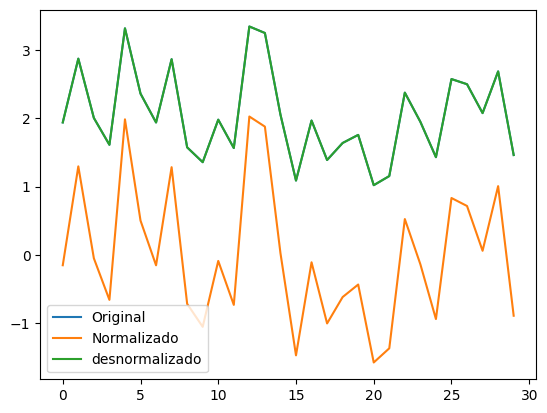

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:24:16.847310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:24:16.853875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:24:16.856594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:24:16.873839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:24:20.984331: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 17ms/st

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_3,0.170033,0.193817,0.097564,0.561840,0.345589,0.478585,0.572602,0.059507,0.262805,0.587868,-1.005754,0.608501,36.125011,59.945366
model_1_0_2,0.145773,-0.035258,-0.076557,0.236514,0.355690,0.614574,0.683083,0.103689,0.277943,0.596398,-1.064381,0.617330,36.067390,59.887745
model_1_0_0,-0.151410,-0.055966,-0.147436,0.255782,0.479434,0.626867,0.728056,0.101073,0.297147,0.692412,-1.782573,0.716714,35.470298,59.290654
model_1_0_1,0.005445,-0.074945,-0.273988,-0.124919,0.414121,0.638134,0.808354,0.152776,0.310091,0.643523,-1.403508,0.666109,35.763192,59.583548
model_1_0_4,0.144123,-0.123413,-0.133513,-0.181552,0.356377,0.666907,0.719222,0.160467,0.284424,0.596973,-1.068368,0.617926,36.063531,59.883886
model_1_0_5,0.203005,-0.137221,-0.120547,-0.225795,0.331860,0.675104,0.710995,0.166476,0.274757,0.576073,-0.926072,0.596292,36.206085,60.026440
model_1_0_6,0.356256,-0.477714,-1.094466,-0.108171,0.268048,0.877235,1.328953,0.150501,0.241120,0.517733,-0.555716,0.535905,36.633179,60.453535
model_1_0_7,0.372866,-0.533731,-1.218750,-0.064713,0.261131,0.910489,1.407812,0.144599,0.236563,0.511010,-0.515573,0.528946,36.685463,60.505818
model_1_0_8,0.436593,-0.647051,-1.377582,-0.116125,0.234596,0.977761,1.508592,0.151581,0.219776,0.484352,-0.361567,0.501351,36.899778,60.720133


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_1] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_0,0.446579,-0.215681,-0.563540,0.298499,0.230438,0.721681,0.992077,0.053266,0.215950,0.480040,-0.337434,0.496888,36.935545,60.755901
model_1_1_1,0.363240,-1.070268,-1.907180,-2.934849,0.265140,1.229000,1.844625,0.298781,0.225319,0.514917,-0.538837,0.532990,36.654996,60.475352
model_1_1_2,0.280163,-1.215012,-2.062566,-5.330819,0.299732,1.314927,1.943219,0.480711,0.230912,0.547478,-0.739607,0.566693,36.409733,60.230088
model_1_1_3,-0.143669,-7.776381,-14.995609,-18.190323,0.476211,5.210039,10.149323,1.457158,0.245778,0.690080,-1.763867,0.714301,35.483789,59.304144


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  49
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,-0.147159,-5.939723,-11.246891,-2.982436,0.477664,4.119719,7.770736,1.619820,0.200710,0.691132,-1.772301,0.715390,35.477695,59.298051
model_1_4_1,0.055948,-10.728505,-21.416233,-1.981133,0.393093,6.962547,14.223253,1.212549,0.205969,0.626971,-1.281460,0.648977,35.867419,59.687775
model_1_4_2,0.096743,-10.908537,-21.776886,-1.791435,0.376106,7.069422,14.452090,1.135391,0.203527,0.613275,-1.182871,0.634800,35.955769,59.776124
model_1_4_3,0.463639,-18.976919,-39.185023,-0.003411,0.223335,11.859162,25.497671,0.408128,0.179110,0.472583,-0.296205,0.489170,36.998169,60.818524
model_1_4_4,0.305314,-21.204104,-43.307825,-0.846171,0.289259,13.181315,28.113618,0.750913,0.187337,0.537828,-0.678824,0.556705,36.480864,60.301219
model_1_4_5,0.310709,-26.683879,-54.795581,-0.834642,0.287013,16.434346,35.402677,0.746224,0.187234,0.535736,-0.665786,0.554539,36.496456,60.316811
model_1_4_6,0.344018,-32.574391,-65.595473,-0.777850,0.273144,19.931209,42.255282,0.723124,0.183892,0.522631,-0.585291,0.540975,36.595515,60.415871
model_1_4_7,0.352974,-34.545118,-69.418519,-0.761408,0.269414,21.101118,44.681031,0.716437,0.182945,0.519051,-0.563646,0.537269,36.623009,60.443365
model_1_4_8,0.394289,-39.593304,-78.545739,-0.681032,0.252211,24.097939,50.472315,0.683744,0.178207,0.502206,-0.463801,0.519833,36.754978,60.575333


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.498558,-30.418349,-62.562958,0.730280,0.208795,18.651289,40.331131,0.162988,0.169752,0.456941,-0.211819,0.472979,37.132806,60.953162
model_1_5_8,0.493089,-30.677786,-62.975862,0.727951,0.211072,18.805302,40.593122,0.164395,0.170462,0.459426,-0.225035,0.475551,37.111111,60.931467
model_1_5_7,0.475939,-32.020577,-65.388173,0.720611,0.218213,19.602441,42.123749,0.168830,0.172650,0.467133,-0.266482,0.483529,37.044565,60.864921
model_1_5_6,0.463847,-32.973889,-67.093467,0.715372,0.223248,20.168368,43.205770,0.171996,0.174157,0.472491,-0.295703,0.489075,36.998944,60.819300
model_1_5_5,0.457592,-33.484132,-68.010806,0.712633,0.225853,20.471270,43.787828,0.173651,0.174925,0.475239,-0.310819,0.491920,36.975746,60.796102
model_1_5_4,0.451192,-33.667400,-68.227903,0.709806,0.228517,20.580066,43.925577,0.175359,0.175702,0.478035,-0.326286,0.494813,36.952286,60.772642
model_1_5_3,0.450683,-34.789124,-70.159258,0.734646,0.228730,21.245970,45.151035,0.160349,0.174333,0.478257,-0.327517,0.495043,36.950430,60.770785
model_1_5_2,0.445951,-35.820862,-71.903976,0.756916,0.230700,21.858454,46.258071,0.146891,0.174182,0.480312,-0.338953,0.497170,36.933275,60.753631
model_1_5_1,0.435657,-36.759784,-73.793683,0.768772,0.234986,22.415839,47.457103,0.139727,0.175955,0.484754,-0.363829,0.501768,36.896459,60.716814
model_1_5_0,0.430917,-37.143150,-74.507970,0.774446,0.236960,22.643422,47.910323,0.136298,0.176259,0.486785,-0.375284,0.503870,36.879730,60.700085


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_8,0.556080,-28.605112,-60.426069,-0.162108,0.184843,17.574874,38.975260,0.480137,0.160472,0.429934,-0.072807,0.445024,37.376493,61.196848
model_1_6_9,0.558970,-28.888319,-61.029942,-0.152898,0.183640,17.742997,39.358422,0.476332,0.159083,0.428532,-0.065823,0.443573,37.389557,61.209912
model_1_6_2,0.485652,-29.157494,-60.105420,-0.295233,0.214169,17.902791,38.771807,0.535139,0.174936,0.462784,-0.243009,0.479027,37.081981,60.902337
model_1_6_7,0.551554,-29.261135,-61.863046,-0.173927,0.186728,17.964317,39.887032,0.485020,0.160882,0.432120,-0.083745,0.447287,37.356204,61.176560
model_1_6_6,0.549245,-29.414429,-62.192430,-0.179900,0.187689,18.055319,40.096029,0.487488,0.161036,0.433231,-0.089323,0.448437,37.345937,61.166293
model_1_6_1,0.494381,-29.650992,-61.037782,-0.230688,0.210534,18.195753,39.363397,0.508472,0.170775,0.458840,-0.221913,0.474945,37.116215,60.936570
model_1_6_5,0.546874,-29.793997,-63.020778,-0.186079,0.188677,18.280647,40.621621,0.490041,0.161215,0.434369,-0.095055,0.449615,37.335442,61.155797
model_1_6_0,0.496382,-30.041425,-61.820738,-0.209320,0.209701,18.427531,39.860188,0.499643,0.170633,0.457931,-0.217077,0.474004,37.124146,60.944502
model_1_6_4,0.544462,-30.632639,-64.896698,-0.192149,0.189681,18.778501,41.811905,0.492549,0.162334,0.435524,-0.100884,0.450810,37.324823,61.145179
model_1_6_3,0.526239,-32.794437,-69.465435,-0.231842,0.197269,20.061838,44.710800,0.508949,0.164903,0.444149,-0.144923,0.459738,37.246377,61.066732


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.005993,-29.767913,-63.546598,-9.338116,0.413893,18.265162,40.955257,1.506841,0.244086,0.643345,-1.402183,0.665926,35.764295,59.584650
model_1_7_1,0.126648,-41.144573,-84.944136,-7.963264,0.363654,25.018839,54.532141,1.306448,0.233925,0.603037,-1.110601,0.624203,36.023105,59.843460
model_1_7_2,0.136912,-45.502736,-92.657577,-7.846766,0.359380,27.606033,59.426373,1.289468,0.233793,0.599483,-1.085797,0.620524,36.046748,59.867104
model_1_7_3,0.148305,-48.506483,-96.947583,-7.716202,0.354636,29.389187,62.148411,1.270437,0.234033,0.595513,-1.058262,0.616415,36.073326,59.893682
model_1_7_4,0.155338,-50.092019,-99.418813,-7.637852,0.351708,30.330429,63.716423,1.259017,0.233913,0.593050,-1.041267,0.613865,36.089909,59.910265
model_1_7_5,0.195998,-50.736114,-100.811058,-7.153038,0.334777,30.712792,64.599812,1.188353,0.230845,0.578600,-0.943005,0.598907,36.188579,60.008934
model_1_7_6,0.291684,-54.070522,-107.294394,-5.946842,0.294935,32.692241,68.713532,1.012543,0.215105,0.543079,-0.711764,0.562140,36.442002,60.262357
model_1_7_7,0.299757,-55.531925,-110.136732,-5.849195,0.291573,33.559793,70.517015,0.998310,0.213874,0.539975,-0.692253,0.558927,36.464929,60.285284
model_1_7_8,0.307369,-57.397940,-113.808600,-5.757164,0.288404,34.667540,72.846841,0.984896,0.212721,0.537032,-0.673858,0.555881,36.486788,60.307144
model_1_7_9,0.314529,-58.574238,-116.034817,-5.671141,0.285422,35.365841,74.259391,0.972358,0.211629,0.534249,-0.656554,0.553000,36.507571,60.327927


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.309991,-219.863672,-442.043607,-0.797643,0.287312,131.114217,281.114195,0.665887,0.218186,0.536015,-0.667523,0.554828,36.494373,60.314728
model_1_8_1,0.319567,-224.325240,-449.874330,-0.765973,0.283324,133.762796,286.082842,0.654156,0.216719,0.532282,-0.644379,0.550965,36.522325,60.342681
model_1_8_2,0.329029,-228.591059,-457.114827,-0.734347,0.279385,136.295171,290.676987,0.642440,0.215236,0.528569,-0.621514,0.547121,36.550331,60.370686
model_1_8_3,0.379268,-245.876954,-482.076770,-0.569319,0.258466,146.556824,306.515510,0.581310,0.207079,0.508395,-0.500102,0.526239,36.705985,60.526340
model_1_8_4,0.386889,-247.960232,-484.634846,-0.544199,0.255292,147.793548,308.138627,0.572005,0.205788,0.505265,-0.481685,0.522999,36.730691,60.551046
model_1_8_5,0.394357,-249.033088,-485.165500,-0.519463,0.252183,148.430442,308.475330,0.562843,0.204504,0.502178,-0.463636,0.519804,36.755203,60.575559
model_1_8_6,0.458525,-280.741900,-537.021694,-0.310551,0.225464,167.254162,341.378440,0.485457,0.192686,0.474831,-0.308565,0.491496,36.979189,60.799544
model_1_8_8,0.512515,-292.820678,-553.447750,-0.131793,0.202983,174.424647,351.800884,0.419241,0.181844,0.450537,-0.178089,0.466350,37.189264,61.009619
model_1_8_9,0.517986,-293.515339,-554.095914,-0.113739,0.200705,174.837028,352.212149,0.412553,0.180665,0.448001,-0.164868,0.463726,37.211835,61.032191
model_1_8_7,0.509696,-293.705743,-555.607780,-0.141098,0.204157,174.950060,353.171439,0.422688,0.182445,0.451838,-0.184903,0.467696,37.177730,60.998085


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_1,0.591544,-470.211975,-702.152452,0.378151,0.170077,279.731784,446.155034,0.228222,0.170719,0.412403,0.012897,0.426878,37.543013,61.363369
model_1_9_6,0.611022,-476.008939,-731.960150,0.405245,0.161966,283.173112,465.068222,0.218279,0.165783,0.402450,0.059970,0.416575,37.640738,61.461094
model_1_9_0,0.558275,-476.251586,-685.727648,0.325072,0.183929,283.317158,435.733383,0.247703,0.177910,0.428870,-0.067502,0.443922,37.386407,61.206763
model_1_9_2,0.593454,-476.860291,-715.972643,0.380206,0.169281,283.678511,454.924039,0.227468,0.170264,0.411438,0.017515,0.425878,37.552391,61.372747
model_1_9_5,0.609752,-478.042783,-733.354848,0.403487,0.162495,284.380489,465.953167,0.218924,0.166071,0.403107,0.056900,0.417255,37.634217,61.454572
model_1_9_4,0.603984,-478.541486,-729.744881,0.394785,0.164897,284.676541,463.662619,0.222118,0.167452,0.406075,0.042961,0.420327,37.604873,61.425228
model_1_9_3,0.597152,-481.069909,-728.586633,0.384704,0.167741,286.177522,462.927702,0.225817,0.169323,0.409562,0.026451,0.423937,37.570666,61.391021
model_1_9_9,0.628261,-654.798848,-1018.281129,0.432148,0.154788,389.310525,646.740839,0.208405,0.163062,0.393431,0.101631,0.407240,37.731400,61.551756
model_1_9_8,0.623682,-687.838223,-1040.381601,0.429286,0.156694,408.924125,660.763739,0.209455,0.163517,0.395846,0.090566,0.409740,37.706916,61.527272
model_1_9_7,0.616054,-708.297769,-1092.127914,0.410016,0.159871,421.069796,693.597128,0.216528,0.165114,0.399838,0.072131,0.413872,37.666781,61.487137


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_10] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.653896,-293.991160,-453.945251,-0.965666,0.144114,175.119496,288.665869,0.349154,0.155536,0.379623,0.163582,0.392947,37.874305,61.694661
model_1_10_8,0.653387,-294.079865,-453.696703,-0.966481,0.144326,175.172155,288.508164,0.349299,0.155674,0.379903,0.162351,0.393236,37.871362,61.691718
model_1_10_7,0.652375,-296.482199,-456.512566,-0.968245,0.144747,176.598284,290.294848,0.349612,0.155902,0.380456,0.159907,0.393810,37.865536,61.685891
model_1_10_6,0.651830,-296.637657,-456.419236,-0.969202,0.144974,176.690571,290.235630,0.349782,0.156051,0.380754,0.158590,0.394118,37.862402,61.682757
model_1_10_5,0.649602,-308.176668,-472.489660,-0.973553,0.145902,183.540626,300.432423,0.350555,0.156543,0.381971,0.153204,0.395378,37.849642,61.669998
model_1_10_4,0.648996,-308.543077,-472.852560,-0.974779,0.146154,183.758142,300.662686,0.350773,0.156771,0.382301,0.151741,0.395719,37.846189,61.666544
model_1_10_3,0.647758,-308.552562,-472.640180,-0.977408,0.146670,183.763773,300.527929,0.351240,0.157243,0.382975,0.148748,0.396417,37.839144,61.659500
model_1_10_2,0.642114,-316.477038,-485.411310,-0.990529,0.149020,188.468084,308.631299,0.353570,0.159289,0.386031,0.135108,0.399580,37.807352,61.627707
model_1_10_1,0.641330,-318.731737,-489.162752,-0.992493,0.149346,189.806571,311.011614,0.353919,0.159555,0.386453,0.133214,0.400017,37.802977,61.623333
model_1_10_0,0.631056,-349.682997,-548.014713,-1.019906,0.153624,208.180576,348.353586,0.358788,0.162818,0.391949,0.108386,0.405706,37.746496,61.566851


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_1,0.653512,-416.191246,-759.751524,0.851225,0.144274,247.662745,482.702038,0.063484,0.157596,0.379834,0.162653,0.393166,37.872084,61.692440
model_1_11_0,0.652876,-416.355160,-759.760241,0.852446,0.144539,247.760052,482.707569,0.062963,0.157610,0.380182,0.161117,0.393526,37.868418,61.688774
model_1_11_5,0.665039,-416.406004,-764.343241,0.822546,0.139474,247.790235,485.615514,0.075722,0.156040,0.373462,0.190510,0.386570,37.939752,61.760107
model_1_11_7,0.666959,-416.510981,-764.566446,0.816829,0.138674,247.852554,485.757140,0.078161,0.155573,0.372390,0.195152,0.385460,37.951254,61.771609
model_1_11_8,0.667336,-416.579136,-764.772890,0.815717,0.138518,247.893014,485.888130,0.078636,0.155477,0.372180,0.196061,0.385243,37.953514,61.773870
model_1_11_9,0.669550,-416.594978,-765.061293,0.809331,0.137596,247.902418,486.071123,0.081361,0.154900,0.370939,0.201411,0.383958,37.966870,61.787225
model_1_11_6,0.666193,-416.636758,-764.633222,0.819086,0.138993,247.927220,485.799509,0.077198,0.155774,0.372818,0.193300,0.385904,37.946657,61.767012
model_1_11_4,0.663443,-417.529051,-765.956523,0.827248,0.140139,248.456924,486.639153,0.073715,0.156380,0.374351,0.186653,0.387490,37.930245,61.750601
model_1_11_3,0.663029,-417.541823,-765.854946,0.828434,0.140311,248.464506,486.574701,0.073209,0.156464,0.374581,0.185655,0.387728,37.927792,61.748148
model_1_11_2,0.661752,-417.585749,-765.543174,0.832011,0.140843,248.490583,486.376880,0.071683,0.156713,0.375290,0.182567,0.388462,37.920223,61.740579


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_12] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_6,0.725090,-639.815514,-1174.195922,0.569071,0.114470,380.415771,745.669840,0.258032,0.136980,0.338334,0.335633,0.350208,38.334893,62.155248
model_1_12_7,0.724593,-639.839441,-1174.399013,0.564968,0.114676,380.429975,745.798702,0.260489,0.136798,0.338639,0.334434,0.350524,38.331286,62.151641
model_1_12_9,0.722853,-639.866778,-1174.660548,0.554437,0.115401,380.446203,745.964648,0.266795,0.136527,0.339707,0.330227,0.351630,38.318684,62.139040
model_1_12_8,0.723883,-639.881644,-1174.595347,0.560179,0.114972,380.455028,745.923278,0.263357,0.136623,0.339075,0.332717,0.350976,38.326134,62.146489
model_1_12_0,0.690457,-917.717595,-1702.826515,0.685870,0.128890,545.390451,1081.089562,0.188096,0.152332,0.359013,0.251939,0.371613,38.097591,61.917947
model_1_12_1,0.694279,-939.302357,-1726.709795,0.671899,0.127299,558.204098,1096.243666,0.196461,0.151391,0.356790,0.261174,0.369312,38.122435,61.942791
model_1_12_5,0.707453,-1011.653984,-1904.821753,0.637765,0.121813,601.155149,1209.256920,0.216900,0.147070,0.349018,0.293011,0.361267,38.210532,62.030888
model_1_12_4,0.705614,-1028.626541,-1923.026260,0.641668,0.122579,611.230792,1220.807804,0.214563,0.147751,0.350113,0.288568,0.362401,38.198002,62.018358
model_1_12_2,0.703757,-1029.850656,-1934.781647,0.645790,0.123352,611.957480,1228.266677,0.212094,0.148414,0.351215,0.284081,0.363542,38.185426,62.005781
model_1_12_3,0.704686,-1034.447505,-1928.673072,0.643692,0.122966,614.686368,1224.390745,0.213350,0.148076,0.350665,0.286323,0.362972,38.191701,62.012057


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_5,0.734880,-637.652231,-1172.476550,0.776595,0.110393,379.131552,744.578887,0.130559,0.135055,0.332254,0.359294,0.343916,38.407421,62.227777
model_1_13_0,0.723881,-637.719324,-1171.011411,0.785905,0.114973,379.171382,743.649246,0.125119,0.136279,0.339076,0.332712,0.350978,38.326118,62.146474
model_1_13_6,0.735562,-637.789175,-1172.776948,0.776092,0.110109,379.212848,744.769491,0.130854,0.134990,0.331827,0.360942,0.343473,38.412571,62.232926
model_1_13_2,0.729733,-637.813156,-1171.767736,0.781100,0.112536,379.227085,744.129139,0.127927,0.135434,0.335464,0.346855,0.347238,38.368962,62.189317
model_1_13_4,0.731964,-637.838649,-1172.223190,0.779123,0.111607,379.242219,744.418128,0.129082,0.135269,0.334076,0.352247,0.345802,38.385543,62.205898
model_1_13_3,0.731740,-638.031017,-1172.577582,0.779325,0.111701,379.356417,744.642992,0.128964,0.135285,0.334216,0.351704,0.345947,38.383867,62.204222
model_1_13_9,0.736554,-638.101562,-1173.563263,0.775505,0.109696,379.398295,745.268413,0.131197,0.134869,0.331204,0.363339,0.342828,38.420087,62.240443
model_1_13_8,0.736061,-638.163594,-1173.708213,0.775771,0.109901,379.435120,745.360385,0.131041,0.134929,0.331514,0.362147,0.343149,38.416346,62.236701
model_1_13_7,0.735895,-638.166002,-1173.689703,0.775872,0.109970,379.436549,745.348640,0.130982,0.134951,0.331617,0.361747,0.343257,38.415092,62.235448
model_1_13_1,0.724360,-638.925380,-1173.220965,0.785535,0.114773,379.887349,745.051223,0.125335,0.136172,0.338782,0.333871,0.350673,38.329594,62.149950


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.734554,-635.124196,-1176.817340,0.731353,0.110529,377.630802,747.333147,0.058770,0.135892,0.332458,0.358507,0.344127,38.404963,62.225319
model_1_14_7,0.733846,-635.158416,-1176.638162,0.731392,0.110824,377.651116,747.219458,0.058762,0.136198,0.332902,0.356793,0.344586,38.399629,62.219985
model_1_14_8,0.734057,-635.169194,-1176.735950,0.731357,0.110736,377.657515,747.281505,0.058769,0.136129,0.332770,0.357305,0.344449,38.401219,62.221575
model_1_14_3,0.732452,-635.313448,-1176.407730,0.732096,0.111404,377.743150,747.073247,0.058608,0.136784,0.333772,0.353426,0.345487,38.389187,62.209543
model_1_14_4,0.732679,-635.341930,-1176.542993,0.731936,0.111309,377.760058,747.159072,0.058643,0.136699,0.333631,0.353975,0.345340,38.390884,62.211240
model_1_14_5,0.732907,-635.396223,-1176.714162,0.731793,0.111214,377.792289,747.267680,0.058674,0.136612,0.333488,0.354526,0.345193,38.392591,62.212946
model_1_14_6,0.733617,-635.438472,-1177.050732,0.731449,0.110919,377.817370,747.481236,0.058749,0.136293,0.333045,0.356242,0.344734,38.397914,62.218270
model_1_14_2,0.738103,-637.761619,-1173.857778,0.820968,0.109051,379.196490,745.455285,0.039166,0.135084,0.330229,0.367082,0.341819,38.431880,62.252235
model_1_14_1,0.737926,-637.888738,-1173.789504,0.827683,0.109125,379.271953,745.411965,0.037697,0.134397,0.330340,0.366655,0.341934,38.430531,62.250887
model_1_14_0,0.737616,-637.889087,-1173.673633,0.827733,0.109254,379.272160,745.338444,0.037686,0.134694,0.330536,0.365904,0.342137,38.428162,62.248517


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.741937,-635.028675,-1176.584571,0.338817,0.107454,377.574096,747.185454,0.141205,0.132376,0.327802,0.376349,0.339308,38.461378,62.281734
model_1_15_8,0.741624,-635.075748,-1176.667790,0.338532,0.107585,377.602041,747.238257,0.141266,0.132525,0.328001,0.375591,0.339514,38.458951,62.279307
model_1_15_7,0.741294,-635.108643,-1176.746206,0.338254,0.107722,377.621569,747.288012,0.141325,0.132702,0.328211,0.374794,0.339730,38.456400,62.276755
model_1_15_6,0.740971,-635.122517,-1176.778578,0.337982,0.107857,377.629805,747.308552,0.141384,0.132863,0.328416,0.374013,0.339942,38.453902,62.274257
model_1_15_5,0.740005,-635.200257,-1176.915998,0.337207,0.108259,377.675955,747.395747,0.141549,0.133326,0.329028,0.371678,0.340576,38.446455,62.266810
model_1_15_3,0.739343,-635.232799,-1176.965433,0.336733,0.108535,377.695274,747.427113,0.141650,0.133653,0.329446,0.370078,0.341009,38.441371,62.261726
model_1_15_0,0.738349,-635.240978,-1176.976168,0.336078,0.108949,377.700129,747.433925,0.141790,0.134126,0.330073,0.367677,0.341659,38.433760,62.254115
model_1_15_1,0.738670,-635.254345,-1177.002414,0.336287,0.108815,377.708064,747.450578,0.141745,0.133988,0.329871,0.368452,0.341449,38.436213,62.256568
model_1_15_4,0.739670,-635.277829,-1177.052815,0.336967,0.108398,377.722005,747.482558,0.141600,0.133497,0.329239,0.370870,0.340795,38.443884,62.264239
model_1_15_2,0.739015,-635.321153,-1177.116970,0.336505,0.108671,377.747724,747.523265,0.141699,0.133807,0.329653,0.369287,0.341223,38.438859,62.259214


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.743756,-633.545861,-1175.236086,-0.168015,0.106697,376.693834,746.329831,0.159045,0.131389,0.326645,0.380744,0.338110,38.475525,62.295880
model_1_16_1,0.744327,-633.617936,-1175.473782,-0.165416,0.106459,376.736621,746.480651,0.158691,0.130758,0.326281,0.382123,0.337733,38.479983,62.300338
model_1_16_5,0.750397,-633.657872,-1175.799730,-0.205138,0.103932,376.760329,746.687467,0.164100,0.127754,0.322384,0.396793,0.333700,38.528042,62.348397
model_1_16_2,0.749653,-633.669217,-1175.902282,-0.194411,0.104242,376.767063,746.752537,0.162639,0.128460,0.322865,0.394994,0.334197,38.522084,62.342439
model_1_16_4,0.750067,-633.699081,-1175.927591,-0.201661,0.104069,376.784792,746.768596,0.163626,0.128130,0.322598,0.395995,0.333920,38.525397,62.345753
model_1_16_3,0.749787,-633.737761,-1176.127288,-0.201477,0.104186,376.807754,746.895305,0.163601,0.128531,0.322778,0.395319,0.334107,38.523160,62.343515
model_1_16_6,0.750452,-634.123860,-1177.172408,-0.220570,0.103909,377.036959,747.558440,0.166201,0.128247,0.322349,0.396926,0.333663,38.528481,62.348836
model_1_16_7,0.750451,-634.166922,-1177.332791,-0.224403,0.103909,377.062523,747.660205,0.166723,0.128293,0.322350,0.396923,0.333664,38.528471,62.348827
model_1_16_8,0.747743,-635.274790,-1179.764018,-0.297213,0.105037,377.720201,749.202835,0.176637,0.129611,0.324094,0.390380,0.335469,38.506890,62.327245
model_1_16_9,0.731628,-639.365000,-1184.192812,-0.573629,0.111747,380.148326,752.012934,0.214276,0.132792,0.334286,0.351434,0.346019,38.383033,62.203389


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.730953,-638.032888,-1185.912467,0.784547,0.112028,379.357527,753.104068,0.162963,0.133931,0.334706,0.349804,0.346453,38.378014,62.198369
model_1_17_8,0.739898,-638.337724,-1186.421021,0.811590,0.108303,379.538491,753.426748,0.142508,0.132301,0.329095,0.371420,0.340646,38.445636,62.265992
model_1_17_7,0.740602,-638.391127,-1186.469599,0.814790,0.108010,379.570193,753.457571,0.140088,0.132095,0.328649,0.373122,0.340184,38.451057,62.271412
model_1_17_6,0.740519,-638.566915,-1186.527638,0.819869,0.108045,379.674548,753.494398,0.136246,0.131904,0.328702,0.372921,0.340239,38.450417,62.270772
model_1_17_5,0.740260,-638.656002,-1186.613384,0.820555,0.108153,379.727434,753.548804,0.135727,0.131918,0.328866,0.372295,0.340409,38.448420,62.268775
model_1_17_4,0.738875,-638.880947,-1186.748998,0.822631,0.108729,379.860972,753.634852,0.134157,0.132078,0.329741,0.368949,0.341315,38.437788,62.258144
model_1_17_3,0.738469,-638.925408,-1186.775509,0.823058,0.108899,379.887366,753.651674,0.133834,0.132122,0.329998,0.367966,0.341580,38.434675,62.255031
model_1_17_1,0.732895,-639.170884,-1184.158505,0.829059,0.111219,380.033090,751.991166,0.129295,0.132623,0.333496,0.354497,0.345201,38.392501,62.212856
model_1_17_2,0.737140,-639.176808,-1186.996850,0.824233,0.109452,380.036607,753.792116,0.132945,0.132278,0.330835,0.364755,0.342447,38.424541,62.244896
model_1_17_0,0.732293,-639.285865,-1184.238482,0.829431,0.111470,380.101349,752.041913,0.129013,0.132699,0.333871,0.353042,0.345590,38.387998,62.208353


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_18] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.731566,-637.979533,-1185.568465,0.539852,0.111773,379.325854,752.885796,0.146756,0.133866,0.334324,0.351286,0.346058,38.382576,62.202931


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,-0.114585,-642.231863,-1361.227580,0.467290,0.464101,381.850220,864.342704,0.169360,0.205426,0.681249,-1.693582,0.705160,35.535307,59.355663
model_1_21_1,-0.102937,-642.392040,-1361.332152,0.438777,0.459250,381.945308,864.409056,0.178424,0.205127,0.677680,-1.665430,0.701466,35.556320,59.376675
model_1_21_2,-0.086451,-642.617940,-1361.359151,0.443741,0.452386,382.079412,864.426187,0.176846,0.204444,0.672597,-1.625591,0.696204,35.586439,59.406794
model_1_21_3,-0.057393,-642.695566,-1360.899251,0.533346,0.440286,382.125494,864.134377,0.148359,0.202773,0.663541,-1.555365,0.686830,35.640660,59.461016


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_5,0.033745,-641.894882,-1356.724242,0.225512,0.402338,381.650174,861.485305,0.177137,0.198284,0.634301,-1.335117,0.656564,35.820927,59.641283
model_1_22_4,0.019313,-642.175483,-1357.738044,0.226957,0.408347,381.816750,862.128570,0.176807,0.199013,0.639020,-1.369994,0.661449,35.791276,59.611632
model_1_22_3,0.004587,-642.568903,-1359.035643,0.228421,0.414479,382.050301,862.951905,0.176472,0.199750,0.643800,-1.405581,0.666396,35.761468,59.581823
model_1_22_2,-0.010460,-642.675606,-1359.671441,0.229899,0.420744,382.113645,863.355324,0.176134,0.200495,0.648648,-1.441946,0.671414,35.731460,59.551816
model_1_22_1,-0.025787,-642.746950,-1360.228831,0.231391,0.427126,382.155998,863.708991,0.175793,0.201246,0.653549,-1.478985,0.676487,35.701352,59.521708
model_1_22_0,-0.041444,-643.060585,-1361.270016,0.232890,0.433646,382.342185,864.369630,0.175450,0.202006,0.658518,-1.516824,0.681631,35.671055,59.491411
model_1_22_9,0.163380,-644.062437,-1356.994475,0.211535,0.348359,382.936928,861.656770,0.180334,0.191357,0.590219,-1.021831,0.610935,36.109044,59.929399
model_1_22_7,0.061742,-644.206940,-1360.684433,0.222640,0.390680,383.022711,863.998074,0.177794,0.196848,0.625044,-1.267458,0.646982,35.879732,59.700088
model_1_22_6,0.047901,-644.283452,-1361.238468,0.224068,0.396443,383.068132,864.349613,0.177467,0.197561,0.629637,-1.300907,0.651737,35.850444,59.670800
model_1_22_8,0.075323,-644.487575,-1360.862535,0.221224,0.385025,383.189308,864.111081,0.178118,0.196140,0.620504,-1.234637,0.642283,35.908893,59.729249


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.209151,-643.647548,-1354.718228,-1.731612,0.329300,382.690632,860.212476,1.100776,0.189555,0.573847,-0.911218,0.593988,36.221570,60.041925
model_1_23_8,0.196233,-643.697963,-1355.322834,-1.794871,0.334680,382.720560,860.596103,1.126268,0.190159,0.578515,-0.942437,0.598820,36.189164,60.009519
model_1_23_7,0.193297,-643.712993,-1355.432460,-1.806487,0.335902,382.729483,860.665661,1.130948,0.190262,0.579571,-0.949533,0.599913,36.181871,60.002227
model_1_23_6,0.193615,-643.720783,-1355.391980,-1.801213,0.335769,382.734108,860.639976,1.128823,0.190201,0.579456,-0.948763,0.599794,36.182661,60.003016
model_1_23_5,0.186340,-643.721131,-1355.612390,-1.835095,0.338799,382.734314,860.779828,1.142477,0.190517,0.582064,-0.966344,0.602494,36.164699,59.985054
model_1_23_4,0.184113,-643.725542,-1355.671559,-1.842824,0.339726,382.736933,860.817371,1.145591,0.190582,0.582860,-0.971727,0.603318,36.159231,59.979586
model_1_23_1,0.176801,-643.736585,-1355.873677,-1.868783,0.342771,382.743488,860.945617,1.156052,0.190800,0.585466,-0.989397,0.606015,36.141387,59.961743
model_1_23_2,0.177609,-643.742361,-1355.897161,-1.868627,0.342434,382.746917,860.960517,1.155989,0.190808,0.585179,-0.987445,0.605718,36.143351,59.963707
model_1_23_3,0.179604,-643.752275,-1355.877938,-1.862260,0.341604,382.752802,860.948320,1.153424,0.190757,0.584469,-0.982623,0.604982,36.148209,59.968564
model_1_23_0,0.162624,-643.993524,-1356.927047,-1.937920,0.348674,382.896018,861.613987,1.183913,0.191443,0.590486,-1.023659,0.611211,36.107236,59.927592


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_24] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.209190,-643.697594,-1354.828446,-3.515372,0.329284,382.720341,860.282410,1.200430,0.189576,0.573833,-0.911124,0.593974,36.221668,60.042023
model_1_24_1,0.209233,-643.730426,-1354.902469,-3.521020,0.329266,382.739832,860.329378,1.201931,0.189604,0.573817,-0.911020,0.593957,36.221776,60.042132
model_1_24_2,0.209229,-643.802928,-1355.059783,-3.526907,0.329268,382.782872,860.429195,1.203497,0.189642,0.573819,-0.911029,0.593959,36.221767,60.042122
model_1_24_3,0.209232,-643.857472,-1355.179416,-3.532634,0.329267,382.815252,860.505103,1.205019,0.189671,0.573818,-0.911023,0.593958,36.221773,60.042128
model_1_24_4,0.209236,-643.904029,-1355.282046,-3.538238,0.329265,382.842890,860.570223,1.206509,0.189690,0.573816,-0.911013,0.593956,36.221783,60.042139
model_1_24_5,0.209252,-643.924957,-1355.330839,-3.543627,0.329258,382.855314,860.601182,1.207942,0.189715,0.573810,-0.910974,0.593950,36.221824,60.042180
model_1_24_8,0.209307,-643.929840,-1355.355231,-3.559097,0.329236,382.858212,860.616659,1.212054,0.189779,0.573791,-0.910842,0.593930,36.221962,60.042318
model_1_24_6,0.209231,-643.976538,-1355.443979,-3.549203,0.329267,382.885935,860.672970,1.209424,0.189734,0.573818,-0.911024,0.593958,36.221772,60.042127
model_1_24_9,0.209264,-643.978039,-1355.461092,-3.564516,0.329253,382.886826,860.683828,1.213495,0.189804,0.573806,-0.910945,0.593946,36.221855,60.042210
model_1_24_7,0.209230,-643.998711,-1355.495239,-3.554507,0.329268,382.899097,860.705495,1.210834,0.189759,0.573818,-0.911027,0.593958,36.221769,60.042125


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_2,0.241189,-643.550393,-1353.753692,0.634956,0.315960,382.632957,859.600471,0.093240,0.187606,0.562104,-0.833794,0.581832,36.304277,60.124632
model_1_25_1,0.230739,-643.783564,-1354.433243,0.634710,0.320312,382.771377,860.031651,0.093302,0.188440,0.565961,-0.859047,0.585825,36.276922,60.097278
model_1_25_0,0.220110,-643.862949,-1354.902804,0.634802,0.324737,382.818503,860.329591,0.093279,0.189130,0.569857,-0.884734,0.589858,36.249477,60.069833
model_1_25_4,0.261263,-646.592062,-1359.282347,0.633506,0.307602,384.438623,863.108441,0.093610,0.186398,0.554619,-0.785281,0.574085,36.357899,60.178254
model_1_25_3,0.251349,-646.688799,-1359.903022,0.634360,0.311730,384.496050,863.502263,0.093392,0.186956,0.558328,-0.809240,0.577924,36.331236,60.151592
model_1_25_9,0.307710,-648.014564,-1359.618972,0.627354,0.288262,385.283081,863.322031,0.095181,0.184432,0.536900,-0.673035,0.555744,36.487772,60.308128
model_1_25_8,0.298746,-648.056216,-1360.185330,0.628305,0.291994,385.307808,863.681390,0.094938,0.184908,0.540365,-0.694698,0.559331,36.462042,60.282398
model_1_25_7,0.289542,-648.303374,-1361.079955,0.628779,0.295827,385.454531,864.249035,0.094817,0.185500,0.543900,-0.716941,0.562990,36.435962,60.256318
model_1_25_5,0.270654,-648.310272,-1361.899017,0.630035,0.303691,385.458626,864.768736,0.094496,0.186606,0.551082,-0.762586,0.570424,36.383486,60.203842
model_1_25_6,0.280192,-648.433839,-1361.751426,0.629390,0.299720,385.531981,864.675088,0.094661,0.186056,0.547467,-0.739535,0.566682,36.409815,60.230171


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 9

2024-10-14 14:40:16.774268: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_7,0.372991,-642.934686,-1346.296846,0.921516,0.261079,382.267446,854.869051,0.038021,0.180423,0.510959,-0.515271,0.528893,36.685862,60.506218
model_1_26_6,0.365406,-643.010996,-1346.896859,0.921568,0.264238,382.312747,855.249764,0.037995,0.180909,0.514041,-0.533603,0.532083,36.661811,60.482167
model_1_26_8,0.380452,-644.268317,-1348.727639,0.921464,0.257973,383.059147,856.411406,0.038046,0.179948,0.507910,-0.497241,0.525737,36.709803,60.530158
model_1_26_9,0.387743,-644.354960,-1348.492780,0.921413,0.254937,383.110582,856.262387,0.038070,0.179463,0.504913,-0.479622,0.522634,36.733478,60.553833
model_1_26_5,0.357648,-645.288366,-1351.997466,0.921620,0.267468,383.664692,858.486134,0.037970,0.181393,0.517173,-0.552350,0.535325,36.637510,60.457866
model_1_26_4,0.349733,-645.449347,-1352.770007,0.921671,0.270764,383.760257,858.976316,0.037945,0.181890,0.520350,-0.571478,0.538613,36.613018,60.433374
model_1_26_3,0.341648,-646.095157,-1353.934301,0.921725,0.274130,384.143638,859.715069,0.037919,0.182393,0.523574,-0.591017,0.541951,36.588304,60.408660
model_1_26_2,0.333422,-646.718228,-1355.550711,0.921779,0.277555,384.513520,860.740692,0.037893,0.182899,0.526835,-0.610896,0.545326,36.563469,60.383825
model_1_26_1,0.325005,-647.264765,-1357.121900,0.921832,0.281060,384.837968,861.737623,0.037868,0.183402,0.530151,-0.631238,0.548759,36.538373,60.358728
model_1_26_0,0.316458,-648.085784,-1359.360964,0.921885,0.284619,385.325360,863.158324,0.037842,0.183918,0.533497,-0.651892,0.552222,36.513208,60.333563


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_1,0.415821,-641.861552,-1344.685162,0.873099,0.243246,381.630388,853.846427,0.038262,0.177438,0.493199,-0.411766,0.510510,36.827367,60.647723
model_1_27_9,0.465460,-642.072508,-1340.173534,0.868981,0.222576,381.755620,850.983768,0.039504,0.174131,0.471780,-0.291804,0.488339,37.004971,60.825327
model_1_27_8,0.459698,-642.073219,-1340.666289,0.869516,0.224975,381.756042,851.296424,0.039342,0.174483,0.474316,-0.305729,0.490963,36.983528,60.803883
model_1_27_7,0.453811,-642.180977,-1341.263561,0.869986,0.227427,381.820012,851.675398,0.039201,0.174972,0.476893,-0.319956,0.493631,36.961854,60.782209
model_1_27_2,0.422500,-642.286736,-1343.839562,0.872743,0.240464,381.882795,853.309888,0.038369,0.176855,0.490372,-0.395624,0.507583,36.850367,60.670723
model_1_27_6,0.447750,-642.311587,-1341.897606,0.870221,0.229951,381.897547,852.077704,0.039130,0.175573,0.479532,-0.334605,0.496363,36.939780,60.760135
model_1_27_3,0.429026,-642.343570,-1343.523893,0.872236,0.237747,381.916534,853.109594,0.038522,0.176379,0.487593,-0.379853,0.504707,36.873097,60.693452
model_1_27_5,0.441581,-642.417061,-1342.517560,0.870526,0.232519,381.960161,852.471069,0.039038,0.176049,0.482202,-0.349512,0.499127,36.917565,60.737920
model_1_27_4,0.435299,-642.555972,-1343.250730,0.870954,0.235135,382.042625,852.936270,0.038909,0.176484,0.484907,-0.364694,0.501927,36.895191,60.715546
model_1_27_0,0.408986,-643.747534,-1348.640149,0.873330,0.246091,382.749988,856.355893,0.038192,0.178023,0.496076,-0.428283,0.513487,36.804105,60.624460


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_4,0.486334,-637.237231,-1333.230650,0.657167,0.213885,378.885190,846.578461,0.052606,0.176690,0.462477,-0.241360,0.478709,37.084636,60.904992
model_1_28_8,0.510418,-641.038341,-1337.704458,0.712665,0.203856,381.141694,849.417123,0.044090,0.173068,0.451505,-0.183156,0.467352,37.180679,61.001035
model_1_28_7,0.505743,-641.122329,-1338.293829,0.715044,0.205803,381.191553,849.791083,0.043725,0.173364,0.453655,-0.194454,0.469578,37.161673,60.982028
model_1_28_9,0.515887,-641.234327,-1337.206939,0.722418,0.201579,381.258040,849.101444,0.042593,0.172095,0.448976,-0.169940,0.464734,37.203145,61.023501
model_1_28_5,0.496253,-641.387922,-1339.639209,0.721881,0.209754,381.349220,850.644736,0.042676,0.173839,0.457990,-0.217388,0.474064,37.123635,60.943991
model_1_28_6,0.501308,-641.533203,-1339.412802,0.721905,0.207650,381.435466,850.501079,0.042672,0.173405,0.455686,-0.205173,0.471680,37.143804,60.964159
model_1_28_0,0.471091,-641.836048,-1339.243867,0.744178,0.220232,381.615247,850.393888,0.039254,0.173683,0.469289,-0.278198,0.485760,37.026149,60.846504
model_1_28_3,0.487266,-642.193084,-1338.382423,0.741111,0.213497,381.827199,849.847296,0.039725,0.172878,0.462057,-0.239107,0.478274,37.088268,60.908624
model_1_28_2,0.481946,-642.350397,-1339.150565,0.741681,0.215712,381.920587,850.334687,0.039637,0.173337,0.464448,-0.251964,0.480749,37.067623,60.887979
model_1_28_1,0.476470,-642.572702,-1339.979025,0.741442,0.217992,382.052557,850.860351,0.039674,0.173959,0.466896,-0.265197,0.483283,37.046596,60.866951


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_4,0.559338,-639.068471,-1327.521956,-0.475688,0.183487,379.972294,842.956256,0.255373,0.170887,0.428354,-0.064934,0.443388,37.391225,61.211580
model_1_29_5,0.562948,-639.428817,-1327.747224,-0.479876,0.181983,380.186211,843.099190,0.256098,0.170563,0.426595,-0.056208,0.441568,37.407680,61.228036
model_1_29_6,0.543896,-640.004387,-1325.050785,-1.018145,0.189917,380.527894,841.388281,0.349248,0.178132,0.435794,-0.102252,0.451090,37.322340,61.142695
model_1_29_3,0.531682,-640.729743,-1334.184704,-0.445632,0.195002,380.958497,847.183815,0.250172,0.173268,0.441591,-0.131769,0.457090,37.269486,61.089842
model_1_29_0,0.482325,-641.233425,-1336.707336,-0.867878,0.215554,381.257504,848.784442,0.323243,0.183510,0.464278,-0.251047,0.480573,37.069089,60.889444
model_1_29_2,0.485049,-641.332544,-1335.926877,-0.950508,0.214420,381.316345,848.289236,0.337543,0.183672,0.463055,-0.244464,0.479307,37.079640,60.899996
model_1_29_1,0.482725,-641.384846,-1336.549737,-0.921403,0.215387,381.347394,848.684444,0.332506,0.183751,0.464098,-0.250081,0.480388,37.070634,60.890990
model_1_29_9,0.583365,-641.394483,-1320.635989,-1.076040,0.173482,381.353115,838.587063,0.359266,0.173670,0.416512,-0.006867,0.431131,37.503363,61.323719
model_1_29_7,0.563924,-642.117370,-1327.421428,-1.045783,0.181577,381.782252,842.892470,0.354030,0.175964,0.426119,-0.053851,0.441075,37.412148,61.232504
model_1_29_8,0.566545,-642.338350,-1327.248845,-1.049615,0.180486,381.913435,842.782965,0.354693,0.175671,0.424836,-0.047517,0.439747,37.424206,61.244561


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_5,0.610473,-639.735112,-1310.670291,0.853112,0.162194,380.368041,832.263759,0.050294,0.170382,0.402734,0.058644,0.416869,37.637919,61.458274
model_1_30_3,0.606407,-639.795983,-1312.095623,0.852911,0.163888,380.404176,833.168142,0.050362,0.170901,0.404831,0.048816,0.419040,37.617146,61.437502
model_1_30_4,0.608464,-639.858845,-1311.574717,0.853015,0.163031,380.441494,832.837623,0.050327,0.170642,0.403771,0.053787,0.417943,37.627626,61.447981
model_1_30_2,0.590756,-640.327983,-1317.312005,0.852030,0.170405,380.719995,836.477972,0.050664,0.172812,0.412801,0.010993,0.427290,37.539158,61.359513
model_1_30_0,0.585883,-640.444729,-1318.667136,0.851728,0.172434,380.789300,837.337812,0.050767,0.173378,0.415251,-0.000783,0.429826,37.515486,61.335841
model_1_30_1,0.588337,-640.497773,-1318.218031,0.851882,0.171412,380.820789,837.052851,0.050715,0.173094,0.414019,0.005147,0.428551,37.527371,61.347727
model_1_30_9,0.628528,-640.772724,-1308.016729,0.853858,0.154677,380.984012,830.580056,0.050038,0.167937,0.393290,0.102275,0.407094,37.732834,61.553190
model_1_30_7,0.625215,-640.937901,-1309.493180,0.853743,0.156056,381.082068,831.516874,0.050078,0.168403,0.395039,0.094270,0.408905,37.715080,61.535435
model_1_30_8,0.626887,-640.993807,-1309.025640,0.853803,0.155360,381.115257,831.220217,0.050057,0.168171,0.394158,0.098310,0.407992,37.724019,61.544374
model_1_30_6,0.623505,-641.090813,-1310.390470,0.853679,0.156768,381.172844,832.086211,0.050099,0.168642,0.395940,0.090137,0.409837,37.705974,61.526329


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.615448,-629.938845,-1282.673294,-2.221855,0.160123,374.552554,814.499473,0.170869,0.175107,0.400154,0.070666,0.414199,37.663624,61.483980
model_1_31_8,0.641184,-640.334977,-1302.173069,-0.866874,0.149407,380.724147,826.872213,0.099008,0.166623,0.386532,0.132861,0.400099,37.802163,61.622518
model_1_31_4,0.635979,-640.628680,-1304.807353,-0.851971,0.151574,380.898502,828.543685,0.098218,0.166998,0.389325,0.120282,0.402990,37.773359,61.593714
model_1_31_6,0.638776,-640.631106,-1303.588961,-0.853965,0.150410,380.899941,827.770607,0.098324,0.166599,0.387827,0.127041,0.401439,37.788784,61.609140
model_1_31_7,0.640127,-640.714713,-1303.194054,-0.855207,0.149847,380.949574,827.520036,0.098389,0.166412,0.387101,0.130306,0.400688,37.796279,61.616635
model_1_31_5,0.637501,-640.784278,-1304.349734,-0.848570,0.150940,380.990871,828.253322,0.098037,0.166587,0.388511,0.123961,0.402147,37.781740,61.602096
model_1_31_2,0.633199,-640.852570,-1306.491870,-0.844837,0.152732,381.031412,829.612522,0.097839,0.167175,0.390809,0.113564,0.404526,37.758144,61.578500
model_1_31_3,0.634686,-640.943148,-1306.038507,-0.845102,0.152113,381.085183,829.324860,0.097854,0.166925,0.390016,0.117158,0.403705,37.766268,61.586623
model_1_31_1,0.631688,-641.078795,-1307.284349,-0.844157,0.153361,381.165709,830.115356,0.097803,0.167402,0.391613,0.109913,0.405358,37.749924,61.570279
model_1_31_0,0.630257,-641.240716,-1308.051886,-0.839217,0.153957,381.261833,830.602363,0.097541,0.167413,0.392373,0.106454,0.406145,37.742166,61.562521


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_7,0.638546,-612.602816,-1247.091047,0.650186,0.150506,364.261138,791.922295,0.194290,0.172248,0.387950,0.126485,0.401567,37.787511,61.607867
model_1_32_6,0.637132,-612.698960,-1247.972522,0.650533,0.151094,364.318213,792.481596,0.194098,0.172435,0.388708,0.123069,0.402351,37.779704,61.600059
model_1_32_5,0.635685,-612.774247,-1248.211181,0.650881,0.151697,364.362907,792.633027,0.193905,0.172625,0.389483,0.119572,0.403153,37.771745,61.592100
model_1_32_9,0.641286,-613.054619,-1247.120956,0.649500,0.149364,364.529348,791.941272,0.194672,0.171879,0.386477,0.133108,0.400042,37.802732,61.623087
model_1_32_8,0.639930,-613.062596,-1247.671996,0.649843,0.149929,364.534083,792.290910,0.194481,0.172062,0.387207,0.129831,0.400797,37.795186,61.615542
model_1_32_4,0.624436,-625.182050,-1273.442608,0.653401,0.156381,371.728715,808.642540,0.192505,0.174042,0.395450,0.092386,0.409330,37.710924,61.531279
model_1_32_3,0.622714,-625.456116,-1273.905874,0.653765,0.157097,371.891412,808.936485,0.192303,0.174245,0.396355,0.088226,0.410267,37.701778,61.522133
model_1_32_2,0.620955,-625.667809,-1274.252611,0.654130,0.157830,372.017082,809.156492,0.192100,0.174459,0.397278,0.083975,0.411222,37.692474,61.512829
model_1_32_1,0.619158,-626.333404,-1275.748570,0.654497,0.158578,372.412208,810.105689,0.191896,0.174672,0.398219,0.079632,0.412196,37.683014,61.503369
model_1_32_0,0.617325,-629.791245,-1282.541798,0.654866,0.159341,374.464932,814.416038,0.191691,0.174885,0.399176,0.075203,0.413186,37.673413,61.493769


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.642878,-613.181459,-1247.007826,0.554596,0.148702,364.604646,791.869490,0.183210,0.171554,0.385619,0.136954,0.399153,37.811625,61.631981
model_1_33_1,0.644429,-613.296536,-1246.802578,0.553382,0.148056,364.672960,791.739259,0.183710,0.171233,0.384780,0.140703,0.398285,37.820332,61.640687
model_1_33_2,0.645937,-615.612501,-1249.557822,0.552145,0.147428,366.047817,793.487480,0.184218,0.170911,0.383963,0.144349,0.397440,37.828835,61.649191
model_1_33_3,0.647409,-615.779183,-1249.204396,0.550886,0.146815,366.146766,793.263229,0.184736,0.170593,0.383164,0.147906,0.396613,37.837166,61.657522
model_1_33_4,0.648842,-617.013179,-1251.244940,0.549609,0.146218,366.879320,794.557968,0.185262,0.170277,0.382385,0.151369,0.395806,37.845313,61.665668
model_1_33_5,0.650234,-617.028739,-1250.413580,0.548313,0.145638,366.888557,794.030464,0.185795,0.169966,0.381626,0.154733,0.395020,37.853256,61.673612
model_1_33_6,0.651593,-617.086397,-1249.689919,0.546999,0.145073,366.922785,793.571297,0.186335,0.169653,0.380884,0.158016,0.394253,37.861039,61.681394
model_1_33_7,0.652913,-617.166968,-1248.963995,0.545669,0.144523,366.970616,793.110693,0.186882,0.169344,0.380162,0.161207,0.393505,37.868633,61.688988
model_1_33_8,0.654200,-617.643922,-1249.028359,0.544323,0.143987,367.253756,793.151532,0.187436,0.169041,0.379457,0.164316,0.392775,37.876061,61.696416
model_1_33_9,0.655453,-617.721871,-1248.472710,0.542962,0.143465,367.300030,792.798969,0.187996,0.168746,0.378768,0.167346,0.392062,37.883324,61.703680


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.671580,-617.748880,-1240.767285,0.729753,0.136750,367.316064,787.909825,0.051753,0.163293,0.369798,0.206319,0.382777,37.979197,61.799553
model_1_34_0,0.656637,-618.250962,-1248.807146,0.754963,0.142973,367.614121,793.011171,0.046925,0.168359,0.378117,0.170206,0.391388,37.890205,61.710561
model_1_34_1,0.657790,-618.599496,-1248.797368,0.753239,0.142492,367.821026,793.004967,0.047256,0.167977,0.377481,0.172994,0.390730,37.896936,61.717292
model_1_34_2,0.658919,-618.810447,-1248.550818,0.751524,0.142022,367.946256,792.848529,0.047584,0.167598,0.376858,0.175721,0.390085,37.903543,61.723899
model_1_34_3,0.660023,-618.935743,-1248.304507,0.749814,0.141563,368.020637,792.692243,0.047912,0.167228,0.376248,0.178389,0.389454,37.910026,61.730382
model_1_34_8,0.665182,-619.088808,-1246.490237,0.741371,0.139415,368.111503,791.541076,0.049528,0.165541,0.373383,0.190855,0.386488,37.940606,61.760962
model_1_34_4,0.661103,-619.132072,-1248.011822,0.748113,0.141113,368.137186,792.506533,0.048237,0.166883,0.375650,0.181000,0.388834,37.916393,61.736749
model_1_34_5,0.662158,-619.168674,-1247.481515,0.746414,0.140674,368.158915,792.170049,0.048563,0.166542,0.375065,0.183549,0.388229,37.922626,61.742982
model_1_34_7,0.664198,-619.236316,-1247.145928,0.743046,0.139824,368.199070,791.957117,0.049208,0.165871,0.373931,0.188479,0.387055,37.934741,61.755097
model_1_34_6,0.663190,-619.259824,-1247.173260,0.744725,0.140244,368.213025,791.974459,0.048886,0.166205,0.374491,0.186043,0.387635,37.928746,61.749102


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.708277,-616.005076,-1233.065171,0.581118,0.121470,366.280866,783.022781,0.157491,0.154338,0.348526,0.295002,0.360759,38.216170,62.036526
model_1_35_8,0.707951,-616.064780,-1233.666264,0.582894,0.121606,366.316309,783.404178,0.156823,0.154389,0.348720,0.294214,0.360960,38.213938,62.034294
model_1_35_7,0.709555,-616.907731,-1235.527682,0.595429,0.120938,366.816721,784.585261,0.152110,0.153984,0.347761,0.298092,0.359967,38.224956,62.045311
model_1_35_2,0.706220,-616.972149,-1238.151071,0.596323,0.122327,366.854963,786.249819,0.151774,0.154560,0.349752,0.290031,0.362028,38.202120,62.022475
model_1_35_3,0.707044,-617.041620,-1237.775959,0.596871,0.121983,366.896204,786.011807,0.151568,0.154415,0.349261,0.292024,0.361520,38.207741,62.028096
model_1_35_6,0.709419,-617.070877,-1236.258735,0.598398,0.120995,366.913572,785.049119,0.150994,0.153977,0.347843,0.297763,0.360051,38.224019,62.044375
model_1_35_1,0.705936,-617.116804,-1238.861735,0.598874,0.122445,366.940836,786.700740,0.150815,0.154582,0.349921,0.289346,0.362203,38.200189,62.020544
model_1_35_5,0.708935,-617.120374,-1236.833549,0.599507,0.121196,366.942955,785.413842,0.150577,0.154047,0.348132,0.296593,0.360351,38.220689,62.041045
model_1_35_4,0.708547,-617.228908,-1237.497715,0.601238,0.121358,367.007386,785.835260,0.149926,0.154100,0.348364,0.295656,0.360591,38.218028,62.038383
model_1_35_0,0.671728,-617.579944,-1240.061678,0.600747,0.136689,367.215776,787.462112,0.150111,0.163268,0.369714,0.206676,0.382691,37.980099,61.800454


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_36] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.710124,-613.671052,-1222.067678,0.372321,0.120701,364.895289,776.044796,0.065970,0.154288,0.347421,0.299466,0.359615,38.228876,62.049231
model_1_36_8,0.708563,-614.458452,-1226.797807,0.393733,0.121351,365.362724,779.046095,0.063719,0.154501,0.348355,0.295695,0.360581,38.218138,62.038494
model_1_36_7,0.707929,-614.468764,-1227.394657,0.389241,0.121615,365.368845,779.424800,0.064192,0.154610,0.348733,0.294162,0.360973,38.213791,62.034146
model_1_36_4,0.710358,-615.735587,-1230.044261,0.462568,0.120604,366.120886,781.105992,0.056485,0.154033,0.347280,0.300032,0.359469,38.230491,62.050847
model_1_36_1,0.709054,-615.850898,-1231.749680,0.463556,0.121147,366.189340,782.188092,0.056381,0.154233,0.348061,0.296881,0.360278,38.221509,62.041864
model_1_36_3,0.710177,-615.858643,-1230.737269,0.467757,0.120679,366.193938,781.545711,0.055939,0.154046,0.347389,0.299596,0.359581,38.229245,62.049601
model_1_36_2,0.709645,-615.874464,-1231.318543,0.466165,0.120900,366.203330,781.914533,0.056107,0.154132,0.347707,0.298310,0.359911,38.225578,62.045933
model_1_36_0,0.708801,-615.952174,-1232.423583,0.467837,0.121252,366.249462,782.615689,0.055931,0.154259,0.348213,0.296268,0.360434,38.219767,62.040123
model_1_36_6,0.712083,-616.064215,-1229.603536,0.479765,0.119885,366.315974,780.826349,0.054677,0.153697,0.346245,0.304201,0.358397,38.242439,62.062795
model_1_36_5,0.711637,-616.078993,-1230.181467,0.479339,0.120071,366.324746,781.193050,0.054722,0.153772,0.346513,0.303123,0.358675,38.239342,62.059698


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.710819,-614.048602,-1222.319942,-0.074761,0.120412,365.119419,776.204859,0.351729,0.154051,0.347004,0.301145,0.359183,38.233675,62.054031
model_1_37_1,0.711496,-614.386080,-1222.362221,-0.075515,0.120130,365.319761,776.231686,0.351976,0.153817,0.346598,0.302781,0.358763,38.238362,62.058717
model_1_37_2,0.712156,-614.463099,-1222.140291,-0.076278,0.119855,365.365482,776.090869,0.352226,0.153587,0.346201,0.304377,0.358352,38.242947,62.063302
model_1_37_3,0.712805,-614.498659,-1221.676799,-0.077020,0.119585,365.386592,775.796781,0.352468,0.153357,0.345810,0.305945,0.357948,38.247458,62.067813
model_1_37_4,0.713440,-614.562558,-1221.431576,-0.077736,0.119320,365.424525,775.641185,0.352703,0.153130,0.345427,0.307481,0.357551,38.251890,62.072246
model_1_37_5,0.714061,-614.598886,-1221.087504,-0.078462,0.119062,365.446091,775.422869,0.352940,0.152905,0.345053,0.308981,0.357164,38.256225,62.076581
model_1_37_9,0.716403,-614.762443,-1219.388631,-0.081324,0.118087,365.543186,774.344922,0.353877,0.152029,0.343638,0.314640,0.355699,38.272672,62.093027
model_1_37_6,0.714666,-614.883834,-1221.186949,-0.079186,0.118810,365.615249,775.485968,0.353177,0.152683,0.344688,0.310443,0.356786,38.260462,62.080817
model_1_37_8,0.715307,-614.892558,-1220.182130,-0.083989,0.118543,365.620428,774.848403,0.354749,0.152424,0.344300,0.311993,0.356385,38.264962,62.085317
model_1_37_7,0.715259,-614.915537,-1220.647063,-0.079901,0.118563,365.634069,775.143406,0.353411,0.152462,0.344330,0.311876,0.356415,38.264624,62.084980


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_4,0.689956,-614.721928,-1216.125797,0.716025,0.129099,365.519135,772.274632,0.104148,0.159602,0.359303,0.250726,0.371914,38.094353,61.914708
model_1_38_1,0.717598,-614.739975,-1218.065796,0.885035,0.117589,365.529848,773.505574,0.042164,0.151843,0.342913,0.317528,0.354948,38.281118,62.101473
model_1_38_2,0.718188,-614.785613,-1217.482314,0.884273,0.117343,365.556941,773.135351,0.042443,0.151802,0.342554,0.318954,0.354577,38.285303,62.105658
model_1_38_5,0.686079,-614.854608,-1215.688547,0.690145,0.130713,365.597899,771.997194,0.113639,0.160294,0.361543,0.241357,0.374232,38.069498,61.889853
model_1_38_0,0.716991,-615.036270,-1219.308348,0.885793,0.117842,365.705741,774.293982,0.041885,0.151893,0.343281,0.316061,0.355330,38.276824,62.097180
model_1_38_3,0.707375,-615.093136,-1217.366230,0.818862,0.121846,365.739499,773.061695,0.066432,0.155941,0.349064,0.292823,0.361316,38.209999,62.030354
model_1_38_6,0.686377,-615.358715,-1215.756967,0.688045,0.130589,365.897159,772.040607,0.114409,0.160284,0.361371,0.242078,0.374055,38.071401,61.891756
model_1_38_7,0.686498,-615.502315,-1215.273703,0.685009,0.130539,365.982406,771.733973,0.115523,0.160305,0.361302,0.242369,0.373983,38.072168,61.892524
model_1_38_8,0.693056,-615.645824,-1214.876494,0.718596,0.127808,366.067599,771.481941,0.103205,0.159264,0.357502,0.258219,0.370050,38.114454,61.934809
model_1_38_9,0.721929,-616.385190,-1215.541819,0.878926,0.115786,366.506518,771.904094,0.044404,0.151504,0.340273,0.327994,0.352216,38.312028,62.132383


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.688435,-616.813114,-1212.036320,0.691156,0.129732,366.760553,769.679831,0.063656,0.160320,0.360183,0.247052,0.372825,38.084568,61.904923
model_1_39_3,0.695849,-616.902471,-1210.393350,0.689096,0.126645,366.813599,768.637355,0.064080,0.159155,0.355872,0.264969,0.368363,38.132735,61.953091
model_1_39_1,0.693469,-616.914207,-1211.605426,0.690500,0.127636,366.820566,769.406425,0.063791,0.159522,0.357262,0.259216,0.369801,38.117143,61.937499
model_1_39_2,0.694678,-617.001662,-1211.177372,0.689796,0.127133,366.872483,769.134823,0.063936,0.159337,0.356557,0.262138,0.369071,38.125049,61.945404
model_1_39_4,0.696988,-617.586211,-1211.402180,0.688401,0.126171,367.219497,769.277465,0.064224,0.158977,0.355205,0.267721,0.367672,38.140239,61.960594
model_1_39_5,0.698098,-617.670979,-1210.999934,0.687708,0.125709,367.269818,769.022237,0.064366,0.158801,0.354554,0.270403,0.366999,38.147575,61.967931
model_1_39_6,0.699178,-618.040759,-1210.649811,0.687018,0.125259,367.489336,768.800081,0.064508,0.158628,0.353920,0.273013,0.366342,38.154743,61.975098
model_1_39_7,0.700232,-618.408526,-1210.895643,0.686332,0.124820,367.707658,768.956063,0.064650,0.158458,0.353299,0.275561,0.365699,38.161767,61.982122
model_1_39_9,0.702267,-618.465534,-1209.971786,0.684973,0.123973,367.741501,768.369870,0.064930,0.158123,0.352098,0.280478,0.364456,38.175387,61.995743
model_1_39_8,0.701262,-618.509441,-1210.578234,0.685650,0.124391,367.767566,768.754665,0.064790,0.158289,0.352691,0.278049,0.365070,38.168647,61.989002


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_3,0.614083,-615.405331,-1238.798531,-0.562263,0.160692,365.924832,786.660636,0.407611,0.174183,0.400864,0.067367,0.414933,37.656537,61.476892
model_1_40_4,0.612586,-615.517263,-1239.699002,-0.580434,0.161315,365.991279,787.231992,0.412352,0.174288,0.401640,0.063749,0.415737,37.648793,61.469149
model_1_40_5,0.610994,-615.641950,-1240.589448,-0.599231,0.161978,366.065299,787.796986,0.417256,0.174401,0.402464,0.059902,0.416590,37.640594,61.460949
model_1_40_6,0.596643,-616.491521,-1247.405574,-0.754200,0.167953,366.569641,792.121864,0.457689,0.175423,0.409821,0.025219,0.424205,37.568136,61.388492
model_1_40_7,0.596199,-616.578047,-1247.767240,-0.762856,0.168138,366.621007,792.351343,0.459947,0.175399,0.410046,0.024149,0.424438,37.565941,61.386296
model_1_40_8,0.592271,-616.699949,-1249.121480,-0.799223,0.169774,366.693373,793.210618,0.469436,0.175723,0.412036,0.014655,0.426498,37.546578,61.366934
model_1_40_9,0.578001,-616.913426,-1253.341409,-0.918015,0.175716,366.820102,795.888192,0.500430,0.177044,0.419184,-0.019830,0.433897,37.477778,61.298133
model_1_40_0,0.702491,-618.624545,-1211.945301,0.162733,0.123879,367.835896,769.622079,0.218452,0.158225,0.351965,0.281020,0.364318,38.176895,61.997250
model_1_40_1,0.703031,-618.738516,-1212.847328,0.160390,0.123654,367.903554,770.194421,0.219063,0.158180,0.351645,0.282326,0.363987,38.180530,62.000885
model_1_40_2,0.002679,-623.288401,-1298.763403,-5.434570,0.415273,370.604563,824.708757,1.678845,0.212389,0.644417,-1.410193,0.667035,35.757637,59.577993


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_1,0.583813,-617.371958,-1249.887873,0.338979,0.173296,367.092306,793.696900,0.063298,0.176547,0.416288,-0.005785,0.430899,37.505513,61.325869
model_1_41_0,0.580824,-618.269985,-1252.232214,0.343494,0.174540,367.625414,795.184400,0.062865,0.176831,0.417780,-0.013007,0.432443,37.491203,61.311559
model_1_41_2,0.568799,-618.864873,-1246.834134,-0.055466,0.179547,367.978566,791.759281,0.101068,0.180398,0.423730,-0.042069,0.438602,37.434635,61.254990
model_1_41_9,0.609359,-782.263847,-1574.877207,0.012957,0.162659,464.979255,999.904852,0.094516,0.175357,0.403310,0.055950,0.417465,37.632204,61.452559
model_1_41_8,0.607053,-782.588395,-1576.172845,0.014443,0.163619,465.171921,1000.726943,0.094374,0.175650,0.404498,0.050378,0.418695,37.620433,61.440789
model_1_41_7,0.605191,-782.728790,-1577.627701,0.026529,0.164394,465.255265,1001.650059,0.093217,0.175847,0.405455,0.045879,0.419686,37.610979,61.431335
model_1_41_6,0.617877,-799.141156,-1601.537935,0.356008,0.159112,474.998355,1016.821266,0.061667,0.172409,0.398888,0.076536,0.412888,37.676297,61.496652
model_1_41_5,0.614392,-799.389171,-1602.660163,0.335155,0.160563,475.145587,1017.533327,0.063664,0.173040,0.400703,0.068114,0.414767,37.658141,61.478496
model_1_41_4,0.611241,-799.696120,-1603.979172,0.322590,0.161875,475.327805,1018.370247,0.064867,0.173544,0.402337,0.060500,0.416458,37.641865,61.462221
model_1_41_3,0.599738,-800.898364,-1606.812393,0.129404,0.166665,476.041509,1020.167946,0.083366,0.176143,0.408246,0.032699,0.422575,37.583542,61.403897


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.629955,-780.922525,-1567.566555,-0.228571,0.154083,464.182988,995.266193,0.309002,0.171594,0.392534,0.105724,0.406311,37.740533,61.560889
model_1_42_8,0.628352,-780.980714,-1568.401974,-0.224867,0.154750,464.217532,995.796272,0.308070,0.171903,0.393383,0.101850,0.407190,37.731888,61.552243
model_1_42_7,0.626716,-781.162399,-1569.503742,-0.221106,0.155431,464.325388,996.495352,0.307124,0.172214,0.394247,0.097898,0.408085,37.723106,61.543462
model_1_42_4,0.620057,-781.313618,-1570.455928,-0.222205,0.158204,464.415158,997.099520,0.307401,0.173457,0.397749,0.081804,0.411709,37.687740,61.508096
model_1_42_6,0.624888,-781.334329,-1570.417547,-0.218598,0.156192,464.427453,997.075167,0.306493,0.172558,0.395212,0.093480,0.409083,37.713335,61.533691
model_1_42_3,0.618075,-781.482945,-1571.389902,-0.219842,0.159029,464.515677,997.692133,0.306807,0.173816,0.398785,0.077015,0.412781,37.677335,61.497690
model_1_42_5,0.621996,-781.511934,-1570.240739,-0.224492,0.157397,464.532887,996.962982,0.307976,0.173100,0.396732,0.086490,0.410657,37.697973,61.518329
model_1_42_2,0.612565,-781.886100,-1569.260856,-0.246300,0.161323,464.755008,996.341239,0.313461,0.174825,0.401651,0.063700,0.415748,37.648689,61.469044
model_1_42_1,0.611641,-782.046546,-1571.337064,-0.234436,0.161708,464.850256,997.658607,0.310477,0.174986,0.402130,0.061466,0.416244,37.643924,61.464279
model_1_42_0,0.609848,-782.174845,-1572.508732,-0.229345,0.162455,464.926419,998.402038,0.309196,0.175298,0.403057,0.057133,0.417204,37.634710,61.455065


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.632077,-780.498345,-1566.758234,0.713698,0.153199,463.931177,994.753308,0.143947,0.171326,0.391406,0.110853,0.405144,37.752036,61.572391
model_1_43_7,0.645773,-781.599751,-1566.290338,0.712652,0.147496,464.585019,994.456425,0.144473,0.169537,0.384052,0.143952,0.397532,37.827909,61.648264
model_1_43_9,0.649340,-781.617446,-1565.220325,0.712362,0.146011,464.595523,993.777494,0.144618,0.169050,0.382114,0.152572,0.395525,37.848150,61.668505
model_1_43_8,0.647573,-781.660265,-1565.899412,0.712507,0.146746,464.620942,994.208380,0.144546,0.169286,0.383075,0.148302,0.396520,37.838098,61.658454
model_1_43_1,0.634151,-781.819173,-1568.476136,0.713544,0.152335,464.715277,995.843329,0.144024,0.171066,0.390302,0.115864,0.404001,37.763340,61.583696
model_1_43_6,0.643939,-782.210626,-1568.093279,0.712798,0.148260,464.947660,995.600403,0.144399,0.169782,0.385045,0.139518,0.398560,37.817576,61.637932
model_1_43_5,0.642058,-782.327725,-1568.501505,0.712945,0.149043,465.017176,995.859426,0.144325,0.170034,0.386061,0.134973,0.399611,37.807041,61.627396
model_1_43_2,0.636189,-782.340024,-1569.282743,0.713393,0.151487,465.024477,996.355126,0.144100,0.170807,0.389213,0.120789,0.402874,37.774511,61.594867
model_1_43_3,0.638185,-782.550146,-1569.751166,0.713243,0.150656,465.149214,996.652344,0.144175,0.170547,0.388144,0.125614,0.401767,37.785517,61.605873
model_1_43_4,0.640142,-782.580041,-1569.360830,0.713094,0.149841,465.166961,996.404673,0.144250,0.170293,0.387093,0.130343,0.400679,37.796365,61.616720


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.664020,-767.259683,-1526.824288,0.780709,0.139898,456.072135,969.414947,0.070704,0.166694,0.374030,0.188049,0.387158,37.933680,61.754036
model_1_44_8,0.663017,-767.384428,-1527.807425,0.783060,0.140316,456.146189,970.038754,0.069946,0.166849,0.374587,0.185625,0.387735,37.927720,61.748075
model_1_44_7,0.662125,-767.681750,-1529.372580,0.786292,0.140687,456.322692,971.031855,0.068904,0.166975,0.375083,0.183469,0.388248,37.922431,61.742787
model_1_44_5,0.659397,-767.855390,-1531.027762,0.787312,0.141823,456.425772,972.082080,0.068575,0.167422,0.376594,0.176876,0.389812,37.906347,61.726703
model_1_44_6,0.661035,-767.860339,-1530.435470,0.788487,0.141141,456.428710,971.706266,0.068196,0.167141,0.375688,0.180834,0.388874,37.915988,61.736344
model_1_44_4,0.656370,-776.513084,-1551.437637,0.777221,0.143084,461.565354,985.032285,0.071828,0.167976,0.378264,0.169562,0.391540,37.888654,61.709009
model_1_44_3,0.655191,-776.690038,-1552.607025,0.779364,0.143575,461.670401,985.774269,0.071137,0.168149,0.378912,0.166712,0.392211,37.881802,61.702157
model_1_44_2,0.654260,-776.854277,-1553.894449,0.783361,0.143962,461.767900,986.591149,0.069849,0.168267,0.379423,0.164463,0.392740,37.876412,61.696767
model_1_44_1,0.652505,-777.111499,-1555.020291,0.782233,0.144693,461.920599,987.305503,0.070212,0.168556,0.380385,0.160220,0.393736,37.866282,61.686637
model_1_44_0,0.651076,-777.320015,-1556.158562,0.783394,0.145288,462.044383,988.027744,0.069838,0.168773,0.381167,0.156766,0.394545,37.858073,61.678428


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.663031,-767.511876,-1528.309417,0.561709,0.140310,456.221848,970.357271,0.155352,0.166730,0.374580,0.185659,0.387727,37.927803,61.748159
model_1_45_1,0.667952,-768.606679,-1529.675891,0.566094,0.138261,456.871770,971.224308,0.153798,0.165174,0.371834,0.197551,0.384885,37.957226,61.777581
model_1_45_2,0.667538,-768.852879,-1530.646213,0.560515,0.138434,457.017925,971.839984,0.155775,0.165120,0.372067,0.196550,0.385125,37.954730,61.775086
model_1_45_3,0.665137,-769.177646,-1533.133808,0.543333,0.139433,457.210720,973.418380,0.161865,0.165368,0.373408,0.190747,0.386514,37.940338,61.760694
model_1_45_4,0.663211,-769.421042,-1534.969642,0.528998,0.140235,457.355211,974.583229,0.166946,0.165530,0.374480,0.186092,0.387624,37.928868,61.749223
model_1_45_5,0.661958,-769.662824,-1536.281253,0.518681,0.140757,457.498743,975.415456,0.170603,0.165594,0.375176,0.183065,0.388344,37.921443,61.741798
model_1_45_6,0.659098,-769.934519,-1538.569813,0.498984,0.141948,457.660033,976.867563,0.177585,0.165880,0.376760,0.176153,0.389983,37.904592,61.724947
model_1_45_7,0.523567,-774.536854,-1586.193456,-0.299927,0.198381,460.392178,1007.085089,0.460759,0.179475,0.445400,-0.151380,0.461033,37.235129,61.055484
model_1_45_8,0.459177,-776.930913,-1598.249927,-0.680924,0.225193,461.813395,1014.735002,0.595803,0.184119,0.474545,-0.306989,0.491200,36.981598,60.801953
model_1_45_9,0.377042,-779.345123,-1610.229339,-1.166089,0.259393,463.246574,1022.336021,0.767769,0.189293,0.509306,-0.505483,0.527182,36.698823,60.519179


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.364979,-779.616799,-1611.868761,-0.329609,0.264415,463.407853,1023.376246,0.804631,0.189937,0.514213,-0.534633,0.532261,36.660468,60.480823
model_1_46_1,0.349807,-779.939529,-1613.765108,-0.383442,0.270733,463.599439,1024.579491,0.837208,0.190756,0.520320,-0.571299,0.538582,36.613246,60.433601
model_1_46_2,0.346871,-780.061513,-1614.478867,-0.395149,0.271956,463.671854,1025.032376,0.844293,0.190846,0.521494,-0.578395,0.539797,36.604234,60.424589
model_1_46_4,0.342769,-780.069402,-1614.810798,-0.412377,0.273664,463.676538,1025.242988,0.854719,0.190913,0.523129,-0.588309,0.541490,36.591711,60.412066
model_1_46_3,0.343815,-780.103808,-1614.955960,-0.407235,0.273228,463.696962,1025.335095,0.851607,0.190938,0.522712,-0.585780,0.541058,36.594897,60.415253
model_1_46_5,-0.015075,-785.011581,-1642.108247,-1.653558,0.422666,466.610429,1042.563406,1.605836,0.207659,0.650127,-1.453098,0.672946,35.722347,59.542703
model_1_46_7,-0.030499,-785.153264,-1643.106060,-1.709213,0.429088,466.694538,1043.196525,1.639517,0.208133,0.655048,-1.490373,0.678039,35.692185,59.512541
model_1_46_6,-0.030507,-785.164706,-1643.021368,-1.707955,0.429091,466.701330,1043.142788,1.638756,0.208216,0.655051,-1.490391,0.678042,35.692171,59.512526
model_1_46_8,-0.040967,-785.267561,-1643.775438,-1.746485,0.433447,466.762389,1043.621250,1.662072,0.208482,0.658367,-1.515671,0.681475,35.671971,59.492327
model_1_46_9,-0.102695,-785.871267,-1647.592540,-1.967055,0.459150,467.120775,1046.043228,1.795554,0.210399,0.677606,-1.664846,0.701389,35.556758,59.377114


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.201106,-783.668139,-1638.159026,0.818130,0.332651,465.812903,1040.057598,0.034082,0.195107,0.576759,-0.930661,0.597002,36.201326,60.021681
model_1_47_8,0.190028,-783.752844,-1638.638783,0.818443,0.337263,465.863188,1040.362008,0.034024,0.195732,0.580744,-0.957433,0.601127,36.173782,59.994138
model_1_47_0,-0.085782,-785.410390,-1646.259878,0.824423,0.452107,466.847179,1045.197644,0.032903,0.209627,0.672389,-1.623972,0.695989,35.587672,59.408028
model_1_47_3,-0.037083,-786.009134,-1646.415332,0.823590,0.431830,467.202619,1045.296281,0.033059,0.207363,0.657138,-1.506285,0.680202,35.679448,59.499803
model_1_47_5,-0.006199,-786.014303,-1645.254049,0.823019,0.418970,467.205688,1044.559439,0.033166,0.205883,0.647279,-1.431647,0.669997,35.739913,59.560268
model_1_47_4,-0.021488,-786.030451,-1646.056310,0.823306,0.425336,467.215273,1045.068479,0.033112,0.206626,0.652178,-1.468596,0.675068,35.709751,59.530107
model_1_47_2,-0.052981,-786.195229,-1647.170712,0.823870,0.438449,467.313093,1045.775575,0.033007,0.208111,0.662155,-1.544705,0.685396,35.649021,59.469377
model_1_47_1,-0.069233,-786.455241,-1648.092293,0.824147,0.445216,467.467448,1046.360324,0.032955,0.208864,0.667245,-1.583979,0.690665,35.618389,59.438745
model_1_47_7,0.105783,-789.380633,-1652.014394,0.820627,0.372342,469.204087,1048.848924,0.033614,0.200273,0.610198,-1.161024,0.631615,35.975887,59.796242
model_1_47_6,0.092773,-789.492886,-1652.507208,0.820931,0.377759,469.270725,1049.161618,0.033557,0.200950,0.614621,-1.192464,0.636193,35.946999,59.767354


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_8,0.380801,-782.162049,-1619.044180,0.774806,0.257827,464.918823,1027.929098,0.048577,0.187175,0.507767,-0.496398,0.525589,36.710929,60.531285
model_1_48_9,0.386297,-782.490373,-1617.745144,0.759154,0.255539,465.113730,1027.104851,0.051954,0.187135,0.505509,-0.483116,0.523251,36.728760,60.549116
model_1_48_5,0.261216,-783.121721,-1633.028165,0.831169,0.307621,465.488526,1036.802032,0.036419,0.192434,0.554636,-0.785394,0.574103,36.357772,60.178128
model_1_48_4,0.251232,-783.332091,-1633.696775,0.829166,0.311778,465.613411,1037.226269,0.036851,0.193037,0.558371,-0.809522,0.577969,36.330925,60.151281
model_1_48_3,0.241761,-783.349684,-1634.643294,0.833933,0.315722,465.623855,1037.826843,0.035823,0.193401,0.561892,-0.832411,0.581613,36.305786,60.126141
model_1_48_2,0.231731,-783.379191,-1635.248883,0.835399,0.319899,465.641371,1038.211093,0.035506,0.193881,0.565596,-0.856651,0.585447,36.279502,60.099858
model_1_48_1,0.222049,-783.463528,-1636.482538,0.842040,0.323930,465.691437,1038.993855,0.034074,0.194176,0.569149,-0.880049,0.589125,36.254455,60.074810
model_1_48_0,0.211862,-783.601193,-1637.565854,0.846165,0.328172,465.773161,1039.681227,0.033184,0.194576,0.572863,-0.904668,0.592969,36.228436,60.048791
model_1_48_7,0.329828,-783.624282,-1627.944458,0.801551,0.279052,465.786868,1033.576385,0.042808,0.189367,0.528254,-0.619582,0.546795,36.552714,60.373070
model_1_48_6,0.321730,-783.885732,-1629.002843,0.803922,0.282424,465.942076,1034.247938,0.042297,0.189784,0.531436,-0.639152,0.550088,36.528692,60.349048


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_3,0.372573,-781.658786,-1614.886426,0.624031,0.261253,464.620064,1025.290974,0.131519,0.195263,0.511129,-0.516281,0.529069,36.684529,60.504885
model_1_49_1,0.358927,-781.950598,-1615.762076,0.624759,0.266936,464.793297,1025.846580,0.131264,0.196204,0.516658,-0.549261,0.534792,36.641495,60.461851
model_1_49_2,0.365823,-782.044434,-1615.820583,0.624393,0.264064,464.849002,1025.883704,0.131392,0.195731,0.513872,-0.532595,0.531908,36.663126,60.483482
model_1_49_0,0.394579,-782.237084,-1616.927544,0.879177,0.252090,464.963367,1026.586078,0.042266,0.185718,0.502086,-0.463101,0.519708,36.755935,60.576290
model_1_49_5,0.422098,-782.657154,-1613.828078,0.621183,0.240632,465.212739,1024.619446,0.132515,0.191672,0.490542,-0.396596,0.507760,36.848974,60.669330
model_1_49_9,0.485854,-782.759587,-1612.857788,0.869070,0.214085,465.273548,1024.003790,0.045801,0.179815,0.462693,-0.242520,0.478933,37.082767,60.903122
model_1_49_4,0.420897,-783.059650,-1617.293513,0.871821,0.241132,465.451678,1026.818288,0.044839,0.184707,0.491052,-0.399500,0.508287,36.844821,60.665177
model_1_49_8,0.438672,-783.070384,-1613.952240,0.620159,0.233730,465.458050,1024.698228,0.132873,0.190401,0.483457,-0.356542,0.500425,36.907173,60.727529
model_1_49_7,0.475102,-783.363830,-1614.907824,0.869558,0.218561,465.632252,1025.304552,0.045630,0.180664,0.467505,-0.268502,0.483914,37.041377,60.861732
model_1_49_6,0.469567,-784.037474,-1616.415595,0.869803,0.220866,466.032157,1026.261243,0.045544,0.181094,0.469964,-0.281880,0.486459,37.020395,60.840750


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_8,0.306629,0.193792,0.130511,-0.201283,0.288712,0.478600,0.551697,0.264913,0.214759,0.537319,6.026941,0.556178,68.484652,114.724165
model_2_0_7,0.295109,0.180718,0.119856,-0.211342,0.293509,0.486361,0.558457,0.267131,0.216664,0.541764,6.110461,0.560779,68.451696,114.691209
model_2_0_6,0.282208,0.168111,0.107598,-0.233415,0.298881,0.493845,0.566235,0.271999,0.218511,0.546700,6.203994,0.565888,68.415423,114.654936
model_2_0_5,0.270946,0.155710,0.098012,-0.243275,0.303570,0.501207,0.572318,0.274173,0.220247,0.550972,6.285642,0.570310,68.384287,114.623801
model_2_0_4,0.258088,0.143246,0.085998,-0.263620,0.308924,0.508606,0.579940,0.278660,0.222095,0.555809,6.378862,0.575317,68.349322,114.588835
model_2_0_3,0.246080,0.131239,0.075514,-0.279901,0.313924,0.515734,0.586593,0.282250,0.223875,0.560289,6.465919,0.579954,68.317211,114.556724
model_2_0_2,0.229485,0.115562,0.055722,-0.317521,0.320834,0.525040,0.599151,0.290546,0.226289,0.566422,6.586237,0.586302,68.273663,114.513177
model_2_0_1,0.212333,0.098968,0.035415,-0.355877,0.327976,0.534891,0.612035,0.299005,0.228692,0.572692,6.710585,0.592792,68.229632,114.469146
model_2_0_0,0.194803,0.081662,0.014497,-0.395845,0.335275,0.545165,0.625308,0.307819,0.231063,0.579029,6.837678,0.599352,68.185609,114.425123


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_1] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.525589,0.401547,0.382421,0.480475,0.197539,0.355268,0.391858,0.178746,0.178746,0.444454,4.439480,0.460054,69.243635,115.483148
model_2_1_8,0.516012,0.392736,0.371874,0.472196,0.201527,0.360498,0.398551,0.181594,0.180505,0.448918,4.508910,0.464674,69.203664,115.443178
model_2_1_7,0.506262,0.383834,0.360650,0.463628,0.205587,0.365783,0.405672,0.184542,0.182298,0.453417,4.579602,0.469331,69.163772,115.403285
model_2_1_6,0.496231,0.374584,0.348856,0.453953,0.209764,0.371274,0.413155,0.187871,0.184121,0.458000,4.652324,0.474075,69.123548,115.363062
model_2_1_5,0.485936,0.364890,0.336558,0.443331,0.214051,0.377029,0.420959,0.191525,0.185963,0.462656,4.726968,0.478895,69.083085,115.322599
model_2_1_4,0.475372,0.354802,0.323955,0.431724,0.218449,0.383017,0.428955,0.195519,0.187817,0.467385,4.803552,0.483790,69.042404,115.281918
model_2_1_3,0.464540,0.344378,0.311198,0.419184,0.222959,0.389205,0.437049,0.199833,0.189680,0.472186,4.882084,0.488759,69.001531,115.241044
model_2_1_2,0.453412,0.333575,0.298293,0.405487,0.227593,0.395619,0.445238,0.204546,0.191551,0.477067,4.962763,0.493811,68.960392,115.199906
model_2_1_1,0.441954,0.322505,0.285288,0.390338,0.232364,0.402190,0.453490,0.209758,0.193443,0.482041,5.045833,0.498960,68.918900,115.158414
model_2_1_0,0.430150,0.311186,0.271841,0.373346,0.237279,0.408910,0.462022,0.215604,0.195378,0.487113,5.131415,0.504210,68.877035,115.116549


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.737622,0.623241,0.597137,0.267648,0.109251,0.223660,0.255619,0.207247,0.133918,0.330532,2.902240,0.342133,70.428211,116.667725
model_2_2_8,0.734063,0.619316,0.593198,0.265811,0.110733,0.225990,0.258119,0.207767,0.134892,0.332766,2.928041,0.344445,70.401267,116.640780
model_2_2_7,0.730414,0.615306,0.589177,0.263798,0.112253,0.228371,0.260670,0.208336,0.135877,0.335041,2.954501,0.346801,70.374006,116.613519
model_2_2_6,0.726675,0.611204,0.585078,0.261637,0.113809,0.230806,0.263271,0.208948,0.136872,0.337356,2.981605,0.349197,70.346461,116.585974
model_2_2_5,0.722846,0.607015,0.580905,0.259329,0.115404,0.233293,0.265919,0.209601,0.137876,0.339711,3.009363,0.351634,70.318639,116.558153
model_2_2_4,0.718927,0.602741,0.576659,0.256879,0.117036,0.235830,0.268613,0.210294,0.138891,0.342105,3.037780,0.354112,70.290554,116.530067
model_2_2_3,0.714909,0.598375,0.572328,0.254239,0.118709,0.238422,0.271361,0.211041,0.139916,0.344541,3.066910,0.356634,70.262166,116.501680
model_2_2_2,0.710795,0.593911,0.567919,0.251441,0.120422,0.241072,0.274158,0.211833,0.140952,0.347018,3.096735,0.359198,70.233512,116.473026
model_2_2_1,0.706581,0.589348,0.563432,0.248463,0.122177,0.243781,0.277005,0.212676,0.141998,0.349538,3.127291,0.361806,70.204576,116.444090
model_2_2_0,0.702258,0.584687,0.558853,0.245258,0.123976,0.246547,0.279911,0.213583,0.143057,0.352103,3.158631,0.364461,70.175327,116.414840


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.783738,0.659795,0.651417,0.682665,0.090049,0.201960,0.221178,0.106884,0.121608,0.300082,2.567898,0.310614,70.814803,117.054317
model_2_3_8,0.779629,0.656315,0.646457,0.678053,0.091760,0.204026,0.224325,0.108437,0.122750,0.302919,2.597690,0.313551,70.777158,117.016671
model_2_3_7,0.775426,0.652825,0.641382,0.673319,0.093510,0.206098,0.227546,0.110032,0.123907,0.305794,2.628161,0.316527,70.739373,116.978887
model_2_3_6,0.771117,0.649315,0.636172,0.668392,0.095304,0.208182,0.230851,0.111692,0.125081,0.308714,2.659403,0.319549,70.701360,116.940873
model_2_3_5,0.766691,0.645782,0.630832,0.663202,0.097147,0.210279,0.234239,0.113440,0.126277,0.311685,2.691491,0.322624,70.663055,116.902568
model_2_3_4,0.762140,0.642214,0.625375,0.657700,0.099042,0.212397,0.237702,0.115293,0.127496,0.314710,2.724488,0.325756,70.624415,116.863929
model_2_3_3,0.757465,0.638604,0.619843,0.651872,0.100989,0.214540,0.241212,0.117256,0.128739,0.317788,2.758380,0.328941,70.585489,116.825002
model_2_3_2,0.752669,0.634927,0.614260,0.645740,0.102986,0.216723,0.244755,0.119321,0.130005,0.320914,2.793149,0.332178,70.546328,116.785842
model_2_3_1,0.747761,0.631154,0.608626,0.639349,0.105030,0.218963,0.248330,0.121474,0.131292,0.324083,2.828736,0.335458,70.507025,116.746539
model_2_3_0,0.742743,0.627265,0.602926,0.632742,0.107119,0.221272,0.251946,0.123699,0.132597,0.327290,2.865111,0.338777,70.467634,116.707148


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.824437,0.694277,0.699283,0.858200,0.073103,0.181491,0.190807,0.015482,0.109300,0.270375,2.272834,0.279865,71.231783,117.471297
model_2_4_8,0.820797,0.690327,0.694086,0.854182,0.074618,0.183835,0.194104,0.015921,0.110407,0.273163,2.299222,0.282751,71.190744,117.430258
model_2_4_7,0.817052,0.686357,0.688870,0.849634,0.076177,0.186192,0.197414,0.016417,0.111532,0.276002,2.326371,0.285690,71.149382,117.388895
model_2_4_6,0.813193,0.682399,0.683701,0.844492,0.077784,0.188542,0.200694,0.016978,0.112676,0.278898,2.354350,0.288687,71.107632,117.347145
model_2_4_5,0.809226,0.678513,0.678653,0.838779,0.079436,0.190849,0.203897,0.017602,0.113838,0.281844,2.383108,0.291736,71.065609,117.305122
model_2_4_4,0.805148,0.674791,0.673805,0.832481,0.081134,0.193058,0.206973,0.018290,0.115020,0.284841,2.412676,0.294838,71.023303,117.262817
model_2_4_3,0.800984,0.671320,0.669191,0.825760,0.082868,0.195119,0.209900,0.019024,0.116218,0.287868,2.442868,0.297972,70.981010,117.220524
model_2_4_2,0.796759,0.668167,0.664784,0.818805,0.084627,0.196990,0.212697,0.019783,0.117577,0.290907,2.473496,0.301118,70.939000,117.178514
model_2_4_1,0.792482,0.665252,0.660436,0.811818,0.086408,0.198721,0.215455,0.020546,0.118931,0.293953,2.504508,0.304270,70.897344,117.136857
model_2_4_0,0.788148,0.662504,0.656024,0.804856,0.088213,0.200352,0.218255,0.021306,0.120274,0.297006,2.535928,0.307431,70.856006,117.095519


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.868901,0.750351,0.764178,0.819074,0.054588,0.148202,0.149631,0.066923,0.094626,0.233641,1.950470,0.241842,71.815872,118.055385
model_2_5_8,0.866142,0.744433,0.758075,0.814894,0.055737,0.151716,0.153503,0.068469,0.095719,0.236087,1.970472,0.244373,71.774220,118.013734
model_2_5_7,0.863123,0.738076,0.751444,0.809530,0.056994,0.155489,0.157710,0.070453,0.096891,0.238734,1.992356,0.247113,71.729622,117.969135
model_2_5_6,0.859755,0.731375,0.744347,0.802512,0.058396,0.159468,0.162213,0.073048,0.098129,0.241654,2.016777,0.250135,71.681000,117.920514
model_2_5_5,0.856069,0.725070,0.737507,0.794017,0.059931,0.163210,0.166554,0.076191,0.099386,0.244808,2.043497,0.253401,71.629120,117.868633
model_2_5_4,0.852277,0.719768,0.731578,0.785190,0.061510,0.166358,0.170316,0.079456,0.100591,0.248013,2.070992,0.256717,71.577104,117.816618
model_2_5_3,0.848562,0.715435,0.726573,0.776989,0.063057,0.168930,0.173491,0.082489,0.101719,0.251111,2.097923,0.259925,71.527435,117.766948
model_2_5_2,0.844951,0.711818,0.722210,0.769612,0.064560,0.171077,0.176259,0.085218,0.102783,0.254088,2.124102,0.263006,71.480306,117.719819
model_2_5_1,0.841462,0.708627,0.718221,0.763115,0.066013,0.172972,0.178791,0.087621,0.103801,0.256931,2.149402,0.265949,71.435792,117.675306
model_2_5_0,0.838042,0.705656,0.714393,0.757227,0.067437,0.174736,0.181219,0.089799,0.104914,0.259687,2.174196,0.268802,71.393109,117.632622


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.892968,0.773771,0.789777,0.916762,0.044567,0.134299,0.133388,0.020265,0.085566,0.211109,1.775981,0.218518,72.221531,118.461044
model_2_6_8,0.890809,0.771731,0.787485,0.915208,0.045466,0.135510,0.134842,0.020643,0.086428,0.213227,1.791632,0.220711,72.181593,118.421107
model_2_6_7,0.888596,0.769619,0.785129,0.913531,0.046387,0.136764,0.136337,0.021052,0.087300,0.215377,1.807676,0.222936,72.141465,118.380978
model_2_6_6,0.886328,0.767440,0.782715,0.911736,0.047332,0.138058,0.137869,0.021489,0.088182,0.217558,1.824120,0.225194,72.101154,118.340667
model_2_6_5,0.884004,0.765191,0.780239,0.909824,0.048299,0.139393,0.139440,0.021954,0.089073,0.219771,1.840967,0.227484,72.060680,118.300193
model_2_6_4,0.881626,0.762876,0.777707,0.907806,0.049290,0.140767,0.141047,0.022445,0.089974,0.222013,1.858211,0.229805,72.020085,118.259598
model_2_6_3,0.879191,0.760495,0.775117,0.905683,0.050303,0.142181,0.142690,0.022962,0.090884,0.224284,1.875863,0.232156,71.979366,118.218879
model_2_6_2,0.876701,0.758049,0.772469,0.903462,0.051340,0.143633,0.144370,0.023503,0.091802,0.226584,1.893919,0.234537,71.938556,118.178069
model_2_6_1,0.874156,0.755543,0.769764,0.901163,0.052400,0.145120,0.146086,0.024063,0.092728,0.228910,1.912368,0.236945,71.897700,118.137214
model_2_6_0,0.871557,0.752977,0.767000,0.898789,0.053482,0.146644,0.147840,0.024641,0.093662,0.231262,1.931212,0.239379,71.856812,118.096325


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.920903,0.793728,0.806725,0.907719,0.032935,0.122452,0.122634,0.032780,0.075485,0.181480,1.573455,0.187850,72.826428,119.065942
model_2_7_8,0.919742,0.793113,0.805892,0.908482,0.033418,0.122817,0.123163,0.032509,0.075956,0.182807,1.581867,0.189223,72.797302,119.036816
model_2_7_7,0.918559,0.792484,0.805079,0.909257,0.033911,0.123191,0.123679,0.032234,0.076428,0.184150,1.590447,0.190613,72.768026,119.007540
model_2_7_6,0.917351,0.791835,0.804288,0.910035,0.034414,0.123576,0.124181,0.031957,0.076902,0.185511,1.599208,0.192022,72.738569,118.978082
model_2_7_5,0.916113,0.791161,0.803506,0.910805,0.034929,0.123976,0.124677,0.031684,0.077380,0.186894,1.608179,0.193454,72.708848,118.948362
model_2_7_4,0.914849,0.790465,0.802743,0.911565,0.035456,0.124389,0.125161,0.031414,0.077860,0.188298,1.617346,0.194907,72.678925,118.918439
model_2_7_3,0.913553,0.789736,0.801990,0.912315,0.035995,0.124822,0.125639,0.031148,0.078344,0.189725,1.626740,0.196384,72.648723,118.888237
model_2_7_2,0.912224,0.788970,0.801234,0.913021,0.036549,0.125277,0.126118,0.030897,0.078833,0.191177,1.636374,0.197887,72.618212,118.857726
model_2_7_1,0.910857,0.788152,0.800466,0.913682,0.037118,0.125762,0.126606,0.030662,0.079330,0.192660,1.646284,0.199422,72.587307,118.826821
model_2_7_0,0.909455,0.787280,0.799693,0.914310,0.037702,0.126280,0.127096,0.030439,0.079832,0.194170,1.656450,0.200985,72.556092,118.795605


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_9,0.939701,0.813840,0.830725,0.841252,0.025108,0.110513,0.107406,0.036273,0.065746,0.158455,1.437170,0.164016,73.369143,119.608657
model_2_8_8,0.938525,0.812592,0.829192,0.838479,0.025597,0.111253,0.108379,0.036907,0.066397,0.159992,1.445691,0.165607,73.330534,119.570048
model_2_8_7,0.937327,0.811319,0.827633,0.835653,0.026096,0.112009,0.109368,0.037552,0.067055,0.161544,1.454382,0.167214,73.291911,119.531425
model_2_8_6,0.936104,0.810020,0.826048,0.832775,0.026606,0.112781,0.110374,0.038210,0.067720,0.163112,1.463246,0.168837,73.253268,119.492782
model_2_8_5,0.934857,0.808694,0.824437,0.829841,0.027125,0.113568,0.111396,0.038880,0.068391,0.164697,1.472289,0.170477,73.214603,119.454117
model_2_8_4,0.933584,0.807339,0.822799,0.826852,0.027655,0.114372,0.112435,0.039564,0.069068,0.166297,1.481513,0.172134,73.175920,119.415434
model_2_8_3,0.932287,0.805957,0.821133,0.823805,0.028195,0.115192,0.113492,0.040260,0.069752,0.167914,1.490921,0.173807,73.137221,119.376734
model_2_8_2,0.930963,0.804543,0.819438,0.820695,0.028746,0.116032,0.114568,0.040970,0.070444,0.169548,1.500521,0.175498,73.098487,119.338001
model_2_8_1,0.929612,0.803100,0.817715,0.817526,0.029309,0.116889,0.115661,0.041695,0.071141,0.171198,1.510313,0.177207,73.059737,119.299250
model_2_8_0,0.928234,0.801624,0.815962,0.814292,0.029883,0.117765,0.116773,0.042433,0.071847,0.172866,1.520305,0.178933,73.020957,119.260470


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.952788,0.821641,0.842613,0.906622,0.019659,0.105882,0.099863,0.042441,0.058130,0.140209,1.342287,0.145130,73.858486,120.098000
model_2_9_8,0.951896,0.821108,0.841758,0.905017,0.020030,0.106198,0.100406,0.043171,0.058685,0.141528,1.348756,0.146495,73.821040,120.060553
model_2_9_7,0.950988,0.820564,0.840895,0.903389,0.020408,0.106521,0.100953,0.043911,0.059243,0.142857,1.355339,0.147871,73.783639,120.023152
model_2_9_6,0.950059,0.820013,0.840025,0.901718,0.020795,0.106848,0.101505,0.044670,0.059808,0.144204,1.362071,0.149265,73.746106,119.985619
model_2_9_5,0.949112,0.819445,0.839141,0.900015,0.021189,0.107185,0.102066,0.045444,0.060378,0.145565,1.368937,0.150674,73.708535,119.948049
model_2_9_4,0.948145,0.818866,0.838246,0.898273,0.021592,0.107529,0.102634,0.046236,0.060954,0.146941,1.375948,0.152099,73.670886,119.910399
model_2_9_3,0.947159,0.818273,0.837339,0.896496,0.022003,0.107881,0.103209,0.047043,0.061535,0.148333,1.383100,0.153539,73.633195,119.872709
model_2_9_2,0.946154,0.817673,0.836426,0.894691,0.022421,0.108237,0.103789,0.047864,0.062121,0.149736,1.390382,0.154991,73.595535,119.835049
model_2_9_1,0.945129,0.817060,0.835500,0.892849,0.022848,0.108601,0.104376,0.048701,0.062712,0.151154,1.397813,0.156459,73.557824,119.797337
model_2_9_0,0.944084,0.816439,0.834567,0.890971,0.023283,0.108970,0.104968,0.049555,0.063309,0.152587,1.405390,0.157942,73.520086,119.759600


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_10] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_9,0.969253,0.839482,0.857572,0.941011,0.012803,0.095290,0.090371,0.018315,0.046382,0.113149,1.222914,0.117120,74.716212,120.955726
model_2_10_8,0.968421,0.838544,0.856755,0.938428,0.013149,0.095847,0.090890,0.019117,0.047061,0.114670,1.228948,0.118694,74.662798,120.902312
model_2_10_7,0.967560,0.837565,0.855923,0.935716,0.013508,0.096429,0.091418,0.019959,0.047752,0.116222,1.235189,0.120301,74.609007,120.848521
model_2_10_6,0.966667,0.836559,0.855068,0.932847,0.013880,0.097026,0.091960,0.020850,0.048457,0.117812,1.241668,0.121947,74.554657,120.794171
model_2_10_5,0.965735,0.835506,0.854195,0.929789,0.014268,0.097651,0.092514,0.021799,0.049181,0.119447,1.248421,0.123639,74.499538,120.739052
model_2_10_4,0.964774,0.834429,0.853300,0.926596,0.014668,0.098290,0.093082,0.022790,0.049914,0.121111,1.255391,0.125362,74.444196,120.683710
model_2_10_3,0.963768,0.833314,0.852382,0.923171,0.015086,0.098952,0.093665,0.023854,0.050668,0.122827,1.262679,0.127138,74.387922,120.627436
model_2_10_2,0.962728,0.832159,0.851437,0.919579,0.015520,0.099638,0.094265,0.024969,0.051434,0.124578,1.270224,0.128951,74.331285,120.570798
model_2_10_1,0.961639,0.830964,0.850463,0.915731,0.015973,0.100347,0.094883,0.026164,0.052222,0.126384,1.278115,0.130820,74.273713,120.513227
model_2_10_0,0.960514,0.829739,0.849457,0.911712,0.016441,0.101074,0.095520,0.027412,0.053020,0.128224,1.286271,0.132724,74.215910,120.455424


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_11] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.975028,0.847717,0.867104,0.976639,0.010398,0.090402,0.084324,0.009779,0.041502,0.101970,1.181043,0.105549,75.132311,121.371825
model_2_11_8,0.974511,0.846980,0.866206,0.976116,0.010613,0.090839,0.084893,0.009998,0.041964,0.103021,1.184796,0.106637,75.091282,121.330796
model_2_11_7,0.973981,0.846224,0.865297,0.975574,0.010834,0.091288,0.085470,0.010225,0.042432,0.104086,1.188637,0.107740,75.050139,121.289653
model_2_11_6,0.973439,0.845450,0.864377,0.975013,0.011060,0.091747,0.086054,0.010460,0.042905,0.105165,1.192567,0.108856,75.008893,121.248407
model_2_11_5,0.972883,0.844653,0.863443,0.974428,0.011291,0.092221,0.086646,0.010705,0.043384,0.106259,1.196596,0.109989,74.967487,121.207001
model_2_11_4,0.972315,0.843839,0.862494,0.973821,0.011528,0.092704,0.087248,0.010959,0.043868,0.107368,1.200720,0.111137,74.925967,121.165480
model_2_11_3,0.971732,0.843005,0.861535,0.973191,0.011771,0.093199,0.087857,0.011223,0.044359,0.108492,1.204945,0.112300,74.884300,121.123814
model_2_11_2,0.971135,0.842152,0.860561,0.972535,0.012019,0.093705,0.088475,0.011497,0.044855,0.109632,1.209273,0.113480,74.842509,121.082023
model_2_11_1,0.970523,0.841282,0.859578,0.971854,0.012274,0.094222,0.089099,0.011783,0.045358,0.110787,1.213707,0.114676,74.800571,121.040084
model_2_11_0,0.969896,0.840392,0.858582,0.971144,0.012535,0.094750,0.089731,0.012080,0.045867,0.111959,1.218253,0.115889,74.758477,120.997990


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_9,0.980036,0.857339,0.874484,0.966737,0.008313,0.084690,0.079641,0.005567,0.037288,0.091174,1.144737,0.094374,75.579954,121.819467
model_2_12_8,0.979602,0.856475,0.873856,0.965685,0.008494,0.085203,0.080039,0.005743,0.037687,0.092161,1.147887,0.095395,75.536890,121.776404
model_2_12_7,0.979154,0.855589,0.873201,0.964551,0.008680,0.085728,0.080455,0.005933,0.038091,0.093168,1.151136,0.096438,75.493423,121.732937
model_2_12_6,0.978691,0.854681,0.872519,0.963329,0.008873,0.086268,0.080887,0.006138,0.038500,0.094195,1.154489,0.097502,75.449535,121.689049
model_2_12_5,0.978214,0.853748,0.871810,0.962012,0.009072,0.086821,0.081337,0.006358,0.038914,0.095244,1.157950,0.098587,75.405233,121.644746
model_2_12_4,0.977722,0.852794,0.871077,0.960605,0.009276,0.087388,0.081802,0.006593,0.039334,0.096314,1.161517,0.099694,75.360569,121.600082
model_2_12_3,0.977214,0.851817,0.870321,0.959097,0.009488,0.087968,0.082283,0.006846,0.039758,0.097405,1.165197,0.100824,75.315514,121.555027
model_2_12_2,0.976691,0.850820,0.869543,0.957494,0.009705,0.088560,0.082776,0.007114,0.040187,0.098516,1.168988,0.101974,75.270128,121.509642
model_2_12_1,0.976153,0.849804,0.868746,0.955797,0.009930,0.089163,0.083281,0.007398,0.040621,0.099648,1.172893,0.103146,75.224439,121.463953
model_2_12_0,0.975599,0.848771,0.867934,0.954010,0.010160,0.089776,0.083797,0.007697,0.041059,0.100799,1.176910,0.104337,75.178509,121.418022


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_9,0.983390,0.861155,0.878371,0.970088,0.006916,0.082425,0.077175,0.009366,0.033950,0.083163,1.120420,0.086082,75.947815,122.187329
model_2_13_8,0.983087,0.860790,0.878016,0.969706,0.007042,0.082641,0.077400,0.009486,0.034268,0.083918,1.122618,0.086864,75.911638,122.151151
model_2_13_7,0.982777,0.860419,0.877654,0.969314,0.007171,0.082861,0.077630,0.009609,0.034589,0.084684,1.124865,0.087656,75.875326,122.114840
model_2_13_6,0.982461,0.860046,0.877284,0.968909,0.007303,0.083083,0.077864,0.009735,0.034914,0.085459,1.127161,0.088458,75.838875,122.078388
model_2_13_5,0.982137,0.859669,0.876907,0.968493,0.007438,0.083307,0.078103,0.009866,0.035243,0.086244,1.129509,0.089271,75.802280,122.041793
model_2_13_4,0.981806,0.859289,0.876523,0.968063,0.007576,0.083532,0.078347,0.010000,0.035575,0.087040,1.131910,0.090095,75.765547,122.005061
model_2_13_3,0.981467,0.858906,0.876131,0.967622,0.007717,0.083759,0.078596,0.010138,0.035910,0.087845,1.134362,0.090929,75.728703,121.968217
model_2_13_2,0.981121,0.858519,0.875730,0.967168,0.007861,0.083989,0.078850,0.010280,0.036249,0.088662,1.136871,0.091773,75.691713,121.931226
model_2_13_1,0.980768,0.858129,0.875323,0.966700,0.008008,0.084221,0.079108,0.010427,0.036592,0.089488,1.139435,0.092629,75.654593,121.894106
model_2_13_0,0.980406,0.857737,0.874908,0.966217,0.008159,0.084454,0.079372,0.010578,0.036938,0.090326,1.142057,0.093496,75.617331,121.856845


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_9,0.986788,0.867158,0.884701,0.993818,0.005501,0.078860,0.073158,0.001435,0.030167,0.074170,1.095785,0.076774,76.405566,122.645080
model_2_14_8,0.986486,0.866612,0.884131,0.993377,0.005627,0.079185,0.073520,0.001538,0.030527,0.075013,1.097974,0.077646,76.360380,122.599894
model_2_14_7,0.986177,0.866054,0.883549,0.992912,0.005756,0.079516,0.073889,0.001646,0.030891,0.075868,1.100220,0.078531,76.315057,122.554571
model_2_14_6,0.985859,0.865485,0.882953,0.992420,0.005888,0.079854,0.074267,0.001760,0.031259,0.076735,1.102524,0.079428,76.269595,122.509109
model_2_14_5,0.985533,0.864904,0.882343,0.991902,0.006024,0.080199,0.074654,0.001880,0.031631,0.077615,1.104888,0.080339,76.223990,122.463504
model_2_14_4,0.985198,0.864311,0.881719,0.991356,0.006163,0.080551,0.075050,0.002007,0.032007,0.078507,1.107314,0.081263,76.178263,122.417777
model_2_14_3,0.984855,0.863706,0.881081,0.990782,0.006306,0.080910,0.075455,0.002140,0.032387,0.079412,1.109803,0.082200,76.132407,122.371921
model_2_14_2,0.984503,0.863088,0.880427,0.990179,0.006453,0.081277,0.075870,0.002280,0.032771,0.080330,1.112357,0.083150,76.086429,122.325943
model_2_14_1,0.984141,0.862457,0.879758,0.989546,0.006603,0.081652,0.076294,0.002427,0.033160,0.081261,1.114976,0.084113,76.040340,122.279854
model_2_14_0,0.983771,0.861812,0.879073,0.988881,0.006758,0.082034,0.076729,0.002582,0.033552,0.082206,1.117663,0.085091,75.994131,122.233644


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_9,0.989758,0.877536,0.898478,0.991774,0.004265,0.072700,0.064416,0.005278,0.026352,0.065305,1.074255,0.067597,76.914771,123.154285
model_2_15_8,0.989578,0.876858,0.897576,0.991710,0.004340,0.073102,0.064989,0.005320,0.026621,0.065875,1.075558,0.068187,76.879978,123.119491
model_2_15_7,0.989394,0.876169,0.896664,0.991640,0.004416,0.073512,0.065567,0.005365,0.026890,0.066456,1.076896,0.068788,76.844880,123.084393
model_2_15_6,0.989204,0.875468,0.895738,0.991565,0.004495,0.073927,0.066155,0.005413,0.027160,0.067046,1.078268,0.069399,76.809512,123.049026
model_2_15_5,0.989010,0.874759,0.894802,0.991485,0.004576,0.074349,0.066749,0.005464,0.027430,0.067646,1.079675,0.070020,76.773869,123.013383
model_2_15_4,0.988811,0.874043,0.893856,0.991401,0.004659,0.074774,0.067349,0.005518,0.027701,0.068256,1.081119,0.070652,76.737955,122.977469
model_2_15_3,0.988607,0.873311,0.892896,0.991311,0.004744,0.075208,0.067958,0.005576,0.027973,0.068876,1.082598,0.071293,76.701813,122.941327
model_2_15_2,0.988398,0.872576,0.891925,0.991216,0.004831,0.075644,0.068575,0.005637,0.028244,0.069504,1.084113,0.071944,76.665462,122.904976
model_2_15_1,0.988184,0.871830,0.890936,0.991116,0.004920,0.076087,0.069202,0.005701,0.028517,0.070142,1.085665,0.072604,76.628907,122.868421
model_2_15_0,0.987965,0.871076,0.889937,0.991011,0.005011,0.076535,0.069836,0.005768,0.028789,0.070790,1.087252,0.073274,76.592174,122.831688


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_9,0.992062,0.885832,0.901548,0.995216,0.003305,0.067775,0.062468,0.000878,0.022324,0.057492,1.057551,0.059510,77.424449,123.663962
model_2_16_8,0.991881,0.885098,0.901180,0.994948,0.003381,0.068211,0.062702,0.000928,0.022674,0.058145,1.058865,0.060185,77.379287,123.618801
model_2_16_7,0.991690,0.884345,0.900828,0.994621,0.003460,0.068658,0.062926,0.000988,0.023034,0.058822,1.060244,0.060886,77.332978,123.572492
model_2_16_6,0.991491,0.883563,0.900487,0.994225,0.003543,0.069122,0.063142,0.001061,0.023404,0.059525,1.061694,0.061614,77.285420,123.524934
model_2_16_5,0.991280,0.882762,0.900163,0.993754,0.003631,0.069598,0.063347,0.001147,0.023785,0.060256,1.063219,0.062371,77.236584,123.476098
model_2_16_4,0.991060,0.881954,0.899867,0.993211,0.003722,0.070077,0.063535,0.001247,0.024172,0.061012,1.064814,0.063153,77.186747,123.426261
model_2_16_3,0.990827,0.881109,0.899569,0.992563,0.003820,0.070579,0.063724,0.001366,0.024574,0.061803,1.066505,0.063972,77.135238,123.374752
model_2_16_2,0.990581,0.880244,0.899287,0.991814,0.003922,0.071092,0.063903,0.001503,0.024987,0.062626,1.068288,0.064824,77.082327,123.321841
model_2_16_1,0.990321,0.879354,0.899008,0.990945,0.004030,0.071621,0.064080,0.001663,0.025412,0.063485,1.070174,0.065713,77.027816,123.267330
model_2_16_0,0.990046,0.878447,0.898738,0.989957,0.004145,0.072159,0.064251,0.001844,0.025877,0.064378,1.072164,0.066638,76.971904,123.211418


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.994809,0.888579,0.913554,0.993064,0.002161,0.066144,0.054851,0.004518,0.018135,0.046490,1.037632,0.048121,78.274097,124.513610
model_2_17_8,0.994733,0.888507,0.913085,0.993016,0.002193,0.066187,0.055148,0.004549,0.018279,0.046829,1.038183,0.048473,78.245019,124.484532
model_2_17_7,0.994654,0.888432,0.912607,0.992962,0.002226,0.066231,0.055451,0.004585,0.018424,0.047181,1.038758,0.048837,78.215087,124.454601
model_2_17_6,0.994571,0.888350,0.912124,0.992901,0.002260,0.066280,0.055758,0.004624,0.018572,0.047544,1.039357,0.049212,78.184424,124.423938
model_2_17_5,0.994485,0.888267,0.911639,0.992833,0.002296,0.066329,0.056066,0.004668,0.018722,0.047919,1.039981,0.049601,78.152969,124.392482
model_2_17_4,0.994396,0.888180,0.911150,0.992759,0.002333,0.066381,0.056376,0.004717,0.018873,0.048306,1.040630,0.050002,78.120783,124.360297
model_2_17_3,0.994303,0.888092,0.910659,0.992677,0.002372,0.066433,0.056688,0.004770,0.019027,0.048706,1.041305,0.050415,78.087826,124.327340
model_2_17_2,0.994206,0.887996,0.910159,0.992587,0.002413,0.066490,0.057005,0.004829,0.019183,0.049118,1.042008,0.050842,78.054084,124.293598
model_2_17_1,0.994105,0.887895,0.909653,0.992490,0.002455,0.066550,0.057325,0.004892,0.019341,0.049543,1.042737,0.051282,78.019643,124.259157
model_2_17_0,0.994001,0.887793,0.909147,0.992385,0.002498,0.066611,0.057647,0.004961,0.019501,0.049981,1.043495,0.051735,77.984478,124.223991


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_18] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_9,0.995644,0.892157,0.914266,0.997193,0.001814,0.064020,0.054399,0.001784,0.016491,0.042591,1.031584,0.044086,78.624470,124.863984
model_2_18_8,0.995568,0.891803,0.914193,0.997179,0.001845,0.064230,0.054445,0.001793,0.016650,0.042956,1.032129,0.044464,78.590272,124.829786
model_2_18_7,0.995492,0.891447,0.914121,0.997164,0.001877,0.064442,0.054491,0.001802,0.016811,0.043327,1.032686,0.044848,78.555877,124.795391
model_2_18_6,0.995413,0.891091,0.914048,0.997147,0.001910,0.064653,0.054537,0.001813,0.016972,0.043704,1.033256,0.045238,78.521290,124.760804
model_2_18_5,0.995332,0.890733,0.913978,0.997130,0.001944,0.064865,0.054582,0.001824,0.017135,0.044085,1.033840,0.045633,78.486523,124.726037
model_2_18_4,0.995250,0.890376,0.913909,0.997112,0.001978,0.065077,0.054625,0.001835,0.017299,0.044472,1.034436,0.046033,78.451561,124.691075
model_2_18_3,0.995166,0.890017,0.913837,0.997092,0.002013,0.065290,0.054671,0.001848,0.017464,0.044865,1.035047,0.046439,78.416412,124.655926
model_2_18_2,0.995080,0.889658,0.913766,0.997071,0.002049,0.065504,0.054716,0.001861,0.017630,0.045263,1.035672,0.046852,78.381073,124.620587
model_2_18_1,0.994992,0.889298,0.913695,0.997049,0.002085,0.065717,0.054761,0.001875,0.017797,0.045666,1.036310,0.047269,78.345592,124.585106
model_2_18_0,0.994902,0.888938,0.913625,0.997026,0.002123,0.065931,0.054806,0.001890,0.017966,0.046075,1.036963,0.047692,78.309926,124.549440


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_9,0.996488,0.895556,0.915280,0.993803,0.001462,0.062003,0.053756,0.001286,0.014175,0.038240,1.025462,0.039583,79.055441,125.294954
model_2_19_8,0.996422,0.895297,0.915217,0.993725,0.001490,0.062156,0.053795,0.001302,0.014396,0.038597,1.025939,0.039952,79.018282,125.257796
model_2_19_7,0.996353,0.895029,0.915153,0.993620,0.001519,0.062316,0.053836,0.001324,0.014620,0.038971,1.026443,0.040339,78.979781,125.219295
model_2_19_6,0.996279,0.894731,0.915071,0.993489,0.001549,0.062492,0.053888,0.001351,0.014845,0.039360,1.026975,0.040742,78.939976,125.179489
model_2_19_5,0.996202,0.894419,0.914982,0.993330,0.001581,0.062677,0.053944,0.001384,0.015072,0.039768,1.027536,0.041163,78.898801,125.138314
model_2_19_4,0.996120,0.894088,0.914884,0.993140,0.001615,0.062874,0.054007,0.001424,0.015302,0.040193,1.028128,0.041604,78.856234,125.095747
model_2_19_3,0.996034,0.893738,0.914776,0.992921,0.001651,0.063082,0.054075,0.001469,0.015534,0.040636,1.028751,0.042062,78.812446,125.051959
model_2_19_2,0.995944,0.893370,0.914661,0.992669,0.001689,0.063300,0.054148,0.001521,0.015769,0.041096,1.029407,0.042539,78.767339,125.006852
model_2_19_1,0.995849,0.892989,0.914541,0.992381,0.001729,0.063527,0.054224,0.001581,0.016007,0.041576,1.030097,0.043035,78.720933,124.960447
model_2_19_0,0.995749,0.892587,0.914410,0.992060,0.001770,0.063765,0.054307,0.001648,0.016248,0.042074,1.030823,0.043551,78.673292,124.912806


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_20] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_9,0.997277,0.901354,0.917110,0.998562,0.001134,0.058560,0.052594,0.000677,0.012193,0.033670,1.019738,0.034851,79.564649,125.804163
model_2_20_8,0.997222,0.900841,0.916821,0.998536,0.001157,0.058865,0.052778,0.000689,0.012279,0.034012,1.020142,0.035205,79.524220,125.763733
model_2_20_7,0.997165,0.900333,0.916557,0.998507,0.001181,0.059167,0.052945,0.000703,0.012399,0.034360,1.020556,0.035566,79.483479,125.722993
model_2_20_6,0.997106,0.899830,0.916317,0.998475,0.001205,0.059465,0.053098,0.000717,0.012528,0.034715,1.020984,0.035934,79.442280,125.681794
model_2_20_5,0.997045,0.899332,0.916099,0.998441,0.001230,0.059761,0.053236,0.000734,0.012698,0.035076,1.021422,0.036308,79.400906,125.640420
model_2_20_4,0.996983,0.898835,0.915903,0.998403,0.001256,0.060056,0.053360,0.000751,0.012871,0.035446,1.021876,0.036690,79.358996,125.598509
model_2_20_3,0.996918,0.898345,0.915733,0.998362,0.001283,0.060347,0.053468,0.000771,0.013046,0.035822,1.022343,0.037079,79.316784,125.556298
model_2_20_2,0.996852,0.897858,0.915587,0.998317,0.001311,0.060636,0.053560,0.000792,0.013223,0.036206,1.022825,0.037477,79.274110,125.513624
model_2_20_1,0.996783,0.897381,0.915472,0.998267,0.001339,0.060919,0.053634,0.000815,0.013401,0.036597,1.023320,0.037881,79.231161,125.470675
model_2_20_0,0.996713,0.896909,0.915382,0.998214,0.001369,0.061199,0.053691,0.000841,0.013583,0.036996,1.023832,0.038295,79.187753,125.427267


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_9,0.997742,0.908283,0.925068,0.997659,0.000940,0.054447,0.047545,0.001320,0.011012,0.030665,1.016372,0.031741,79.938590,126.178104
model_2_21_8,0.997705,0.907598,0.924322,0.997641,0.000955,0.054854,0.048018,0.001331,0.011115,0.030910,1.016635,0.031995,79.906728,126.146242
model_2_21_7,0.997667,0.906909,0.923560,0.997619,0.000971,0.055263,0.048502,0.001343,0.011217,0.031166,1.016912,0.032260,79.873728,126.113242
model_2_21_6,0.997627,0.906217,0.922787,0.997592,0.000988,0.055674,0.048992,0.001358,0.011319,0.031434,1.017204,0.032537,79.839518,126.079031
model_2_21_5,0.997585,0.905519,0.921997,0.997560,0.001006,0.056088,0.049493,0.001376,0.011419,0.031714,1.017512,0.032827,79.804020,126.043533
model_2_21_4,0.997540,0.904823,0.921201,0.997522,0.001024,0.056501,0.049999,0.001398,0.011519,0.032006,1.017837,0.033130,79.767277,126.006791
model_2_21_3,0.997493,0.904125,0.920392,0.997479,0.001044,0.056915,0.050512,0.001422,0.011618,0.032312,1.018179,0.033446,79.729302,125.968816
model_2_21_2,0.997443,0.903431,0.919581,0.997429,0.001065,0.057327,0.051026,0.001450,0.011723,0.032631,1.018539,0.033776,79.690031,125.929544
model_2_21_1,0.997390,0.902735,0.918758,0.997373,0.001087,0.057741,0.051549,0.001482,0.011833,0.032963,1.018919,0.034120,79.649443,125.888956
model_2_21_0,0.997335,0.902041,0.917933,0.997310,0.001110,0.058153,0.052072,0.001517,0.011988,0.033310,1.019319,0.034479,79.607639,125.847153


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.997761,0.907883,0.924727,0.998152,0.000932,0.054684,0.047761,0.001197,0.010913,0.030531,1.016230,0.031603,79.956007,126.195520
model_2_22_1,0.997779,0.907484,0.924382,0.998106,0.000925,0.054922,0.047980,0.001226,0.010817,0.030408,1.016100,0.031475,79.972179,126.211692
model_2_22_2,0.997796,0.907086,0.924034,0.998058,0.000918,0.055158,0.048201,0.001258,0.010724,0.030294,1.015979,0.031357,79.987197,126.226711
model_2_22_3,0.997811,0.906693,0.923682,0.998007,0.000911,0.055391,0.048424,0.001291,0.010634,0.030188,1.015868,0.031248,80.001191,126.240704
model_2_22_4,0.997825,0.906300,0.923328,0.997954,0.000906,0.055624,0.048649,0.001325,0.010619,0.030092,1.015767,0.031148,80.014008,126.253522
model_2_22_5,0.997838,0.905909,0.922967,0.997899,0.000900,0.055856,0.048878,0.001361,0.010615,0.030003,1.015673,0.031056,80.025856,126.265370
model_2_22_6,0.997850,0.905520,0.922602,0.997842,0.000895,0.056088,0.049110,0.001398,0.010608,0.029922,1.015589,0.030972,80.036704,126.276217
model_2_22_7,0.997860,0.905129,0.922230,0.997783,0.000891,0.056319,0.049346,0.001436,0.010601,0.029848,1.015513,0.030896,80.046483,126.285997
model_2_22_8,0.997870,0.904739,0.921851,0.997722,0.000887,0.056551,0.049586,0.001475,0.010591,0.029784,1.015445,0.030829,80.055167,126.294681
model_2_22_9,0.997878,0.904354,0.921469,0.997660,0.000884,0.056780,0.049828,0.001515,0.010581,0.029725,1.015384,0.030768,80.063075,126.302589


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_0,0.997888,0.904289,0.921210,0.997295,0.000879,0.056818,0.049993,0.001087,0.010547,0.029651,1.015308,0.030692,80.072976,126.312489
model_2_23_1,0.997897,0.904213,0.920938,0.997178,0.000876,0.056863,0.050165,0.001134,0.010515,0.029589,1.015244,0.030628,80.081397,126.320911
model_2_23_2,0.997905,0.904127,0.920656,0.997057,0.000872,0.056914,0.050344,0.001183,0.010483,0.029537,1.015191,0.030574,80.088423,126.327936
model_2_23_3,0.997910,0.904028,0.920362,0.996930,0.000870,0.056973,0.050531,0.001234,0.010453,0.029497,1.015150,0.030533,80.093812,126.333325
model_2_23_4,0.997915,0.903919,0.920056,0.996799,0.000868,0.057038,0.050725,0.001286,0.010424,0.029468,1.015119,0.030502,80.097838,126.337352
model_2_23_5,0.997917,0.903797,0.919737,0.996662,0.000867,0.057110,0.050927,0.001341,0.010396,0.029450,1.015101,0.030483,80.100280,126.339794
model_2_23_6,0.997918,0.903665,0.919406,0.996521,0.000867,0.057188,0.051137,0.001398,0.010368,0.029442,1.015093,0.030476,80.101297,126.340811
model_2_23_7,0.997918,0.903521,0.919063,0.996374,0.000867,0.057274,0.051355,0.001457,0.010342,0.029446,1.015097,0.030480,80.100754,126.340268
model_2_23_8,0.997916,0.903366,0.918707,0.996222,0.000868,0.057366,0.051581,0.001518,0.010316,0.029460,1.015112,0.030494,80.098865,126.338379
model_2_23_9,0.997912,0.903201,0.918339,0.996065,0.000869,0.057464,0.051815,0.001581,0.010292,0.029485,1.015137,0.030520,80.095496,126.335010


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_24] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_9,0.998253,0.904183,0.917832,0.998932,0.000727,0.056881,0.052136,0.000503,0.009644,0.026971,1.012665,0.027917,80.452037,126.691551
model_2_24_8,0.998223,0.904090,0.917860,0.998932,0.000740,0.056936,0.052118,0.000503,0.009707,0.027205,1.012887,0.028160,80.417414,126.656927
model_2_24_7,0.998191,0.903997,0.917893,0.998931,0.000753,0.056992,0.052097,0.000503,0.009770,0.027443,1.013113,0.028407,80.382524,126.622037
model_2_24_6,0.998159,0.903902,0.917931,0.998930,0.000766,0.057048,0.052074,0.000503,0.009833,0.027685,1.013346,0.028657,80.347406,126.586919
model_2_24_5,0.998126,0.903806,0.917973,0.998929,0.000780,0.057105,0.052047,0.000504,0.009897,0.027931,1.013584,0.028911,80.312050,126.551563
model_2_24_4,0.998093,0.903709,0.918020,0.998926,0.000794,0.057163,0.052017,0.000505,0.009961,0.028181,1.013827,0.029170,80.276473,126.515987
model_2_24_3,0.998058,0.903610,0.918073,0.998924,0.000808,0.057221,0.051983,0.000507,0.010026,0.028434,1.014077,0.029432,80.240687,126.480201
model_2_24_2,0.998023,0.903509,0.918130,0.998920,0.000823,0.057281,0.051947,0.000508,0.010092,0.028691,1.014333,0.029698,80.204685,126.444199
model_2_24_1,0.997987,0.903408,0.918193,0.998916,0.000838,0.057341,0.051907,0.000510,0.010158,0.028952,1.014595,0.029968,80.168463,126.407977
model_2_24_0,0.997950,0.903305,0.918263,0.998911,0.000854,0.057402,0.051862,0.000512,0.010225,0.029217,1.014863,0.030242,80.132076,126.371590


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_0,0.998275,0.903936,0.917745,0.999353,0.000718,0.057028,0.052191,0.000240,0.009607,0.026801,1.012506,0.027741,80.477310,126.716824
model_2_25_1,0.998294,0.903686,0.917658,0.999288,0.000710,0.057176,0.052247,0.000264,0.009567,0.026649,1.012365,0.027584,80.500000,126.739514
model_2_25_2,0.998312,0.903431,0.917568,0.999214,0.000703,0.057327,0.052304,0.000291,0.009525,0.026515,1.012241,0.027446,80.520148,126.759661
model_2_25_3,0.998326,0.903172,0.917474,0.999131,0.000697,0.057481,0.052363,0.000322,0.009481,0.026398,1.012133,0.027324,80.537941,126.777455
model_2_25_4,0.998339,0.902912,0.917380,0.999040,0.000691,0.057636,0.052423,0.000356,0.009435,0.026295,1.012039,0.027218,80.553476,126.792990
model_2_25_5,0.998351,0.902653,0.917287,0.998942,0.000687,0.057790,0.052482,0.000392,0.009387,0.026206,1.011958,0.027126,80.567013,126.806527
model_2_25_6,0.998360,0.902393,0.917193,0.998838,0.000683,0.057944,0.052541,0.000430,0.009383,0.026130,1.011888,0.027047,80.578644,126.818158
model_2_25_7,0.998368,0.902133,0.917099,0.998729,0.000679,0.058098,0.052601,0.000471,0.009377,0.026067,1.011831,0.026982,80.588363,126.827876
model_2_25_8,0.998375,0.901874,0.917004,0.998614,0.000677,0.058252,0.052661,0.000514,0.009367,0.026015,1.011784,0.026928,80.596374,126.835888
model_2_25_9,0.998380,0.901614,0.916908,0.998494,0.000675,0.058406,0.052722,0.000558,0.009354,0.025974,1.011747,0.026886,80.602649,126.842162


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_9,0.998638,0.903574,0.916301,0.998749,0.000567,0.057243,0.053108,0.000612,0.008443,0.023815,1.009875,0.024651,80.949768,127.189281
model_2_26_8,0.998615,0.903376,0.916352,0.998745,0.000577,0.057360,0.053075,0.000614,0.008487,0.024013,1.010040,0.024855,80.916702,127.156216
model_2_26_7,0.998592,0.903179,0.916406,0.998740,0.000586,0.057477,0.053041,0.000617,0.008548,0.024214,1.010209,0.025064,80.883236,127.122749
model_2_26_6,0.998568,0.902983,0.916462,0.998734,0.000596,0.057594,0.053006,0.000620,0.008634,0.024420,1.010383,0.025277,80.849408,127.088922
model_2_26_5,0.998543,0.902786,0.916519,0.998728,0.000607,0.057711,0.052969,0.000623,0.008724,0.024629,1.010562,0.025494,80.815276,127.054790
model_2_26_4,0.998518,0.902590,0.916580,0.998720,0.000617,0.057827,0.052931,0.000626,0.008825,0.024843,1.010746,0.025715,80.780737,127.020251
model_2_26_3,0.998492,0.902394,0.916641,0.998712,0.000628,0.057943,0.052892,0.000631,0.008928,0.025060,1.010935,0.025940,80.745852,126.985366
model_2_26_2,0.998465,0.902199,0.916706,0.998702,0.000639,0.058059,0.052851,0.000635,0.009033,0.025282,1.011130,0.026170,80.710586,126.950099
model_2_26_1,0.998437,0.902004,0.916772,0.998692,0.000651,0.058174,0.052809,0.000640,0.009138,0.025508,1.011329,0.026404,80.674987,126.914500
model_2_26_0,0.998409,0.901809,0.916839,0.998680,0.000662,0.058290,0.052766,0.000646,0.009245,0.025739,1.011535,0.026642,80.639020,126.878534


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_0,0.997853,0.902621,0.927755,0.994287,0.000894,0.057809,0.045840,0.003403,0.007903,0.029900,1.015566,0.030949,80.039615,126.279129
model_2_27_1,0.997808,0.902538,0.928071,0.994097,0.000913,0.057858,0.045639,0.003516,0.007919,0.030209,1.015889,0.031269,79.998512,126.238026
model_2_27_2,0.997764,0.902456,0.928376,0.993907,0.000931,0.057906,0.045446,0.003629,0.007934,0.030514,1.016212,0.031585,79.958249,126.197762
model_2_27_3,0.997716,0.902369,0.928696,0.993707,0.000951,0.057958,0.045243,0.003748,0.007952,0.030839,1.016559,0.031921,79.915916,126.155430
model_2_27_4,0.997668,0.902283,0.929006,0.993508,0.000971,0.058009,0.045046,0.003867,0.007971,0.031158,1.016904,0.032252,79.874679,126.114193
model_2_27_5,0.997619,0.902198,0.929319,0.993305,0.000991,0.058059,0.044848,0.003988,0.007990,0.031484,1.017259,0.032589,79.833100,126.072614
model_2_27_6,0.997568,0.902108,0.929633,0.993094,0.001013,0.058113,0.044648,0.004113,0.008011,0.031820,1.017630,0.032937,79.790621,126.030135
model_2_27_7,0.997518,0.902020,0.929939,0.992887,0.001034,0.058165,0.044454,0.004237,0.008031,0.032150,1.017997,0.033278,79.749419,125.988933
model_2_27_8,0.997465,0.901930,0.930253,0.992671,0.001056,0.058218,0.044255,0.004365,0.008053,0.032491,1.018381,0.033632,79.707151,125.946665
model_2_27_9,0.997410,0.901838,0.930566,0.992452,0.001078,0.058273,0.044057,0.004496,0.008076,0.032837,1.018775,0.033990,79.664747,125.904261


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_28] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_9,0.997210,0.905947,0.935725,0.977377,0.001162,0.055834,0.040783,0.003562,0.008524,0.034084,1.020227,0.035280,79.515746,125.755260
model_2_28_8,0.997222,0.905710,0.935425,0.977828,0.001157,0.055975,0.040973,0.003491,0.008497,0.034010,1.020140,0.035204,79.524401,125.763914
model_2_28_7,0.997233,0.905461,0.935113,0.978267,0.001152,0.056123,0.041171,0.003422,0.008476,0.033945,1.020063,0.035136,79.532058,125.771572
model_2_28_6,0.997243,0.905209,0.934804,0.978703,0.001148,0.056272,0.041367,0.003353,0.008450,0.033884,1.019991,0.035073,79.539257,125.778770
model_2_28_5,0.997254,0.904981,0.934518,0.979165,0.001143,0.056407,0.041549,0.003280,0.008415,0.033813,1.019907,0.035000,79.547634,125.787147
model_2_28_4,0.997266,0.904753,0.934231,0.979631,0.001139,0.056542,0.041731,0.003207,0.008379,0.033743,1.019825,0.034927,79.555925,125.795438
model_2_28_3,0.997277,0.904534,0.933953,0.980110,0.001134,0.056673,0.041907,0.003131,0.008339,0.033670,1.019739,0.034852,79.564551,125.804065
model_2_28_2,0.997288,0.904319,0.933679,0.980574,0.001129,0.056801,0.042081,0.003058,0.008303,0.033607,1.019666,0.034787,79.572051,125.811564
model_2_28_1,0.997298,0.904117,0.933429,0.981053,0.001125,0.056920,0.042240,0.002983,0.008256,0.033540,1.019587,0.034717,79.580077,125.819590
model_2_28_0,0.997309,0.903916,0.933171,0.981532,0.001121,0.057040,0.042403,0.002908,0.008212,0.033476,1.019512,0.034651,79.587702,125.827216


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_9,0.997127,0.908093,0.939284,0.982869,0.001196,0.054560,0.038524,0.003989,0.008494,0.034588,1.020831,0.035802,79.456939,125.696452
model_2_29_8,0.997140,0.907906,0.938942,0.983164,0.001191,0.054671,0.038742,0.003921,0.008496,0.034506,1.020732,0.035717,79.466462,125.705975
model_2_29_7,0.997153,0.907714,0.938596,0.983457,0.001185,0.054785,0.038961,0.003853,0.008497,0.034428,1.020637,0.035636,79.475589,125.715103
model_2_29_6,0.997165,0.907512,0.938240,0.983742,0.001180,0.054905,0.039187,0.003786,0.008499,0.034356,1.020552,0.035562,79.483884,125.723397
model_2_29_5,0.997175,0.907305,0.937888,0.984016,0.001176,0.055028,0.039410,0.003722,0.008503,0.034294,1.020478,0.035498,79.491091,125.730604
model_2_29_4,0.997184,0.907095,0.937534,0.984281,0.001172,0.055153,0.039635,0.003661,0.008505,0.034241,1.020415,0.035443,79.497287,125.736800
model_2_29_3,0.997192,0.906878,0.937178,0.984539,0.001169,0.055281,0.039861,0.003601,0.008508,0.034195,1.020360,0.035395,79.502687,125.742201
model_2_29_2,0.997198,0.906657,0.936813,0.984786,0.001167,0.055412,0.040092,0.003543,0.008511,0.034159,1.020316,0.035357,79.506973,125.746487
model_2_29_1,0.997203,0.906427,0.936455,0.985030,0.001165,0.055549,0.040320,0.003486,0.008516,0.034128,1.020279,0.035325,79.510592,125.750105
model_2_29_0,0.997208,0.906186,0.936086,0.985275,0.001163,0.055692,0.040554,0.003429,0.008521,0.034098,1.020244,0.035295,79.514057,125.753570


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_0,0.997091,0.907962,0.939479,0.980882,0.001211,0.054638,0.038401,0.005401,0.008462,0.034801,1.021087,0.036022,79.432444,125.671957
model_2_30_1,0.997058,0.907823,0.939642,0.980588,0.001225,0.054720,0.038298,0.005484,0.008429,0.035003,1.021332,0.036231,79.409328,125.648842
model_2_30_2,0.997023,0.907685,0.939808,0.980290,0.001240,0.054802,0.038192,0.005569,0.008395,0.035207,1.021582,0.036443,79.386028,125.625542
model_2_30_3,0.996988,0.907545,0.939967,0.979991,0.001254,0.054886,0.038091,0.005653,0.008361,0.035412,1.021834,0.036655,79.362855,125.602369
model_2_30_4,0.996953,0.907399,0.940116,0.979691,0.001269,0.054972,0.037997,0.005738,0.008326,0.035617,1.022087,0.036867,79.339782,125.579296
model_2_30_5,0.996919,0.907252,0.940258,0.979393,0.001283,0.055059,0.037907,0.005822,0.008291,0.035820,1.022340,0.037077,79.316985,125.556498
model_2_30_6,0.996884,0.907103,0.940387,0.979098,0.001297,0.055148,0.037825,0.005905,0.008256,0.036020,1.022591,0.037284,79.294724,125.534237
model_2_30_7,0.996849,0.906950,0.940513,0.978796,0.001312,0.055238,0.037745,0.005991,0.008220,0.036225,1.022848,0.037496,79.272054,125.511568
model_2_30_8,0.996814,0.906799,0.940630,0.978503,0.001327,0.055328,0.037671,0.006073,0.008183,0.036422,1.023098,0.037701,79.250310,125.489823
model_2_30_9,0.996780,0.906649,0.940738,0.978213,0.001341,0.055417,0.037602,0.006155,0.008146,0.036617,1.023345,0.037902,79.229007,125.468521


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_0,0.996806,0.906449,0.940257,0.992247,0.001330,0.055536,0.037907,0.004597,0.008076,0.036468,1.023156,0.037748,79.245309,125.484823
model_2_31_1,0.996831,0.906259,0.939785,0.992266,0.001320,0.055649,0.038207,0.004586,0.008028,0.036326,1.022977,0.037601,79.260838,125.500351
model_2_31_2,0.996854,0.906074,0.939324,0.992279,0.001310,0.055758,0.038500,0.004578,0.007987,0.036196,1.022812,0.037466,79.275240,125.514754
model_2_31_3,0.996875,0.905906,0.938877,0.992290,0.001301,0.055858,0.038783,0.004572,0.007955,0.036070,1.022654,0.037336,79.289136,125.528649
model_2_31_4,0.996895,0.905744,0.938439,0.992296,0.001293,0.055955,0.039061,0.004568,0.007935,0.035954,1.022508,0.037216,79.302057,125.541571
model_2_31_5,0.996914,0.905589,0.938011,0.992298,0.001285,0.056047,0.039332,0.004567,0.007915,0.035847,1.022374,0.037105,79.313955,125.553469
model_2_31_6,0.996931,0.905441,0.937599,0.992295,0.001278,0.056134,0.039594,0.004569,0.007895,0.035749,1.022252,0.037003,79.324960,125.564474
model_2_31_7,0.996946,0.905303,0.937204,0.992288,0.001272,0.056216,0.039844,0.004573,0.007875,0.035659,1.022140,0.036911,79.335020,125.574534
model_2_31_8,0.996960,0.905169,0.936821,0.992277,0.001266,0.056296,0.040088,0.004579,0.007856,0.035578,1.022040,0.036827,79.344067,125.583581
model_2_31_9,0.996972,0.905042,0.936453,0.992262,0.001261,0.056371,0.040321,0.004588,0.007836,0.035506,1.021951,0.036752,79.352199,125.591712


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.997830,0.913091,0.948148,0.997531,0.000903,0.051593,0.032900,0.001296,0.008681,0.030058,1.015731,0.031113,80.018558,126.258072
model_2_32_8,0.997832,0.912959,0.947881,0.997660,0.000903,0.051671,0.033070,0.001228,0.008647,0.030047,1.015720,0.031102,80.019926,126.259439
model_2_32_7,0.997832,0.912828,0.947618,0.997789,0.000903,0.051749,0.033237,0.001161,0.008610,0.030043,1.015716,0.031098,80.020486,126.260000
model_2_32_6,0.997834,0.912673,0.947297,0.997923,0.000902,0.051841,0.033440,0.001090,0.008568,0.030034,1.015706,0.031088,80.021704,126.261217
model_2_32_5,0.997830,0.912530,0.947042,0.998040,0.000904,0.051926,0.033602,0.001029,0.008537,0.030060,1.015733,0.031115,80.018276,126.257789
model_2_32_4,0.997826,0.912374,0.946756,0.998160,0.000905,0.052018,0.033784,0.000966,0.008501,0.030086,1.015760,0.031142,80.014824,126.254338
model_2_32_3,0.997822,0.912217,0.946469,0.998279,0.000907,0.052112,0.033966,0.000904,0.008463,0.030118,1.015794,0.031175,80.010578,126.250092
model_2_32_2,0.997815,0.912052,0.946186,0.998391,0.000910,0.052210,0.034145,0.000845,0.008429,0.030166,1.015844,0.031225,80.004145,126.243658
model_2_32_1,0.997807,0.911879,0.945886,0.998504,0.000913,0.052312,0.034335,0.000785,0.008391,0.030219,1.015900,0.031279,79.997201,126.236715
model_2_32_0,0.997798,0.911694,0.945563,0.998616,0.000917,0.052422,0.034541,0.000726,0.008349,0.030277,1.015961,0.031339,79.989494,126.229007


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_33] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_7,0.997924,0.913199,0.949735,0.994924,0.000864,0.051529,0.031894,0.001508,0.008538,0.029398,1.015047,0.030429,80.107373,126.346887
model_2_33_8,0.997933,0.913199,0.949897,0.994793,0.000861,0.051529,0.031790,0.001547,0.008521,0.029338,1.014987,0.030368,80.115431,126.354945
model_2_33_6,0.997915,0.913199,0.949566,0.995052,0.000868,0.051529,0.032000,0.001470,0.008555,0.029462,1.015113,0.030496,80.098639,126.338152
model_2_33_9,0.997941,0.913196,0.950050,0.994666,0.000857,0.051531,0.031694,0.001585,0.008502,0.029280,1.014928,0.030308,80.123372,126.362886
model_2_33_5,0.997905,0.913192,0.949397,0.995176,0.000872,0.051533,0.032108,0.001433,0.008574,0.029535,1.015189,0.030572,80.088681,126.328195
model_2_33_4,0.997894,0.913184,0.949214,0.995302,0.000877,0.051538,0.032224,0.001396,0.008593,0.029610,1.015266,0.030650,80.078527,126.318041
model_2_33_3,0.997883,0.913169,0.949022,0.995426,0.000882,0.051547,0.032346,0.001359,0.008611,0.029691,1.015349,0.030733,80.067633,126.307147
model_2_33_2,0.997870,0.913153,0.948830,0.995546,0.000887,0.051556,0.032468,0.001323,0.008630,0.029779,1.015441,0.030825,80.055759,126.295272
model_2_33_1,0.997857,0.913137,0.948619,0.995670,0.000892,0.051566,0.032602,0.001286,0.008647,0.029868,1.015533,0.030917,80.043812,126.283325
model_2_33_0,0.997844,0.913115,0.948390,0.995795,0.000898,0.051578,0.032747,0.001249,0.008664,0.029960,1.015629,0.031012,80.031553,126.271067


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_0,0.997965,0.913149,0.950089,0.997865,0.000847,0.051558,0.031669,0.000663,0.008459,0.029107,1.014752,0.030129,80.147079,126.386593
model_2_34_1,0.997989,0.913096,0.950124,0.997793,0.000838,0.051590,0.031647,0.000686,0.008416,0.028940,1.014582,0.029955,80.170173,126.409687
model_2_34_2,0.998011,0.913045,0.950161,0.997721,0.000828,0.051620,0.031623,0.000708,0.008373,0.028777,1.014419,0.029787,80.192730,126.432244
model_2_34_3,0.998033,0.912990,0.950192,0.997648,0.000819,0.051653,0.031603,0.000731,0.008330,0.028618,1.014260,0.029623,80.214820,126.454334
model_2_34_4,0.998054,0.912930,0.950221,0.997574,0.000810,0.051688,0.031585,0.000754,0.008287,0.028465,1.014108,0.029464,80.236314,126.475828
model_2_34_5,0.998074,0.912874,0.950250,0.997500,0.000802,0.051722,0.031567,0.000777,0.008244,0.028316,1.013960,0.029309,80.257362,126.496876
model_2_34_6,0.998094,0.912812,0.950275,0.997425,0.000794,0.051759,0.031551,0.000800,0.008201,0.028171,1.013818,0.029159,80.277891,126.517405
model_2_34_7,0.998113,0.912753,0.950303,0.997350,0.000786,0.051794,0.031533,0.000823,0.008158,0.028030,1.013680,0.029014,80.297944,126.537458
model_2_34_8,0.998131,0.912686,0.950324,0.997275,0.000778,0.051834,0.031520,0.000847,0.008116,0.027894,1.013547,0.028873,80.317422,126.556936
model_2_34_9,0.998149,0.912625,0.950350,0.997199,0.000771,0.051870,0.031503,0.000870,0.008073,0.027761,1.013419,0.028736,80.336422,126.575935


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_35] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_0,0.998179,0.912318,0.950213,0.997615,0.000758,0.052052,0.031590,0.000824,0.008014,0.027538,1.013204,0.028505,80.368727,126.608241
model_2_35_1,0.998208,0.912010,0.950058,0.997621,0.000746,0.052235,0.031688,0.000821,0.007969,0.027320,1.012995,0.028279,80.400583,126.640096
model_2_35_2,0.998234,0.911681,0.949875,0.997619,0.000735,0.052430,0.031805,0.000822,0.007923,0.027114,1.012800,0.028065,80.430882,126.670395
model_2_35_3,0.998262,0.911368,0.949690,0.997622,0.000724,0.052616,0.031922,0.000821,0.007879,0.026903,1.012602,0.027847,80.462062,126.701575
model_2_35_4,0.998288,0.911056,0.949494,0.997625,0.000713,0.052801,0.032046,0.000820,0.007836,0.026696,1.012408,0.027632,80.493038,126.732552
model_2_35_5,0.998315,0.910764,0.949300,0.997628,0.000702,0.052975,0.032169,0.000819,0.007792,0.026490,1.012218,0.027420,80.523933,126.763446
model_2_35_6,0.998340,0.910468,0.949094,0.997631,0.000691,0.053150,0.032300,0.000818,0.007748,0.026288,1.012032,0.027210,80.554600,126.794114
model_2_35_7,0.998366,0.910182,0.948885,0.997634,0.000681,0.053320,0.032433,0.000817,0.007704,0.026087,1.011849,0.027002,80.585345,126.824859
model_2_35_8,0.998390,0.909903,0.948671,0.997637,0.000670,0.053485,0.032569,0.000816,0.007661,0.025888,1.011669,0.026797,80.615905,126.855418
model_2_35_9,0.998414,0.909624,0.948449,0.997636,0.000660,0.053651,0.032710,0.000816,0.007617,0.025695,1.011496,0.026597,80.645782,126.885296


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_0,0.998854,0.909464,0.948043,0.999808,0.000477,0.053746,0.032967,0.000123,0.006724,0.021847,1.008310,0.022614,81.294773,127.534286
model_2_36_1,0.998873,0.909453,0.948033,0.999801,0.000469,0.053752,0.032973,0.000128,0.006686,0.021662,1.008170,0.022422,81.328765,127.568279
model_2_36_2,0.998892,0.909442,0.948025,0.999793,0.000461,0.053759,0.032979,0.000133,0.006649,0.021480,1.008034,0.022234,81.362477,127.601990
model_2_36_3,0.998910,0.909430,0.948017,0.999785,0.000454,0.053766,0.032984,0.000138,0.006612,0.021301,1.007900,0.022049,81.396008,127.635522
model_2_36_4,0.998928,0.909417,0.948011,0.999777,0.000446,0.053774,0.032988,0.000143,0.006576,0.021125,1.007770,0.021866,81.429232,127.668746
model_2_36_5,0.998946,0.909404,0.948006,0.999769,0.000439,0.053781,0.032991,0.000148,0.006540,0.020951,1.007643,0.021687,81.462202,127.701716
model_2_36_6,0.998963,0.909390,0.948001,0.999761,0.000432,0.053790,0.032994,0.000153,0.006504,0.020781,1.007519,0.021510,81.494930,127.734444
model_2_36_7,0.998980,0.909376,0.947998,0.999753,0.000425,0.053799,0.032996,0.000158,0.006468,0.020613,1.007398,0.021336,81.527388,127.766901
model_2_36_8,0.998996,0.909361,0.947996,0.999745,0.000418,0.053807,0.032997,0.000164,0.006433,0.020447,1.007280,0.021165,81.559588,127.799102
model_2_36_9,0.999012,0.909345,0.947995,0.999737,0.000411,0.053817,0.032998,0.000169,0.006398,0.020285,1.007165,0.020997,81.591507,127.831021


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_0,0.999028,0.909069,0.947641,0.998958,0.000405,0.053980,0.033222,0.000124,0.006338,0.020115,1.007045,0.020822,81.625059,127.864573
model_2_37_1,0.999044,0.908791,0.947290,0.998916,0.000398,0.054145,0.033445,0.000129,0.006309,0.019952,1.006932,0.020653,81.657617,127.897130
model_2_37_2,0.999059,0.908532,0.946948,0.998872,0.000392,0.054299,0.033662,0.000134,0.006312,0.019793,1.006821,0.020488,81.689677,127.929191
model_2_37_3,0.999074,0.908263,0.946601,0.998821,0.000386,0.054459,0.033882,0.000140,0.006316,0.019641,1.006717,0.020330,81.720566,127.960079
model_2_37_4,0.999087,0.907977,0.946248,0.998760,0.000380,0.054629,0.034106,0.000148,0.006322,0.019497,1.006619,0.020181,81.750041,127.989555
model_2_37_5,0.999100,0.907702,0.945901,0.998696,0.000375,0.054792,0.034326,0.000155,0.006326,0.019357,1.006524,0.020037,81.778769,128.018283
model_2_37_6,0.999113,0.907430,0.945555,0.998628,0.000370,0.054954,0.034546,0.000163,0.006331,0.019223,1.006434,0.019898,81.806573,128.046087
model_2_37_7,0.999124,0.907152,0.945208,0.998552,0.000365,0.055119,0.034766,0.000172,0.006336,0.019096,1.006349,0.019766,81.833144,128.072657
model_2_37_8,0.999136,0.906889,0.944870,0.998475,0.000360,0.055275,0.034981,0.000181,0.006339,0.018972,1.006267,0.019638,81.859145,128.098659
model_2_37_9,0.999146,0.906632,0.944534,0.998394,0.000355,0.055427,0.035193,0.000191,0.006348,0.018854,1.006189,0.019516,81.884151,128.123665


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.999161,0.906376,0.944001,0.999755,0.000349,0.055579,0.035532,0.000100,0.006312,0.018686,1.006079,0.019342,81.919967,128.159481
model_2_38_1,0.999176,0.906116,0.943462,0.999751,0.000343,0.055734,0.035874,0.000102,0.006278,0.018522,1.005973,0.019172,81.955142,128.194655
model_2_38_2,0.999190,0.905852,0.942918,0.999745,0.000337,0.055890,0.036219,0.000104,0.006243,0.018363,1.005871,0.019007,81.989702,128.229215
model_2_38_3,0.999204,0.905584,0.942368,0.999739,0.000332,0.056049,0.036568,0.000107,0.006209,0.018208,1.005772,0.018847,82.023581,128.263094
model_2_38_4,0.999217,0.905313,0.941813,0.999731,0.000326,0.056211,0.036920,0.000110,0.006177,0.018058,1.005678,0.018691,82.056762,128.296275
model_2_38_5,0.999230,0.905037,0.941253,0.999722,0.000321,0.056374,0.037276,0.000113,0.006145,0.017912,1.005586,0.018540,82.089242,128.328756
model_2_38_6,0.999242,0.904758,0.940688,0.999713,0.000316,0.056540,0.037634,0.000117,0.006114,0.017770,1.005498,0.018394,82.121005,128.360518
model_2_38_7,0.999253,0.904475,0.940118,0.999702,0.000311,0.056708,0.037995,0.000121,0.006083,0.017633,1.005414,0.018252,82.151986,128.391499
model_2_38_8,0.999264,0.904188,0.939543,0.999690,0.000306,0.056878,0.038360,0.000126,0.006053,0.017500,1.005333,0.018115,82.182133,128.421647
model_2_38_9,0.999275,0.903896,0.938962,0.999678,0.000302,0.057051,0.038729,0.000131,0.006023,0.017372,1.005255,0.017982,82.211515,128.451029


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_9,0.998331,0.906920,0.948933,0.993671,0.000695,0.055256,0.032402,0.002974,0.007336,0.026358,1.012097,0.027283,80.543895,126.783409
model_2_39_8,0.998383,0.906885,0.948655,0.993923,0.000673,0.055277,0.032579,0.002856,0.007281,0.025945,1.011720,0.026856,80.607124,126.846638
model_2_39_7,0.998432,0.906848,0.948393,0.994158,0.000653,0.055299,0.032745,0.002745,0.007227,0.025555,1.011371,0.026452,80.667617,126.907131
model_2_39_6,0.998486,0.906795,0.948062,0.994421,0.000631,0.055331,0.032955,0.002622,0.007167,0.025111,1.010979,0.025992,80.737849,126.977363
model_2_39_5,0.998536,0.906742,0.947757,0.994666,0.000610,0.055362,0.033149,0.002507,0.007109,0.024692,1.010616,0.025559,80.805116,127.044629
model_2_39_4,0.998582,0.906693,0.947475,0.994893,0.000591,0.055391,0.033328,0.002400,0.007055,0.024301,1.010282,0.025153,80.869023,127.108537
model_2_39_3,0.998630,0.906625,0.947145,0.995130,0.000571,0.055431,0.033537,0.002288,0.006998,0.023886,1.009934,0.024724,80.937903,127.177416
model_2_39_2,0.998675,0.906557,0.946827,0.995356,0.000552,0.055472,0.033739,0.002182,0.006941,0.023486,1.009604,0.024310,81.005412,127.244925
model_2_39_1,0.998720,0.906483,0.946507,0.995578,0.000533,0.055516,0.033942,0.002078,0.006884,0.023089,1.009282,0.023899,81.073637,127.313150
model_2_39_0,0.998760,0.906412,0.946211,0.995784,0.000516,0.055558,0.034129,0.001981,0.006831,0.022719,1.008987,0.023517,81.138148,127.377662


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_0,0.998357,0.906813,0.948967,0.998727,0.000684,0.055320,0.032381,0.000161,0.007339,0.026158,1.011914,0.027076,80.574416,126.813930
model_2_40_1,0.998381,0.906693,0.948996,0.998606,0.000674,0.055391,0.032363,0.000176,0.007342,0.025967,1.011740,0.026878,80.603775,126.843288
model_2_40_2,0.998404,0.906571,0.949019,0.998479,0.000665,0.055463,0.032348,0.000192,0.007344,0.025782,1.011573,0.026687,80.632355,126.871868
model_2_40_3,0.998426,0.906454,0.949041,0.998352,0.000655,0.055533,0.032334,0.000208,0.007346,0.025601,1.011412,0.026500,80.660445,126.899959
model_2_40_4,0.998447,0.906322,0.949055,0.998207,0.000647,0.055612,0.032325,0.000226,0.007349,0.025433,1.011262,0.026325,80.686905,126.926419
model_2_40_5,0.998466,0.906174,0.949066,0.998050,0.000639,0.055699,0.032318,0.000246,0.007353,0.025274,1.011122,0.026161,80.711893,126.951406
model_2_40_6,0.998484,0.906032,0.949075,0.997888,0.000631,0.055784,0.032312,0.000266,0.007357,0.025122,1.010989,0.026004,80.736069,126.975583
model_2_40_7,0.998503,0.905897,0.949083,0.997734,0.000623,0.055863,0.032307,0.000286,0.007359,0.024969,1.010856,0.025846,80.760420,126.999934
model_2_40_8,0.998520,0.905765,0.949089,0.997574,0.000616,0.055942,0.032304,0.000306,0.007361,0.024823,1.010729,0.025695,80.783870,127.023384
model_2_40_9,0.998537,0.905633,0.949093,0.997412,0.000609,0.056021,0.032301,0.000326,0.007363,0.024682,1.010607,0.025548,80.806693,127.046207


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_0,0.998559,0.905463,0.948852,0.998601,0.000600,0.056121,0.032454,0.000248,0.007303,0.024494,1.010446,0.025353,80.837361,127.076875
model_2_41_1,0.998581,0.905291,0.948609,0.998545,0.000591,0.056223,0.032608,0.000258,0.007253,0.024309,1.010289,0.025162,80.867636,127.107149
model_2_41_2,0.998602,0.905132,0.948376,0.998488,0.000582,0.056318,0.032756,0.000268,0.007203,0.024128,1.010136,0.024975,80.897511,127.137025
model_2_41_3,0.998622,0.904974,0.948144,0.998431,0.000574,0.056412,0.032903,0.000278,0.007154,0.023950,1.009987,0.024791,80.927146,127.166659
model_2_41_4,0.998642,0.904814,0.947911,0.998373,0.000565,0.056506,0.033051,0.000288,0.007119,0.023776,1.009843,0.024611,80.956293,127.195806
model_2_41_5,0.998662,0.904655,0.947679,0.998315,0.000557,0.056601,0.033198,0.000298,0.007084,0.023605,1.009702,0.024434,80.985144,127.224657
model_2_41_6,0.998681,0.904500,0.947448,0.998256,0.000549,0.056693,0.033344,0.000309,0.007049,0.023438,1.009565,0.024260,81.013611,127.253125
model_2_41_7,0.998699,0.904347,0.947219,0.998197,0.000542,0.056784,0.033490,0.000319,0.007014,0.023274,1.009431,0.024090,81.041737,127.281251
model_2_41_8,0.998717,0.904190,0.946987,0.998137,0.000534,0.056877,0.033637,0.000330,0.006980,0.023112,1.009301,0.023924,81.069541,127.309055
model_2_41_9,0.998735,0.904040,0.946761,0.998078,0.000527,0.056966,0.033781,0.000340,0.006945,0.022954,1.009174,0.023760,81.096976,127.336490


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_0,0.998777,0.903979,0.946436,0.993820,0.000509,0.057002,0.033987,0.001658,0.006803,0.022568,1.008868,0.023360,81.164962,127.404476
model_2_42_1,0.998817,0.903909,0.946108,0.994068,0.000492,0.057044,0.034195,0.001591,0.006663,0.022190,1.008574,0.022969,81.232384,127.471898
model_2_42_2,0.998855,0.903839,0.945793,0.994293,0.000477,0.057085,0.034395,0.001531,0.006527,0.021838,1.008304,0.022605,81.296386,127.535900
model_2_42_3,0.998889,0.903766,0.945484,0.994500,0.000462,0.057129,0.034591,0.001476,0.006394,0.021504,1.008051,0.022259,81.358094,127.597608
model_2_42_4,0.998923,0.903683,0.945172,0.994696,0.000449,0.057178,0.034789,0.001423,0.006285,0.021179,1.007810,0.021923,81.418899,127.658413
model_2_42_5,0.998954,0.903596,0.944863,0.994879,0.000435,0.057229,0.034985,0.001374,0.006204,0.020868,1.007582,0.021600,81.478147,127.717660
model_2_42_6,0.998984,0.903502,0.944553,0.995048,0.000423,0.057285,0.035181,0.001328,0.006125,0.020571,1.007368,0.021293,81.535444,127.774957
model_2_42_7,0.999011,0.903409,0.944255,0.995200,0.000412,0.057341,0.035370,0.001288,0.006049,0.020295,1.007172,0.021008,81.589444,127.828958
model_2_42_8,0.999036,0.903312,0.943959,0.995341,0.000401,0.057398,0.035558,0.001250,0.005975,0.020032,1.006987,0.020735,81.641686,127.881200
model_2_42_9,0.999059,0.903214,0.943673,0.995464,0.000392,0.057456,0.035740,0.001217,0.005905,0.019790,1.006819,0.020485,81.690227,127.929741


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_0,0.999072,0.903134,0.943360,0.998942,0.000386,0.057504,0.035939,0.000314,0.005874,0.019652,1.006725,0.020342,81.718214,127.957728
model_2_43_1,0.999085,0.903054,0.943048,0.998924,0.000381,0.057551,0.036136,0.000319,0.005843,0.019517,1.006632,0.020202,81.745928,127.985442
model_2_43_2,0.999098,0.902972,0.942735,0.998905,0.000376,0.057600,0.036335,0.000325,0.005813,0.019384,1.006542,0.020064,81.773311,128.012824
model_2_43_3,0.999110,0.902891,0.942429,0.998886,0.000371,0.057648,0.036529,0.000330,0.005782,0.019253,1.006454,0.019928,81.800419,128.039932
model_2_43_4,0.999122,0.902810,0.942129,0.998868,0.000366,0.057696,0.036720,0.000336,0.005752,0.019124,1.006368,0.019795,81.827244,128.066758
model_2_43_5,0.999133,0.902732,0.941834,0.998849,0.000361,0.057743,0.036907,0.000341,0.005722,0.018998,1.006284,0.019665,81.853731,128.093245
model_2_43_6,0.999144,0.902649,0.941534,0.998830,0.000356,0.057792,0.037097,0.000347,0.005693,0.018874,1.006203,0.019537,81.879828,128.119342
model_2_43_7,0.999155,0.902571,0.941246,0.998812,0.000352,0.057838,0.037280,0.000352,0.005663,0.018753,1.006123,0.019411,81.905673,128.145187
model_2_43_8,0.999166,0.902491,0.940958,0.998793,0.000347,0.057886,0.037462,0.000358,0.005634,0.018633,1.006045,0.019287,81.931211,128.170724
model_2_43_9,0.999177,0.902410,0.940671,0.998774,0.000343,0.057934,0.037645,0.000364,0.005605,0.018516,1.005969,0.019166,81.956471,128.195985


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_44] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_0,0.999083,0.901984,0.940228,0.994822,0.000382,0.058187,0.037926,0.001612,0.005657,0.019538,1.006646,0.020223,81.741673,127.981187
model_2_44_1,0.999042,0.901784,0.940021,0.994508,0.000399,0.058305,0.038057,0.001710,0.005737,0.019974,1.006947,0.020675,81.653211,127.892724
model_2_44_2,0.999021,0.901681,0.939914,0.994347,0.000408,0.058366,0.038125,0.001760,0.005778,0.020195,1.007101,0.020904,81.609314,127.848828
model_2_44_3,0.998999,0.901575,0.939802,0.994184,0.000417,0.058430,0.038196,0.001811,0.005820,0.020418,1.007259,0.021135,81.565329,127.804843
model_2_44_4,0.998977,0.901468,0.939691,0.994019,0.000426,0.058493,0.038267,0.001862,0.005861,0.020641,1.007418,0.021365,81.521934,127.761448
model_2_44_5,0.998954,0.901350,0.939569,0.993848,0.000436,0.058563,0.038344,0.001915,0.005905,0.020873,1.007586,0.021606,81.477172,127.716686
model_2_44_6,0.998931,0.901241,0.939455,0.993680,0.000445,0.058628,0.038416,0.001967,0.005946,0.021097,1.007750,0.021837,81.434495,127.674008
model_2_44_7,0.998908,0.901127,0.939335,0.993510,0.000455,0.058695,0.038493,0.002020,0.005986,0.021323,1.007916,0.022071,81.391938,127.631452
model_2_44_8,0.998885,0.901010,0.939213,0.993336,0.000464,0.058765,0.038570,0.002074,0.006027,0.021551,1.008087,0.022308,81.349307,127.588821
model_2_44_9,0.998861,0.900890,0.939086,0.993162,0.000474,0.058836,0.038650,0.002129,0.006067,0.021778,1.008258,0.022543,81.307345,127.546859


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  68
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_3,0.999390,0.901805,0.943950,0.998994,0.000254,0.058293,0.035564,0.000638,0.004534,0.015941,1.004424,0.016500,82.555490,128.795004
model_2_45_4,0.999391,0.901801,0.943977,0.998980,0.000253,0.058295,0.035547,0.000647,0.004516,0.015920,1.004413,0.016478,82.560808,128.800322
model_2_45_5,0.999393,0.901797,0.944009,0.998966,0.000253,0.058298,0.035526,0.000656,0.004498,0.015899,1.004402,0.016457,82.565887,128.805400
model_2_45_2,0.999388,0.901797,0.943915,0.999008,0.000255,0.058298,0.035586,0.000629,0.004552,0.015964,1.004437,0.016524,82.549680,128.789193
model_2_45_6,0.999394,0.901795,0.944051,0.998952,0.000252,0.058299,0.035500,0.000665,0.004480,0.015881,1.004391,0.016438,82.570652,128.810166
model_2_45_1,0.999386,0.901788,0.943881,0.999022,0.000256,0.058303,0.035608,0.000620,0.004571,0.015988,1.004451,0.016549,82.543703,128.783217
model_2_45_7,0.999396,0.901781,0.944085,0.998938,0.000252,0.058307,0.035479,0.000674,0.004462,0.015863,1.004381,0.016420,82.575037,128.814550
model_2_45_0,0.999384,0.901776,0.943844,0.999037,0.000256,0.058310,0.035632,0.000611,0.004589,0.016012,1.004464,0.016574,82.537686,128.777200
model_2_45_8,0.999397,0.901771,0.944108,0.998924,0.000251,0.058313,0.035464,0.000682,0.004444,0.015844,1.004371,0.016400,82.579798,128.819311
model_2_45_9,0.999398,0.901759,0.944135,0.998911,0.000250,0.058320,0.035447,0.000691,0.004426,0.015826,1.004361,0.016382,82.584288,128.823802


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_46] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_9,0.999529,0.902936,0.942085,0.998862,0.000196,0.057621,0.036748,0.000345,0.004051,0.014007,1.003416,0.014499,83.072759,129.312273
model_2_46_8,0.999523,0.902876,0.942158,0.998868,0.000198,0.057657,0.036701,0.000343,0.004069,0.014086,1.003455,0.014580,83.050280,129.289794
model_2_46_7,0.999518,0.902815,0.942237,0.998873,0.000201,0.057693,0.036651,0.000341,0.004086,0.014167,1.003495,0.014664,83.027371,129.266885
model_2_46_6,0.999512,0.902756,0.942319,0.998879,0.000203,0.057728,0.036599,0.000340,0.004103,0.014249,1.003535,0.014749,83.004273,129.243786
model_2_46_5,0.999507,0.902690,0.942403,0.998883,0.000205,0.057767,0.036546,0.000338,0.004121,0.014334,1.003578,0.014837,82.980433,129.219947
model_2_46_4,0.999501,0.902623,0.942487,0.998888,0.000208,0.057807,0.036492,0.000337,0.004139,0.014421,1.003621,0.014928,82.956176,129.195689
model_2_46_3,0.999494,0.902558,0.942575,0.998892,0.000211,0.057846,0.036436,0.000336,0.004157,0.014510,1.003666,0.015019,82.931648,129.171162
model_2_46_2,0.999488,0.902493,0.942669,0.998896,0.000213,0.057884,0.036377,0.000334,0.004175,0.014600,1.003712,0.015113,82.906803,129.146316
model_2_46_1,0.999482,0.902434,0.942774,0.998901,0.000216,0.057919,0.036311,0.000333,0.004193,0.014691,1.003758,0.015207,82.881953,129.121466
model_2_46_0,0.999475,0.902374,0.942878,0.998905,0.000219,0.057955,0.036244,0.000332,0.004211,0.014784,1.003806,0.015303,82.856762,129.096276


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_9,0.999272,0.912336,0.933708,0.998382,0.000303,0.052041,0.042063,0.001327,0.004749,0.017413,1.005279,0.018024,82.202159,128.441673
model_2_47_8,0.999609,0.903307,0.939435,0.999734,0.000163,0.057401,0.038429,0.000218,0.003540,0.012765,1.002837,0.013213,83.444111,129.683624
model_2_47_7,0.999602,0.903228,0.939706,0.999731,0.000166,0.057448,0.038257,0.000220,0.003535,0.012874,1.002886,0.013326,83.410138,129.649651
model_2_47_6,0.999595,0.903184,0.939996,0.999727,0.000169,0.057474,0.038073,0.000224,0.003532,0.012993,1.002939,0.013449,83.373514,129.613027
model_2_47_5,0.999587,0.903099,0.940278,0.999722,0.000172,0.057525,0.037894,0.000228,0.003600,0.013112,1.002994,0.013573,83.336786,129.576300
model_2_47_4,0.999579,0.903026,0.940567,0.999716,0.000175,0.057568,0.037711,0.000233,0.003677,0.013241,1.003053,0.013706,83.297717,129.537230
model_2_47_3,0.999570,0.902994,0.940862,0.999709,0.000179,0.057587,0.037523,0.000239,0.003748,0.013378,1.003116,0.013847,83.256719,129.496233
model_2_47_2,0.999561,0.902964,0.941160,0.999701,0.000183,0.057605,0.037334,0.000245,0.003822,0.013521,1.003183,0.013995,83.214146,129.453659
model_2_47_1,0.999551,0.902951,0.941464,0.999691,0.000187,0.057613,0.037141,0.000254,0.003896,0.013673,1.003255,0.014153,83.169315,129.408828
model_2_47_0,0.999540,0.902921,0.941770,0.999679,0.000191,0.057630,0.036947,0.000263,0.003976,0.013838,1.003334,0.014323,83.121458,129.360972


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_9,0.999399,0.912970,0.935850,0.999632,0.000250,0.051665,0.040704,0.000096,0.004480,0.015814,1.004354,0.016369,82.587422,128.826936
model_2_48_8,0.999388,0.912913,0.935648,0.999630,0.000255,0.051698,0.040832,0.000096,0.004505,0.015964,1.004437,0.016524,82.549673,128.789186
model_2_48_7,0.999376,0.912857,0.935445,0.999628,0.000260,0.051732,0.040961,0.000097,0.004532,0.016117,1.004523,0.016683,82.511534,128.751048
model_2_48_6,0.999364,0.912803,0.935258,0.999625,0.000265,0.051764,0.041080,0.000097,0.004559,0.016271,1.004610,0.016842,82.473469,128.712983
model_2_48_5,0.999352,0.912745,0.935055,0.999623,0.000270,0.051798,0.041208,0.000098,0.004586,0.016428,1.004699,0.017005,82.435056,128.674569
model_2_48_4,0.999339,0.912686,0.934835,0.999619,0.000275,0.051834,0.041348,0.000099,0.004613,0.016587,1.004790,0.017169,82.396570,128.636083
model_2_48_3,0.999326,0.912626,0.934639,0.999615,0.000281,0.051869,0.041472,0.000100,0.004642,0.016748,1.004884,0.017336,82.357846,128.597359
model_2_48_2,0.999313,0.912554,0.934389,0.999611,0.000286,0.051912,0.041631,0.000101,0.004667,0.016911,1.004979,0.017505,82.319145,128.558658
model_2_48_1,0.999300,0.912485,0.934179,0.999607,0.000292,0.051953,0.041764,0.000102,0.004694,0.017076,1.005077,0.017675,82.280395,128.519909
model_2_48_0,0.999286,0.912413,0.933937,0.999603,0.000297,0.051996,0.041917,0.000103,0.004721,0.017243,1.005177,0.017849,82.241286,128.480799


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_49] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_0,0.999443,0.907724,0.928550,0.998560,0.000232,0.054779,0.045336,0.000465,0.004766,0.015223,1.004035,0.015758,82.739672,128.979186
model_2_49_1,0.999438,0.907544,0.928291,0.998479,0.000234,0.054886,0.045500,0.000491,0.004779,0.015303,1.004078,0.015840,82.718760,128.958274
model_2_49_2,0.999431,0.907363,0.928036,0.998396,0.000237,0.054993,0.045662,0.000518,0.004794,0.015390,1.004124,0.015930,82.696172,128.935686
model_2_49_3,0.999424,0.907184,0.927781,0.998311,0.000240,0.055099,0.045824,0.000545,0.004811,0.015482,1.004173,0.016025,82.672407,128.911921
model_2_49_4,0.999417,0.907011,0.927531,0.998225,0.000243,0.055202,0.045982,0.000573,0.004828,0.015576,1.004224,0.016123,82.648004,128.887518
model_2_49_5,0.999409,0.906833,0.927276,0.998134,0.000246,0.055308,0.046144,0.000602,0.004847,0.015682,1.004282,0.016233,82.620921,128.860435
model_2_49_6,0.999401,0.906661,0.927029,0.998043,0.000249,0.055410,0.046300,0.000632,0.004864,0.015788,1.004340,0.016342,82.593943,128.833457
model_2_49_7,0.999393,0.906490,0.926783,0.997951,0.000253,0.055512,0.046457,0.000661,0.004882,0.015899,1.004401,0.016457,82.565997,128.805511
model_2_49_8,0.999384,0.906316,0.926533,0.997855,0.000257,0.055615,0.046615,0.000692,0.004900,0.016017,1.004467,0.016579,82.536367,128.775880
model_2_49_9,0.999375,0.906152,0.926298,0.997762,0.000260,0.055712,0.046764,0.000723,0.004916,0.016132,1.004531,0.016698,82.507883,128.747396


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  148
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_7,0.917127,0.821468,0.856238,0.865072,0.034507,0.105984,0.091218,0.033312,0.083997,0.185762,1.120166,0.192282,104.733165,173.391837
model_3_0_6,0.915513,0.820476,0.855032,0.862915,0.035179,0.106573,0.091983,0.033844,0.084803,0.187562,1.122506,0.194145,104.694584,173.353256
model_3_0_5,0.913866,0.819462,0.853802,0.860718,0.035865,0.107175,0.092764,0.034386,0.085617,0.189381,1.124894,0.196028,104.655982,173.314653
model_3_0_4,0.912187,0.818424,0.852546,0.858481,0.036564,0.107792,0.093561,0.034939,0.086439,0.191218,1.127329,0.197930,104.617361,173.276032
model_3_0_3,0.910474,0.817361,0.851264,0.856202,0.037278,0.108422,0.094374,0.035502,0.087270,0.193075,1.129813,0.199851,104.578716,173.237387
model_3_0_2,0.908726,0.816275,0.849955,0.853880,0.038005,0.109067,0.095205,0.036075,0.088109,0.194950,1.132347,0.201792,104.540051,173.198723
model_3_0_1,0.906943,0.815163,0.848619,0.851516,0.038748,0.109727,0.096052,0.036659,0.088956,0.196844,1.134932,0.203753,104.501369,173.160040
model_3_0_0,0.905125,0.814026,0.847256,0.849107,0.039505,0.110402,0.096917,0.037253,0.089812,0.198758,1.137569,0.205734,104.462664,173.121335


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  54
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_9,0.974574,0.863032,0.907078,0.969372,0.010587,0.081310,0.058959,0.015089,0.046808,0.102895,1.036868,0.106506,107.096201,175.754873
model_3_1_8,0.974051,0.862679,0.906674,0.968717,0.010805,0.081519,0.059216,0.015412,0.047283,0.103947,1.037627,0.107596,107.055484,175.714156
model_3_1_7,0.973517,0.862319,0.906259,0.968048,0.011027,0.081733,0.059480,0.015742,0.047762,0.105011,1.038401,0.108696,107.014769,175.673441
model_3_1_6,0.972972,0.861951,0.905833,0.967364,0.011254,0.081952,0.059750,0.016078,0.048246,0.106085,1.039190,0.109808,106.974056,175.632728
model_3_1_5,0.972417,0.861575,0.905396,0.966667,0.011485,0.082175,0.060027,0.016422,0.048735,0.107170,1.039996,0.110932,106.933347,175.592019
model_3_1_4,0.971849,0.861190,0.904947,0.965954,0.011722,0.082403,0.060311,0.016773,0.049229,0.108267,1.040819,0.112067,106.892636,175.551308
model_3_1_3,0.971270,0.860797,0.904487,0.965226,0.011963,0.082637,0.060603,0.017132,0.049728,0.109374,1.041658,0.113213,106.851919,175.510590
model_3_1_2,0.970679,0.860394,0.904015,0.964482,0.012209,0.082876,0.060903,0.017498,0.050232,0.110493,1.042515,0.114371,106.811205,175.469877
model_3_1_1,0.970076,0.859982,0.903531,0.963723,0.012460,0.083120,0.061210,0.017873,0.050741,0.111624,1.043389,0.115542,106.770484,175.429156
model_3_1_0,0.969461,0.859561,0.903034,0.962947,0.012716,0.083370,0.061526,0.018255,0.051256,0.112766,1.044282,0.116724,106.729772,175.388444


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_2] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_9,0.979156,0.867287,0.911827,0.983287,0.008679,0.078784,0.055947,0.003144,0.042514,0.093162,1.030224,0.096432,107.493654,176.152326
model_3_2_8,0.978738,0.866899,0.911394,0.983007,0.008853,0.079015,0.056221,0.003197,0.042924,0.094091,1.030829,0.097393,107.453970,176.112642
model_3_2_7,0.978312,0.866503,0.910953,0.982720,0.009031,0.079250,0.056501,0.003251,0.043339,0.095029,1.031447,0.098365,107.414280,176.072952
model_3_2_6,0.977877,0.866098,0.910503,0.982427,0.009212,0.079490,0.056787,0.003306,0.043758,0.095978,1.032078,0.099346,107.374564,176.033236
model_3_2_5,0.977433,0.865686,0.910043,0.982128,0.009396,0.079735,0.057078,0.003362,0.044180,0.096935,1.032722,0.100338,107.334843,175.993514
model_3_2_4,0.976981,0.865266,0.909574,0.981822,0.009585,0.079984,0.057376,0.003420,0.044608,0.097903,1.033378,0.101339,107.295102,175.953774
model_3_2_3,0.976518,0.864836,0.909095,0.981508,0.009777,0.080239,0.057680,0.003479,0.045039,0.098881,1.034048,0.102352,107.255350,175.914022
model_3_2_2,0.976047,0.864399,0.908606,0.981188,0.009974,0.080499,0.057990,0.003539,0.045475,0.099869,1.034732,0.103374,107.215582,175.874254
model_3_2_1,0.975566,0.863952,0.908107,0.980860,0.010174,0.080764,0.058307,0.003601,0.045915,0.100867,1.035430,0.104407,107.175801,175.834473
model_3_2_0,0.975075,0.863497,0.907598,0.980525,0.010379,0.081034,0.058630,0.003664,0.046359,0.101876,1.036142,0.105451,107.136006,175.794677


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.986459,0.870701,0.915751,0.978531,0.005638,0.076757,0.053457,0.006191,0.034031,0.075088,1.019634,0.077723,108.356388,177.015059
model_3_3_8,0.986179,0.870601,0.915629,0.978057,0.005755,0.076817,0.053534,0.006328,0.034394,0.075860,1.020040,0.078523,108.315454,176.974125
model_3_3_7,0.985893,0.870495,0.915502,0.977572,0.005874,0.076880,0.053615,0.006468,0.034762,0.076641,1.020455,0.079331,108.274496,176.933167
model_3_3_6,0.985601,0.870384,0.915369,0.977076,0.005995,0.076946,0.053699,0.006611,0.035133,0.077430,1.020878,0.080148,108.233520,176.892192
model_3_3_5,0.985303,0.870268,0.915231,0.976568,0.006120,0.077015,0.053787,0.006757,0.035508,0.078228,1.021310,0.080973,108.192531,176.851203
model_3_3_4,0.984999,0.870145,0.915086,0.976048,0.006246,0.077087,0.053878,0.006908,0.035887,0.079034,1.021752,0.081808,108.151530,176.810202
model_3_3_3,0.984688,0.870017,0.914936,0.975515,0.006376,0.077163,0.053974,0.007061,0.036270,0.079848,1.022202,0.082651,108.110506,176.769178
model_3_3_2,0.984371,0.869883,0.914779,0.974970,0.006508,0.077243,0.054073,0.007218,0.036657,0.080672,1.022663,0.083503,108.069471,176.728143
model_3_3_1,0.984046,0.869743,0.914616,0.974412,0.006643,0.077326,0.054177,0.007379,0.037048,0.081504,1.023133,0.084365,108.028413,176.687084
model_3_3_0,0.983715,0.869597,0.914447,0.973840,0.006781,0.077413,0.054284,0.007544,0.037443,0.082345,1.023613,0.085235,107.987348,176.646020


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.988829,0.872934,0.918692,0.988244,0.004652,0.075432,0.051590,0.006725,0.030856,0.068203,1.016199,0.070597,108.741065,177.399736
model_3_4_8,0.988612,0.872734,0.918429,0.988042,0.004742,0.075550,0.051757,0.006840,0.031159,0.068861,1.016512,0.071278,108.702683,177.361355
model_3_4_7,0.988391,0.872530,0.918160,0.987836,0.004834,0.075672,0.051928,0.006958,0.031465,0.069525,1.016833,0.071965,108.664275,177.322946
model_3_4_6,0.988166,0.872320,0.917884,0.987626,0.004927,0.075796,0.052103,0.007078,0.031775,0.070196,1.017159,0.072660,108.625853,177.284525
model_3_4_5,0.987937,0.872106,0.917601,0.987412,0.005023,0.075924,0.052283,0.007201,0.032087,0.070874,1.017492,0.073361,108.587423,177.246094
model_3_4_4,0.987702,0.871886,0.917311,0.987194,0.005121,0.076054,0.052467,0.007325,0.032403,0.071558,1.017832,0.074070,108.548961,177.207633
model_3_4_3,0.987463,0.871660,0.917015,0.986972,0.005220,0.076188,0.052655,0.007452,0.032722,0.072250,1.018178,0.074786,108.510485,177.169157
model_3_4_2,0.987220,0.871429,0.916711,0.986745,0.005322,0.076325,0.052848,0.007582,0.033044,0.072949,1.018531,0.075509,108.471985,177.130657
model_3_4_1,0.986971,0.871192,0.916399,0.986515,0.005425,0.076466,0.053045,0.007714,0.033370,0.073655,1.018892,0.076240,108.433474,177.092146
model_3_4_0,0.986718,0.870950,0.916079,0.986280,0.005531,0.076610,0.053249,0.007848,0.033699,0.074368,1.019259,0.076978,108.394943,177.053615


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_5] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.990912,0.874780,0.920513,0.990688,0.003784,0.074336,0.050435,0.001615,0.027821,0.061514,1.013177,0.063673,109.153977,177.812648
model_3_5_8,0.990723,0.874612,0.920350,0.990436,0.003863,0.074436,0.050538,0.001659,0.028111,0.062151,1.013451,0.064333,109.112733,177.771405
model_3_5_7,0.990530,0.874441,0.920184,0.990177,0.003943,0.074537,0.050644,0.001704,0.028403,0.062796,1.013732,0.065000,109.071482,177.730153
model_3_5_6,0.990332,0.874266,0.920014,0.989910,0.004025,0.074641,0.050752,0.001750,0.028699,0.063447,1.014018,0.065674,109.030213,177.688884
model_3_5_5,0.990131,0.874087,0.919839,0.989637,0.004109,0.074747,0.050863,0.001797,0.028997,0.064105,1.014310,0.066355,108.988942,177.647614
model_3_5_4,0.989925,0.873905,0.919659,0.989355,0.004195,0.074856,0.050977,0.001846,0.029299,0.064770,1.014609,0.067043,108.947653,177.606325
model_3_5_3,0.989715,0.873718,0.919475,0.989066,0.004283,0.074966,0.051093,0.001896,0.029604,0.065442,1.014914,0.067739,108.906356,177.565028
model_3_5_2,0.989500,0.873528,0.919287,0.988769,0.004372,0.075079,0.051213,0.001948,0.029912,0.066121,1.015225,0.068442,108.865051,177.523723
model_3_5_1,0.989281,0.873334,0.919093,0.988463,0.004463,0.075194,0.051336,0.002001,0.030223,0.066808,1.015543,0.069153,108.823735,177.482407
model_3_5_0,0.989057,0.873136,0.918895,0.988148,0.004556,0.075312,0.051462,0.002056,0.030538,0.067502,1.015867,0.069871,108.782402,177.441073


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_9,0.992531,0.876465,0.921710,0.991758,0.003110,0.073335,0.049676,0.002419,0.025210,0.055769,1.010831,0.057726,109.546169,178.204841
model_3_6_8,0.992383,0.876312,0.921603,0.991617,0.003172,0.073427,0.049744,0.002460,0.025460,0.056317,1.011045,0.058294,109.507005,178.165677
model_3_6_7,0.992232,0.876155,0.921493,0.991473,0.003234,0.073520,0.049813,0.002502,0.025712,0.056872,1.011263,0.058868,109.467839,178.126511
model_3_6_6,0.992079,0.875995,0.921380,0.991327,0.003298,0.073615,0.049885,0.002545,0.025966,0.057432,1.011486,0.059447,109.428649,178.087320
model_3_6_5,0.991922,0.875832,0.921265,0.991177,0.003364,0.073712,0.049958,0.002589,0.026223,0.057997,1.011713,0.060033,109.389450,178.048122
model_3_6_4,0.991762,0.875665,0.921147,0.991025,0.003430,0.073810,0.050032,0.002634,0.026483,0.058569,1.011945,0.060624,109.350231,178.008903
model_3_6_3,0.991599,0.875496,0.921027,0.990869,0.003498,0.073911,0.050109,0.002680,0.026745,0.059146,1.012182,0.061222,109.311009,177.969680
model_3_6_2,0.991432,0.875322,0.920903,0.990711,0.003568,0.074014,0.050188,0.002726,0.027010,0.059729,1.012423,0.061825,109.271771,177.930443
model_3_6_1,0.991262,0.875145,0.920776,0.990549,0.003638,0.074119,0.050268,0.002774,0.027278,0.060318,1.012669,0.062435,109.232515,177.891187
model_3_6_0,0.991089,0.874964,0.920646,0.990385,0.003710,0.074227,0.050351,0.002822,0.027548,0.060913,1.012921,0.063051,109.193257,177.851929


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.993847,0.877524,0.922836,0.991610,0.002562,0.072707,0.048961,0.002838,0.022839,0.050617,1.008922,0.052394,109.933873,178.592545
model_3_7_8,0.993727,0.877429,0.922735,0.991466,0.002612,0.072764,0.049025,0.002887,0.023066,0.051109,1.009096,0.052903,109.895142,178.553813
model_3_7_7,0.993604,0.877332,0.922631,0.991320,0.002663,0.072821,0.049091,0.002936,0.023295,0.051607,1.009274,0.053418,109.856386,178.515058
model_3_7_6,0.993479,0.877232,0.922526,0.991172,0.002715,0.072880,0.049158,0.002986,0.023526,0.052109,1.009456,0.053938,109.817638,178.476309
model_3_7_5,0.993351,0.877130,0.922417,0.991020,0.002769,0.072941,0.049227,0.003038,0.023760,0.052617,1.009641,0.054464,109.778879,178.437551
model_3_7_4,0.993221,0.877026,0.922306,0.990866,0.002823,0.073003,0.049297,0.003090,0.023996,0.053129,1.009830,0.054994,109.740112,178.398783
model_3_7_3,0.993088,0.876919,0.922193,0.990710,0.002878,0.073066,0.049369,0.003143,0.024234,0.053647,1.010022,0.055530,109.701328,178.359999
model_3_7_2,0.992953,0.876810,0.922076,0.990550,0.002934,0.073131,0.049443,0.003197,0.024474,0.054169,1.010218,0.056071,109.662552,178.321223
model_3_7_1,0.992815,0.876698,0.921957,0.990388,0.002992,0.073198,0.049519,0.003252,0.024717,0.054697,1.010418,0.056617,109.623755,178.282427
model_3_7_0,0.992674,0.876583,0.921835,0.990222,0.003050,0.073266,0.049596,0.003308,0.024963,0.055230,1.010622,0.057169,109.584963,178.243635


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.995156,0.878246,0.923766,0.994624,0.002017,0.072278,0.048371,0.002546,0.020023,0.044911,1.007024,0.046488,110.412260,179.070932
model_3_8_8,0.995040,0.878184,0.923686,0.994436,0.002065,0.072315,0.048422,0.002635,0.020291,0.045447,1.007192,0.047042,110.364871,179.023543
model_3_8_7,0.994920,0.878121,0.923603,0.994241,0.002115,0.072353,0.048474,0.002728,0.020563,0.045990,1.007365,0.047604,110.317349,178.976020
model_3_8_6,0.994798,0.878055,0.923517,0.994039,0.002166,0.072392,0.048529,0.002823,0.020837,0.046540,1.007543,0.048174,110.269745,178.928416
model_3_8_5,0.994673,0.877986,0.923428,0.993829,0.002218,0.072433,0.048585,0.002923,0.021114,0.047099,1.007725,0.048752,110.222026,178.880698
model_3_8_4,0.994544,0.877915,0.923337,0.993612,0.002272,0.072475,0.048643,0.003025,0.021394,0.047665,1.007912,0.049338,110.174222,178.832893
model_3_8_3,0.994411,0.877842,0.923243,0.993388,0.002327,0.072518,0.048703,0.003132,0.021677,0.048239,1.008104,0.049933,110.126317,178.784989
model_3_8_2,0.994276,0.877766,0.923145,0.993155,0.002384,0.072563,0.048765,0.003242,0.021963,0.048822,1.008300,0.050535,110.078324,178.736996
model_3_8_1,0.994136,0.877688,0.923045,0.992914,0.002442,0.072610,0.048828,0.003356,0.022252,0.049412,1.008502,0.051146,110.030253,178.688924
model_3_8_0,0.993994,0.877607,0.922942,0.992664,0.002501,0.072658,0.048894,0.003474,0.022544,0.050010,1.008709,0.051766,109.982101,178.640773


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_9,0.996036,0.879303,0.924744,0.993788,0.001651,0.071651,0.047751,0.001101,0.018146,0.040628,1.005748,0.042054,110.813174,179.471846
model_3_9_8,0.995956,0.879207,0.924655,0.993664,0.001684,0.071708,0.047807,0.001123,0.018326,0.041037,1.005864,0.042478,110.773086,179.431758
model_3_9_7,0.995874,0.879108,0.924564,0.993538,0.001718,0.071766,0.047864,0.001146,0.018507,0.041451,1.005983,0.042906,110.733003,179.391675
model_3_9_6,0.995790,0.879008,0.924472,0.993409,0.001753,0.071826,0.047923,0.001169,0.018690,0.041868,1.006104,0.043338,110.692920,179.351592
model_3_9_5,0.995705,0.878906,0.924377,0.993276,0.001788,0.071887,0.047983,0.001192,0.018875,0.042290,1.006228,0.043774,110.652828,179.311500
model_3_9_4,0.995618,0.878802,0.924281,0.993142,0.001825,0.071949,0.048044,0.001216,0.019062,0.042716,1.006354,0.044215,110.612742,179.271414
model_3_9_3,0.995529,0.878695,0.924182,0.993004,0.001862,0.072012,0.048107,0.001240,0.019250,0.043146,1.006483,0.044660,110.572650,179.231321
model_3_9_2,0.995439,0.878586,0.924082,0.992864,0.001899,0.072076,0.048171,0.001265,0.019441,0.043581,1.006614,0.045111,110.532541,179.191213
model_3_9_1,0.995346,0.878475,0.923979,0.992721,0.001938,0.072142,0.048236,0.001291,0.019633,0.044020,1.006748,0.045565,110.492448,179.151120
model_3_9_0,0.995252,0.878362,0.923874,0.992575,0.001977,0.072210,0.048302,0.001317,0.019827,0.044463,1.006885,0.046024,110.452355,179.111027


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_9,0.996790,0.879545,0.924840,0.997570,0.001336,0.071507,0.047689,0.000561,0.016240,0.036557,1.004654,0.037840,111.235515,179.894187
model_3_10_8,0.996722,0.879527,0.924837,0.997490,0.001365,0.071518,0.047692,0.000579,0.016422,0.036945,1.004753,0.038241,111.193335,179.852007
model_3_10_7,0.996652,0.879508,0.924832,0.997408,0.001394,0.071529,0.047695,0.000598,0.016605,0.037336,1.004854,0.038647,111.151143,179.809815
model_3_10_6,0.996581,0.879487,0.924826,0.997324,0.001424,0.071542,0.047698,0.000618,0.016791,0.037733,1.004958,0.039057,111.108919,179.767590
model_3_10_5,0.996508,0.879465,0.924819,0.997237,0.001454,0.071555,0.047703,0.000638,0.016978,0.038133,1.005064,0.039471,111.066692,179.725364
model_3_10_4,0.996433,0.879441,0.924810,0.997148,0.001485,0.071569,0.047709,0.000659,0.017168,0.038538,1.005172,0.039890,111.024466,179.683138
model_3_10_3,0.996357,0.879417,0.924800,0.997055,0.001517,0.071584,0.047715,0.000680,0.017359,0.038947,1.005282,0.040314,110.982230,179.640902
model_3_10_2,0.996279,0.879390,0.924788,0.996960,0.001549,0.071599,0.047722,0.000702,0.017553,0.039360,1.005395,0.040742,110.939994,179.598665
model_3_10_1,0.996200,0.879363,0.924775,0.996862,0.001582,0.071616,0.047731,0.000724,0.017748,0.039778,1.005510,0.041174,110.897738,179.556410
model_3_10_0,0.996119,0.879333,0.924760,0.996761,0.001616,0.071633,0.047740,0.000748,0.017946,0.040201,1.005628,0.041612,110.855456,179.514128


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_9,0.997359,0.880243,0.925205,0.996961,0.001100,0.071093,0.047458,0.000968,0.014795,0.033160,1.003829,0.034324,111.625685,180.284357
model_3_11_8,0.997307,0.880179,0.925173,0.996910,0.001121,0.071131,0.047478,0.000984,0.014933,0.033484,1.003904,0.034659,111.586788,180.245459
model_3_11_7,0.997255,0.880114,0.925140,0.996858,0.001143,0.071170,0.047499,0.001001,0.015073,0.033811,1.003981,0.034998,111.547872,180.206544
model_3_11_6,0.997201,0.880047,0.925106,0.996806,0.001166,0.071209,0.047521,0.001017,0.015214,0.034142,1.004059,0.035340,111.508917,180.167588
model_3_11_5,0.997145,0.879979,0.925071,0.996752,0.001189,0.071250,0.047543,0.001035,0.015356,0.034476,1.004139,0.035686,111.469942,180.128614
model_3_11_4,0.997089,0.879910,0.925035,0.996697,0.001212,0.071291,0.047566,0.001052,0.015500,0.034814,1.004221,0.036036,111.430935,180.089607
model_3_11_3,0.997032,0.879840,0.924998,0.996640,0.001236,0.071332,0.047589,0.001070,0.015645,0.035155,1.004304,0.036389,111.391902,180.050573
model_3_11_2,0.996973,0.879768,0.924960,0.996583,0.001260,0.071375,0.047613,0.001088,0.015791,0.035500,1.004389,0.036746,111.352849,180.011521
model_3_11_1,0.996914,0.879695,0.924921,0.996524,0.001285,0.071418,0.047638,0.001107,0.015939,0.035849,1.004475,0.037107,111.313759,179.972431
model_3_11_0,0.996853,0.879621,0.924881,0.996465,0.001311,0.071462,0.047663,0.001126,0.016089,0.036201,1.004564,0.037472,111.274647,179.933318


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_9,0.997869,0.880546,0.925040,0.998034,0.000887,0.070913,0.047563,0.001271,0.013342,0.029788,1.003090,0.030833,112.054614,180.713286
model_3_12_8,0.997823,0.880521,0.925061,0.997984,0.000907,0.070928,0.047550,0.001303,0.013481,0.030109,1.003157,0.031166,112.011723,180.670395
model_3_12_7,0.997776,0.880495,0.925080,0.997934,0.000926,0.070943,0.047537,0.001336,0.013621,0.030434,1.003225,0.031502,111.968820,180.627491
model_3_12_6,0.997727,0.880468,0.925099,0.997882,0.000946,0.070960,0.047525,0.001369,0.013763,0.030762,1.003295,0.031842,111.925908,180.584580
model_3_12_5,0.997678,0.880439,0.925117,0.997828,0.000967,0.070977,0.047514,0.001404,0.013906,0.031094,1.003367,0.032185,111.883012,180.541684
model_3_12_4,0.997628,0.880409,0.925134,0.997774,0.000988,0.070994,0.047503,0.001439,0.014050,0.031429,1.003440,0.032532,111.840116,180.498788
model_3_12_3,0.997576,0.880379,0.925150,0.997718,0.001009,0.071012,0.047493,0.001475,0.014196,0.031768,1.003514,0.032883,111.797226,180.455898
model_3_12_2,0.997524,0.880347,0.925165,0.997661,0.001031,0.071031,0.047483,0.001512,0.014344,0.032110,1.003590,0.033237,111.754340,180.413011
model_3_12_1,0.997470,0.880313,0.925179,0.997602,0.001053,0.071051,0.047474,0.001550,0.014493,0.032456,1.003668,0.033595,111.711447,180.370119
model_3_12_0,0.997415,0.880279,0.925193,0.997542,0.001076,0.071072,0.047466,0.001589,0.014643,0.032806,1.003748,0.033958,111.668558,180.327229


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_0,0.997911,0.880546,0.925040,0.995184,0.000870,0.070913,0.047563,0.000817,0.013215,0.029496,1.003030,0.030531,112.094069,180.752741
model_3_13_1,0.997951,0.880545,0.925041,0.995271,0.000853,0.070913,0.047562,0.000802,0.013089,0.029206,1.002970,0.030231,112.133520,180.792192
model_3_13_2,0.997991,0.880544,0.925041,0.995357,0.000836,0.070914,0.047562,0.000788,0.012965,0.028920,1.002912,0.029935,112.172956,180.831628
model_3_13_3,0.998031,0.880543,0.925041,0.995441,0.000820,0.070915,0.047562,0.000774,0.012841,0.028636,1.002856,0.029641,112.212367,180.871039
model_3_13_4,0.998069,0.880542,0.925042,0.995524,0.000804,0.070915,0.047561,0.000760,0.012719,0.028355,1.002800,0.029351,112.251767,180.910438
model_3_13_5,0.998107,0.880541,0.925044,0.995604,0.000788,0.070916,0.047560,0.000746,0.012598,0.028078,1.002745,0.029063,112.291142,180.949814
model_3_13_6,0.998144,0.880539,0.925045,0.995683,0.000773,0.070917,0.047560,0.000733,0.012479,0.027803,1.002692,0.028779,112.330488,180.989160
model_3_13_7,0.998180,0.880538,0.925047,0.995760,0.000758,0.070918,0.047558,0.000719,0.012361,0.027531,1.002639,0.028497,112.369784,181.028456
model_3_13_8,0.998215,0.880536,0.925049,0.995835,0.000743,0.070919,0.047557,0.000707,0.012243,0.027262,1.002588,0.028219,112.409082,181.067754
model_3_13_9,0.998250,0.880534,0.925051,0.995909,0.000729,0.070920,0.047556,0.000694,0.012127,0.026995,1.002538,0.027943,112.448348,181.107019


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_14] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_0,0.998283,0.880534,0.925021,0.998075,0.000715,0.070920,0.047575,0.000640,0.012019,0.026735,1.002489,0.027673,112.487146,181.145818
model_3_14_1,0.998316,0.880532,0.924990,0.998106,0.000701,0.070921,0.047594,0.000630,0.011912,0.026478,1.002441,0.027407,112.525839,181.184511
model_3_14_2,0.998349,0.880531,0.924960,0.998136,0.000688,0.070922,0.047613,0.000620,0.011807,0.026223,1.002395,0.027143,112.564490,181.223162
model_3_14_3,0.998380,0.880528,0.924930,0.998165,0.000675,0.070923,0.047633,0.000610,0.011702,0.025971,1.002349,0.026883,112.603028,181.261700
model_3_14_4,0.998411,0.880526,0.924900,0.998194,0.000662,0.070925,0.047652,0.000601,0.011599,0.025723,1.002304,0.026626,112.641510,181.300182
model_3_14_5,0.998441,0.880523,0.924869,0.998221,0.000649,0.070927,0.047671,0.000592,0.011496,0.025477,1.002260,0.026371,112.679904,181.338575
model_3_14_6,0.998471,0.880520,0.924839,0.998248,0.000637,0.070929,0.047690,0.000583,0.011395,0.025234,1.002217,0.026120,112.718211,181.376883
model_3_14_7,0.998500,0.880516,0.924809,0.998274,0.000625,0.070931,0.047709,0.000574,0.011295,0.024994,1.002175,0.025872,112.756432,181.415104
model_3_14_8,0.998528,0.880512,0.924778,0.998299,0.000613,0.070933,0.047729,0.000566,0.011196,0.024757,1.002134,0.025626,112.794562,181.453233
model_3_14_9,0.998556,0.880508,0.924748,0.998323,0.000601,0.070936,0.047748,0.000558,0.011098,0.024523,1.002094,0.025384,112.832568,181.491240


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_15] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_0,0.998584,0.880466,0.924740,0.997929,0.000590,0.070960,0.047753,0.000588,0.010987,0.024284,1.002054,0.025136,112.871730,181.530402
model_3_15_1,0.998611,0.880425,0.924732,0.997965,0.000578,0.070985,0.047758,0.000578,0.010877,0.024048,1.002014,0.024892,112.910864,181.569536
model_3_15_2,0.998638,0.880384,0.924724,0.998000,0.000567,0.071009,0.047763,0.000568,0.010768,0.023814,1.001975,0.024649,112.949982,181.608654
model_3_15_3,0.998664,0.880344,0.924716,0.998034,0.000556,0.071033,0.047768,0.000558,0.010661,0.023582,1.001937,0.024410,112.989060,181.647731
model_3_15_4,0.998690,0.880303,0.924707,0.998068,0.000545,0.071057,0.047774,0.000549,0.010554,0.023353,1.001899,0.024173,113.028135,181.686806
model_3_15_5,0.998716,0.880263,0.924698,0.998101,0.000535,0.071081,0.047779,0.000539,0.010448,0.023126,1.001862,0.023938,113.067214,181.725886
model_3_15_6,0.998740,0.880223,0.924689,0.998134,0.000524,0.071105,0.047785,0.000530,0.010344,0.022901,1.001826,0.023705,113.106240,181.764912
model_3_15_7,0.998765,0.880183,0.924680,0.998166,0.000514,0.071128,0.047791,0.000521,0.010240,0.022679,1.001791,0.023475,113.145276,181.803948
model_3_15_8,0.998789,0.880144,0.924670,0.998197,0.000504,0.071152,0.047797,0.000512,0.010137,0.022459,1.001756,0.023247,113.184291,181.842962
model_3_15_9,0.998812,0.880105,0.924661,0.998228,0.000495,0.071175,0.047803,0.000503,0.010036,0.022241,1.001723,0.023022,113.223264,181.881936


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_0,0.998839,0.880101,0.924645,0.998827,0.000483,0.071177,0.047813,0.000618,0.009921,0.021987,1.001683,0.022758,113.269271,181.927943
model_3_16_1,0.998865,0.880096,0.924628,0.998863,0.000472,0.071180,0.047824,0.000599,0.009807,0.021735,1.001645,0.022498,113.315290,181.973962
model_3_16_2,0.998891,0.880092,0.924612,0.998899,0.000462,0.071183,0.047834,0.000580,0.009694,0.021487,1.001608,0.022241,113.361314,182.019986
model_3_16_3,0.998916,0.880087,0.924596,0.998933,0.000451,0.071186,0.047845,0.000562,0.009582,0.021241,1.001571,0.021986,113.407345,182.066016
model_3_16_4,0.998941,0.880082,0.924579,0.998967,0.000441,0.071189,0.047855,0.000544,0.009471,0.020998,1.001535,0.021735,113.453389,182.112061
model_3_16_5,0.998965,0.880077,0.924562,0.998999,0.000431,0.071192,0.047866,0.000527,0.009361,0.020757,1.001500,0.021486,113.499417,182.158089
model_3_16_6,0.998989,0.880071,0.924545,0.999031,0.000421,0.071195,0.047876,0.000510,0.009253,0.020520,1.001466,0.021240,113.545478,182.204149
model_3_16_7,0.999012,0.880066,0.924529,0.999062,0.000411,0.071198,0.047887,0.000494,0.009145,0.020285,1.001433,0.020997,113.591553,182.250225
model_3_16_8,0.999034,0.880060,0.924512,0.999092,0.000402,0.071202,0.047898,0.000478,0.009039,0.020053,1.001400,0.020756,113.637594,182.296266
model_3_16_9,0.999056,0.880054,0.924494,0.999121,0.000393,0.071205,0.047909,0.000463,0.008933,0.019823,1.001368,0.020519,113.683647,182.342319


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_17] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_0,0.999077,0.880032,0.924489,0.999415,0.000384,0.071218,0.047912,0.000186,0.008826,0.019606,1.001339,0.020294,113.727722,182.386394
model_3_17_1,0.999097,0.880010,0.924484,0.999438,0.000376,0.071231,0.047916,0.000178,0.008720,0.019391,1.001309,0.020071,113.771804,182.430475
model_3_17_2,0.999117,0.879987,0.924478,0.999461,0.000368,0.071245,0.047919,0.000171,0.008614,0.019179,1.001281,0.019852,113.815823,182.474495
model_3_17_3,0.999136,0.879965,0.924471,0.999482,0.000360,0.071258,0.047923,0.000164,0.008510,0.018969,1.001253,0.019635,113.859852,182.518523
model_3_17_4,0.999155,0.879942,0.924465,0.999503,0.000352,0.071272,0.047928,0.000158,0.008407,0.018761,1.001226,0.019420,113.903870,182.562542
model_3_17_5,0.999173,0.879919,0.924458,0.999524,0.000344,0.071285,0.047932,0.000151,0.008305,0.018556,1.001199,0.019207,113.947841,182.606512
model_3_17_6,0.999191,0.879896,0.924451,0.999543,0.000337,0.071299,0.047936,0.000145,0.008204,0.018353,1.001173,0.018997,113.991827,182.650498
model_3_17_7,0.999209,0.879872,0.924444,0.999562,0.000330,0.071313,0.047941,0.000139,0.008103,0.018153,1.001147,0.018790,114.035776,182.694448
model_3_17_8,0.999226,0.879849,0.924436,0.999580,0.000322,0.071327,0.047946,0.000133,0.008004,0.017954,1.001123,0.018585,114.079690,182.738362
model_3_17_9,0.999243,0.879825,0.924428,0.999598,0.000315,0.071341,0.047951,0.000128,0.007906,0.017758,1.001098,0.018382,114.123597,182.782268


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_18] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_9,0.999381,0.880095,0.924067,0.999535,0.000258,0.071181,0.048180,0.000089,0.007123,0.016051,1.000897,0.016614,114.527976,183.186648
model_3_18_8,0.999369,0.880071,0.924104,0.999524,0.000263,0.071195,0.048156,0.000091,0.007198,0.016214,1.000915,0.016783,114.487588,183.146260
model_3_18_7,0.999356,0.880047,0.924141,0.999514,0.000268,0.071210,0.048133,0.000093,0.007274,0.016379,1.000934,0.016953,114.447143,183.105815
model_3_18_6,0.999343,0.880021,0.924178,0.999503,0.000274,0.071225,0.048109,0.000095,0.007350,0.016545,1.000953,0.017126,114.406693,183.065365
model_3_18_5,0.999329,0.879995,0.924215,0.999492,0.000279,0.071240,0.048086,0.000097,0.007427,0.016713,1.000973,0.017300,114.366266,183.024938
model_3_18_4,0.999315,0.879968,0.924251,0.999480,0.000285,0.071256,0.048063,0.000099,0.007505,0.016883,1.000993,0.017475,114.325850,182.984522
model_3_18_3,0.999301,0.879941,0.924287,0.999469,0.000291,0.071272,0.048040,0.000102,0.007584,0.017054,1.001013,0.017653,114.285387,182.944059
model_3_18_2,0.999287,0.879913,0.924323,0.999457,0.000297,0.071289,0.048018,0.000104,0.007663,0.017228,1.001034,0.017832,114.244948,182.903619
model_3_18_1,0.999273,0.879885,0.924358,0.999444,0.000303,0.071306,0.047995,0.000106,0.007743,0.017403,1.001055,0.018014,114.204503,182.863175
model_3_18_0,0.999258,0.879855,0.924393,0.999432,0.000309,0.071323,0.047973,0.000109,0.007824,0.017580,1.001076,0.018197,114.164044,182.822716


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_19] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_0,0.999393,0.880070,0.924023,0.999509,0.000253,0.071195,0.048208,0.000221,0.007055,0.015893,1.000880,0.016451,114.567420,183.226091
model_3_19_1,0.999405,0.880046,0.923979,0.999518,0.000248,0.071210,0.048236,0.000217,0.006987,0.015738,1.000862,0.016290,114.606781,183.265452
model_3_19_2,0.999417,0.880021,0.923936,0.999527,0.000243,0.071225,0.048263,0.000213,0.006920,0.015584,1.000846,0.016131,114.646078,183.304749
model_3_19_3,0.999428,0.879996,0.923892,0.999535,0.000238,0.071239,0.048291,0.000209,0.006853,0.015431,1.000829,0.015973,114.685402,183.344073
model_3_19_4,0.999439,0.879972,0.923849,0.999543,0.000234,0.071254,0.048318,0.000205,0.006787,0.015281,1.000813,0.015817,114.724606,183.383278
model_3_19_5,0.999450,0.879947,0.923806,0.999551,0.000229,0.071268,0.048346,0.000202,0.006722,0.015132,1.000797,0.015663,114.763776,183.422448
model_3_19_6,0.999461,0.879923,0.923763,0.999558,0.000225,0.071283,0.048373,0.000199,0.006657,0.014985,1.000782,0.015511,114.802890,183.461562
model_3_19_7,0.999471,0.879899,0.923720,0.999566,0.000220,0.071297,0.048400,0.000195,0.006594,0.014839,1.000767,0.015360,114.841947,183.500618
model_3_19_8,0.999481,0.879875,0.923677,0.999573,0.000216,0.071312,0.048427,0.000192,0.006530,0.014695,1.000752,0.015211,114.880939,183.539610
model_3_19_9,0.999491,0.879851,0.923634,0.999580,0.000212,0.071326,0.048454,0.000189,0.006468,0.014553,1.000738,0.015064,114.919879,183.578551


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_9,0.999585,0.880305,0.923558,0.999676,0.000173,0.071056,0.048503,0.000082,0.005831,0.013146,1.000602,0.013608,115.326500,183.985171
model_3_20_8,0.999576,0.880262,0.923566,0.999669,0.000176,0.071081,0.048498,0.000083,0.005892,0.013280,1.000614,0.013746,115.285987,183.944659
model_3_20_7,0.999568,0.880219,0.923574,0.999662,0.000180,0.071107,0.048493,0.000085,0.005953,0.013415,1.000627,0.013886,115.245426,183.904098
model_3_20_6,0.999559,0.880175,0.923582,0.999654,0.000184,0.071133,0.048488,0.000087,0.006015,0.013552,1.000640,0.014028,115.204865,183.863537
model_3_20_5,0.999550,0.880131,0.923590,0.999647,0.000187,0.071160,0.048483,0.000089,0.006078,0.013690,1.000653,0.014171,115.164234,183.822906
model_3_20_4,0.999541,0.880086,0.923597,0.999639,0.000191,0.071186,0.048478,0.000091,0.006141,0.013830,1.000666,0.014316,115.123579,183.782251
model_3_20_3,0.999531,0.880040,0.923605,0.999630,0.000195,0.071214,0.048473,0.000093,0.006205,0.013972,1.000680,0.014462,115.082869,183.741541
model_3_20_2,0.999522,0.879993,0.923612,0.999622,0.000199,0.071241,0.048468,0.000095,0.006270,0.014115,1.000694,0.014610,115.042150,183.700821
model_3_20_1,0.999512,0.879946,0.923620,0.999613,0.000203,0.071269,0.048464,0.000098,0.006335,0.014259,1.000708,0.014760,115.001438,183.660109
model_3_20_0,0.999502,0.879899,0.923627,0.999604,0.000208,0.071297,0.048459,0.000100,0.006401,0.014405,1.000723,0.014911,114.960669,183.619341


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_9,0.999653,0.880495,0.923626,0.999477,0.000145,0.070943,0.048460,0.000180,0.005357,0.012023,1.000503,0.012445,115.683852,184.342524
model_3_21_8,0.999647,0.880477,0.923619,0.999472,0.000147,0.070954,0.048464,0.000182,0.005402,0.012129,1.000512,0.012555,115.648576,184.307247
model_3_21_7,0.999640,0.880459,0.923612,0.999466,0.000150,0.070965,0.048469,0.000184,0.005447,0.012237,1.000521,0.012666,115.613182,184.271854
model_3_21_6,0.999634,0.880441,0.923605,0.999460,0.000152,0.070975,0.048473,0.000186,0.005492,0.012346,1.000531,0.012779,115.577708,184.236380
model_3_21_5,0.999627,0.880423,0.923598,0.999454,0.000155,0.070986,0.048477,0.000188,0.005539,0.012456,1.000540,0.012894,115.542093,184.200764
model_3_21_4,0.999621,0.880404,0.923591,0.999448,0.000158,0.070998,0.048482,0.000190,0.005586,0.012568,1.000550,0.013009,115.506421,184.165093
model_3_21_3,0.999614,0.880384,0.923584,0.999442,0.000161,0.071009,0.048486,0.000192,0.005634,0.012681,1.000560,0.013126,115.470667,184.129339
model_3_21_2,0.999607,0.880365,0.923578,0.999436,0.000164,0.071021,0.048491,0.000194,0.005682,0.012795,1.000570,0.013244,115.434767,184.093439
model_3_21_1,0.999600,0.880345,0.923571,0.999429,0.000167,0.071032,0.048495,0.000196,0.005731,0.012911,1.000580,0.013364,115.398786,184.057457
model_3_21_0,0.999592,0.880325,0.923564,0.999423,0.000170,0.071044,0.048499,0.000199,0.005781,0.013028,1.000591,0.013485,115.362677,184.021349


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_0,0.999659,0.880487,0.923646,0.999639,0.000142,0.070948,0.048447,0.000171,0.005305,0.011908,1.000494,0.012326,115.722129,184.380801
model_3_22_1,0.999666,0.880478,0.923665,0.999645,0.000139,0.070953,0.048435,0.000169,0.005253,0.011795,1.000484,0.012209,115.760356,184.419028
model_3_22_2,0.999672,0.880470,0.923684,0.999650,0.000136,0.070958,0.048423,0.000166,0.005202,0.011683,1.000475,0.012093,115.798489,184.457160
model_3_22_3,0.999678,0.880462,0.923703,0.999656,0.000134,0.070963,0.048411,0.000163,0.005151,0.011572,1.000466,0.011978,115.836626,184.495298
model_3_22_4,0.999684,0.880453,0.923721,0.999661,0.000131,0.070968,0.048399,0.000161,0.005101,0.011462,1.000458,0.011865,115.874710,184.533382
model_3_22_5,0.999690,0.880445,0.923739,0.999666,0.000129,0.070973,0.048388,0.000158,0.005051,0.011354,1.000449,0.011753,115.912714,184.571386
model_3_22_6,0.999696,0.880436,0.923757,0.999672,0.000126,0.070978,0.048377,0.000156,0.005002,0.011247,1.000440,0.011642,115.950693,184.609364
model_3_22_7,0.999702,0.880428,0.923774,0.999677,0.000124,0.070983,0.048366,0.000153,0.004953,0.011141,1.000432,0.011532,115.988621,184.647293
model_3_22_8,0.999708,0.880419,0.923791,0.999682,0.000122,0.070988,0.048355,0.000151,0.004905,0.011036,1.000424,0.011423,116.026499,184.685170
model_3_22_9,0.999713,0.880411,0.923807,0.999686,0.000120,0.070993,0.048345,0.000149,0.004857,0.010932,1.000416,0.011316,116.064295,184.722967


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_9,0.999762,0.880572,0.923416,0.999826,0.000099,0.070898,0.048593,0.000073,0.004464,0.009958,1.000345,0.010307,116.437563,185.096235
model_3_23_8,0.999757,0.880557,0.923454,0.999824,0.000101,0.070907,0.048569,0.000074,0.004502,0.010050,1.000352,0.010402,116.400910,185.059581
model_3_23_7,0.999753,0.880542,0.923492,0.999823,0.000103,0.070916,0.048545,0.000075,0.004540,0.010142,1.000358,0.010498,116.364133,185.022805
model_3_23_6,0.999748,0.880527,0.923530,0.999821,0.000105,0.070925,0.048521,0.000075,0.004578,0.010237,1.000365,0.010596,116.327149,184.985821
model_3_23_5,0.999744,0.880511,0.923568,0.999820,0.000107,0.070934,0.048496,0.000076,0.004617,0.010332,1.000372,0.010695,116.290052,184.948724
model_3_23_4,0.999739,0.880495,0.923607,0.999818,0.000109,0.070943,0.048472,0.000077,0.004656,0.010429,1.000379,0.010795,116.252796,184.911467
model_3_23_3,0.999734,0.880479,0.923646,0.999816,0.000111,0.070953,0.048447,0.000078,0.004696,0.010527,1.000386,0.010896,116.215351,184.874023
model_3_23_2,0.999729,0.880462,0.923686,0.999814,0.000113,0.070963,0.048422,0.000078,0.004736,0.010626,1.000393,0.010999,116.177749,184.836421
model_3_23_1,0.999724,0.880446,0.923726,0.999812,0.000115,0.070973,0.048396,0.000079,0.004776,0.010727,1.000401,0.011103,116.140069,184.798740
model_3_23_0,0.999718,0.880428,0.923767,0.999810,0.000117,0.070983,0.048371,0.000080,0.004817,0.010829,1.000408,0.011209,116.102249,184.760921


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_0,0.999766,0.880555,0.923378,0.999768,0.000097,0.070908,0.048617,0.000079,0.004424,0.009867,1.000339,0.010213,116.474181,185.132853
model_3_24_1,0.999770,0.880538,0.923339,0.999770,0.000096,0.070918,0.048642,0.000078,0.004385,0.009777,1.000333,0.010121,116.510730,185.169401
model_3_24_2,0.999775,0.880522,0.923301,0.999772,0.000094,0.070927,0.048666,0.000077,0.004346,0.009689,1.000327,0.010029,116.547111,185.205782
model_3_24_3,0.999779,0.880505,0.923263,0.999774,0.000092,0.070937,0.048690,0.000077,0.004307,0.009601,1.000321,0.009938,116.583412,185.242084
model_3_24_4,0.999783,0.880489,0.923226,0.999776,0.000091,0.070947,0.048714,0.000076,0.004269,0.009515,1.000315,0.009849,116.619566,185.278238
model_3_24_5,0.999786,0.880473,0.923188,0.999778,0.000089,0.070957,0.048737,0.000075,0.004231,0.009430,1.000310,0.009761,116.655550,185.314222
model_3_24_6,0.999790,0.880456,0.923152,0.999779,0.000087,0.070966,0.048761,0.000075,0.004193,0.009346,1.000304,0.009674,116.691416,185.350088
model_3_24_7,0.999794,0.880440,0.923115,0.999781,0.000086,0.070976,0.048784,0.000074,0.004156,0.009262,1.000299,0.009587,116.727194,185.385866
model_3_24_8,0.999798,0.880424,0.923079,0.999783,0.000084,0.070986,0.048807,0.000074,0.004119,0.009180,1.000293,0.009502,116.762850,185.421522
model_3_24_9,0.999801,0.880407,0.923042,0.999784,0.000083,0.070995,0.048830,0.000073,0.004083,0.009099,1.000288,0.009418,116.798400,185.457071


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_0,0.999804,0.880356,0.922991,0.999811,0.000081,0.071026,0.048863,0.000050,0.004051,0.009023,1.000283,0.009339,116.832122,185.490793
model_3_25_1,0.999808,0.880306,0.922940,0.999810,0.000080,0.071056,0.048895,0.000050,0.004019,0.008947,1.000279,0.009261,116.865661,185.524333
model_3_25_2,0.999811,0.880256,0.922889,0.999809,0.000079,0.071085,0.048927,0.000050,0.003988,0.008873,1.000274,0.009184,116.899048,185.557720
model_3_25_3,0.999814,0.880206,0.922839,0.999808,0.000077,0.071115,0.048959,0.000051,0.003957,0.008799,1.000270,0.009108,116.932249,185.590920
model_3_25_4,0.999817,0.880157,0.922789,0.999806,0.000076,0.071144,0.048991,0.000051,0.003927,0.008727,1.000265,0.009034,116.965218,185.623890
model_3_25_5,0.999820,0.880108,0.922741,0.999805,0.000075,0.071173,0.049022,0.000051,0.003897,0.008656,1.000261,0.008960,116.998025,185.656697
model_3_25_6,0.999823,0.880060,0.922692,0.999804,0.000074,0.071202,0.049052,0.000052,0.003868,0.008586,1.000257,0.008887,117.030633,185.689304
model_3_25_7,0.999826,0.880012,0.922644,0.999802,0.000073,0.071230,0.049083,0.000052,0.003839,0.008516,1.000253,0.008815,117.063072,185.721744
model_3_25_8,0.999829,0.879964,0.922597,0.999801,0.000071,0.071258,0.049113,0.000052,0.003810,0.008448,1.000249,0.008745,117.095242,185.753914
model_3_25_9,0.999831,0.879917,0.922550,0.999799,0.000070,0.071286,0.049142,0.000053,0.003782,0.008381,1.000245,0.008675,117.127297,185.785969


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_26_9,0.999863,0.879951,0.922237,0.999885,0.000057,0.071266,0.049341,0.000052,0.003383,0.007553,1.000199,0.007818,117.543123,186.201795
model_3_26_8,0.999860,0.879948,0.922267,0.999882,0.000058,0.071268,0.049322,0.000053,0.003421,0.007632,1.000203,0.007900,117.501651,186.160323
model_3_26_7,0.999857,0.879945,0.922298,0.999879,0.000059,0.071270,0.049302,0.000054,0.003459,0.007712,1.000207,0.007982,117.460165,186.118837
model_3_26_6,0.999854,0.879942,0.922329,0.999876,0.000061,0.071271,0.049283,0.000056,0.003498,0.007792,1.000211,0.008065,117.418627,186.077299
model_3_26_5,0.999851,0.879939,0.922360,0.999873,0.000062,0.071273,0.049263,0.000057,0.003537,0.007873,1.000216,0.008150,117.377076,186.035747
model_3_26_4,0.999848,0.879936,0.922391,0.999870,0.000063,0.071275,0.049243,0.000058,0.003577,0.007956,1.000220,0.008235,117.335523,185.994195
model_3_26_3,0.999845,0.879933,0.922423,0.999867,0.000065,0.071277,0.049223,0.000060,0.003617,0.008039,1.000225,0.008321,117.293936,185.952607
model_3_26_2,0.999842,0.879929,0.922454,0.999864,0.000066,0.071279,0.049203,0.000061,0.003658,0.008123,1.000230,0.008408,117.252242,185.910913
model_3_26_1,0.999838,0.879925,0.922486,0.999860,0.000067,0.071281,0.049183,0.000063,0.003699,0.008208,1.000235,0.008496,117.210617,185.869289
model_3_26_0,0.999835,0.879921,0.922518,0.999857,0.000069,0.071284,0.049163,0.000064,0.003740,0.008294,1.000240,0.008585,117.168931,185.827602


DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_27] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_27_9,0.999877,0.880142,0.922238,0.999840,0.000051,0.071153,0.049341,0.000074,0.003252,0.007164,1.000179,0.007416,117.754489,186.413160
model_3_27_8,0.999876,0.880125,0.922238,0.999844,0.000052,0.071163,0.049341,0.000072,0.003264,0.007195,1.000180,0.007448,117.737482,186.396154
model_3_27_7,0.999875,0.880107,0.922238,0.999847,0.000052,0.071174,0.049340,0.000071,0.003277,0.007227,1.000182,0.007481,117.719649,186.378320
model_3_27_6,0.999873,0.880089,0.922238,0.999850,0.000053,0.071184,0.049340,0.000070,0.003289,0.007262,1.000184,0.007516,117.700670,186.359342
model_3_27_5,0.999872,0.880070,0.922238,0.999853,0.000053,0.071195,0.049340,0.000068,0.003302,0.007297,1.000185,0.007553,117.681032,186.339704
model_3_27_4,0.999871,0.880051,0.922238,0.999855,0.000054,0.071207,0.049340,0.000067,0.003315,0.007335,1.000187,0.007593,117.660357,186.319029
model_3_27_3,0.999869,0.880032,0.922238,0.999858,0.000054,0.071218,0.049340,0.000066,0.003328,0.007375,1.000189,0.007634,117.638809,186.297481
model_3_27_2,0.999868,0.880013,0.922238,0.999860,0.000055,0.071230,0.049340,0.000065,0.003342,0.007417,1.000192,0.007677,117.616166,186.274838
model_3_27_1,0.999866,0.879992,0.922238,0.999862,0.000056,0.071242,0.049341,0.000064,0.003355,0.007460,1.000194,0.007722,117.592742,186.251414
model_3_27_0,0.999865,0.879972,0.922237,0.999864,0.000056,0.071254,0.049341,0.000063,0.003368,0.007506,1.000196,0.007769,117.568412,186.227083


DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_28_9,0.999899,0.880376,0.922165,0.999791,0.000042,0.071014,0.049387,0.000042,0.002937,0.006485,1.000146,0.006712,118.153237,186.811909
model_3_28_8,0.999897,0.880354,0.922173,0.999787,0.000043,0.071027,0.049382,0.000042,0.002967,0.006548,1.000149,0.006778,118.114171,186.772843
model_3_28_7,0.999895,0.880332,0.922180,0.999784,0.000044,0.071040,0.049377,0.000043,0.002997,0.006613,1.000152,0.006845,118.075042,186.733713
model_3_28_6,0.999893,0.880309,0.922187,0.999780,0.000045,0.071054,0.049373,0.000044,0.003028,0.006678,1.000155,0.006913,118.035616,186.694288
model_3_28_5,0.999891,0.880286,0.922194,0.999776,0.000045,0.071067,0.049368,0.000045,0.003059,0.006745,1.000158,0.006981,117.996023,186.654694
model_3_28_4,0.999889,0.880263,0.922202,0.999771,0.000046,0.071081,0.049363,0.000046,0.003090,0.006812,1.000162,0.007051,117.956152,186.614823
model_3_28_3,0.999886,0.880240,0.922209,0.999767,0.000047,0.071095,0.049359,0.000046,0.003122,0.006881,1.000165,0.007122,117.916165,186.574836
model_3_28_2,0.999884,0.880216,0.922216,0.999762,0.000048,0.071109,0.049354,0.000047,0.003154,0.006950,1.000168,0.007194,117.876049,186.534721
model_3_28_1,0.999882,0.880192,0.922223,0.999757,0.000049,0.071123,0.049350,0.000048,0.003186,0.007021,1.000172,0.007267,117.835678,186.494350
model_3_28_0,0.999879,0.880167,0.922231,0.999752,0.000050,0.071138,0.049345,0.000049,0.003219,0.007092,1.000175,0.007341,117.795186,186.453858


DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_29] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_29_0,0.999901,0.880354,0.922187,0.999885,0.000041,0.071027,0.049373,0.000049,0.002910,0.006424,1.000144,0.006650,118.190653,186.849324
model_3_29_1,0.999903,0.880333,0.922209,0.999886,0.000041,0.071039,0.049359,0.000048,0.002884,0.006365,1.000141,0.006588,118.227975,186.886647
model_3_29_2,0.999905,0.880313,0.922231,0.999888,0.000040,0.071052,0.049345,0.000048,0.002857,0.006306,1.000138,0.006527,118.265257,186.923929
model_3_29_3,0.999906,0.880292,0.922252,0.999889,0.000039,0.071064,0.049332,0.000047,0.002832,0.006247,1.000136,0.006467,118.302363,186.961034
model_3_29_4,0.999908,0.880272,0.922273,0.999891,0.000038,0.071076,0.049318,0.000046,0.002806,0.006190,1.000133,0.006407,118.339446,186.998118
model_3_29_5,0.999910,0.880251,0.922294,0.999892,0.000038,0.071088,0.049305,0.000046,0.002780,0.006133,1.000131,0.006348,118.376494,187.035166
model_3_29_6,0.999911,0.880231,0.922315,0.999894,0.000037,0.071100,0.049292,0.000045,0.002755,0.006077,1.000129,0.006290,118.413289,187.071961
model_3_29_7,0.999913,0.880212,0.922335,0.999895,0.000036,0.071112,0.049279,0.000044,0.002730,0.006021,1.000126,0.006232,118.450105,187.108777
model_3_29_8,0.999915,0.880192,0.922355,0.999897,0.000036,0.071123,0.049266,0.000044,0.002705,0.005966,1.000124,0.006175,118.486832,187.145504
model_3_29_9,0.999916,0.880172,0.922375,0.999898,0.000035,0.071135,0.049253,0.000043,0.002681,0.005912,1.000122,0.006119,118.523362,187.182034


DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_30_0,0.999917,0.880128,0.922328,0.999875,0.000034,0.071161,0.049283,0.000061,0.002660,0.005864,1.000120,0.006070,118.555445,187.214116
model_3_30_1,0.999919,0.880083,0.922282,0.999876,0.000034,0.071188,0.049313,0.000060,0.002639,0.005818,1.000118,0.006022,118.587270,187.245942
model_3_30_2,0.999920,0.880039,0.922236,0.999877,0.000033,0.071214,0.049342,0.000060,0.002618,0.005772,1.000116,0.005974,118.619048,187.277720
model_3_30_3,0.999921,0.879995,0.922190,0.999878,0.000033,0.071240,0.049371,0.000059,0.002597,0.005727,1.000114,0.005928,118.650548,187.309220
model_3_30_4,0.999922,0.879952,0.922145,0.999879,0.000032,0.071266,0.049400,0.000059,0.002577,0.005682,1.000112,0.005881,118.681962,187.340634
model_3_30_5,0.999924,0.879909,0.922100,0.999880,0.000032,0.071291,0.049428,0.000058,0.002556,0.005637,1.000111,0.005835,118.713290,187.371962
model_3_30_6,0.999925,0.879867,0.922056,0.999881,0.000031,0.071316,0.049456,0.000058,0.002536,0.005594,1.000109,0.005790,118.744362,187.403034
model_3_30_7,0.999926,0.879825,0.922011,0.999882,0.000031,0.071341,0.049484,0.000057,0.002517,0.005551,1.000107,0.005746,118.775269,187.433940
model_3_30_8,0.999927,0.879783,0.921968,0.999883,0.000030,0.071366,0.049512,0.000057,0.002497,0.005508,1.000106,0.005701,118.806109,187.464781
model_3_30_9,0.999928,0.879742,0.921924,0.999883,0.000030,0.071391,0.049539,0.000057,0.002477,0.005466,1.000104,0.005658,118.836684,187.495355


DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_31_9,0.999940,0.879854,0.922091,0.999926,0.000025,0.071324,0.049434,0.000029,0.002251,0.004981,1.000086,0.005156,119.208459,187.867131
model_3_31_8,0.999939,0.879843,0.922075,0.999925,0.000025,0.071330,0.049444,0.000029,0.002273,0.005026,1.000088,0.005203,119.172153,187.830825
model_3_31_7,0.999938,0.879833,0.922059,0.999924,0.000026,0.071336,0.049454,0.000029,0.002295,0.005073,1.000090,0.005251,119.135607,187.794278
model_3_31_6,0.999937,0.879822,0.922043,0.999923,0.000026,0.071343,0.049464,0.000030,0.002317,0.005119,1.000091,0.005299,119.098851,187.757523
model_3_31_5,0.999936,0.879811,0.922027,0.999922,0.000027,0.071350,0.049475,0.000030,0.002339,0.005167,1.000093,0.005348,119.061962,187.720634
model_3_31_4,0.999935,0.879800,0.922010,0.999921,0.000027,0.071356,0.049485,0.000030,0.002361,0.005215,1.000095,0.005398,119.024901,187.683572
model_3_31_3,0.999933,0.879788,0.921993,0.999920,0.000028,0.071363,0.049496,0.000031,0.002384,0.005264,1.000096,0.005448,118.987688,187.646359
model_3_31_2,0.999932,0.879777,0.921976,0.999919,0.000028,0.071370,0.049507,0.000031,0.002407,0.005313,1.000098,0.005500,118.950189,187.608861
model_3_31_1,0.999931,0.879765,0.921959,0.999918,0.000029,0.071377,0.049517,0.000032,0.002430,0.005363,1.000100,0.005552,118.912556,187.571227
model_3_31_0,0.999930,0.879753,0.921942,0.999917,0.000029,0.071384,0.049528,0.000032,0.002454,0.005415,1.000102,0.005605,118.874686,187.533357


DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_32_0,0.999943,0.879853,0.922077,0.999943,0.000024,0.071325,0.049442,0.000021,0.002201,0.004886,1.000083,0.005058,119.285314,187.943986
model_3_32_1,0.999945,0.879851,0.922063,0.999950,0.000023,0.071326,0.049451,0.000018,0.002151,0.004796,1.000080,0.004965,119.359508,188.018180
model_3_32_2,0.999947,0.879849,0.922049,0.999956,0.000022,0.071327,0.049460,0.000016,0.002102,0.004711,1.000077,0.004877,119.431185,188.089857
model_3_32_3,0.999948,0.879848,0.922035,0.999961,0.000021,0.071328,0.049469,0.000014,0.002053,0.004631,1.000075,0.004794,119.499840,188.158512
model_3_32_4,0.999950,0.879846,0.922022,0.999965,0.000021,0.071329,0.049478,0.000013,0.002005,0.004556,1.000072,0.004716,119.565348,188.224019
model_3_32_5,0.999952,0.879844,0.922008,0.999969,0.000020,0.071330,0.049487,0.000011,0.001960,0.004486,1.000070,0.004643,119.627333,188.286004
model_3_32_6,0.999953,0.879842,0.921994,0.999972,0.000020,0.071331,0.049495,0.000010,0.001926,0.004421,1.000068,0.004576,119.685686,188.344358
model_3_32_7,0.999954,0.879840,0.921980,0.999975,0.000019,0.071332,0.049504,0.000009,0.001892,0.004361,1.000066,0.004514,119.740038,188.398710
model_3_32_8,0.999955,0.879837,0.921966,0.999976,0.000019,0.071334,0.049513,0.000009,0.001859,0.004307,1.000065,0.004458,119.790381,188.449053
model_3_32_9,0.999956,0.879835,0.921952,0.999978,0.000018,0.071335,0.049522,0.000008,0.001826,0.004257,1.000063,0.004407,119.836487,188.495159


DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_33_0,0.999957,0.879833,0.921935,0.999954,0.000018,0.071336,0.049533,0.000014,0.001810,0.004218,1.000062,0.004366,119.873317,188.531988
model_3_33_1,0.999958,0.879830,0.921918,0.999954,0.000017,0.071338,0.049544,0.000014,0.001794,0.004180,1.000061,0.004326,119.910081,188.568753
model_3_33_2,0.999959,0.879828,0.921901,0.999954,0.000017,0.071339,0.049555,0.000014,0.001778,0.004142,1.000060,0.004287,119.946601,188.605273
model_3_33_3,0.999960,0.879825,0.921884,0.999955,0.000017,0.071341,0.049565,0.000014,0.001762,0.004104,1.000059,0.004248,119.983152,188.641824
model_3_33_4,0.999960,0.879823,0.921867,0.999955,0.000017,0.071342,0.049576,0.000014,0.001747,0.004067,1.000058,0.004210,120.019469,188.678141
model_3_33_5,0.999961,0.879821,0.921850,0.999956,0.000016,0.071344,0.049587,0.000014,0.001732,0.004030,1.000057,0.004172,120.055740,188.714412
model_3_33_6,0.999962,0.879818,0.921833,0.999956,0.000016,0.071345,0.049597,0.000014,0.001717,0.003994,1.000056,0.004134,120.091874,188.750546
model_3_33_7,0.999962,0.879816,0.921817,0.999956,0.000016,0.071347,0.049608,0.000013,0.001702,0.003958,1.000055,0.004097,120.127854,188.786525
model_3_33_8,0.999963,0.879813,0.921800,0.999957,0.000015,0.071348,0.049618,0.000013,0.001687,0.003923,1.000054,0.004061,120.163574,188.822245
model_3_33_9,0.999964,0.879811,0.921784,0.999957,0.000015,0.071350,0.049629,0.000013,0.001672,0.003888,1.000053,0.004025,120.199190,188.857862


DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_34_9,0.999969,0.880060,0.921821,0.999895,0.000013,0.071201,0.049605,0.000009,0.001538,0.003570,1.000044,0.003696,120.540489,189.199161
model_3_34_8,0.999969,0.880037,0.921818,0.999896,0.000013,0.071215,0.049607,0.000009,0.001549,0.003599,1.000045,0.003725,120.508317,189.166989
model_3_34_7,0.999968,0.880013,0.921814,0.999897,0.000013,0.071230,0.049609,0.000009,0.001559,0.003629,1.000046,0.003756,120.475687,189.134359
model_3_34_6,0.999968,0.879988,0.921811,0.999897,0.000013,0.071244,0.049612,0.000009,0.001569,0.003659,1.000047,0.003787,120.442480,189.101152
model_3_34_5,0.999967,0.879964,0.921807,0.999898,0.000014,0.071259,0.049614,0.000009,0.001580,0.003690,1.000047,0.003819,120.409038,189.067710
model_3_34_4,0.999967,0.879939,0.921803,0.999898,0.000014,0.071273,0.049616,0.000008,0.001590,0.003721,1.000048,0.003852,120.375060,189.033732
model_3_34_3,0.999966,0.879914,0.921800,0.999899,0.000014,0.071288,0.049619,0.000008,0.001603,0.003753,1.000049,0.003885,120.340627,188.999298
model_3_34_2,0.999966,0.879889,0.921796,0.999899,0.000014,0.071303,0.049621,0.000008,0.001620,0.003786,1.000050,0.003919,120.305945,188.964617
model_3_34_1,0.999965,0.879863,0.921792,0.999899,0.000015,0.071319,0.049624,0.000008,0.001637,0.003819,1.000051,0.003953,120.270802,188.929474
model_3_34_0,0.999964,0.879837,0.921788,0.999899,0.000015,0.071334,0.049626,0.000008,0.001655,0.003853,1.000052,0.003989,120.235191,188.893863


DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_35_9,0.999971,0.880371,0.922226,0.999957,0.000012,0.071017,0.049348,0.000025,0.001565,0.003494,1.000043,0.003616,120.627087,189.285758
model_3_35_8,0.999971,0.880341,0.922186,0.999959,0.000012,0.071034,0.049373,0.000023,0.001562,0.003482,1.000042,0.003604,120.641140,189.299811
model_3_35_7,0.999971,0.880312,0.922147,0.999961,0.000012,0.071052,0.049398,0.000022,0.001560,0.003473,1.000042,0.003595,120.650396,189.309067
model_3_35_6,0.999971,0.880282,0.922107,0.999963,0.000012,0.071070,0.049424,0.000022,0.001557,0.003470,1.000042,0.003591,120.654953,189.313625
model_3_35_5,0.999971,0.880251,0.922067,0.999964,0.000012,0.071088,0.049449,0.000021,0.001555,0.003470,1.000042,0.003592,120.654306,189.312977
model_3_35_4,0.999971,0.880221,0.922026,0.999965,0.000012,0.071106,0.049475,0.000020,0.001552,0.003475,1.000042,0.003597,120.648818,189.307489
model_3_35_3,0.999971,0.880189,0.921986,0.999966,0.000012,0.071125,0.049501,0.000020,0.001549,0.003484,1.000042,0.003607,120.637953,189.296625
model_3_35_2,0.999971,0.880158,0.921945,0.999966,0.000012,0.071144,0.049526,0.000019,0.001547,0.003499,1.000043,0.003621,120.621627,189.280299
model_3_35_1,0.999970,0.880126,0.921904,0.999967,0.000012,0.071163,0.049553,0.000019,0.001544,0.003518,1.000043,0.003641,120.599992,189.258663
model_3_35_0,0.999970,0.880093,0.921863,0.999967,0.000013,0.071182,0.049579,0.000019,0.001541,0.003541,1.000044,0.003666,120.572898,189.231570


DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  64
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_36] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_36_0,0.999955,0.879973,0.923135,0.999813,0.000019,0.071253,0.048771,0.000078,0.001695,0.004324,1.000065,0.004476,119.774047,188.432719
model_3_36_1,0.999955,0.879968,0.923146,0.999810,0.000019,0.071256,0.048764,0.000080,0.001697,0.004348,1.000066,0.004500,119.752385,188.411057
model_3_36_2,0.999954,0.879962,0.923157,0.999807,0.000019,0.071259,0.048757,0.000081,0.001699,0.004371,1.000067,0.004525,119.730937,188.389609
model_3_36_3,0.999954,0.879957,0.923168,0.999804,0.000019,0.071263,0.048751,0.000082,0.001700,0.004395,1.000067,0.004549,119.709600,188.368272
model_3_36_4,0.999953,0.879952,0.923178,0.999801,0.000020,0.071266,0.048744,0.000084,0.001702,0.004418,1.000068,0.004573,119.688503,188.347174
model_3_36_5,0.999953,0.879947,0.923189,0.999798,0.000020,0.071269,0.048737,0.000085,0.001703,0.004441,1.000069,0.004597,119.667486,188.326157
model_3_36_6,0.999952,0.879941,0.923199,0.999795,0.000020,0.071272,0.048731,0.000086,0.001705,0.004464,1.000069,0.004621,119.646636,188.305308
model_3_36_7,0.999952,0.879936,0.923209,0.999791,0.000020,0.071275,0.048724,0.000088,0.001706,0.004487,1.000070,0.004645,119.625974,188.284646
model_3_36_8,0.999951,0.879931,0.923220,0.999788,0.000020,0.071278,0.048718,0.000089,0.001708,0.004511,1.000071,0.004669,119.605364,188.264036
model_3_36_9,0.999951,0.879926,0.923230,0.999785,0.000021,0.071281,0.048711,0.000090,0.001710,0.004534,1.000072,0.004693,119.585034,188.243706


DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_37] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_37_0,0.999952,0.879909,0.923206,0.999974,0.000020,0.071291,0.048726,0.000004,0.001700,0.004493,1.000070,0.004651,119.620619,188.279291
model_3_37_1,0.999952,0.879893,0.923184,0.999973,0.000020,0.071301,0.048741,0.000004,0.001690,0.004454,1.000069,0.004610,119.655918,188.314590
model_3_37_2,0.999953,0.879877,0.923161,0.999972,0.000019,0.071310,0.048755,0.000004,0.001681,0.004415,1.000068,0.004570,119.690786,188.349458
model_3_37_3,0.999954,0.879860,0.923138,0.999971,0.000019,0.071320,0.048769,0.000005,0.001671,0.004377,1.000067,0.004531,119.725483,188.384155
model_3_37_4,0.999955,0.879844,0.923116,0.999970,0.000019,0.071330,0.048784,0.000005,0.001662,0.004340,1.000066,0.004492,119.759674,188.418346
model_3_37_5,0.999956,0.879828,0.923093,0.999969,0.000019,0.071339,0.048798,0.000005,0.001653,0.004303,1.000064,0.004454,119.793668,188.452339
model_3_37_6,0.999956,0.879812,0.923072,0.999967,0.000018,0.071349,0.048812,0.000005,0.001643,0.004267,1.000063,0.004417,119.827261,188.485933
model_3_37_7,0.999957,0.879797,0.923050,0.999966,0.000018,0.071358,0.048826,0.000005,0.001634,0.004232,1.000062,0.004380,119.860446,188.519118
model_3_37_8,0.999958,0.879781,0.923028,0.999965,0.000018,0.071367,0.048839,0.000006,0.001625,0.004197,1.000061,0.004344,119.893374,188.552045
model_3_37_9,0.999958,0.879765,0.923006,0.999963,0.000017,0.071376,0.048853,0.000006,0.001616,0.004163,1.000060,0.004309,119.925913,188.584584


DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_38] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_38_9,0.999964,0.879903,0.922903,0.999978,0.000015,0.071295,0.048919,0.000009,0.001519,0.003853,1.000052,0.003988,120.235654,188.894326
model_3_38_8,0.999964,0.879890,0.922913,0.999978,0.000015,0.071303,0.048912,0.000009,0.001529,0.003882,1.000052,0.004018,120.205928,188.864600
model_3_38_7,0.999963,0.879877,0.922923,0.999979,0.000015,0.071310,0.048906,0.000009,0.001538,0.003911,1.000053,0.004048,120.175941,188.834613
model_3_38_6,0.999963,0.879863,0.922933,0.999979,0.000016,0.071318,0.048899,0.000009,0.001547,0.003941,1.000054,0.004079,120.145610,188.804282
model_3_38_5,0.999962,0.879850,0.922943,0.999980,0.000016,0.071326,0.048893,0.000008,0.001557,0.003971,1.000055,0.004110,120.115051,188.773722
model_3_38_4,0.999962,0.879836,0.922954,0.999980,0.000016,0.071334,0.048886,0.000008,0.001567,0.004002,1.000056,0.004142,120.084221,188.742893
model_3_38_3,0.999961,0.879822,0.922964,0.999981,0.000016,0.071343,0.048880,0.000008,0.001576,0.004033,1.000057,0.004175,120.053008,188.711679
model_3_38_2,0.999960,0.879808,0.922975,0.999981,0.000017,0.071351,0.048873,0.000008,0.001586,0.004065,1.000058,0.004207,120.021637,188.680309
model_3_38_1,0.999960,0.879794,0.922985,0.999982,0.000017,0.071359,0.048866,0.000008,0.001596,0.004097,1.000058,0.004241,119.990026,188.648697
model_3_38_0,0.999959,0.879780,0.922996,0.999982,0.000017,0.071368,0.048860,0.000007,0.001606,0.004130,1.000059,0.004275,119.958063,188.616735


DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [3_39] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_39_0,0.999965,0.879883,0.922890,0.999944,0.000015,0.071306,0.048927,0.000017,0.001508,0.003823,1.000051,0.003957,120.267068,188.925740
model_3_39_1,0.999965,0.879864,0.922878,0.999944,0.000014,0.071318,0.048934,0.000017,0.001496,0.003793,1.000050,0.003926,120.298188,188.956860
model_3_39_2,0.999966,0.879845,0.922866,0.999944,0.000014,0.071329,0.048942,0.000017,0.001485,0.003764,1.000049,0.003896,120.329141,188.987813
model_3_39_3,0.999966,0.879826,0.922854,0.999944,0.000014,0.071341,0.048949,0.000017,0.001473,0.003735,1.000049,0.003866,120.359984,189.018656
model_3_39_4,0.999967,0.879807,0.922843,0.999944,0.000014,0.071352,0.048957,0.000017,0.001462,0.003707,1.000048,0.003837,120.390653,189.049325
model_3_39_5,0.999968,0.879788,0.922831,0.999944,0.000014,0.071363,0.048964,0.000017,0.001451,0.003678,1.000047,0.003807,120.421160,189.079832
model_3_39_6,0.999968,0.879770,0.922819,0.999944,0.000013,0.071374,0.048972,0.000017,0.001440,0.003651,1.000046,0.003779,120.451478,189.110150
model_3_39_7,0.999968,0.879752,0.922808,0.999944,0.000013,0.071385,0.048979,0.000017,0.001429,0.003623,1.000046,0.003750,120.481545,189.140217
model_3_39_8,0.999969,0.879733,0.922796,0.999944,0.000013,0.071396,0.048986,0.000017,0.001419,0.003596,1.000045,0.003722,120.511566,189.170237
model_3_39_9,0.999969,0.879715,0.922785,0.999944,0.000013,0.071406,0.048994,0.000017,0.001409,0.003569,1.000044,0.003695,120.541351,189.200023


DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_40_9,0.999974,0.879789,0.922964,0.999982,0.000011,0.071362,0.048880,0.000005,0.001324,0.003289,1.000038,0.003404,120.869010,189.527682
model_3_40_8,0.999974,0.879782,0.922947,0.999983,0.000011,0.071366,0.048891,0.000005,0.001332,0.003315,1.000038,0.003431,120.837691,189.496363
model_3_40_7,0.999973,0.879775,0.922930,0.999983,0.000011,0.071371,0.048902,0.000005,0.001340,0.003341,1.000039,0.003458,120.806074,189.464746
model_3_40_6,0.999973,0.879768,0.922912,0.999984,0.000011,0.071375,0.048913,0.000005,0.001348,0.003368,1.000039,0.003486,120.773982,189.432654
model_3_40_5,0.999972,0.879761,0.922895,0.999984,0.000012,0.071379,0.048924,0.000005,0.001356,0.003395,1.000040,0.003514,120.741780,189.400451
model_3_40_4,0.999972,0.879753,0.922877,0.999984,0.000012,0.071384,0.048935,0.000005,0.001364,0.003423,1.000041,0.003543,120.709133,189.367805
model_3_40_3,0.999971,0.879746,0.922859,0.999985,0.000012,0.071388,0.048947,0.000005,0.001372,0.003451,1.000041,0.003572,120.676219,189.334891
model_3_40_2,0.999971,0.879738,0.922841,0.999985,0.000012,0.071393,0.048958,0.000005,0.001381,0.003480,1.000042,0.003602,120.642830,189.301501
model_3_40_1,0.999970,0.879731,0.922822,0.999986,0.000012,0.071397,0.048970,0.000004,0.001390,0.003509,1.000043,0.003632,120.609388,189.268060
model_3_40_0,0.999970,0.879723,0.922804,0.999986,0.000013,0.071402,0.048982,0.000004,0.001399,0.003539,1.000044,0.003663,120.575523,189.234195


DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_41] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_41_9,0.999978,0.880066,0.922874,0.999978,0.000009,0.071198,0.048937,0.000006,0.001236,0.003034,1.000032,0.003141,121.191135,189.849806
model_3_41_8,0.999978,0.880040,0.922883,0.999979,0.000009,0.071214,0.048931,0.000006,0.001244,0.003057,1.000033,0.003165,121.161018,189.819690
model_3_41_7,0.999977,0.880013,0.922892,0.999979,0.000009,0.071229,0.048926,0.000006,0.001253,0.003081,1.000033,0.003189,121.130587,189.789259
model_3_41_6,0.999977,0.879987,0.922901,0.999979,0.000010,0.071245,0.048920,0.000006,0.001261,0.003105,1.000034,0.003214,121.099511,189.758182
model_3_41_5,0.999976,0.879959,0.922910,0.999980,0.000010,0.071261,0.048914,0.000006,0.001270,0.003129,1.000034,0.003239,121.068026,189.726698
model_3_41_4,0.999976,0.879932,0.922919,0.999980,0.000010,0.071278,0.048909,0.000006,0.001279,0.003154,1.000035,0.003265,121.036004,189.694676
model_3_41_3,0.999976,0.879904,0.922928,0.999980,0.000010,0.071294,0.048903,0.000005,0.001288,0.003180,1.000035,0.003292,121.003529,189.662201
model_3_41_2,0.999975,0.879876,0.922937,0.999981,0.000010,0.071311,0.048897,0.000005,0.001297,0.003206,1.000036,0.003319,120.970541,189.629212
model_3_41_1,0.999975,0.879847,0.922946,0.999981,0.000010,0.071328,0.048891,0.000005,0.001306,0.003233,1.000036,0.003347,120.937218,189.595890
model_3_41_0,0.999974,0.879819,0.922955,0.999981,0.000011,0.071345,0.048886,0.000005,0.001315,0.003261,1.000037,0.003375,120.903328,189.562000


DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_42] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_42_0,0.999979,0.880043,0.922849,0.999897,0.000009,0.071212,0.048953,0.000004,0.001220,0.002991,1.000031,0.003096,121.249140,189.907811
model_3_42_1,0.999979,0.880020,0.922824,0.999909,0.000009,0.071225,0.048969,0.000003,0.001205,0.002949,1.000030,0.003053,121.305125,189.963797
model_3_42_2,0.999980,0.879997,0.922799,0.999919,0.000008,0.071239,0.048984,0.000003,0.001189,0.002910,1.000029,0.003012,121.358930,190.017601
model_3_42_3,0.999980,0.879974,0.922775,0.999927,0.000008,0.071252,0.049000,0.000003,0.001174,0.002873,1.000029,0.002973,121.410259,190.068930
model_3_42_4,0.999981,0.879952,0.922750,0.999934,0.000008,0.071266,0.049016,0.000002,0.001159,0.002837,1.000028,0.002937,121.459338,190.118010
model_3_42_5,0.999981,0.879930,0.922726,0.999938,0.000008,0.071279,0.049031,0.000002,0.001144,0.002805,1.000027,0.002903,121.505635,190.164306
model_3_42_6,0.999982,0.879907,0.922702,0.999941,0.000008,0.071292,0.049046,0.000002,0.001130,0.002774,1.000027,0.002872,121.549442,190.208114
model_3_42_7,0.999982,0.879885,0.922678,0.999943,0.000008,0.071305,0.049061,0.000002,0.001115,0.002746,1.000026,0.002842,121.590368,190.249040
model_3_42_8,0.999982,0.879863,0.922654,0.999943,0.000007,0.071318,0.049076,0.000002,0.001101,0.002720,1.000026,0.002815,121.628600,190.287271
model_3_42_9,0.999983,0.879842,0.922631,0.999942,0.000007,0.071331,0.049091,0.000002,0.001086,0.002696,1.000025,0.002791,121.663998,190.322670


DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_43_0,0.999983,0.879809,0.922617,0.999998,0.000007,0.071350,0.049100,8.269733e-07,0.001073,0.002669,1.000025,0.002762,121.704625,190.363297
model_3_43_1,0.999983,0.879777,0.922604,0.999998,0.000007,0.071369,0.049109,8.030355e-07,0.001061,0.002642,1.000024,0.002734,121.745246,190.403918
model_3_43_2,0.999984,0.879745,0.922590,0.999998,0.000007,0.071388,0.049117,7.820380e-07,0.001049,0.002615,1.000024,0.002707,121.785740,190.444412
model_3_43_3,0.999984,0.879714,0.922577,0.999998,0.000007,0.071407,0.049126,7.639846e-07,0.001037,0.002589,1.000023,0.002680,121.826027,190.484699
model_3_43_4,0.999984,0.879683,0.922563,0.999999,0.000007,0.071426,0.049134,7.492050e-07,0.001026,0.002563,1.000023,0.002653,121.866148,190.524820
model_3_43_5,0.999985,0.879652,0.922550,0.999999,0.000006,0.071444,0.049142,7.376529e-07,0.001014,0.002538,1.000022,0.002627,121.906051,190.564722
model_3_43_6,0.999985,0.879621,0.922537,0.999999,0.000006,0.071462,0.049151,7.287577e-07,0.001002,0.002512,1.000022,0.002601,121.945911,190.604583
model_3_43_7,0.999985,0.879590,0.922524,0.999999,0.000006,0.071480,0.049159,7.226121e-07,0.000991,0.002488,1.000022,0.002575,121.985681,190.644353
model_3_43_8,0.999985,0.879560,0.922511,0.999999,0.000006,0.071498,0.049167,7.195356e-07,0.000980,0.002463,1.000021,0.002550,122.025031,190.683702
model_3_43_9,0.999986,0.879531,0.922498,0.999999,0.000006,0.071516,0.049176,7.190251e-07,0.000968,0.002439,1.000021,0.002525,122.064304,190.722975


DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_44] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_44_9,0.999988,0.879584,0.922618,0.999978,0.000005,0.071484,0.049099,0.000003,0.000941,0.002281,1.000018,0.002361,122.332401,190.991073
model_3_44_8,0.999987,0.879579,0.922607,0.999980,0.000005,0.071487,0.049107,0.000002,0.000944,0.002294,1.000018,0.002374,122.309892,190.968564
model_3_44_7,0.999987,0.879574,0.922595,0.999981,0.000005,0.071490,0.049114,0.000002,0.000947,0.002308,1.000019,0.002389,122.286176,190.944848
model_3_44_6,0.999987,0.879569,0.922583,0.999983,0.000005,0.071493,0.049121,0.000002,0.000949,0.002322,1.000019,0.002403,122.261592,190.920263
model_3_44_5,0.999987,0.879564,0.922572,0.999984,0.000005,0.071496,0.049129,0.000002,0.000952,0.002337,1.000019,0.002419,122.236156,190.894828
model_3_44_4,0.999987,0.879558,0.922560,0.999985,0.000006,0.071499,0.049136,0.000002,0.000955,0.002352,1.000019,0.002435,122.209880,190.868552
model_3_44_3,0.999987,0.879553,0.922548,0.999987,0.000006,0.071503,0.049144,0.000002,0.000957,0.002368,1.000020,0.002451,122.182491,190.841163
model_3_44_2,0.999986,0.879547,0.922535,0.999988,0.000006,0.071506,0.049152,0.000001,0.000960,0.002385,1.000020,0.002469,122.154263,190.812934
model_3_44_1,0.999986,0.879542,0.922523,0.999989,0.000006,0.071509,0.049160,0.000001,0.000963,0.002402,1.000020,0.002487,122.125231,190.783903
model_3_44_0,0.999986,0.879536,0.922511,0.999990,0.000006,0.071513,0.049168,0.000001,0.000966,0.002420,1.000020,0.002505,122.095280,190.753952


DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_45] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_45_0,0.999988,0.879547,0.922599,0.999981,0.000005,0.071506,0.049112,0.000002,0.000934,0.002259,1.000018,0.002338,122.371088,191.029759
model_3_45_1,0.999988,0.879511,0.922580,0.999981,0.000005,0.071528,0.049123,0.000002,0.000926,0.002237,1.000017,0.002316,122.409751,191.068423
model_3_45_2,0.999988,0.879475,0.922561,0.999981,0.000005,0.071549,0.049135,0.000002,0.000919,0.002216,1.000017,0.002294,122.448218,191.106890
model_3_45_3,0.999988,0.879439,0.922543,0.999981,0.000005,0.071570,0.049147,0.000002,0.000912,0.002195,1.000017,0.002272,122.486893,191.145564
model_3_45_4,0.999989,0.879403,0.922524,0.999981,0.000005,0.071592,0.049159,0.000002,0.000905,0.002174,1.000016,0.002250,122.525075,191.183746
model_3_45_5,0.999989,0.879368,0.922506,0.999981,0.000005,0.071612,0.049171,0.000002,0.000897,0.002153,1.000016,0.002229,122.563334,191.222006
model_3_45_6,0.999989,0.879333,0.922488,0.999982,0.000005,0.071633,0.049182,0.000002,0.000890,0.002133,1.000016,0.002208,122.601474,191.260145
model_3_45_7,0.999989,0.879299,0.922470,0.999982,0.000004,0.071654,0.049194,0.000002,0.000883,0.002113,1.000016,0.002187,122.639512,191.298184
model_3_45_8,0.999989,0.879265,0.922452,0.999982,0.000004,0.071674,0.049205,0.000002,0.000876,0.002093,1.000015,0.002166,122.677357,191.336029
model_3_45_9,0.999990,0.879231,0.922434,0.999982,0.000004,0.071694,0.049216,0.000002,0.000869,0.002073,1.000015,0.002146,122.715040,191.373712


DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_46] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_46_0,0.999990,0.879229,0.922415,0.999986,0.000004,0.071695,0.049228,0.000006,0.000864,0.002061,1.000015,0.002133,122.738679,191.397350
model_3_46_1,0.999990,0.879227,0.922396,0.999986,0.000004,0.071696,0.049240,0.000006,0.000858,0.002049,1.000015,0.002121,122.761868,191.420539
model_3_46_2,0.999990,0.879225,0.922377,0.999985,0.000004,0.071697,0.049252,0.000006,0.000853,0.002037,1.000014,0.002109,122.784600,191.443272
model_3_46_3,0.999990,0.879223,0.922359,0.999985,0.000004,0.071699,0.049264,0.000006,0.000848,0.002026,1.000014,0.002097,122.806994,191.465666
model_3_46_4,0.999990,0.879221,0.922340,0.999985,0.000004,0.071700,0.049276,0.000006,0.000842,0.002015,1.000014,0.002085,122.828996,191.487668
model_3_46_5,0.999990,0.879219,0.922322,0.999985,0.000004,0.071701,0.049287,0.000006,0.000837,0.002004,1.000014,0.002074,122.850584,191.509256
model_3_46_6,0.999990,0.879217,0.922303,0.999985,0.000004,0.071702,0.049299,0.000006,0.000832,0.001993,1.000014,0.002063,122.871782,191.530454
model_3_46_7,0.999991,0.879215,0.922285,0.999985,0.000004,0.071703,0.049310,0.000006,0.000827,0.001983,1.000014,0.002053,122.892540,191.551211
model_3_46_8,0.999991,0.879213,0.922268,0.999984,0.000004,0.071705,0.049322,0.000006,0.000822,0.001973,1.000014,0.002042,122.913130,191.571801
model_3_46_9,0.999991,0.879211,0.922250,0.999984,0.000004,0.071706,0.049333,0.000006,0.000817,0.001963,1.000013,0.002032,122.933266,191.591937


DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_47] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_47_9,0.999989,0.879335,0.922300,0.999974,0.000004,0.071632,0.049301,0.000018,0.000880,0.002110,1.000016,0.002184,122.644545,191.303217
model_3_47_8,0.999990,0.879323,0.922294,0.999975,0.000004,0.071639,0.049305,0.000017,0.000874,0.002087,1.000015,0.002161,122.687305,191.345977
model_3_47_7,0.999990,0.879311,0.922288,0.999976,0.000004,0.071646,0.049309,0.000017,0.000868,0.002066,1.000015,0.002139,122.728185,191.386857
model_3_47_6,0.999990,0.879299,0.922283,0.999976,0.000004,0.071653,0.049312,0.000016,0.000862,0.002046,1.000015,0.002118,122.766839,191.425511
model_3_47_5,0.999990,0.879287,0.922278,0.999977,0.000004,0.071661,0.049315,0.000016,0.000856,0.002028,1.000014,0.002100,122.802057,191.460728
model_3_47_4,0.999990,0.879274,0.922273,0.999978,0.000004,0.071668,0.049318,0.000016,0.000849,0.002012,1.000014,0.002083,122.834167,191.492838
model_3_47_3,0.999990,0.879262,0.922268,0.999978,0.000004,0.071675,0.049321,0.000015,0.000843,0.001998,1.000014,0.002068,122.862352,191.521024
model_3_47_2,0.999991,0.879249,0.922263,0.999979,0.000004,0.071683,0.049324,0.000015,0.000837,0.001986,1.000014,0.002056,122.886567,191.545239
model_3_47_1,0.999991,0.879237,0.922259,0.999979,0.000004,0.071690,0.049327,0.000014,0.000830,0.001976,1.000014,0.002045,122.906762,191.565434
model_3_47_0,0.999991,0.879224,0.922254,0.999979,0.000004,0.071698,0.049330,0.000014,0.000823,0.001968,1.000013,0.002037,122.922142,191.580814


DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_48_9,0.999988,0.879389,0.922032,0.999961,0.000005,0.071600,0.049471,0.000013,0.000891,0.002188,1.000017,0.002265,122.498218,191.156890
model_3_48_8,0.999989,0.879384,0.922057,0.999962,0.000005,0.071603,0.049455,0.000012,0.000889,0.002178,1.000017,0.002254,122.518022,191.176694
model_3_48_7,0.999989,0.879379,0.922083,0.999964,0.000005,0.071606,0.049439,0.000012,0.000888,0.002167,1.000016,0.002244,122.536770,191.195441
model_3_48_6,0.999989,0.879374,0.922109,0.999965,0.000005,0.071609,0.049422,0.000011,0.000887,0.002158,1.000016,0.002234,122.554548,191.213219
model_3_48_5,0.999989,0.879369,0.922136,0.999967,0.000005,0.071612,0.049405,0.000011,0.000886,0.002149,1.000016,0.002224,122.570907,191.229579
model_3_48_4,0.999989,0.879363,0.922163,0.999968,0.000005,0.071615,0.049388,0.000010,0.000884,0.002141,1.000016,0.002216,122.586583,191.245254
model_3_48_3,0.999989,0.879358,0.922189,0.999969,0.000005,0.071618,0.049371,0.000010,0.000883,0.002133,1.000016,0.002208,122.600959,191.259630
model_3_48_2,0.999989,0.879352,0.922217,0.999970,0.000005,0.071622,0.049354,0.000010,0.000882,0.002126,1.000016,0.002201,122.614016,191.272687
model_3_48_1,0.999989,0.879347,0.922244,0.999972,0.000004,0.071625,0.049337,0.000009,0.000881,0.002120,1.000016,0.002194,122.625708,191.284380
model_3_48_0,0.999989,0.879341,0.922272,0.999973,0.000004,0.071628,0.049319,0.000009,0.000879,0.002114,1.000016,0.002189,122.635873,191.294545


DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_49_0,0.999989,0.879361,0.921996,0.999998,0.000005,0.071616,0.049494,5.996679e-07,0.000883,0.002168,1.000016,0.002244,122.535340,191.194012
model_3_49_1,0.999989,0.879333,0.921961,0.999998,0.000005,0.071633,0.049516,6.279133e-07,0.000875,0.002149,1.000016,0.002224,122.571827,191.230499
model_3_49_2,0.999989,0.879306,0.921926,0.999998,0.000005,0.071649,0.049539,6.574359e-07,0.000868,0.002129,1.000016,0.002204,122.608353,191.267024
model_3_49_3,0.999989,0.879279,0.921891,0.999998,0.000004,0.071665,0.049561,6.888950e-07,0.000860,0.002110,1.000016,0.002184,122.644478,191.303149
model_3_49_4,0.999989,0.879252,0.921857,0.999998,0.000004,0.071681,0.049583,7.220671e-07,0.000853,0.002091,1.000015,0.002164,122.680391,191.339063
model_3_49_5,0.999990,0.879225,0.921822,0.999998,0.000004,0.071697,0.049604,7.565926e-07,0.000845,0.002072,1.000015,0.002145,122.716207,191.374878
model_3_49_6,0.999990,0.879198,0.921789,0.999998,0.000004,0.071713,0.049626,7.927407e-07,0.000838,0.002054,1.000015,0.002126,122.751347,191.410019
model_3_49_7,0.999990,0.879172,0.921755,0.999998,0.000004,0.071729,0.049647,8.302631e-07,0.000831,0.002036,1.000014,0.002108,122.786253,191.444924
model_3_49_8,0.999990,0.879146,0.921722,0.999998,0.000004,0.071744,0.049668,8.693539e-07,0.000823,0.002019,1.000014,0.002090,122.821203,191.479874
model_3_49_9,0.999990,0.879120,0.921689,0.999998,0.000004,0.071760,0.049689,9.091227e-07,0.000816,0.002002,1.000014,0.002072,122.855370,191.514042


DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  202
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_9,0.931766,0.790511,0.794826,0.933799,0.028412,0.124362,0.130184,0.028907,0.078248,0.168558,1.029100,0.174474,201.121903,337.038049
model_4_0_8,0.930458,0.790043,0.794451,0.932824,0.028957,0.124639,0.130422,0.029333,0.078977,0.170167,1.029658,0.176139,201.083911,337.000057
model_4_0_7,0.929122,0.789562,0.794062,0.931828,0.029513,0.124925,0.130669,0.029768,0.079714,0.171793,1.030227,0.177822,201.045870,336.962016
model_4_0_6,0.927759,0.789065,0.793661,0.930810,0.030080,0.125220,0.130924,0.030212,0.080457,0.173436,1.030809,0.179524,201.007776,336.923922
model_4_0_5,0.926368,0.788553,0.793246,0.929770,0.030659,0.125524,0.131187,0.030667,0.081209,0.175098,1.031402,0.181244,200.969636,336.885782
model_4_0_4,0.924949,0.788026,0.792817,0.928707,0.031250,0.125837,0.131459,0.031131,0.081968,0.176778,1.032007,0.182982,200.931448,336.847594
model_4_0_3,0.923500,0.787483,0.792374,0.927621,0.031854,0.126159,0.131740,0.031605,0.082734,0.178476,1.032625,0.184740,200.893211,336.809357
model_4_0_2,0.922022,0.786923,0.791917,0.926511,0.032469,0.126491,0.132030,0.032089,0.083508,0.180192,1.033255,0.186517,200.854928,336.771074
model_4_0_1,0.920513,0.786347,0.791445,0.925378,0.033097,0.126833,0.132329,0.032584,0.084290,0.181927,1.033899,0.188312,200.816599,336.732745
model_4_0_0,0.918973,0.785754,0.790958,0.924219,0.033739,0.127186,0.132639,0.033090,0.085080,0.183681,1.034556,0.190128,200.778223,336.694369


DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_9,0.967460,0.795950,0.819446,0.964870,0.013549,0.121133,0.114563,0.019068,0.054439,0.116401,1.013877,0.120487,202.602852,338.518998
model_4_1_8,0.966846,0.795928,0.819000,0.964334,0.013805,0.121146,0.114846,0.019359,0.054947,0.117495,1.014139,0.121619,202.565441,338.481587
model_4_1_7,0.966219,0.795905,0.818547,0.963788,0.014066,0.121160,0.115133,0.019655,0.055461,0.118600,1.014407,0.122763,202.527995,338.444141
model_4_1_6,0.965580,0.795880,0.818086,0.963233,0.014332,0.121174,0.115425,0.019957,0.055979,0.119717,1.014679,0.123918,202.490515,338.406661
model_4_1_5,0.964928,0.795853,0.817618,0.962667,0.014603,0.121191,0.115723,0.020264,0.056502,0.120845,1.014957,0.125086,202.452997,338.369143
model_4_1_4,0.964264,0.795823,0.817140,0.962090,0.014880,0.121209,0.116026,0.020577,0.057030,0.121985,1.015241,0.126266,202.415443,338.331589
model_4_1_3,0.963586,0.795790,0.816654,0.961503,0.015162,0.121228,0.116334,0.020895,0.057563,0.123136,1.015530,0.127458,202.377863,338.294009
model_4_1_2,0.962894,0.795754,0.816159,0.960905,0.015450,0.121249,0.116648,0.021220,0.058101,0.124299,1.015824,0.128662,202.340250,338.256396
model_4_1_1,0.962189,0.795715,0.815655,0.960297,0.015744,0.121272,0.116968,0.021550,0.058644,0.125475,1.016125,0.129879,202.302606,338.218752
model_4_1_0,0.961471,0.795673,0.815141,0.959677,0.016043,0.121297,0.117294,0.021887,0.059192,0.126662,1.016432,0.131108,202.264936,338.181082


DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  80
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_9,0.993366,0.812451,0.861259,0.984461,0.002762,0.111337,0.088032,0.003159,0.024280,0.052556,1.002829,0.054401,205.783476,341.699622
model_4_2_8,0.993250,0.812353,0.860943,0.984328,0.002811,0.111395,0.088232,0.003186,0.024507,0.053016,1.002879,0.054877,205.748627,341.664773
model_4_2_7,0.993131,0.812254,0.860625,0.984191,0.002860,0.111454,0.088434,0.003214,0.024736,0.053482,1.002930,0.055359,205.713663,341.629809
model_4_2_6,0.993009,0.812153,0.860303,0.984049,0.002911,0.111514,0.088639,0.003242,0.024968,0.053953,1.002981,0.055847,205.678575,341.594721
model_4_2_5,0.992885,0.812051,0.859978,0.983904,0.002963,0.111574,0.088845,0.003272,0.025202,0.054430,1.003034,0.056341,205.643347,341.559493
model_4_2_4,0.992758,0.811948,0.859650,0.983754,0.003015,0.111636,0.089053,0.003302,0.025439,0.054913,1.003088,0.056841,205.608003,341.524149
model_4_2_3,0.992629,0.811843,0.859316,0.983600,0.003069,0.111698,0.089265,0.003334,0.025679,0.055402,1.003144,0.057346,205.572576,341.488722
model_4_2_2,0.992497,0.811734,0.858976,0.983443,0.003124,0.111763,0.089481,0.003366,0.025920,0.055896,1.003200,0.057858,205.537066,341.453212
model_4_2_1,0.992362,0.811625,0.858632,0.983283,0.003180,0.111828,0.089699,0.003398,0.026164,0.056396,1.003257,0.058375,205.501452,341.417598
model_4_2_0,0.992224,0.811514,0.858286,0.983116,0.003238,0.111894,0.089919,0.003432,0.026411,0.056902,1.003316,0.058899,205.465710,341.381856


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_9,0.994944,0.813488,0.865563,0.995847,0.002105,0.110722,0.085301,0.001193,0.020646,0.045882,1.002156,0.047492,206.326733,342.242879
model_4_3_8,0.994840,0.813420,0.865261,0.995750,0.002149,0.110762,0.085493,0.001221,0.020896,0.046353,1.002201,0.047980,206.285895,342.202041
model_4_3_7,0.994733,0.813351,0.864954,0.995647,0.002193,0.110803,0.085687,0.001251,0.021152,0.046830,1.002246,0.048474,206.244883,342.161029
model_4_3_6,0.994623,0.813280,0.864643,0.995538,0.002239,0.110845,0.085885,0.001282,0.021423,0.047315,1.002293,0.048976,206.203687,342.119833
model_4_3_5,0.994511,0.813206,0.864327,0.995424,0.002286,0.110889,0.086085,0.001315,0.021696,0.047807,1.002341,0.049485,206.162332,342.078478
model_4_3_4,0.994396,0.813131,0.864006,0.995303,0.002333,0.110934,0.086289,0.001349,0.021971,0.048306,1.002390,0.050001,206.120811,342.036957
model_4_3_3,0.994278,0.813053,0.863680,0.995176,0.002383,0.110980,0.086496,0.001386,0.022250,0.048812,1.002440,0.050525,206.079127,341.995273
model_4_3_2,0.994157,0.812974,0.863350,0.995043,0.002433,0.111027,0.086705,0.001424,0.022531,0.049325,1.002492,0.051056,206.037298,341.953444
model_4_3_1,0.994033,0.812893,0.863014,0.994903,0.002485,0.111075,0.086918,0.001464,0.022816,0.049845,1.002545,0.051595,205.995336,341.911482
model_4_3_0,0.993906,0.812809,0.862674,0.994756,0.002537,0.111125,0.087135,0.001506,0.023103,0.050373,1.002599,0.052141,205.953224,341.869370


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_9,0.996467,0.831240,0.880494,0.993458,0.001471,0.100183,0.075827,0.003876,0.016598,0.038357,1.001507,0.039704,207.043241,342.959387
model_4_4_8,0.996478,0.830971,0.880283,0.993616,0.001467,0.100343,0.075961,0.003783,0.016587,0.038297,1.001502,0.039641,207.049518,342.965664
model_4_4_7,0.996487,0.830697,0.880068,0.993772,0.001463,0.100506,0.076098,0.003690,0.016575,0.038244,1.001498,0.039586,207.055118,342.971264
model_4_4_6,0.996496,0.830416,0.879846,0.993926,0.001459,0.100672,0.076238,0.003599,0.016563,0.038197,1.001494,0.039537,207.060045,342.976191
model_4_4_5,0.996503,0.830131,0.879621,0.994078,0.001456,0.100842,0.076381,0.003509,0.016550,0.038157,1.001491,0.039497,207.064156,342.980302
model_4_4_4,0.996509,0.829839,0.879388,0.994228,0.001453,0.101015,0.076529,0.003420,0.016536,0.038124,1.001489,0.039463,207.067602,342.983748
model_4_4_3,0.996514,0.829541,0.879150,0.994375,0.001452,0.101192,0.076680,0.003333,0.016522,0.038100,1.001487,0.039438,207.070122,342.986268
model_4_4_2,0.996517,0.829237,0.878906,0.994520,0.001450,0.101372,0.076835,0.003247,0.016508,0.038084,1.001486,0.039421,207.071797,342.987943
model_4_4_1,0.996518,0.828925,0.878653,0.994662,0.001450,0.101558,0.076996,0.003163,0.016510,0.038075,1.001485,0.039412,207.072737,342.988883
model_4_4_0,0.996518,0.828607,0.878395,0.994801,0.001450,0.101746,0.077159,0.003080,0.016512,0.038077,1.001485,0.039413,207.072616,342.988763


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_5] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_1,0.996602,0.831247,0.880018,0.996970,0.001415,0.100179,0.076130,0.001101,0.016242,0.037613,1.001449,0.038933,207.121646,343.037792
model_4_5_2,0.996668,0.831247,0.879781,0.997019,0.001387,0.100179,0.076280,0.001083,0.016066,0.037248,1.001421,0.038555,207.160620,343.076766
model_4_5_0,0.996535,0.831245,0.880255,0.996918,0.001443,0.100180,0.075979,0.001120,0.016419,0.037983,1.001478,0.039316,207.082516,342.998662
model_4_5_3,0.996732,0.831244,0.879544,0.997066,0.001361,0.100181,0.076430,0.001066,0.015892,0.036888,1.001394,0.038183,207.199439,343.115585
model_4_5_4,0.996795,0.831240,0.879309,0.997111,0.001335,0.100183,0.076579,0.001050,0.015720,0.036533,1.001367,0.037816,207.238129,343.154275
model_4_5_5,0.996856,0.831233,0.879074,0.997154,0.001309,0.100188,0.076728,0.001034,0.015550,0.036183,1.001341,0.037453,207.276617,343.192763
model_4_5_6,0.996915,0.831223,0.878841,0.997194,0.001284,0.100193,0.076876,0.001020,0.015381,0.035838,1.001315,0.037096,207.314972,343.231118
model_4_5_7,0.996974,0.831212,0.878608,0.997233,0.001260,0.100200,0.077024,0.001006,0.015222,0.035498,1.001291,0.036744,207.353144,343.269290
model_4_5_8,0.997031,0.831198,0.878377,0.997270,0.001236,0.100208,0.077171,0.000992,0.015083,0.035162,1.001266,0.036396,207.391149,343.307295
model_4_5_9,0.997086,0.831183,0.878146,0.997305,0.001213,0.100217,0.077317,0.000979,0.014945,0.034831,1.001243,0.036054,207.428947,343.345094


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_6] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_9,0.997482,0.831366,0.875699,0.997846,0.001049,0.100108,0.078870,0.001392,0.014268,0.032382,1.001074,0.033519,207.720584,343.636730
model_4_6_8,0.997447,0.831355,0.875943,0.997856,0.001063,0.100115,0.078715,0.001386,0.014338,0.032604,1.001089,0.033748,207.693337,343.609483
model_4_6_7,0.997412,0.831342,0.876187,0.997865,0.001078,0.100123,0.078560,0.001380,0.014407,0.032830,1.001104,0.033982,207.665692,343.581838
model_4_6_6,0.997375,0.831328,0.876431,0.997873,0.001093,0.100131,0.078405,0.001375,0.014476,0.033061,1.001119,0.034221,207.637615,343.553761
model_4_6_5,0.997337,0.831312,0.876676,0.997881,0.001109,0.100140,0.078250,0.001370,0.014545,0.033297,1.001136,0.034466,207.609158,343.525304
model_4_6_4,0.997299,0.831295,0.876921,0.997887,0.001125,0.100151,0.078095,0.001366,0.014613,0.033538,1.001152,0.034715,207.580291,343.496437
model_4_6_3,0.997259,0.831276,0.877166,0.997893,0.001141,0.100162,0.077939,0.001362,0.014680,0.033785,1.001169,0.034971,207.550959,343.467105
model_4_6_2,0.997218,0.831255,0.877411,0.997897,0.001159,0.100174,0.077783,0.001360,0.014747,0.034038,1.001187,0.035232,207.521154,343.437300
model_4_6_1,0.997175,0.831233,0.877656,0.997899,0.001176,0.100187,0.077628,0.001358,0.014814,0.034296,1.001205,0.035500,207.490917,343.407063
model_4_6_0,0.997131,0.831209,0.877901,0.997901,0.001194,0.100202,0.077472,0.001357,0.014880,0.034561,1.001223,0.035774,207.460159,343.376305


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_9,0.997364,0.832473,0.875035,0.993301,0.001098,0.099451,0.079291,0.003427,0.014019,0.033132,1.001124,0.034295,207.628972,343.545119
model_4_7_8,0.997380,0.832375,0.875104,0.993449,0.001091,0.099510,0.079247,0.003352,0.014042,0.033030,1.001117,0.034190,207.641314,343.557460
model_4_7_7,0.997395,0.832274,0.875173,0.993595,0.001085,0.099570,0.079203,0.003277,0.014066,0.032934,1.001111,0.034090,207.652984,343.569130
model_4_7_6,0.997410,0.832170,0.875241,0.993739,0.001079,0.099631,0.079160,0.003203,0.014090,0.032843,1.001105,0.033996,207.664085,343.580231
model_4_7_5,0.997423,0.832063,0.875309,0.993881,0.001073,0.099694,0.079117,0.003131,0.014114,0.032757,1.001099,0.033907,207.674499,343.590645
model_4_7_4,0.997435,0.831954,0.875375,0.994021,0.001068,0.099759,0.079075,0.003059,0.014139,0.032678,1.001094,0.033825,207.684230,343.600376
model_4_7_3,0.997447,0.831842,0.875441,0.994158,0.001063,0.099826,0.079033,0.002989,0.014164,0.032605,1.001089,0.033749,207.693175,343.609321
model_4_7_2,0.997457,0.831728,0.875507,0.994292,0.001059,0.099894,0.078991,0.002920,0.014190,0.032539,1.001084,0.033681,207.701310,343.617456
model_4_7_1,0.997467,0.831610,0.875572,0.994425,0.001055,0.099964,0.078950,0.002853,0.014216,0.032479,1.001080,0.033619,207.708620,343.624766
model_4_7_0,0.997475,0.831490,0.875636,0.994554,0.001052,0.100035,0.078910,0.002786,0.014242,0.032427,1.001077,0.033565,207.715073,343.631219


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_8] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_0,0.998079,0.830916,0.875804,0.998694,0.000800,0.100375,0.078803,0.000375,0.012176,0.028280,1.000819,0.029272,208.262465,344.178611
model_4_8_1,0.998113,0.830804,0.875846,0.998688,0.000786,0.100442,0.078777,0.000377,0.012063,0.028029,1.000805,0.029013,208.298043,344.214189
model_4_8_2,0.998146,0.830691,0.875886,0.998676,0.000772,0.100509,0.078751,0.000380,0.011951,0.027787,1.000791,0.028763,208.332702,344.248848
model_4_8_3,0.998177,0.830577,0.875926,0.998659,0.000759,0.100577,0.078726,0.000385,0.011841,0.027554,1.000778,0.028521,208.366427,344.282573
model_4_8_4,0.998206,0.830463,0.875964,0.998638,0.000747,0.100644,0.078702,0.000391,0.011731,0.027329,1.000765,0.028288,208.399244,344.315390
model_4_8_5,0.998235,0.830349,0.876002,0.998611,0.000735,0.100712,0.078678,0.000399,0.011643,0.027112,1.000753,0.028064,208.431073,344.347219
model_4_8_6,0.998262,0.830234,0.876038,0.998579,0.000724,0.100781,0.078655,0.000408,0.011575,0.026904,1.000741,0.027848,208.461939,344.378085
model_4_8_7,0.998287,0.830118,0.876074,0.998544,0.000713,0.100849,0.078632,0.000419,0.011507,0.026703,1.000730,0.027641,208.491852,344.407998
model_4_8_8,0.998312,0.830002,0.876108,0.998503,0.000703,0.100918,0.078610,0.000430,0.011441,0.026511,1.000720,0.027441,208.520789,344.436935
model_4_8_9,0.998336,0.829886,0.876142,0.998459,0.000693,0.100987,0.078589,0.000443,0.011374,0.026326,1.000710,0.027250,208.548742,344.464888


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_0,0.998366,0.829844,0.876221,0.998406,0.000680,0.101012,0.078539,0.000898,0.011232,0.026083,1.000697,0.026998,208.585885,344.502032
model_4_9_1,0.998396,0.829800,0.876297,0.998428,0.000668,0.101038,0.078491,0.000886,0.011091,0.025845,1.000684,0.026752,208.622606,344.538752
model_4_9_2,0.998425,0.829755,0.876369,0.998447,0.000656,0.101065,0.078445,0.000875,0.010952,0.025611,1.000672,0.026510,208.658873,344.575019
model_4_9_3,0.998453,0.829708,0.876439,0.998466,0.000644,0.101093,0.078400,0.000865,0.010814,0.025383,1.000660,0.026274,208.694665,344.610811
model_4_9_4,0.998480,0.829659,0.876507,0.998483,0.000633,0.101122,0.078357,0.000855,0.010677,0.025160,1.000648,0.026043,208.729974,344.646120
model_4_9_5,0.998506,0.829609,0.876572,0.998498,0.000622,0.101152,0.078316,0.000846,0.010542,0.024942,1.000637,0.025817,208.764804,344.680950
model_4_9_6,0.998531,0.829557,0.876634,0.998512,0.000612,0.101182,0.078277,0.000838,0.010409,0.024729,1.000626,0.025597,208.799142,344.715288
model_4_9_7,0.998556,0.829504,0.876694,0.998525,0.000601,0.101214,0.078239,0.000831,0.010276,0.024521,1.000616,0.025381,208.832982,344.749128
model_4_9_8,0.998580,0.829450,0.876751,0.998536,0.000591,0.101246,0.078202,0.000825,0.010145,0.024317,1.000606,0.025170,208.866320,344.782466
model_4_9_9,0.998603,0.829395,0.876806,0.998546,0.000582,0.101279,0.078167,0.000819,0.010016,0.024118,1.000596,0.024965,208.899136,344.815282


DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_10] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_10_9,0.999035,0.831662,0.873473,0.999364,0.000402,0.099933,0.080282,0.000315,0.008560,0.020044,1.000411,0.020748,209.639298,345.555444
model_4_10_8,0.999022,0.831585,0.873605,0.999379,0.000407,0.099978,0.080199,0.000307,0.008616,0.020177,1.000417,0.020885,209.612888,345.529034
model_4_10_7,0.999009,0.831507,0.873738,0.999394,0.000413,0.100025,0.080114,0.000300,0.008673,0.020313,1.000423,0.021026,209.585894,345.502040
model_4_10_6,0.998995,0.831427,0.873873,0.999408,0.000418,0.100072,0.080028,0.000293,0.008729,0.020454,1.000428,0.021172,209.558360,345.474506
model_4_10_5,0.998981,0.831346,0.874009,0.999422,0.000424,0.100121,0.079942,0.000286,0.008786,0.020598,1.000435,0.021321,209.530260,345.446406
model_4_10_4,0.998966,0.831262,0.874146,0.999435,0.000430,0.100170,0.079855,0.000280,0.008843,0.020746,1.000441,0.021474,209.501591,345.417737
model_4_10_3,0.998951,0.831177,0.874284,0.999447,0.000437,0.100221,0.079767,0.000274,0.008900,0.020898,1.000447,0.021631,209.472417,345.388563
model_4_10_2,0.998935,0.831090,0.874424,0.999459,0.000443,0.100272,0.079679,0.000268,0.008957,0.021054,1.000454,0.021793,209.442706,345.358852
model_4_10_1,0.998919,0.831001,0.874565,0.999471,0.000450,0.100325,0.079589,0.000262,0.009015,0.021214,1.000461,0.021958,209.412447,345.328593
model_4_10_0,0.998902,0.830910,0.874707,0.999481,0.000457,0.100379,0.079499,0.000257,0.009073,0.021378,1.000468,0.022128,209.381657,345.297803


DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_11_0,0.999052,0.831467,0.873214,0.997800,0.000395,0.100048,0.080447,0.000278,0.008478,0.019870,1.000404,0.020567,209.674232,345.590378
model_4_11_1,0.999068,0.831272,0.872956,0.997803,0.000388,0.100164,0.080610,0.000277,0.008398,0.019698,1.000397,0.020389,209.709022,345.625168
model_4_11_2,0.999084,0.831078,0.872699,0.997805,0.000381,0.100280,0.080773,0.000277,0.008318,0.019528,1.000391,0.020213,209.743659,345.659805
model_4_11_3,0.999100,0.830884,0.872445,0.997806,0.000375,0.100395,0.080935,0.000277,0.008239,0.019360,1.000384,0.020040,209.778097,345.694243
model_4_11_4,0.999115,0.830690,0.872191,0.997807,0.000368,0.100510,0.081096,0.000277,0.008161,0.019195,1.000377,0.019869,209.812405,345.728551
model_4_11_5,0.999130,0.830497,0.871938,0.997808,0.000362,0.100624,0.081256,0.000277,0.008083,0.019032,1.000371,0.019700,209.846574,345.762720
model_4_11_6,0.999145,0.830304,0.871687,0.997808,0.000356,0.100739,0.081416,0.000277,0.008006,0.018871,1.000365,0.019533,209.880583,345.796729
model_4_11_7,0.999159,0.830112,0.871437,0.997808,0.000350,0.100853,0.081574,0.000277,0.007930,0.018712,1.000359,0.019369,209.914395,345.830541
model_4_11_8,0.999173,0.829921,0.871189,0.997807,0.000344,0.100966,0.081732,0.000277,0.007855,0.018555,1.000353,0.019206,209.948065,345.864211
model_4_11_9,0.999187,0.829730,0.870942,0.997806,0.000339,0.101079,0.081888,0.000277,0.007780,0.018400,1.000347,0.019046,209.981515,345.897661


DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_12] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_12_0,0.999197,0.829717,0.871148,0.999402,0.000334,0.101087,0.081757,0.000162,0.007729,0.018281,1.000342,0.018923,210.007518,345.923664
model_4_12_1,0.999207,0.829703,0.871350,0.999368,0.000330,0.101096,0.081629,0.000171,0.007679,0.018167,1.000338,0.018805,210.032608,345.948754
model_4_12_2,0.999217,0.829688,0.871547,0.999332,0.000326,0.101105,0.081504,0.000180,0.007629,0.018058,1.000334,0.018692,210.056664,345.972810
model_4_12_3,0.999226,0.829671,0.871740,0.999295,0.000322,0.101114,0.081382,0.000191,0.007579,0.017954,1.000330,0.018584,210.079778,345.995924
model_4_12_4,0.999234,0.829654,0.871930,0.999256,0.000319,0.101125,0.081261,0.000201,0.007530,0.017855,1.000327,0.018481,210.101973,346.018119
model_4_12_5,0.999242,0.829635,0.872114,0.999216,0.000315,0.101136,0.081144,0.000212,0.007481,0.017760,1.000323,0.018383,210.123214,346.039360
model_4_12_6,0.999250,0.829616,0.872295,0.999175,0.000312,0.101148,0.081030,0.000223,0.007432,0.017670,1.000320,0.018290,210.143645,346.059791
model_4_12_7,0.999257,0.829595,0.872472,0.999132,0.000309,0.101160,0.080917,0.000234,0.007384,0.017584,1.000317,0.018201,210.163125,346.079271
model_4_12_8,0.999264,0.829574,0.872645,0.999089,0.000306,0.101173,0.080808,0.000246,0.007337,0.017502,1.000314,0.018117,210.181686,346.097832
model_4_12_9,0.999271,0.829551,0.872815,0.999044,0.000304,0.101186,0.080700,0.000258,0.007303,0.017425,1.000311,0.018037,210.199373,346.115519


DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_13_0,0.999282,0.829481,0.872796,0.999037,0.000299,0.101227,0.080712,0.000390,0.007231,0.017289,1.000306,0.017896,210.230639,346.146785
model_4_13_1,0.999293,0.829411,0.872778,0.999039,0.000294,0.101269,0.080723,0.000389,0.007159,0.017156,1.000301,0.017758,210.261701,346.177847
model_4_13_2,0.999304,0.829341,0.872760,0.999042,0.000290,0.101310,0.080735,0.000388,0.007088,0.017024,1.000297,0.017621,210.292562,346.208709
model_4_13_3,0.999315,0.829271,0.872741,0.999044,0.000285,0.101352,0.080747,0.000387,0.007017,0.016894,1.000292,0.017487,210.323167,346.239313
model_4_13_4,0.999325,0.829200,0.872723,0.999046,0.000281,0.101394,0.080758,0.000387,0.006948,0.016766,1.000288,0.017355,210.353541,346.269687
model_4_13_5,0.999335,0.829130,0.872704,0.999048,0.000277,0.101436,0.080770,0.000386,0.006878,0.016640,1.000284,0.017224,210.383738,346.299884
model_4_13_6,0.999345,0.829059,0.872686,0.999050,0.000273,0.101478,0.080781,0.000385,0.006810,0.016516,1.000279,0.017096,210.413695,346.329841
model_4_13_7,0.999355,0.828989,0.872668,0.999051,0.000269,0.101520,0.080793,0.000384,0.006743,0.016394,1.000275,0.016969,210.443403,346.359549
model_4_13_8,0.999364,0.828918,0.872650,0.999053,0.000265,0.101561,0.080805,0.000384,0.006676,0.016274,1.000271,0.016845,210.472862,346.389008
model_4_13_9,0.999373,0.828848,0.872631,0.999054,0.000261,0.101603,0.080816,0.000383,0.006615,0.016155,1.000267,0.016722,210.502134,346.418280


DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_14_9,0.999467,0.829215,0.872411,0.997015,0.000222,0.101385,0.080956,0.000191,0.006043,0.014893,1.000227,0.015416,210.827423,346.743569
model_4_14_8,0.999460,0.829179,0.872431,0.997056,0.000225,0.101406,0.080943,0.000188,0.006072,0.015000,1.000230,0.015527,210.798715,346.714861
model_4_14_7,0.999452,0.829144,0.872452,0.997091,0.000228,0.101428,0.080930,0.000186,0.006102,0.015112,1.000234,0.015642,210.769163,346.685309
model_4_14_6,0.999443,0.829108,0.872473,0.997121,0.000232,0.101449,0.080917,0.000184,0.006164,0.015227,1.000237,0.015762,210.738711,346.654857
model_4_14_5,0.999434,0.829072,0.872494,0.997145,0.000236,0.101470,0.080904,0.000183,0.006226,0.015347,1.000241,0.015885,210.707408,346.623554
model_4_14_4,0.999425,0.829035,0.872516,0.997162,0.000239,0.101492,0.080890,0.000181,0.006289,0.015470,1.000245,0.016013,210.675284,346.591430
model_4_14_3,0.999416,0.828998,0.872538,0.997173,0.000243,0.101514,0.080876,0.000181,0.006353,0.015599,1.000249,0.016146,210.642283,346.558429
model_4_14_2,0.999406,0.828961,0.872560,0.997178,0.000247,0.101536,0.080861,0.000180,0.006417,0.015731,1.000253,0.016283,210.608484,346.524630
model_4_14_1,0.999395,0.828924,0.872584,0.997176,0.000252,0.101558,0.080847,0.000181,0.006483,0.015868,1.000258,0.016425,210.573830,346.489976
model_4_14_0,0.999384,0.828886,0.872607,0.997166,0.000256,0.101581,0.080832,0.000181,0.006548,0.016009,1.000262,0.016571,210.538405,346.454551


DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_15_0,0.999478,0.829135,0.872586,0.999790,0.000217,0.101433,0.080845,0.000086,0.005984,0.014748,1.000223,0.015265,210.866690,346.782836
model_4_15_1,0.999488,0.829055,0.872758,0.999792,0.000213,0.101480,0.080736,0.000085,0.005938,0.014604,1.000218,0.015117,210.905766,346.821912
model_4_15_2,0.999498,0.828976,0.872926,0.999795,0.000209,0.101527,0.080629,0.000084,0.005892,0.014463,1.000214,0.014971,210.944631,346.860777
model_4_15_3,0.999507,0.828897,0.873091,0.999797,0.000205,0.101574,0.080525,0.000083,0.005847,0.014324,1.000210,0.014827,210.983303,346.899449
model_4_15_4,0.999517,0.828818,0.873253,0.999799,0.000201,0.101621,0.080422,0.000082,0.005802,0.014187,1.000206,0.014685,211.021747,346.937893
model_4_15_5,0.999526,0.828739,0.873412,0.999800,0.000197,0.101668,0.080321,0.000082,0.005758,0.014052,1.000202,0.014545,211.059966,346.976112
model_4_15_6,0.999535,0.828660,0.873568,0.999802,0.000194,0.101715,0.080222,0.000081,0.005714,0.013919,1.000198,0.014408,211.097958,347.014104
model_4_15_7,0.999543,0.828582,0.873721,0.999803,0.000190,0.101761,0.080125,0.000081,0.005671,0.013788,1.000195,0.014272,211.135691,347.051837
model_4_15_8,0.999552,0.828504,0.873871,0.999804,0.000187,0.101807,0.080030,0.000080,0.005628,0.013660,1.000191,0.014139,211.173263,347.089409
model_4_15_9,0.999560,0.828426,0.874018,0.999804,0.000183,0.101854,0.079936,0.000080,0.005585,0.013533,1.000188,0.014008,211.210531,347.126677


DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_16_9,0.999629,0.828733,0.874152,0.999336,0.000154,0.101672,0.079851,0.000120,0.005185,0.012429,1.000158,0.012865,211.550811,347.466957
model_4_16_8,0.999624,0.828708,0.874140,0.999351,0.000157,0.101686,0.079859,0.000118,0.005188,0.012512,1.000160,0.012951,211.524186,347.440332
model_4_16_7,0.999619,0.828682,0.874128,0.999364,0.000159,0.101702,0.079867,0.000115,0.005192,0.012601,1.000163,0.013043,211.495905,347.412051
model_4_16_6,0.999613,0.828655,0.874115,0.999374,0.000161,0.101718,0.079875,0.000113,0.005195,0.012696,1.000165,0.013141,211.465991,347.382137
model_4_16_5,0.999607,0.828626,0.874102,0.999381,0.000164,0.101735,0.079883,0.000112,0.005198,0.012796,1.000168,0.013245,211.434385,347.350531
model_4_16_4,0.999600,0.828596,0.874089,0.999384,0.000166,0.101753,0.079892,0.000112,0.005201,0.012903,1.000171,0.013356,211.401158,347.317304
model_4_16_3,0.999593,0.828565,0.874076,0.999384,0.000169,0.101771,0.079900,0.000112,0.005257,0.013016,1.000174,0.013473,211.366263,347.282409
model_4_16_2,0.999586,0.828533,0.874062,0.999380,0.000173,0.101790,0.079909,0.000112,0.005337,0.013136,1.000177,0.013597,211.329732,347.245878
model_4_16_1,0.999578,0.828498,0.874047,0.999372,0.000176,0.101811,0.079918,0.000114,0.005419,0.013261,1.000180,0.013727,211.291563,347.207709
model_4_16_0,0.999569,0.828463,0.874033,0.999360,0.000179,0.101832,0.079927,0.000116,0.005502,0.013394,1.000184,0.013864,211.251828,347.167974


DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_17_9,0.999690,0.828938,0.871874,0.999707,0.000129,0.101550,0.081297,0.000067,0.004818,0.011357,1.000132,0.011755,211.911835,347.827981
model_4_17_8,0.999685,0.828923,0.872098,0.999709,0.000131,0.101559,0.081155,0.000067,0.004853,0.011455,1.000134,0.011857,211.877309,347.793455
model_4_17_7,0.999679,0.828906,0.872323,0.999711,0.000134,0.101569,0.081012,0.000066,0.004889,0.011555,1.000137,0.011961,211.842380,347.758526
model_4_17_6,0.999674,0.828889,0.872548,0.999712,0.000136,0.101579,0.080869,0.000066,0.004924,0.011658,1.000139,0.012067,211.807108,347.723254
model_4_17_5,0.999668,0.828871,0.872775,0.999713,0.000138,0.101590,0.080725,0.000066,0.004961,0.011762,1.000142,0.012175,211.771484,347.687630
model_4_17_4,0.999662,0.828851,0.873003,0.999714,0.000141,0.101602,0.080581,0.000066,0.004997,0.011868,1.000144,0.012285,211.735553,347.651699
model_4_17_3,0.999656,0.828830,0.873231,0.999714,0.000143,0.101614,0.080436,0.000066,0.005034,0.011977,1.000147,0.012397,211.699216,347.615362
model_4_17_2,0.999649,0.828808,0.873460,0.999714,0.000146,0.101627,0.080290,0.000066,0.005071,0.012087,1.000150,0.012511,211.662614,347.578760
model_4_17_1,0.999643,0.828784,0.873690,0.999714,0.000149,0.101641,0.080144,0.000066,0.005108,0.012199,1.000152,0.012627,211.625690,347.541836
model_4_17_0,0.999636,0.828759,0.873921,0.999713,0.000152,0.101656,0.079998,0.000066,0.005146,0.012313,1.000155,0.012745,211.588386,347.504532


DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_18_0,0.999693,0.828873,0.871762,0.999685,0.000128,0.101589,0.081368,0.000182,0.004802,0.011312,1.000131,0.011709,211.927586,347.843732
model_4_18_1,0.999695,0.828807,0.871650,0.999677,0.000127,0.101628,0.081439,0.000187,0.004785,0.011270,1.000130,0.011665,211.942583,347.858729
model_4_18_2,0.999697,0.828741,0.871539,0.999670,0.000126,0.101667,0.081509,0.000191,0.004768,0.011230,1.000129,0.011624,211.956738,347.872884
model_4_18_3,0.999699,0.828675,0.871428,0.999662,0.000125,0.101706,0.081580,0.000196,0.004752,0.011192,1.000128,0.011585,211.970170,347.886316
model_4_18_4,0.999701,0.828608,0.871318,0.999654,0.000124,0.101746,0.081650,0.000200,0.004736,0.011157,1.000127,0.011549,211.982777,347.898923
model_4_18_5,0.999703,0.828542,0.871208,0.999645,0.000124,0.101785,0.081719,0.000205,0.004720,0.011124,1.000127,0.011514,211.994595,347.910741
model_4_18_6,0.999704,0.828476,0.871099,0.999637,0.000123,0.101824,0.081789,0.000210,0.004704,0.011093,1.000126,0.011483,212.005631,347.921777
model_4_18_7,0.999706,0.828409,0.870990,0.999629,0.000122,0.101864,0.081858,0.000215,0.004688,0.011065,1.000125,0.011453,212.015901,347.932047
model_4_18_8,0.999707,0.828342,0.870882,0.999620,0.000122,0.101903,0.081926,0.000220,0.004673,0.011039,1.000125,0.011426,212.025397,347.941543
model_4_18_9,0.999709,0.828276,0.870774,0.999611,0.000121,0.101943,0.081994,0.000225,0.004657,0.011014,1.000124,0.011401,212.034215,347.950361


DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_19_0,0.999707,0.828249,0.870618,0.999501,0.000122,0.101959,0.082094,0.000237,0.004648,0.011041,1.000125,0.011428,212.024626,347.940772
model_4_19_1,0.999706,0.828222,0.870462,0.999478,0.000123,0.101975,0.082193,0.000248,0.004638,0.011070,1.000126,0.011459,212.013949,347.930095
model_4_19_2,0.999704,0.828194,0.870306,0.999455,0.000123,0.101991,0.082291,0.000259,0.004628,0.011103,1.000126,0.011493,212.002108,347.918254
model_4_19_3,0.999702,0.828165,0.870151,0.999432,0.000124,0.102009,0.082390,0.000270,0.004619,0.011139,1.000127,0.011530,211.989254,347.905400
model_4_19_4,0.999700,0.828136,0.869996,0.999408,0.000125,0.102026,0.082488,0.000281,0.004610,0.011178,1.000128,0.011570,211.975352,347.891498
model_4_19_5,0.999698,0.828106,0.869842,0.999384,0.000126,0.102044,0.082586,0.000293,0.004601,0.011219,1.000129,0.011613,211.960493,347.876639
model_4_19_6,0.999695,0.828075,0.869688,0.999359,0.000127,0.102062,0.082684,0.000304,0.004592,0.011264,1.000130,0.011659,211.944688,347.860834
model_4_19_7,0.999693,0.828044,0.869534,0.999334,0.000128,0.102081,0.082782,0.000316,0.004587,0.011311,1.000131,0.011708,211.928047,347.844193
model_4_19_8,0.999690,0.828012,0.869381,0.999309,0.000129,0.102100,0.082879,0.000328,0.004585,0.011360,1.000132,0.011759,211.910619,347.826765
model_4_19_9,0.999687,0.827979,0.869228,0.999283,0.000130,0.102119,0.082976,0.000340,0.004584,0.011412,1.000133,0.011813,211.892351,347.808497


DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_20] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_20_0,0.999692,0.827959,0.869085,0.996784,0.000128,0.102131,0.083066,0.000180,0.004561,0.011328,1.000131,0.011725,211.921998,347.838144
model_4_20_1,0.999696,0.827938,0.868944,0.996786,0.000126,0.102144,0.083156,0.000180,0.004538,0.011246,1.000130,0.011640,211.951121,347.867267
model_4_20_2,0.999701,0.827915,0.868803,0.996786,0.000125,0.102157,0.083245,0.000180,0.004516,0.011165,1.000128,0.011557,211.979714,347.895860
model_4_20_3,0.999705,0.827892,0.868664,0.996784,0.000123,0.102171,0.083334,0.000180,0.004494,0.011087,1.000126,0.011477,212.007800,347.923946
model_4_20_4,0.999709,0.827868,0.868525,0.996781,0.000121,0.102185,0.083422,0.000180,0.004472,0.011011,1.000124,0.011398,212.035288,347.951434
model_4_20_5,0.999713,0.827843,0.868388,0.996775,0.000120,0.102200,0.083509,0.000180,0.004450,0.010937,1.000123,0.011321,212.062277,347.978423
model_4_20_6,0.999716,0.827817,0.868252,0.996767,0.000118,0.102215,0.083595,0.000181,0.004429,0.010865,1.000121,0.011247,212.088731,348.004877
model_4_20_7,0.999720,0.827790,0.868117,0.996758,0.000117,0.102231,0.083680,0.000181,0.004408,0.010795,1.000119,0.011174,212.114677,348.030823
model_4_20_8,0.999724,0.827763,0.867984,0.996747,0.000115,0.102247,0.083765,0.000182,0.004387,0.010727,1.000118,0.011103,212.140024,348.056170
model_4_20_9,0.999727,0.827735,0.867852,0.996734,0.000114,0.102264,0.083849,0.000183,0.004367,0.010661,1.000116,0.011035,212.164833,348.080979


DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_21] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_21_9,0.999743,0.827843,0.868344,0.999520,0.000107,0.102200,0.083537,0.000152,0.004404,0.010338,1.000109,0.010701,212.287790,348.203936
model_4_21_8,0.999743,0.827836,0.868298,0.999541,0.000107,0.102204,0.083566,0.000145,0.004401,0.010348,1.000110,0.010711,212.283900,348.200046
model_4_21_7,0.999742,0.827829,0.868251,0.999561,0.000107,0.102208,0.083596,0.000139,0.004397,0.010362,1.000110,0.010726,212.278267,348.194414
model_4_21_6,0.999741,0.827820,0.868204,0.999580,0.000108,0.102213,0.083626,0.000133,0.004393,0.010382,1.000110,0.010746,212.270814,348.186960
model_4_21_5,0.999740,0.827811,0.868156,0.999598,0.000108,0.102219,0.083656,0.000127,0.004390,0.010406,1.000111,0.010771,212.261449,348.177595
model_4_21_4,0.999738,0.827801,0.868107,0.999615,0.000109,0.102225,0.083687,0.000122,0.004386,0.010435,1.000112,0.010802,212.250260,348.166406
model_4_21_3,0.999737,0.827790,0.868057,0.999631,0.000110,0.102231,0.083719,0.000117,0.004382,0.010470,1.000112,0.010837,212.237149,348.153295
model_4_21_2,0.999735,0.827778,0.868007,0.999645,0.000110,0.102239,0.083750,0.000112,0.004379,0.010509,1.000113,0.010878,212.222011,348.138157
model_4_21_1,0.999732,0.827765,0.867956,0.999659,0.000111,0.102246,0.083783,0.000108,0.004375,0.010554,1.000114,0.010925,212.204959,348.121105
model_4_21_0,0.999730,0.827750,0.867904,0.999671,0.000112,0.102255,0.083816,0.000104,0.004371,0.010605,1.000115,0.010977,212.185893,348.102039


DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  144
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_22] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_22_9,0.998605,0.854613,0.903716,0.981508,0.000581,0.086308,0.061093,0.002882,0.005478,0.024102,1.000595,0.024947,208.901924,344.818070
model_4_22_8,0.998612,0.854549,0.903626,0.981600,0.000578,0.086346,0.061150,0.002868,0.005474,0.024044,1.000592,0.024888,208.911487,344.827633
model_4_22_7,0.998618,0.854484,0.903535,0.981692,0.000575,0.086384,0.061208,0.002853,0.005471,0.023986,1.000589,0.024828,208.921157,344.837303
model_4_22_6,0.998625,0.854419,0.903442,0.981786,0.000573,0.086423,0.061266,0.002839,0.005468,0.023927,1.000586,0.024767,208.930953,344.847099
model_4_22_5,0.998632,0.854352,0.903349,0.981880,0.000570,0.086463,0.061326,0.002824,0.005465,0.023868,1.000583,0.024706,208.940876,344.857022
model_4_22_4,0.998639,0.854285,0.903254,0.981975,0.000567,0.086503,0.061386,0.002809,0.005461,0.023808,1.000581,0.024644,208.950937,344.867083
model_4_22_3,0.998646,0.854217,0.903158,0.982070,0.000564,0.086543,0.061447,0.002794,0.005458,0.023748,1.000578,0.024581,208.961050,344.877196
model_4_22_2,0.998653,0.854148,0.903062,0.982165,0.000561,0.086584,0.061508,0.002779,0.005455,0.023687,1.000575,0.024518,208.971308,344.887454
model_4_22_1,0.998659,0.854078,0.902964,0.982262,0.000558,0.086625,0.061570,0.002764,0.005451,0.023626,1.000572,0.024455,208.981674,344.897820
model_4_22_0,0.998667,0.854007,0.902864,0.982359,0.000555,0.086668,0.061633,0.002749,0.005448,0.023564,1.000569,0.024391,208.992203,344.908349


DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [4_23] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_23_0,0.998768,0.854895,0.904800,0.993416,0.000513,0.086141,0.060405,0.002381,0.005068,0.022653,1.000526,0.023448,209.149832,345.065978
model_4_23_1,0.998771,0.854894,0.904818,0.993424,0.000512,0.086141,0.060393,0.002378,0.005059,0.022624,1.000524,0.023419,209.154898,345.071044
model_4_23_2,0.998774,0.854893,0.904836,0.993431,0.000511,0.086142,0.060382,0.002376,0.005049,0.022597,1.000523,0.023390,209.159832,345.075978
model_4_23_3,0.998777,0.854891,0.904853,0.993438,0.000509,0.086143,0.060371,0.002373,0.005039,0.022570,1.000522,0.023362,209.164580,345.080726
model_4_23_4,0.998779,0.854889,0.904869,0.993445,0.000508,0.086144,0.060361,0.002371,0.005030,0.022544,1.000521,0.023335,209.169198,345.085344
model_4_23_5,0.998782,0.854887,0.904885,0.993451,0.000507,0.086146,0.060351,0.002368,0.005020,0.022518,1.000519,0.023309,209.173681,345.089827
model_4_23_6,0.998785,0.854884,0.904899,0.993457,0.000506,0.086147,0.060342,0.002366,0.005011,0.022494,1.000518,0.023284,209.178011,345.094157
model_4_23_7,0.998787,0.854880,0.904913,0.993463,0.000505,0.086149,0.060333,0.002364,0.005002,0.022470,1.000517,0.023259,209.182228,345.098374
model_4_23_8,0.998790,0.854876,0.904926,0.993468,0.000504,0.086152,0.060325,0.002362,0.004993,0.022448,1.000516,0.023235,209.186282,345.102428
model_4_23_9,0.998792,0.854872,0.904939,0.993473,0.000503,0.086154,0.060317,0.002360,0.004983,0.022426,1.000515,0.023213,209.190198,345.106344


DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_24] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_24_0,0.998813,0.854733,0.904643,0.999873,0.000494,0.086237,0.060504,0.000052,0.004947,0.022231,1.000506,0.023011,209.225060,345.141206
model_4_24_1,0.998833,0.854591,0.904347,0.999859,0.000486,0.086321,0.060693,0.000058,0.004912,0.022041,1.000498,0.022814,209.259456,345.175602
model_4_24_2,0.998853,0.854447,0.904049,0.999843,0.000478,0.086407,0.060881,0.000065,0.004877,0.021855,1.000489,0.022622,209.293371,345.209517
model_4_24_3,0.998872,0.854301,0.903751,0.999827,0.000470,0.086493,0.061071,0.000071,0.004843,0.021673,1.000481,0.022433,209.326802,345.242948
model_4_24_4,0.998890,0.854152,0.903451,0.999811,0.000462,0.086582,0.061261,0.000078,0.004809,0.021495,1.000473,0.022249,209.359736,345.275882
model_4_24_5,0.998908,0.854002,0.903151,0.999793,0.000455,0.086671,0.061451,0.000085,0.004776,0.021321,1.000466,0.022070,209.392174,345.308320
model_4_24_6,0.998926,0.853850,0.902851,0.999775,0.000447,0.086761,0.061642,0.000093,0.004744,0.021152,1.000458,0.021894,209.424102,345.340248
model_4_24_7,0.998942,0.853697,0.902550,0.999756,0.000440,0.086852,0.061833,0.000101,0.004712,0.020986,1.000451,0.021723,209.455529,345.371675
model_4_24_8,0.998958,0.853542,0.902248,0.999737,0.000434,0.086944,0.062024,0.000109,0.004686,0.020825,1.000444,0.021556,209.486444,345.402590
model_4_24_9,0.998974,0.853386,0.901947,0.999717,0.000427,0.087036,0.062215,0.000117,0.004659,0.020667,1.000437,0.021393,209.516796,345.432942


DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_25_0,0.998992,0.853293,0.901794,0.999855,0.000420,0.087092,0.062313,0.000075,0.004672,0.020485,1.000430,0.021204,209.552306,345.468452
model_4_25_1,0.999009,0.853198,0.901639,0.999846,0.000412,0.087148,0.062411,0.000080,0.004685,0.020309,1.000422,0.021022,209.586708,345.502854
model_4_25_2,0.999026,0.853103,0.901483,0.999835,0.000406,0.087204,0.062510,0.000086,0.004698,0.020141,1.000415,0.020848,209.619978,345.536124
model_4_25_3,0.999041,0.853007,0.901326,0.999823,0.000399,0.087261,0.062609,0.000092,0.004711,0.019980,1.000409,0.020681,209.652099,345.568245
model_4_25_4,0.999056,0.852910,0.901168,0.999809,0.000393,0.087319,0.062709,0.000099,0.004723,0.019826,1.000403,0.020522,209.683019,345.599165
model_4_25_5,0.999070,0.852812,0.901010,0.999793,0.000387,0.087377,0.062810,0.000108,0.004736,0.019679,1.000397,0.020370,209.712722,345.628868
model_4_25_6,0.999083,0.852714,0.900850,0.999775,0.000382,0.087435,0.062911,0.000117,0.004749,0.019540,1.000391,0.020226,209.741170,345.657316
model_4_25_7,0.999095,0.852615,0.900690,0.999756,0.000377,0.087494,0.063013,0.000127,0.004762,0.019408,1.000386,0.020089,209.768360,345.684506
model_4_25_8,0.999107,0.852515,0.900529,0.999735,0.000372,0.087553,0.063115,0.000137,0.004775,0.019283,1.000381,0.019959,209.794223,345.710369
model_4_25_9,0.999118,0.852415,0.900367,0.999713,0.000367,0.087613,0.063218,0.000149,0.004788,0.019164,1.000376,0.019837,209.818822,345.734968


DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_26_0,0.999131,0.852288,0.900088,0.999578,0.000362,0.087688,0.063395,0.000101,0.004754,0.019017,1.000370,0.019684,209.849712,345.765858
model_4_26_1,0.999145,0.852160,0.899808,0.999550,0.000356,0.087764,0.063572,0.000108,0.004719,0.018873,1.000365,0.019535,209.880192,345.796338
model_4_26_2,0.999157,0.852031,0.899528,0.999522,0.000351,0.087841,0.063750,0.000115,0.004686,0.018732,1.000359,0.019389,209.910143,345.826289
model_4_26_3,0.999170,0.851900,0.899248,0.999493,0.000346,0.087919,0.063928,0.000122,0.004657,0.018594,1.000354,0.019247,209.939687,345.855833
model_4_26_4,0.999182,0.851769,0.898968,0.999464,0.000341,0.087997,0.064105,0.000129,0.004629,0.018459,1.000349,0.019107,209.968759,345.884905
model_4_26_5,0.999193,0.851636,0.898687,0.999434,0.000336,0.088075,0.064284,0.000136,0.004604,0.018328,1.000344,0.018971,209.997395,345.913541
model_4_26_6,0.999205,0.851503,0.898407,0.999404,0.000331,0.088154,0.064462,0.000143,0.004579,0.018199,1.000339,0.018838,210.025534,345.941680
model_4_26_7,0.999216,0.851369,0.898126,0.999374,0.000327,0.088234,0.064639,0.000150,0.004555,0.018074,1.000335,0.018708,210.053208,345.969354
model_4_26_8,0.999226,0.851233,0.897846,0.999343,0.000322,0.088314,0.064817,0.000158,0.004532,0.017951,1.000330,0.018581,210.080438,345.996584
model_4_26_9,0.999236,0.851098,0.897565,0.999312,0.000318,0.088395,0.064996,0.000165,0.004509,0.017831,1.000326,0.018457,210.107181,346.023327


DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_27_9,0.999334,0.851215,0.896627,0.993686,0.000277,0.088325,0.065591,0.000636,0.004290,0.016657,1.000284,0.017242,210.379726,346.295872
model_4_27_8,0.999325,0.851206,0.896712,0.993662,0.000281,0.088330,0.065537,0.000638,0.004311,0.016763,1.000288,0.017351,210.354377,346.270523
model_4_27_7,0.999316,0.851197,0.896800,0.993636,0.000285,0.088336,0.065481,0.000641,0.004332,0.016871,1.000292,0.017463,210.328584,346.244730
model_4_27_6,0.999307,0.851187,0.896890,0.993608,0.000288,0.088342,0.065424,0.000644,0.004353,0.016982,1.000295,0.017578,210.302374,346.218520
model_4_27_5,0.999298,0.851176,0.896981,0.993578,0.000292,0.088348,0.065366,0.000647,0.004374,0.017095,1.000299,0.017695,210.275783,346.191929
model_4_27_4,0.999289,0.851165,0.897074,0.993545,0.000296,0.088355,0.065308,0.000650,0.004396,0.017211,1.000303,0.017815,210.248766,346.164912
model_4_27_3,0.999279,0.851153,0.897169,0.993510,0.000300,0.088362,0.065247,0.000653,0.004418,0.017330,1.000308,0.017938,210.221312,346.137458
model_4_27_2,0.999269,0.851140,0.897265,0.993472,0.000305,0.088369,0.065186,0.000657,0.004440,0.017451,1.000312,0.018064,210.193407,346.109553
model_4_27_1,0.999258,0.851127,0.897363,0.993431,0.000309,0.088377,0.065124,0.000661,0.004463,0.017575,1.000316,0.018192,210.165085,346.081231
model_4_27_0,0.999247,0.851113,0.897464,0.993388,0.000313,0.088386,0.065060,0.000666,0.004485,0.017702,1.000321,0.018323,210.136353,346.052499


DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_28] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_28_0,0.999345,0.850931,0.896250,0.995858,0.000273,0.088494,0.065830,0.000469,0.004270,0.016511,1.000279,0.017090,210.414958,346.331104
model_4_28_1,0.999357,0.850649,0.895874,0.995907,0.000268,0.088661,0.066069,0.000463,0.004270,0.016369,1.000274,0.016944,210.449461,346.365607
model_4_28_2,0.999367,0.850369,0.895499,0.995952,0.000263,0.088828,0.066306,0.000458,0.004270,0.016231,1.000270,0.016801,210.483267,346.399413
model_4_28_3,0.999378,0.850089,0.895126,0.995992,0.000259,0.088993,0.066543,0.000453,0.004274,0.016097,1.000265,0.016662,210.516388,346.432534
model_4_28_4,0.999388,0.849812,0.894754,0.996028,0.000255,0.089158,0.066779,0.000449,0.004278,0.015968,1.000261,0.016528,210.548760,346.464906
model_4_28_5,0.999397,0.849536,0.894384,0.996060,0.000251,0.089322,0.067014,0.000446,0.004282,0.015842,1.000257,0.016398,210.580376,346.496522
model_4_28_6,0.999407,0.849261,0.894015,0.996088,0.000247,0.089485,0.067248,0.000443,0.004285,0.015720,1.000253,0.016272,210.611285,346.527431
model_4_28_7,0.999415,0.848989,0.893647,0.996112,0.000243,0.089647,0.067481,0.000440,0.004289,0.015602,1.000249,0.016150,210.641423,346.557569
model_4_28_8,0.999424,0.848717,0.893281,0.996132,0.000240,0.089808,0.067714,0.000438,0.004293,0.015488,1.000246,0.016032,210.670742,346.586888
model_4_28_9,0.999432,0.848448,0.892917,0.996149,0.000236,0.089968,0.067945,0.000436,0.004296,0.015378,1.000242,0.015918,210.699301,346.615447


DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_29_0,0.999430,0.848120,0.892306,0.997847,0.000237,0.090162,0.068333,0.000443,0.004286,0.015407,1.000243,0.015948,210.691618,346.607764
model_4_29_1,0.999427,0.847793,0.891698,0.997747,0.000239,0.090356,0.068718,0.000464,0.004310,0.015446,1.000244,0.015988,210.681705,346.597851
model_4_29_2,0.999424,0.847467,0.891093,0.997641,0.000240,0.090550,0.069102,0.000486,0.004334,0.015493,1.000246,0.016037,210.669509,346.585655
model_4_29_3,0.999419,0.847142,0.890491,0.997530,0.000242,0.090743,0.069484,0.000508,0.004358,0.015548,1.000248,0.016094,210.655243,346.571389
model_4_29_4,0.999415,0.846816,0.889891,0.997413,0.000244,0.090936,0.069865,0.000532,0.004382,0.015612,1.000250,0.016160,210.638790,346.554936
model_4_29_5,0.999409,0.846491,0.889293,0.997292,0.000246,0.091129,0.070244,0.000557,0.004406,0.015684,1.000252,0.016235,210.620433,346.536579
model_4_29_6,0.999403,0.846168,0.888700,0.997166,0.000248,0.091321,0.070621,0.000583,0.004429,0.015763,1.000254,0.016317,210.600285,346.516431
model_4_29_7,0.999397,0.845846,0.888109,0.997036,0.000251,0.091513,0.070996,0.000610,0.004453,0.015850,1.000257,0.016406,210.578462,346.494608
model_4_29_8,0.999390,0.845525,0.887522,0.996902,0.000254,0.091703,0.071368,0.000638,0.004476,0.015943,1.000260,0.016502,210.554966,346.471112
model_4_29_9,0.999382,0.845204,0.886938,0.996763,0.000257,0.091893,0.071739,0.000666,0.004500,0.016043,1.000264,0.016606,210.529973,346.446119


DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [4_30] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_30_0,0.999390,0.845197,0.886843,0.999855,0.000254,0.091898,0.071799,0.000046,0.004533,0.015941,1.000260,0.016500,210.555487,346.471633
model_4_30_1,0.999397,0.845189,0.886750,0.999823,0.000251,0.091903,0.071858,0.000056,0.004584,0.015850,1.000257,0.016406,210.578312,346.494458
model_4_30_2,0.999403,0.845180,0.886657,0.999787,0.000249,0.091908,0.071917,0.000067,0.004635,0.015771,1.000255,0.016324,210.598343,346.514489
model_4_30_3,0.999408,0.845169,0.886564,0.999747,0.000247,0.091914,0.071976,0.000080,0.004685,0.015703,1.000253,0.016254,210.615667,346.531813
model_4_30_4,0.999412,0.845157,0.886471,0.999703,0.000245,0.091921,0.072035,0.000094,0.004735,0.015645,1.000251,0.016195,210.630292,346.546438
model_4_30_5,0.999416,0.845145,0.886379,0.999654,0.000243,0.091929,0.072093,0.000109,0.004784,0.015599,1.000249,0.016146,210.642207,346.558353
model_4_30_6,0.999418,0.845130,0.886287,0.999602,0.000242,0.091937,0.072151,0.000125,0.004833,0.015563,1.000248,0.016110,210.651326,346.567472
model_4_30_7,0.999420,0.845115,0.886196,0.999546,0.000241,0.091946,0.072209,0.000143,0.004882,0.015538,1.000247,0.016084,210.657782,346.573928
model_4_30_8,0.999421,0.845099,0.886105,0.999486,0.000241,0.091956,0.072267,0.000162,0.004930,0.015523,1.000247,0.016068,210.661622,346.577768
model_4_30_9,0.999422,0.845081,0.886015,0.999422,0.000241,0.091966,0.072324,0.000182,0.004977,0.015519,1.000247,0.016063,210.662850,346.578996


DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_31_0,0.999433,0.845047,0.885849,0.999795,0.000236,0.091987,0.072429,0.000039,0.004988,0.015369,1.000242,0.015908,210.701683,346.617829
model_4_31_1,0.999443,0.845011,0.885683,0.999786,0.000232,0.092008,0.072535,0.000040,0.004998,0.015231,1.000238,0.015765,210.737777,346.653923
model_4_31_2,0.999452,0.844975,0.885518,0.999770,0.000228,0.092030,0.072640,0.000043,0.005007,0.015104,1.000234,0.015635,210.771061,346.687207
model_4_31_3,0.999460,0.844938,0.885353,0.999745,0.000225,0.092052,0.072744,0.000048,0.005017,0.014990,1.000230,0.015516,210.801526,346.717672
model_4_31_4,0.999468,0.844900,0.885188,0.999714,0.000222,0.092074,0.072849,0.000054,0.005026,0.014886,1.000227,0.015409,210.829276,346.745422
model_4_31_5,0.999474,0.844862,0.885023,0.999675,0.000219,0.092096,0.072954,0.000061,0.005034,0.014794,1.000224,0.015313,210.854214,346.770360
model_4_31_6,0.999480,0.844824,0.884859,0.999630,0.000216,0.092119,0.073058,0.000069,0.005043,0.014712,1.000222,0.015228,210.876482,346.792628
model_4_31_7,0.999485,0.844785,0.884695,0.999579,0.000214,0.092142,0.073162,0.000079,0.005051,0.014640,1.000220,0.015154,210.896003,346.812149
model_4_31_8,0.999490,0.844745,0.884531,0.999521,0.000213,0.092166,0.073266,0.000090,0.005059,0.014579,1.000218,0.015091,210.912730,346.828876
model_4_31_9,0.999493,0.844705,0.884368,0.999458,0.000211,0.092190,0.073369,0.000102,0.005082,0.014528,1.000216,0.015038,210.926737,346.842883


DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_32] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_32_0,0.999499,0.844513,0.884090,0.998310,0.000209,0.092304,0.073546,0.000547,0.005038,0.014445,1.000214,0.014952,210.949696,346.865842
model_4_32_1,0.999504,0.844322,0.883814,0.998315,0.000206,0.092417,0.073721,0.000545,0.005013,0.014365,1.000211,0.014869,210.971910,346.888056
model_4_32_2,0.999510,0.844133,0.883540,0.998320,0.000204,0.092529,0.073895,0.000544,0.004987,0.014287,1.000209,0.014789,210.993574,346.909720
model_4_32_3,0.999515,0.843945,0.883268,0.998324,0.000202,0.092641,0.074067,0.000542,0.004962,0.014213,1.000207,0.014711,211.014523,346.930669
model_4_32_4,0.999520,0.843757,0.882998,0.998326,0.000200,0.092752,0.074239,0.000542,0.004937,0.014141,1.000205,0.014637,211.034800,346.950946
model_4_32_5,0.999524,0.843572,0.882731,0.998328,0.000198,0.092862,0.074408,0.000541,0.004913,0.014072,1.000203,0.014566,211.054286,346.970432
model_4_32_6,0.999529,0.843388,0.882465,0.998329,0.000196,0.092972,0.074577,0.000541,0.004889,0.014006,1.000201,0.014497,211.073182,346.989328
model_4_32_7,0.999533,0.843205,0.882202,0.998330,0.000194,0.093080,0.074744,0.000540,0.004865,0.013942,1.000199,0.014431,211.091412,347.007558
model_4_32_8,0.999537,0.843024,0.881941,0.998330,0.000193,0.093188,0.074909,0.000540,0.004842,0.013881,1.000197,0.014368,211.108969,347.025115
model_4_32_9,0.999541,0.842844,0.881682,0.998329,0.000191,0.093295,0.075073,0.000541,0.004819,0.013823,1.000196,0.014308,211.125829,347.041975


DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_33] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_33_0,0.999547,0.842808,0.881776,0.999778,0.000189,0.093316,0.075014,0.000103,0.004803,0.013731,1.000193,0.014213,211.152335,347.068481
model_4_33_1,0.999553,0.842773,0.881868,0.999768,0.000186,0.093337,0.074956,0.000108,0.004788,0.013643,1.000191,0.014122,211.177999,347.094145
model_4_33_2,0.999558,0.842738,0.881958,0.999758,0.000184,0.093358,0.074899,0.000113,0.004773,0.013559,1.000188,0.014035,211.202869,347.119015
model_4_33_3,0.999564,0.842702,0.882046,0.999747,0.000182,0.093379,0.074843,0.000118,0.004759,0.013478,1.000186,0.013951,211.226902,347.143048
model_4_33_4,0.999569,0.842667,0.882133,0.999735,0.000180,0.093400,0.074787,0.000123,0.004744,0.013400,1.000184,0.013870,211.250079,347.166225
model_4_33_5,0.999574,0.842631,0.882219,0.999724,0.000178,0.093421,0.074733,0.000129,0.004730,0.013325,1.000182,0.013793,211.272419,347.188565
model_4_33_6,0.999578,0.842595,0.882303,0.999711,0.000176,0.093442,0.074679,0.000135,0.004716,0.013254,1.000180,0.013719,211.293886,347.210032
model_4_33_7,0.999582,0.842560,0.882386,0.999699,0.000174,0.093463,0.074627,0.000140,0.004701,0.013186,1.000178,0.013648,211.314501,347.230647
model_4_33_8,0.999587,0.842524,0.882468,0.999686,0.000172,0.093484,0.074575,0.000146,0.004687,0.013121,1.000176,0.013581,211.334281,347.250427
model_4_33_9,0.999590,0.842489,0.882548,0.999673,0.000171,0.093506,0.074524,0.000153,0.004674,0.013059,1.000175,0.013517,211.353170,347.269316


DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_34] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_34_0,0.999594,0.842456,0.882495,0.999532,0.000169,0.093525,0.074558,0.000141,0.004666,0.012996,1.000173,0.013452,211.372580,347.288726
model_4_34_1,0.999598,0.842422,0.882442,0.999511,0.000167,0.093545,0.074592,0.000147,0.004658,0.012936,1.000171,0.013390,211.391073,347.307219
model_4_34_2,0.999602,0.842389,0.882388,0.999489,0.000166,0.093565,0.074625,0.000153,0.004650,0.012879,1.000170,0.013331,211.408651,347.324797
model_4_34_3,0.999605,0.842355,0.882335,0.999467,0.000164,0.093585,0.074659,0.000160,0.004642,0.012825,1.000168,0.013276,211.425309,347.341455
model_4_34_4,0.999608,0.842321,0.882282,0.999445,0.000163,0.093605,0.074693,0.000167,0.004634,0.012775,1.000167,0.013223,211.441111,347.357257
model_4_34_5,0.999611,0.842287,0.882228,0.999422,0.000162,0.093625,0.074727,0.000173,0.004626,0.012727,1.000166,0.013174,211.456005,347.372151
model_4_34_6,0.999614,0.842253,0.882175,0.999399,0.000161,0.093645,0.074761,0.000180,0.004618,0.012683,1.000165,0.013128,211.470018,347.386164
model_4_34_7,0.999616,0.842219,0.882121,0.999375,0.000160,0.093665,0.074795,0.000188,0.004610,0.012641,1.000164,0.013085,211.483180,347.399326
model_4_34_8,0.999619,0.842185,0.882068,0.999351,0.000159,0.093686,0.074829,0.000195,0.004602,0.012602,1.000163,0.013045,211.495512,347.411658
model_4_34_9,0.999621,0.842151,0.882014,0.999326,0.000158,0.093706,0.074863,0.000202,0.004594,0.012566,1.000162,0.013007,211.506952,347.423098


DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_35_0,0.999627,0.841945,0.881680,0.999795,0.000155,0.093828,0.075075,0.000017,0.004579,0.012456,1.000159,0.012893,211.542231,347.458377
model_4_35_1,0.999634,0.841740,0.881348,0.999772,0.000152,0.093950,0.075286,0.000019,0.004564,0.012349,1.000156,0.012782,211.576737,347.492883
model_4_35_2,0.999640,0.841537,0.881019,0.999747,0.000150,0.094070,0.075495,0.000021,0.004550,0.012245,1.000154,0.012675,211.610396,347.526542
model_4_35_3,0.999646,0.841336,0.880692,0.999719,0.000148,0.094190,0.075702,0.000023,0.004535,0.012145,1.000151,0.012572,211.643209,347.559355
model_4_35_4,0.999651,0.841136,0.880368,0.999689,0.000145,0.094309,0.075907,0.000026,0.004521,0.012049,1.000149,0.012472,211.675193,347.591339
model_4_35_5,0.999657,0.840937,0.880046,0.999656,0.000143,0.094427,0.076112,0.000028,0.004507,0.011955,1.000146,0.012375,211.706304,347.622450
model_4_35_6,0.999662,0.840740,0.879727,0.999621,0.000141,0.094544,0.076314,0.000031,0.004493,0.011865,1.000144,0.012282,211.736592,347.652738
model_4_35_7,0.999667,0.840544,0.879411,0.999583,0.000139,0.094660,0.076515,0.000034,0.004479,0.011778,1.000142,0.012192,211.765978,347.682124
model_4_35_8,0.999672,0.840350,0.879097,0.999543,0.000137,0.094775,0.076714,0.000038,0.004465,0.011695,1.000140,0.012105,211.794458,347.710604
model_4_35_9,0.999676,0.840157,0.878785,0.999501,0.000135,0.094890,0.076912,0.000041,0.004451,0.011614,1.000138,0.012022,211.822056,347.738202


DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_36_9,0.999711,0.840853,0.879098,0.999539,0.000120,0.094477,0.076713,0.000165,0.004274,0.010972,1.000123,0.011357,212.049727,347.965873
model_4_36_8,0.999708,0.840790,0.879071,0.999547,0.000122,0.094514,0.076730,0.000162,0.004286,0.011026,1.000125,0.011413,212.030134,347.946280
model_4_36_7,0.999705,0.840726,0.879043,0.999555,0.000123,0.094552,0.076748,0.000159,0.004297,0.011082,1.000126,0.011471,212.009804,347.925950
model_4_36_6,0.999702,0.840660,0.879015,0.999563,0.000124,0.094591,0.076766,0.000156,0.004308,0.011140,1.000127,0.011531,211.988845,347.904991
model_4_36_5,0.999699,0.840593,0.878985,0.999570,0.000125,0.094631,0.076785,0.000154,0.004327,0.011201,1.000128,0.011594,211.967135,347.883281
model_4_36_4,0.999695,0.840524,0.878954,0.999578,0.000127,0.094672,0.076804,0.000151,0.004347,0.011264,1.000130,0.011659,211.944735,347.860881
model_4_36_3,0.999692,0.840454,0.878923,0.999584,0.000128,0.094713,0.076824,0.000149,0.004367,0.011329,1.000131,0.011726,211.921617,347.837763
model_4_36_2,0.999688,0.840382,0.878890,0.999591,0.000130,0.094756,0.076845,0.000146,0.004388,0.011397,1.000133,0.011797,211.897776,347.813922
model_4_36_1,0.999684,0.840309,0.878856,0.999597,0.000131,0.094800,0.076867,0.000144,0.004409,0.011467,1.000135,0.011869,211.873238,347.789384
model_4_36_0,0.999680,0.840234,0.878821,0.999603,0.000133,0.094844,0.076889,0.000142,0.004430,0.011539,1.000136,0.011944,211.848016,347.764162


DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_37_9,0.999763,0.841035,0.879928,0.999977,0.000098,0.094368,0.076187,0.000016,0.003845,0.009924,1.000101,0.010273,212.451110,348.367256
model_4_37_8,0.999759,0.841020,0.879853,0.999977,0.000100,0.094378,0.076234,0.000015,0.003879,0.010021,1.000103,0.010372,212.412461,348.328607
model_4_37_7,0.999754,0.841003,0.879778,0.999977,0.000102,0.094387,0.076282,0.000015,0.003914,0.010119,1.000105,0.010474,212.373473,348.289619
model_4_37_6,0.999749,0.840986,0.879699,0.999977,0.000104,0.094397,0.076332,0.000016,0.003953,0.010219,1.000107,0.010577,212.334091,348.250237
model_4_37_5,0.999744,0.840969,0.879619,0.999977,0.000107,0.094408,0.076382,0.000016,0.003997,0.010321,1.000109,0.010683,212.294477,348.210623
model_4_37_4,0.999739,0.840951,0.879538,0.999976,0.000109,0.094418,0.076434,0.000016,0.004042,0.010424,1.000111,0.010790,212.254430,348.170576
model_4_37_3,0.999734,0.840933,0.879454,0.999976,0.000111,0.094429,0.076487,0.000016,0.004087,0.010530,1.000114,0.010900,212.214068,348.130214
model_4_37_2,0.999728,0.840913,0.879368,0.999975,0.000113,0.094441,0.076542,0.000017,0.004133,0.010638,1.000116,0.011011,212.173397,348.089543
model_4_37_1,0.999723,0.840894,0.879280,0.999974,0.000116,0.094452,0.076598,0.000017,0.004179,0.010747,1.000118,0.011124,212.132456,348.048602
model_4_37_0,0.999717,0.840874,0.879190,0.999973,0.000118,0.094464,0.076655,0.000018,0.004227,0.010859,1.000121,0.011240,212.091208,348.007354


DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_38] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_38_9,0.999804,0.843575,0.883666,0.999614,0.000082,0.092861,0.073815,0.000173,0.003704,0.009035,1.000084,0.009352,212.826496,348.742642
model_4_38_8,0.999804,0.843509,0.883573,0.999624,0.000082,0.092900,0.073874,0.000168,0.003708,0.009037,1.000084,0.009354,212.825761,348.741907
model_4_38_7,0.999804,0.843443,0.883478,0.999635,0.000082,0.092939,0.073934,0.000163,0.003712,0.009040,1.000084,0.009358,212.824218,348.740364
model_4_38_6,0.999804,0.843375,0.883381,0.999645,0.000082,0.092979,0.073995,0.000159,0.003716,0.009045,1.000084,0.009362,212.822159,348.738305
model_4_38_5,0.999803,0.843307,0.883283,0.999655,0.000082,0.093020,0.074058,0.000154,0.003720,0.009051,1.000084,0.009369,212.819523,348.735669
model_4_38_4,0.999803,0.843237,0.883184,0.999665,0.000082,0.093061,0.074121,0.000150,0.003724,0.009059,1.000084,0.009377,212.816130,348.732276
model_4_38_3,0.999803,0.843166,0.883082,0.999675,0.000082,0.093103,0.074185,0.000145,0.003729,0.009068,1.000084,0.009387,212.811907,348.728053
model_4_38_2,0.999802,0.843095,0.882979,0.999685,0.000082,0.093145,0.074251,0.000141,0.003733,0.009079,1.000084,0.009398,212.807106,348.723252
model_4_38_1,0.999801,0.843023,0.882874,0.999695,0.000083,0.093189,0.074317,0.000137,0.003737,0.009092,1.000085,0.009411,212.801498,348.717644
model_4_38_0,0.999801,0.842949,0.882768,0.999704,0.000083,0.093232,0.074384,0.000132,0.003742,0.009106,1.000085,0.009425,212.795353,348.711499


DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_39] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_39_9,0.999812,0.844244,0.888282,0.999510,0.000078,0.092463,0.070886,0.000190,0.003516,0.008847,1.000080,0.009157,212.910719,348.826865
model_4_39_8,0.999812,0.844218,0.888068,0.999521,0.000078,0.092479,0.071022,0.000185,0.003524,0.008845,1.000080,0.009156,212.911514,348.827660
model_4_39_7,0.999812,0.844191,0.887851,0.999532,0.000078,0.092495,0.071159,0.000181,0.003533,0.008845,1.000080,0.009155,212.911805,348.827951
model_4_39_6,0.999812,0.844163,0.887631,0.999543,0.000078,0.092512,0.071299,0.000177,0.003541,0.008845,1.000080,0.009155,212.911642,348.827788
model_4_39_5,0.999812,0.844134,0.887408,0.999554,0.000078,0.092529,0.071440,0.000173,0.003550,0.008847,1.000080,0.009157,212.910864,348.827010
model_4_39_4,0.999812,0.844105,0.887183,0.999565,0.000078,0.092546,0.071583,0.000169,0.003558,0.008850,1.000080,0.009160,212.909574,348.825720
model_4_39_3,0.999812,0.844074,0.886953,0.999576,0.000078,0.092565,0.071729,0.000164,0.003567,0.008853,1.000080,0.009164,212.907811,348.823957
model_4_39_2,0.999812,0.844042,0.886720,0.999586,0.000078,0.092583,0.071877,0.000160,0.003576,0.008859,1.000080,0.009170,212.905447,348.821593
model_4_39_1,0.999811,0.844009,0.886484,0.999597,0.000079,0.092603,0.072026,0.000156,0.003584,0.008865,1.000080,0.009176,212.902445,348.818591
model_4_39_0,0.999811,0.843975,0.886246,0.999607,0.000079,0.092623,0.072178,0.000152,0.003593,0.008873,1.000081,0.009185,212.898863,348.815009


DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_40] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_40_0,0.999814,0.844004,0.887931,0.999896,0.000077,0.092606,0.071109,0.000059,0.003526,0.008794,1.000079,0.009102,212.934896,348.851042
model_4_40_1,0.999816,0.843765,0.887583,0.999892,0.000076,0.092748,0.071329,0.000061,0.003537,0.008745,1.000078,0.009052,212.957145,348.873291
model_4_40_2,0.999818,0.843527,0.887237,0.999887,0.000076,0.092889,0.071549,0.000063,0.003547,0.008701,1.000078,0.009006,212.977278,348.893424
model_4_40_3,0.999820,0.843290,0.886894,0.999882,0.000075,0.093030,0.071766,0.000066,0.003558,0.008662,1.000077,0.008966,212.995291,348.911437
model_4_40_4,0.999821,0.843054,0.886554,0.999876,0.000074,0.093170,0.071983,0.000069,0.003569,0.008627,1.000076,0.008930,213.011286,348.927432
model_4_40_5,0.999822,0.842820,0.886215,0.999870,0.000074,0.093309,0.072197,0.000073,0.003581,0.008598,1.000076,0.008900,213.024926,348.941072
model_4_40_6,0.999823,0.842586,0.885880,0.999863,0.000074,0.093448,0.072410,0.000077,0.003592,0.008573,1.000075,0.008874,213.036385,348.952531
model_4_40_7,0.999824,0.842354,0.885547,0.999856,0.000073,0.093585,0.072621,0.000081,0.003604,0.008554,1.000075,0.008854,213.045651,348.961797
model_4_40_8,0.999825,0.842123,0.885216,0.999848,0.000073,0.093723,0.072831,0.000085,0.003616,0.008539,1.000075,0.008838,213.052572,348.968718
model_4_40_9,0.999825,0.841893,0.884887,0.999840,0.000073,0.093859,0.073040,0.000090,0.003627,0.008529,1.000075,0.008828,213.057218,348.973364


DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_41] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_41_0,0.999828,0.841793,0.884544,0.999015,0.000072,0.093919,0.073258,0.000110,0.003599,0.008465,1.000073,0.008762,213.087177,349.003323
model_4_41_1,0.999830,0.841694,0.884205,0.999018,0.000071,0.093977,0.073473,0.000110,0.003571,0.008404,1.000072,0.008699,213.116293,349.032439
model_4_41_2,0.999833,0.841595,0.883870,0.999019,0.000070,0.094036,0.073686,0.000110,0.003552,0.008344,1.000071,0.008637,213.144809,349.060955
model_4_41_3,0.999835,0.841497,0.883538,0.999019,0.000069,0.094094,0.073896,0.000110,0.003542,0.008287,1.000070,0.008577,213.172450,349.088596
model_4_41_4,0.999837,0.841399,0.883209,0.999019,0.000068,0.094153,0.074105,0.000110,0.003532,0.008231,1.000069,0.008520,213.199461,349.115607
model_4_41_5,0.999839,0.841301,0.882884,0.999018,0.000067,0.094211,0.074311,0.000110,0.003522,0.008177,1.000068,0.008464,213.225697,349.141843
model_4_41_6,0.999841,0.841204,0.882563,0.999015,0.000066,0.094268,0.074515,0.000110,0.003512,0.008126,1.000068,0.008411,213.250961,349.167107
model_4_41_7,0.999843,0.841109,0.882245,0.999012,0.000065,0.094324,0.074717,0.000110,0.003503,0.008076,1.000067,0.008360,213.275384,349.191530
model_4_41_8,0.999845,0.841013,0.881930,0.999008,0.000064,0.094381,0.074916,0.000111,0.003493,0.008029,1.000066,0.008310,213.299021,349.215167
model_4_41_9,0.999847,0.840919,0.881619,0.999003,0.000064,0.094437,0.075114,0.000111,0.003484,0.007983,1.000065,0.008263,213.321689,349.237835


DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_42_0,0.999849,0.840778,0.881317,0.999944,0.000063,0.094521,0.075305,0.000020,0.003443,0.007922,1.000064,0.008200,213.352391,349.268537
model_4_42_1,0.999851,0.840637,0.881017,0.999938,0.000062,0.094604,0.075496,0.000022,0.003416,0.007872,1.000063,0.008149,213.377554,349.293700
model_4_42_2,0.999853,0.840498,0.880719,0.999931,0.000061,0.094687,0.075685,0.000024,0.003425,0.007834,1.000063,0.008109,213.397154,349.313300
model_4_42_3,0.999854,0.840360,0.880423,0.999921,0.000061,0.094769,0.075872,0.000028,0.003434,0.007806,1.000062,0.008080,213.411268,349.327414
model_4_42_4,0.999854,0.840222,0.880130,0.999909,0.000061,0.094851,0.076058,0.000032,0.003466,0.007790,1.000062,0.008063,213.419872,349.336018
model_4_42_5,0.999855,0.840085,0.879839,0.999895,0.000061,0.094932,0.076243,0.000037,0.003512,0.007783,1.000062,0.008056,213.423211,349.339357
model_4_42_6,0.999854,0.839949,0.879550,0.999879,0.000061,0.095013,0.076426,0.000043,0.003557,0.007787,1.000062,0.008060,213.421245,349.337391
model_4_42_7,0.999854,0.839814,0.879263,0.999862,0.000061,0.095093,0.076609,0.000049,0.003601,0.007800,1.000062,0.008074,213.414376,349.330522
model_4_42_8,0.999853,0.839680,0.878978,0.999842,0.000061,0.095173,0.076789,0.000056,0.003645,0.007823,1.000063,0.008098,213.402769,349.318915
model_4_42_9,0.999852,0.839546,0.878696,0.999821,0.000062,0.095252,0.076968,0.000063,0.003689,0.007855,1.000063,0.008130,213.386609,349.302755


DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_43_0,0.999854,0.839515,0.878838,0.999924,0.000061,0.095271,0.076878,0.000023,0.003654,0.007789,1.000062,0.008062,213.420128,349.336274
model_4_43_1,0.999857,0.839484,0.878979,0.999921,0.000060,0.095289,0.076789,0.000023,0.003625,0.007726,1.000061,0.007997,213.452571,349.368717
model_4_43_2,0.999859,0.839453,0.879118,0.999918,0.000059,0.095308,0.076700,0.000024,0.003601,0.007666,1.000060,0.007935,213.483912,349.400058
model_4_43_3,0.999861,0.839421,0.879255,0.999915,0.000058,0.095326,0.076613,0.000025,0.003582,0.007608,1.000059,0.007875,213.514167,349.430313
model_4_43_4,0.999863,0.839390,0.879390,0.999911,0.000057,0.095345,0.076528,0.000026,0.003563,0.007553,1.000058,0.007818,213.543354,349.459500
model_4_43_5,0.999865,0.839359,0.879524,0.999907,0.000056,0.095363,0.076443,0.000028,0.003545,0.007500,1.000058,0.007763,213.571295,349.487441
model_4_43_6,0.999867,0.839328,0.879656,0.999903,0.000056,0.095382,0.076359,0.000029,0.003526,0.007450,1.000057,0.007712,213.598116,349.514263
model_4_43_7,0.999868,0.839297,0.879787,0.999898,0.000055,0.095400,0.076276,0.000030,0.003508,0.007403,1.000056,0.007662,213.623714,349.539860
model_4_43_8,0.999870,0.839266,0.879915,0.999892,0.000054,0.095419,0.076195,0.000032,0.003490,0.007357,1.000055,0.007616,213.648197,349.564343
model_4_43_9,0.999872,0.839235,0.880041,0.999887,0.000054,0.095437,0.076115,0.000034,0.003473,0.007315,1.000055,0.007571,213.671541,349.587687


DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_44] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_44_9,0.999848,0.839954,0.879712,0.999707,0.000063,0.095010,0.076323,0.000110,0.003678,0.007955,1.000065,0.008234,213.335988,349.252134
model_4_44_8,0.999854,0.839886,0.879747,0.999749,0.000061,0.095051,0.076301,0.000094,0.003658,0.007809,1.000062,0.008084,213.409703,349.325849
model_4_44_7,0.999858,0.839815,0.879780,0.999787,0.000059,0.095093,0.076280,0.000080,0.003637,0.007679,1.000060,0.007949,213.477059,349.393205
model_4_44_6,0.999862,0.839745,0.879814,0.999821,0.000057,0.095134,0.076259,0.000067,0.003617,0.007567,1.000059,0.007833,213.535835,349.451981
model_4_44_5,0.999866,0.839675,0.879848,0.999852,0.000056,0.095176,0.076237,0.000056,0.003597,0.007472,1.000057,0.007734,213.586278,349.502424
model_4_44_4,0.999869,0.839603,0.879881,0.999879,0.000055,0.095218,0.076216,0.000045,0.003577,0.007396,1.000056,0.007655,213.627362,349.543508
model_4_44_3,0.999871,0.839532,0.879915,0.999903,0.000054,0.095261,0.076195,0.000037,0.003556,0.007339,1.000055,0.007597,213.658249,349.574395
model_4_44_2,0.999872,0.839459,0.879947,0.999923,0.000053,0.095304,0.076174,0.000029,0.003535,0.007302,1.000055,0.007558,213.678508,349.594654
model_4_44_1,0.999873,0.839385,0.879979,0.999939,0.000053,0.095348,0.076154,0.000023,0.003515,0.007285,1.000054,0.007541,213.687647,349.603793
model_4_44_0,0.999872,0.839310,0.880011,0.999951,0.000053,0.095392,0.076134,0.000018,0.003494,0.007289,1.000054,0.007545,213.685311,349.601457


DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_45] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_45_0,0.999850,0.839838,0.879462,0.999912,0.000063,0.095079,0.076482,0.000046,0.003661,0.007908,1.000064,0.008185,213.359642,349.275788
model_4_45_1,0.999852,0.839723,0.879214,0.999909,0.000062,0.095148,0.076639,0.000047,0.003644,0.007863,1.000063,0.008139,213.382532,349.298678
model_4_45_2,0.999853,0.839608,0.878968,0.999906,0.000061,0.095216,0.076796,0.000049,0.003627,0.007819,1.000063,0.008093,213.404785,349.320931
model_4_45_3,0.999855,0.839494,0.878722,0.999902,0.000060,0.095284,0.076951,0.000051,0.003611,0.007777,1.000062,0.008050,213.426230,349.342376
model_4_45_4,0.999856,0.839380,0.878479,0.999899,0.000060,0.095351,0.077106,0.000053,0.003594,0.007737,1.000061,0.008009,213.446971,349.363117
model_4_45_5,0.999858,0.839267,0.878237,0.999895,0.000059,0.095418,0.077259,0.000055,0.003578,0.007698,1.000061,0.007969,213.466955,349.383101
model_4_45_6,0.999859,0.839155,0.877997,0.999891,0.000059,0.095484,0.077411,0.000057,0.003562,0.007661,1.000060,0.007930,213.486297,349.402443
model_4_45_7,0.999860,0.839044,0.877759,0.999887,0.000058,0.095551,0.077563,0.000059,0.003546,0.007626,1.000060,0.007894,213.504820,349.420966
model_4_45_8,0.999862,0.838933,0.877522,0.999883,0.000058,0.095616,0.077713,0.000061,0.003530,0.007592,1.000059,0.007859,213.522613,349.438759
model_4_45_9,0.999863,0.838823,0.877287,0.999879,0.000057,0.095682,0.077862,0.000063,0.003515,0.007560,1.000059,0.007825,213.539569,349.455715


DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_46] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_46_0,0.999863,0.838801,0.877268,0.999885,0.000057,0.095695,0.077874,0.000084,0.003509,0.007551,1.000058,0.007816,213.544526,349.460672
model_4_46_1,0.999863,0.838779,0.877249,0.999880,0.000057,0.095708,0.077886,0.000087,0.003503,0.007544,1.000058,0.007809,213.547816,349.463962
model_4_46_2,0.999863,0.838757,0.877230,0.999875,0.000057,0.095721,0.077898,0.000091,0.003497,0.007541,1.000058,0.007806,213.549425,349.465571
model_4_46_3,0.999863,0.838735,0.877211,0.999870,0.000057,0.095734,0.077910,0.000095,0.003492,0.007541,1.000058,0.007806,213.549485,349.465631
model_4_46_4,0.999863,0.838712,0.877192,0.999865,0.000057,0.095747,0.077922,0.000099,0.003486,0.007544,1.000058,0.007809,213.547860,349.464006
model_4_46_5,0.999863,0.838690,0.877173,0.999859,0.000057,0.095760,0.077934,0.000103,0.003481,0.007550,1.000058,0.007815,213.544768,349.460914
model_4_46_6,0.999863,0.838668,0.877155,0.999853,0.000057,0.095774,0.077946,0.000107,0.003475,0.007559,1.000059,0.007824,213.540165,349.456311
model_4_46_7,0.999862,0.838646,0.877136,0.999847,0.000057,0.095787,0.077958,0.000112,0.003470,0.007570,1.000059,0.007836,213.534102,349.450248
model_4_46_8,0.999862,0.838623,0.877117,0.999841,0.000058,0.095800,0.077970,0.000116,0.003464,0.007584,1.000059,0.007850,213.526761,349.442907
model_4_46_9,0.999861,0.838601,0.877098,0.999835,0.000058,0.095813,0.077982,0.000121,0.003459,0.007601,1.000059,0.007867,213.518108,349.434254


DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_47] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_47_9,0.999852,0.839425,0.877851,0.999491,0.000062,0.095324,0.077504,0.000155,0.003551,0.007853,1.000063,0.008129,213.387454,349.303600
model_4_47_8,0.999854,0.839347,0.877780,0.999512,0.000061,0.095371,0.077549,0.000149,0.003542,0.007809,1.000062,0.008083,213.409761,349.325907
model_4_47_7,0.999855,0.839268,0.877710,0.999533,0.000060,0.095417,0.077594,0.000143,0.003533,0.007770,1.000062,0.008043,213.430035,349.346181
model_4_47_6,0.999856,0.839189,0.877637,0.999552,0.000060,0.095464,0.077640,0.000137,0.003524,0.007734,1.000061,0.008005,213.448639,349.364785
model_4_47_5,0.999858,0.839108,0.877564,0.999571,0.000059,0.095512,0.077687,0.000131,0.003515,0.007702,1.000061,0.007972,213.465223,349.381370
model_4_47_4,0.999859,0.839027,0.877489,0.999589,0.000059,0.095561,0.077734,0.000125,0.003506,0.007674,1.000060,0.007943,213.479833,349.395979
model_4_47_3,0.999859,0.838944,0.877414,0.999607,0.000059,0.095610,0.077782,0.000120,0.003497,0.007650,1.000060,0.007918,213.492232,349.408378
model_4_47_2,0.999860,0.838860,0.877337,0.999623,0.000058,0.095660,0.077831,0.000115,0.003487,0.007631,1.000060,0.007898,213.502317,349.418463
model_4_47_1,0.999861,0.838774,0.877258,0.999638,0.000058,0.095710,0.077881,0.000110,0.003478,0.007616,1.000059,0.007883,213.510161,349.426307
model_4_47_0,0.999861,0.838688,0.877179,0.999653,0.000058,0.095762,0.077931,0.000106,0.003469,0.007606,1.000059,0.007873,213.515438,349.431584


DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_48] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_48_0,0.999852,0.839211,0.877638,0.998876,0.000062,0.095451,0.077640,0.000136,0.003553,0.007846,1.000063,0.008122,213.390932,349.307078
model_4_48_1,0.999852,0.838999,0.877426,0.998850,0.000061,0.095577,0.077774,0.000139,0.003554,0.007841,1.000063,0.008116,213.393440,349.309586
model_4_48_2,0.999852,0.838790,0.877217,0.998825,0.000061,0.095701,0.077907,0.000142,0.003555,0.007838,1.000063,0.008113,213.394983,349.311129
model_4_48_3,0.999852,0.838582,0.877008,0.998798,0.000061,0.095825,0.078039,0.000145,0.003557,0.007837,1.000063,0.008112,213.395592,349.311738
model_4_48_4,0.999852,0.838376,0.876801,0.998771,0.000061,0.095947,0.078171,0.000148,0.003558,0.007837,1.000063,0.008112,213.395446,349.311592
model_4_48_5,0.999852,0.838173,0.876596,0.998744,0.000061,0.096068,0.078301,0.000152,0.003559,0.007840,1.000063,0.008115,213.394268,349.310414
model_4_48_6,0.999852,0.837971,0.876392,0.998715,0.000062,0.096188,0.078430,0.000155,0.003560,0.007843,1.000063,0.008119,213.392295,349.308441
model_4_48_7,0.999852,0.837770,0.876190,0.998687,0.000062,0.096307,0.078558,0.000159,0.003562,0.007849,1.000063,0.008125,213.389429,349.305575
model_4_48_8,0.999852,0.837571,0.875989,0.998657,0.000062,0.096425,0.078686,0.000162,0.003563,0.007856,1.000063,0.008132,213.385878,349.302024
model_4_48_9,0.999851,0.837374,0.875790,0.998628,0.000062,0.096542,0.078812,0.000166,0.003564,0.007865,1.000063,0.008141,213.381551,349.297697


DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_49] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_49_0,0.999854,0.837371,0.875861,0.999861,0.000061,0.096543,0.078767,0.000047,0.003539,0.007791,1.000062,0.008064,213.419344,349.335490
model_4_49_1,0.999857,0.837368,0.875932,0.999863,0.000060,0.096545,0.078722,0.000047,0.003514,0.007718,1.000061,0.007989,213.456852,349.372998
model_4_49_2,0.999860,0.837365,0.876001,0.999864,0.000058,0.096547,0.078678,0.000046,0.003489,0.007647,1.000060,0.007915,213.493991,349.410137
model_4_49_3,0.999862,0.837362,0.876070,0.999866,0.000057,0.096549,0.078635,0.000046,0.003465,0.007577,1.000059,0.007843,213.530745,349.446891
model_4_49_4,0.999865,0.837358,0.876138,0.999867,0.000056,0.096551,0.078592,0.000046,0.003440,0.007508,1.000058,0.007772,213.567083,349.483229
model_4_49_5,0.999867,0.837355,0.876205,0.999868,0.000055,0.096553,0.078549,0.000045,0.003416,0.007441,1.000057,0.007702,213.603116,349.519262
model_4_49_6,0.999869,0.837351,0.876271,0.999869,0.000054,0.096555,0.078507,0.000045,0.003392,0.007375,1.000056,0.007634,213.638687,349.554833
model_4_49_7,0.999872,0.837347,0.876336,0.999869,0.000053,0.096558,0.078465,0.000045,0.003369,0.007310,1.000055,0.007567,213.673907,349.590053
model_4_49_8,0.999874,0.837344,0.876401,0.999870,0.000053,0.096560,0.078424,0.000045,0.003345,0.007247,1.000054,0.007501,213.708632,349.624778
model_4_49_9,0.999876,0.837340,0.876465,0.999870,0.000052,0.096562,0.078384,0.000044,0.003322,0.007185,1.000053,0.007437,213.742984,349.659130


DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  199
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_0_9,0.789199,0.727364,0.824777,0.850662,0.087775,0.161848,0.111180,0.012062,0.132105,0.296269,1.052700,0.306667,294.865957,498.039577
model_5_0_8,0.784909,0.724675,0.822876,0.847387,0.089561,0.163445,0.112386,0.012326,0.133390,0.299268,1.053773,0.309772,294.825660,497.999281
model_5_0_7,0.780527,0.721930,0.820933,0.843923,0.091386,0.165074,0.113619,0.012606,0.134687,0.302301,1.054868,0.312912,294.785325,497.958946
model_5_0_6,0.776051,0.719128,0.818946,0.840261,0.093250,0.166738,0.114880,0.012902,0.135997,0.305368,1.055987,0.316086,294.744948,497.918568
model_5_0_5,0.771480,0.716267,0.816915,0.836398,0.095153,0.168436,0.116169,0.013214,0.137321,0.308469,1.057130,0.319296,294.704532,497.878152
model_5_0_4,0.766810,0.713346,0.814839,0.832328,0.097098,0.170170,0.117486,0.013542,0.138658,0.311605,1.058297,0.322542,294.664077,497.837697
model_5_0_3,0.762041,0.710364,0.812716,0.828046,0.099084,0.171941,0.118833,0.013888,0.140009,0.314775,1.059490,0.325824,294.623583,497.797204
model_5_0_2,0.757169,0.707319,0.810546,0.823545,0.101112,0.173748,0.120210,0.014252,0.141374,0.317981,1.060708,0.329142,294.583054,497.756675
model_5_0_1,0.752194,0.704211,0.808327,0.818820,0.103184,0.175593,0.121618,0.014633,0.142752,0.321222,1.061951,0.332496,294.542491,497.716111
model_5_0_0,0.747112,0.701038,0.806059,0.813863,0.105300,0.177477,0.123057,0.015034,0.144145,0.324499,1.063222,0.335888,294.501893,497.675513


DataFrame salvo em ../results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  149
32/32 [==============================] - 1s 26ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [5_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_1_0,0.987274,0.891981,0.911000,0.977896,0.005299,0.064125,0.056471,0.008687,0.031530,0.072795,1.003182,0.075350,300.480422,503.654042
model_5_1_1,0.987497,0.891899,0.910890,0.978177,0.005206,0.064173,0.056541,0.008577,0.031258,0.072154,1.003126,0.074687,300.515788,503.689409
model_5_1_2,0.987715,0.891814,0.910779,0.978452,0.005115,0.064224,0.056611,0.008469,0.030988,0.071521,1.003071,0.074032,300.551044,503.724664
model_5_1_3,0.987929,0.891725,0.910667,0.978720,0.005026,0.064277,0.056682,0.008363,0.030722,0.070895,1.003018,0.073384,300.586208,503.759829
model_5_1_4,0.988139,0.891633,0.910555,0.978983,0.004939,0.064331,0.056754,0.008260,0.030458,0.070277,1.002965,0.072743,300.621267,503.794887
model_5_1_5,0.988344,0.891539,0.910441,0.979241,0.004853,0.064387,0.056826,0.008159,0.030196,0.069665,1.002914,0.072110,300.656223,503.829844
model_5_1_6,0.988546,0.891441,0.910326,0.979492,0.004769,0.064445,0.056899,0.008060,0.029937,0.069060,1.002864,0.071484,300.691090,503.864711
model_5_1_7,0.988743,0.891341,0.910211,0.979739,0.004687,0.064505,0.056972,0.007963,0.029681,0.068463,1.002814,0.070866,300.725823,503.899443
model_5_1_8,0.988936,0.891238,0.910095,0.979979,0.004607,0.064566,0.057046,0.007868,0.029427,0.067873,1.002766,0.070255,300.760458,503.934079
model_5_1_9,0.989126,0.891133,0.909978,0.980215,0.004528,0.064628,0.057120,0.007776,0.029175,0.067290,1.002719,0.069651,300.794991,503.968611


DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_2] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_2_0,0.989345,0.890972,0.909784,0.979611,0.004436,0.064724,0.057243,0.004586,0.028879,0.066607,1.002664,0.068945,300.835792,504.009413
model_5_2_1,0.989561,0.890809,0.909589,0.980050,0.004347,0.064821,0.057366,0.004487,0.028586,0.065930,1.002610,0.068245,300.876618,504.050238
model_5_2_2,0.989772,0.890643,0.909395,0.980481,0.004259,0.064919,0.057489,0.004390,0.028296,0.065261,1.002557,0.067551,300.917462,504.091082
model_5_2_3,0.989979,0.890474,0.909201,0.980904,0.004173,0.065019,0.057613,0.004295,0.028008,0.064597,1.002505,0.066864,300.958346,504.131966
model_5_2_4,0.990181,0.890304,0.909006,0.981318,0.004088,0.065121,0.057736,0.004202,0.027723,0.063940,1.002455,0.066184,300.999231,504.172852
model_5_2_5,0.990380,0.890131,0.908812,0.981724,0.004006,0.065223,0.057859,0.004111,0.027441,0.063290,1.002405,0.065511,301.040139,504.213759
model_5_2_6,0.990575,0.889956,0.908619,0.982123,0.003924,0.065327,0.057982,0.004021,0.027161,0.062645,1.002356,0.064844,301.081083,504.254703
model_5_2_7,0.990766,0.889780,0.908426,0.982513,0.003845,0.065432,0.058104,0.003933,0.026885,0.062007,1.002308,0.064183,301.122045,504.295666
model_5_2_8,0.990954,0.889602,0.908234,0.982896,0.003767,0.065537,0.058226,0.003847,0.026611,0.061375,1.002262,0.063529,301.163029,504.336649
model_5_2_9,0.991137,0.889422,0.908042,0.983271,0.003690,0.065644,0.058348,0.003763,0.026339,0.060749,1.002216,0.062881,301.204023,504.377643


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [5_3] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_3_0,0.991291,0.889254,0.907789,0.994421,0.003626,0.065744,0.058508,0.004884,0.026132,0.060219,1.002177,0.062333,301.239051,504.412671
model_5_3_1,0.991442,0.889084,0.907536,0.994478,0.003564,0.065844,0.058669,0.004834,0.025928,0.059696,1.002140,0.061791,301.273952,504.447572
model_5_3_2,0.991589,0.888913,0.907282,0.994533,0.003502,0.065946,0.058830,0.004785,0.025725,0.059180,1.002103,0.061257,301.308713,504.482334
model_5_3_3,0.991733,0.888740,0.907028,0.994588,0.003442,0.066048,0.058991,0.004738,0.025524,0.058670,1.002067,0.060729,301.343329,504.516950
model_5_3_4,0.991875,0.888566,0.906773,0.994640,0.003383,0.066152,0.059153,0.004691,0.025325,0.058166,1.002031,0.060207,301.377831,504.551452
model_5_3_5,0.992013,0.888391,0.906520,0.994692,0.003326,0.066256,0.059314,0.004646,0.025127,0.057668,1.001997,0.059692,301.412186,504.585806
model_5_3_6,0.992149,0.888214,0.906266,0.994742,0.003269,0.066361,0.059475,0.004603,0.024932,0.057177,1.001963,0.059184,301.446401,504.620021
model_5_3_7,0.992281,0.888036,0.906012,0.994790,0.003214,0.066467,0.059636,0.004560,0.024738,0.056692,1.001930,0.058682,301.480484,504.654104
model_5_3_8,0.992411,0.887857,0.905758,0.994837,0.003160,0.066573,0.059797,0.004519,0.024546,0.056213,1.001897,0.058186,301.514413,504.688033
model_5_3_9,0.992538,0.887677,0.905504,0.994884,0.003107,0.066680,0.059958,0.004478,0.024355,0.055740,1.001865,0.057697,301.548207,504.721828


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_4] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_4_0,0.992664,0.887577,0.905257,0.992078,0.003055,0.066739,0.060115,0.003640,0.024148,0.055268,1.001834,0.057208,301.582252,504.755872
model_5_4_1,0.992788,0.887476,0.905014,0.992133,0.003003,0.066799,0.060269,0.003614,0.023942,0.054801,1.001803,0.056724,301.616191,504.789811
model_5_4_2,0.992908,0.887374,0.904775,0.992187,0.002953,0.066859,0.060421,0.003590,0.023739,0.054340,1.001773,0.056247,301.649987,504.823607
model_5_4_3,0.993027,0.887272,0.904539,0.992240,0.002903,0.066920,0.060571,0.003565,0.023537,0.053884,1.001743,0.055775,301.683683,504.857303
model_5_4_4,0.993143,0.887168,0.904306,0.992291,0.002855,0.066982,0.060718,0.003542,0.023337,0.053434,1.001714,0.055309,301.717269,504.890889
model_5_4_5,0.993257,0.887064,0.904078,0.992342,0.002808,0.067043,0.060863,0.003518,0.023139,0.052988,1.001686,0.054848,301.750725,504.924345
model_5_4_6,0.993368,0.886960,0.903853,0.992391,0.002761,0.067105,0.061006,0.003496,0.022944,0.052549,1.001658,0.054393,301.784060,504.957681
model_5_4_7,0.993477,0.886855,0.903631,0.992440,0.002716,0.067168,0.061147,0.003474,0.022750,0.052114,1.001631,0.053943,301.817264,504.990884
model_5_4_8,0.993585,0.886750,0.903413,0.992487,0.002671,0.067230,0.061285,0.003452,0.022558,0.051685,1.001604,0.053499,301.850372,505.023992
model_5_4_9,0.993689,0.886643,0.903198,0.992534,0.002628,0.067293,0.061421,0.003430,0.022367,0.051261,1.001578,0.053060,301.883335,505.056956


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_5_0,0.996903,0.879002,0.888412,0.993343,0.001290,0.071829,0.070804,0.001086,0.015610,0.035912,1.000774,0.037172,303.306763,506.480384
model_5_5_1,0.996960,0.878802,0.888046,0.993424,0.001266,0.071948,0.071035,0.001073,0.015454,0.035577,1.000760,0.036826,303.344230,506.517851
model_5_5_2,0.997016,0.878603,0.887682,0.993500,0.001242,0.072067,0.071266,0.001060,0.015300,0.035247,1.000746,0.036484,303.381502,506.555122
model_5_5_3,0.997071,0.878404,0.887321,0.993574,0.001220,0.072185,0.071496,0.001048,0.015148,0.034921,1.000732,0.036147,303.418611,506.592231
model_5_5_4,0.997125,0.878206,0.886962,0.993645,0.001197,0.072302,0.071723,0.001037,0.014997,0.034600,1.000719,0.035814,303.455614,506.629234
model_5_5_5,0.997177,0.878010,0.886607,0.993712,0.001175,0.072418,0.071949,0.001026,0.014847,0.034283,1.000706,0.035486,303.492403,506.666024
model_5_5_6,0.997229,0.877815,0.886255,0.993777,0.001154,0.072534,0.072172,0.001015,0.014699,0.033970,1.000693,0.035162,303.529105,506.702726
model_5_5_7,0.997279,0.877621,0.885904,0.993837,0.001133,0.072650,0.072395,0.001005,0.014552,0.033662,1.000680,0.034843,303.565575,506.739195
model_5_5_8,0.997328,0.877427,0.885556,0.993895,0.001113,0.072765,0.072616,0.000996,0.014407,0.033357,1.000668,0.034528,303.601929,506.775549
model_5_5_9,0.997376,0.877234,0.885210,0.993950,0.001093,0.072879,0.072835,0.000987,0.014263,0.033058,1.000656,0.034218,303.638015,506.811636


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_6] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_6_0,0.997698,0.875204,0.883396,0.996166,0.000959,0.074084,0.073986,0.001462,0.013300,0.030962,1.000576,0.032049,303.899976,507.073597
model_5_6_1,0.997738,0.874916,0.883146,0.996210,0.000942,0.074255,0.074145,0.001445,0.013167,0.030693,1.000566,0.031770,303.934943,507.108563
model_5_6_2,0.997776,0.874629,0.882899,0.996249,0.000926,0.074426,0.074302,0.001430,0.013035,0.030430,1.000556,0.031498,303.969261,507.142881
model_5_6_3,0.997813,0.874340,0.882652,0.996284,0.000911,0.074597,0.074458,0.001417,0.012979,0.030175,1.000547,0.031234,304.002950,507.176570
model_5_6_4,0.997849,0.874056,0.882412,0.996315,0.000896,0.074766,0.074610,0.001405,0.012924,0.029928,1.000538,0.030978,304.035851,507.209471
model_5_6_5,0.997883,0.873770,0.882172,0.996342,0.000881,0.074935,0.074763,0.001395,0.012869,0.029687,1.000529,0.030729,304.068127,507.241747
model_5_6_6,0.997916,0.873487,0.881937,0.996364,0.000868,0.075103,0.074912,0.001386,0.012815,0.029455,1.000521,0.030489,304.099597,507.273217
model_5_6_7,0.997948,0.873204,0.881703,0.996384,0.000854,0.075272,0.075060,0.001379,0.012762,0.029229,1.000513,0.030255,304.130406,507.304026
model_5_6_8,0.997979,0.872922,0.881473,0.996399,0.000842,0.075439,0.075206,0.001373,0.012710,0.029010,1.000505,0.030029,304.160414,507.334034
model_5_6_9,0.998008,0.872642,0.881246,0.996411,0.000829,0.075605,0.075350,0.001368,0.012658,0.028799,1.000498,0.029809,304.189701,507.363322


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_7] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_7_0,0.998040,0.872542,0.881244,0.997140,0.000816,0.075664,0.075352,0.000869,0.012559,0.028568,1.000490,0.029571,304.221896,507.395517
model_5_7_1,0.998071,0.872442,0.881241,0.997143,0.000803,0.075724,0.075353,0.000868,0.012462,0.028340,1.000482,0.029335,304.253882,507.427502
model_5_7_2,0.998101,0.872342,0.881238,0.997145,0.000791,0.075784,0.075356,0.000867,0.012365,0.028116,1.000475,0.029103,304.285611,507.459232
model_5_7_3,0.998131,0.872241,0.881233,0.997146,0.000778,0.075843,0.075358,0.000867,0.012269,0.027896,1.000467,0.028875,304.317073,507.490694
model_5_7_4,0.998160,0.872140,0.881228,0.997146,0.000766,0.075903,0.075361,0.000867,0.012175,0.027679,1.000460,0.028651,304.348285,507.521905
model_5_7_5,0.998188,0.872038,0.881222,0.997146,0.000754,0.075964,0.075365,0.000867,0.012081,0.027466,1.000453,0.028430,304.379239,507.552859
model_5_7_6,0.998216,0.871937,0.881216,0.997145,0.000743,0.076024,0.075369,0.000867,0.011988,0.027256,1.000446,0.028212,304.409971,507.583592
model_5_7_7,0.998243,0.871836,0.881209,0.997143,0.000732,0.076084,0.075374,0.000868,0.011897,0.027049,1.000439,0.027999,304.440389,507.614010
model_5_7_8,0.998269,0.871734,0.881202,0.997141,0.000721,0.076144,0.075378,0.000868,0.011806,0.026846,1.000433,0.027788,304.470606,507.644226
model_5_7_9,0.998295,0.871632,0.881194,0.997139,0.000710,0.076205,0.075383,0.000869,0.011715,0.026645,1.000426,0.027581,304.500567,507.674187


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_8] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_8_0,0.998326,0.871494,0.881178,0.997906,0.000697,0.076287,0.075393,0.000347,0.011609,0.026405,1.000419,0.027331,304.536874,507.710494
model_5_8_1,0.998356,0.871357,0.881166,0.997908,0.000685,0.076368,0.075401,0.000347,0.011504,0.026167,1.000411,0.027085,304.573070,507.746690
model_5_8_2,0.998385,0.871223,0.881156,0.997909,0.000672,0.076448,0.075407,0.000346,0.011401,0.025932,1.000404,0.026842,304.609124,507.782745
model_5_8_3,0.998414,0.871090,0.881148,0.997910,0.000660,0.076527,0.075412,0.000346,0.011298,0.025700,1.000397,0.026602,304.645085,507.818705
model_5_8_4,0.998442,0.870959,0.881143,0.997911,0.000649,0.076604,0.075416,0.000346,0.011197,0.025471,1.000390,0.026364,304.680934,507.854555
model_5_8_5,0.998470,0.870830,0.881140,0.997911,0.000637,0.076681,0.075418,0.000346,0.011096,0.025244,1.000383,0.026130,304.716657,507.890277
model_5_8_6,0.998497,0.870702,0.881139,0.997910,0.000626,0.076757,0.075418,0.000346,0.010997,0.025020,1.000376,0.025899,304.752258,507.925879
model_5_8_7,0.998523,0.870577,0.881140,0.997909,0.000615,0.076831,0.075417,0.000346,0.010898,0.024799,1.000369,0.025670,304.787739,507.961360
model_5_8_8,0.998549,0.870453,0.881143,0.997908,0.000604,0.076905,0.075415,0.000347,0.010801,0.024581,1.000363,0.025444,304.823068,507.996689
model_5_8_9,0.998574,0.870331,0.881149,0.997906,0.000594,0.076977,0.075412,0.000347,0.010705,0.024366,1.000356,0.025221,304.858278,508.031898


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_9] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_9_0,0.998610,0.870077,0.880852,0.998709,0.000579,0.077128,0.075600,0.000209,0.010555,0.024055,1.000347,0.024899,304.909716,508.083337
model_5_9_1,0.998645,0.869822,0.880559,0.998824,0.000564,0.077279,0.075786,0.000190,0.010406,0.023753,1.000339,0.024587,304.960211,508.133831
model_5_9_2,0.998678,0.869568,0.880269,0.998925,0.000550,0.077430,0.075970,0.000174,0.010260,0.023460,1.000330,0.024284,305.009760,508.183381
model_5_9_3,0.998710,0.869313,0.879982,0.999015,0.000537,0.077581,0.076152,0.000160,0.010114,0.023177,1.000323,0.023990,305.058377,508.231997
model_5_9_4,0.998740,0.869058,0.879698,0.999093,0.000525,0.077733,0.076332,0.000147,0.009971,0.022903,1.000315,0.023707,305.105912,508.279532
model_5_9_5,0.998769,0.868803,0.879417,0.999160,0.000512,0.077884,0.076511,0.000136,0.009829,0.022638,1.000308,0.023433,305.152424,508.326045
model_5_9_6,0.998797,0.868548,0.879140,0.999215,0.000501,0.078036,0.076687,0.000127,0.009689,0.022383,1.000301,0.023168,305.197836,508.371457
model_5_9_7,0.998823,0.868293,0.878865,0.999261,0.000490,0.078187,0.076861,0.000120,0.009550,0.022136,1.000294,0.022913,305.242123,508.415743
model_5_9_8,0.998848,0.868038,0.878593,0.999296,0.000480,0.078338,0.077033,0.000114,0.009413,0.021899,1.000288,0.022668,305.285274,508.458894
model_5_9_9,0.998872,0.867783,0.878325,0.999322,0.000470,0.078490,0.077204,0.000110,0.009308,0.021670,1.000282,0.022431,305.327233,508.500854


DataFrame salvo em ../results/metrics_5_9
+++++++++++ [5_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [5_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_10] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_10_0,0.998890,0.867747,0.878363,0.998929,0.000462,0.078511,0.077180,0.000342,0.009241,0.021500,1.000278,0.022254,305.358835,508.532456
model_5_10_1,0.998907,0.867712,0.878401,0.998919,0.000455,0.078532,0.077155,0.000346,0.009174,0.021333,1.000273,0.022081,305.390081,508.563701
model_5_10_2,0.998924,0.867675,0.878438,0.998907,0.000448,0.078554,0.077132,0.000349,0.009109,0.021169,1.000269,0.021912,305.420912,508.594533
model_5_10_3,0.998940,0.867638,0.878474,0.998895,0.000441,0.078576,0.077109,0.000353,0.009044,0.021008,1.000265,0.021746,305.451327,508.624947
model_5_10_4,0.998956,0.867600,0.878509,0.998883,0.000435,0.078598,0.077087,0.000357,0.008979,0.020851,1.000261,0.021583,305.481355,508.654975
model_5_10_5,0.998971,0.867562,0.878544,0.998870,0.000428,0.078621,0.077065,0.000361,0.008915,0.020698,1.000257,0.021424,305.510916,508.684536
model_5_10_6,0.998986,0.867524,0.878578,0.998856,0.000422,0.078644,0.077043,0.000366,0.008852,0.020547,1.000253,0.021269,305.540092,508.713713
model_5_10_7,0.999001,0.867484,0.878611,0.998841,0.000416,0.078667,0.077022,0.000370,0.008790,0.020400,1.000250,0.021116,305.568826,508.742446
model_5_10_8,0.999015,0.867445,0.878644,0.998826,0.000410,0.078691,0.077002,0.000375,0.008728,0.020256,1.000246,0.020967,305.597149,508.770769
model_5_10_9,0.999028,0.867405,0.878675,0.998811,0.000405,0.078714,0.076981,0.000380,0.008667,0.020116,1.000243,0.020822,305.625016,508.798636


DataFrame salvo em ../results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_11_0,0.999047,0.867135,0.878445,0.999019,0.000397,0.078874,0.077127,0.000343,0.008578,0.019917,1.000238,0.020616,305.664695,508.838315
model_5_11_1,0.999066,0.866868,0.878218,0.999038,0.000389,0.079033,0.077272,0.000337,0.008491,0.019721,1.000234,0.020413,305.704254,508.877874
model_5_11_2,0.999084,0.866603,0.877993,0.999055,0.000381,0.079190,0.077414,0.000331,0.008404,0.019528,1.000229,0.020213,305.743709,508.917329
model_5_11_3,0.999102,0.866340,0.877771,0.999072,0.000374,0.079346,0.077555,0.000325,0.008319,0.019336,1.000224,0.020015,305.783049,508.956669
model_5_11_4,0.999119,0.866079,0.877552,0.999089,0.000367,0.079501,0.077694,0.000319,0.008235,0.019148,1.000220,0.019820,305.822272,508.995892
model_5_11_5,0.999137,0.865821,0.877336,0.999104,0.000360,0.079655,0.077831,0.000314,0.008151,0.018962,1.000216,0.019627,305.861318,509.034938
model_5_11_6,0.999153,0.865564,0.877122,0.999120,0.000353,0.079807,0.077967,0.000308,0.008069,0.018778,1.000212,0.019437,305.900276,509.073896
model_5_11_7,0.999169,0.865310,0.876910,0.999134,0.000346,0.079958,0.078101,0.000303,0.007987,0.018597,1.000208,0.019249,305.939073,509.112693
model_5_11_8,0.999185,0.865057,0.876701,0.999148,0.000339,0.080108,0.078234,0.000298,0.007907,0.018417,1.000204,0.019064,305.977826,509.151447
model_5_11_9,0.999201,0.864807,0.876495,0.999162,0.000333,0.080256,0.078365,0.000294,0.007827,0.018241,1.000200,0.018881,306.016359,509.189979


DataFrame salvo em ../results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_12] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_12_0,0.999212,0.864645,0.876539,0.998707,0.000328,0.080353,0.078337,0.000375,0.007811,0.018111,1.000197,0.018747,306.044928,509.218549
model_5_12_1,0.999222,0.864483,0.876583,0.998692,0.000324,0.080449,0.078309,0.000380,0.007794,0.017997,1.000194,0.018628,306.070237,509.243858
model_5_12_2,0.999231,0.864321,0.876625,0.998668,0.000320,0.080545,0.078282,0.000387,0.007778,0.017897,1.000192,0.018526,306.092406,509.266027
model_5_12_3,0.999238,0.864159,0.876666,0.998638,0.000317,0.080641,0.078256,0.000395,0.007762,0.017813,1.000190,0.018438,306.111416,509.285036
model_5_12_4,0.999244,0.863998,0.876708,0.998599,0.000315,0.080736,0.078230,0.000407,0.007745,0.017742,1.000189,0.018365,306.127304,509.300924
model_5_12_5,0.999249,0.863838,0.876748,0.998554,0.000313,0.080832,0.078204,0.000420,0.007729,0.017685,1.000188,0.018306,306.140113,509.313733
model_5_12_6,0.999253,0.863677,0.876788,0.998502,0.000311,0.080927,0.078179,0.000435,0.007713,0.017642,1.000187,0.018261,306.149933,509.323554
model_5_12_7,0.999255,0.863518,0.876827,0.998444,0.000310,0.081022,0.078154,0.000452,0.007696,0.017612,1.000186,0.018230,306.156799,509.330419
model_5_12_8,0.999257,0.863358,0.876865,0.998380,0.000310,0.081116,0.078130,0.000470,0.007680,0.017594,1.000186,0.018211,306.160858,509.334478
model_5_12_9,0.999257,0.863199,0.876903,0.998310,0.000309,0.081211,0.078106,0.000491,0.007686,0.017588,1.000186,0.018205,306.162140,509.335761


DataFrame salvo em ../results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_13_0,0.999254,0.863083,0.876877,0.998772,0.000311,0.081280,0.078122,0.000675,0.007729,0.017625,1.000187,0.018243,306.153803,509.327424
model_5_13_1,0.999250,0.862967,0.876851,0.998724,0.000312,0.081349,0.078139,0.000701,0.007770,0.017676,1.000188,0.018297,306.142119,509.315739
model_5_13_2,0.999244,0.862852,0.876825,0.998672,0.000315,0.081417,0.078155,0.000730,0.007811,0.017741,1.000189,0.018364,306.127465,509.301086
model_5_13_3,0.999237,0.862736,0.876800,0.998616,0.000318,0.081486,0.078171,0.000761,0.007850,0.017819,1.000191,0.018445,306.109914,509.283535
model_5_13_4,0.999229,0.862622,0.876772,0.998556,0.000321,0.081554,0.078189,0.000794,0.007890,0.017912,1.000193,0.018540,306.089196,509.262816
model_5_13_5,0.999220,0.862508,0.876744,0.998492,0.000325,0.081621,0.078207,0.000829,0.007929,0.018017,1.000195,0.018650,306.065682,509.239302
model_5_13_6,0.999210,0.862394,0.876718,0.998426,0.000329,0.081689,0.078224,0.000865,0.007967,0.018132,1.000197,0.018768,306.040324,509.213944
model_5_13_7,0.999200,0.862282,0.876693,0.998357,0.000333,0.081756,0.078239,0.000903,0.008003,0.018255,1.000200,0.018896,306.013272,509.186892
model_5_13_8,0.999188,0.862170,0.876667,0.998285,0.000338,0.081822,0.078255,0.000943,0.008038,0.018388,1.000203,0.019034,305.984160,509.157780
model_5_13_9,0.999175,0.862058,0.876642,0.998211,0.000343,0.081888,0.078271,0.000984,0.008073,0.018529,1.000206,0.019180,305.953613,509.127233


DataFrame salvo em ../results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_14] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_14_0,0.999186,0.861960,0.876475,0.998953,0.000339,0.081946,0.078378,0.000442,0.008020,0.018416,1.000204,0.019062,305.978247,509.151867
model_5_14_1,0.999195,0.861865,0.876310,0.998942,0.000335,0.082003,0.078482,0.000447,0.007967,0.018305,1.000201,0.018947,306.002325,509.175945
model_5_14_2,0.999205,0.861769,0.876148,0.998931,0.000331,0.082060,0.078585,0.000452,0.007916,0.018197,1.000199,0.018836,306.025888,509.199509
model_5_14_3,0.999214,0.861676,0.875987,0.998919,0.000327,0.082115,0.078687,0.000457,0.007864,0.018093,1.000197,0.018728,306.048946,509.222566
model_5_14_4,0.999223,0.861583,0.875829,0.998907,0.000324,0.082170,0.078788,0.000462,0.007814,0.017991,1.000194,0.018623,306.071426,509.245046
model_5_14_5,0.999231,0.861491,0.875672,0.998894,0.000320,0.082225,0.078887,0.000467,0.007763,0.017893,1.000192,0.018521,306.093383,509.267003
model_5_14_6,0.999239,0.861400,0.875518,0.998881,0.000317,0.082279,0.078985,0.000473,0.007714,0.017797,1.000190,0.018422,306.114803,509.288423
model_5_14_7,0.999247,0.861311,0.875366,0.998868,0.000313,0.082332,0.079081,0.000478,0.007665,0.017705,1.000188,0.018326,306.135699,509.309319
model_5_14_8,0.999255,0.861223,0.875215,0.998854,0.000310,0.082384,0.079177,0.000484,0.007621,0.017615,1.000186,0.018233,306.156077,509.329698
model_5_14_9,0.999262,0.861135,0.875067,0.998840,0.000307,0.082436,0.079271,0.000490,0.007586,0.017528,1.000184,0.018143,306.175896,509.349517


DataFrame salvo em ../results/metrics_5_14
+++++++++++ [5_15] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [5_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_15_9,0.999554,0.862312,0.871938,0.998891,0.000186,0.081738,0.081256,0.000265,0.005818,0.013632,1.000112,0.014110,307.181385,510.355005
model_5_15_8,0.999551,0.862264,0.872050,0.998922,0.000187,0.081766,0.081185,0.000257,0.005872,0.013677,1.000112,0.014157,307.168266,510.341887
model_5_15_7,0.999547,0.862216,0.872163,0.998950,0.000189,0.081794,0.081113,0.000251,0.005928,0.013730,1.000113,0.014212,307.152765,510.326385
model_5_15_6,0.999543,0.862168,0.872277,0.998973,0.000190,0.081823,0.081041,0.000245,0.005984,0.013790,1.000114,0.014274,307.135264,510.308885
model_5_15_5,0.999539,0.862120,0.872394,0.998994,0.000192,0.081852,0.080967,0.000240,0.006042,0.013858,1.000115,0.014345,307.115465,510.289086
model_5_15_4,0.999534,0.862070,0.872511,0.999010,0.000194,0.081881,0.080893,0.000236,0.006102,0.013935,1.000117,0.014425,307.093283,510.266903
model_5_15_3,0.999528,0.862021,0.872630,0.999022,0.000197,0.081910,0.080817,0.000234,0.006163,0.014021,1.000118,0.014514,307.068684,510.242305
model_5_15_2,0.999522,0.861973,0.872750,0.999031,0.000199,0.081939,0.080741,0.000231,0.006224,0.014114,1.000120,0.014610,307.042264,510.215884
model_5_15_1,0.999515,0.861926,0.872870,0.999036,0.000202,0.081967,0.080665,0.000230,0.006285,0.014215,1.000121,0.014714,307.013794,510.187414
model_5_15_0,0.999507,0.861875,0.872991,0.999036,0.000205,0.081997,0.080588,0.000230,0.006349,0.014326,1.000123,0.014829,306.982765,510.156385


DataFrame salvo em ../results/metrics_5_15
+++++++++++ [5_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_16_0,0.999562,0.861970,0.871180,0.999667,0.000182,0.081941,0.081737,0.000033,0.005709,0.013502,1.000109,0.013976,307.219671,510.393292
model_5_16_1,0.999569,0.861626,0.870423,0.999632,0.000180,0.082145,0.082217,0.000037,0.005731,0.013399,1.000108,0.013869,307.250309,510.423929
model_5_16_2,0.999574,0.861281,0.869668,0.999563,0.000178,0.082349,0.082696,0.000043,0.005758,0.013323,1.000107,0.013791,307.272962,510.446583
model_5_16_3,0.999577,0.860936,0.868918,0.999460,0.000176,0.082554,0.083173,0.000054,0.005786,0.013275,1.000106,0.013741,307.287524,510.461144
model_5_16_4,0.999578,0.860590,0.868169,0.999323,0.000176,0.082760,0.083648,0.000067,0.005814,0.013254,1.000105,0.013719,307.293768,510.467388
model_5_16_5,0.999578,0.860242,0.867423,0.999154,0.000176,0.082966,0.084121,0.000084,0.005842,0.013261,1.000106,0.013726,307.291788,510.465408
model_5_16_6,0.999576,0.859894,0.866679,0.998951,0.000177,0.083173,0.084593,0.000104,0.005871,0.013294,1.000106,0.013761,307.281679,510.455299
model_5_16_7,0.999572,0.859546,0.865939,0.998716,0.000178,0.083380,0.085062,0.000128,0.005900,0.013354,1.000107,0.013822,307.263818,510.437439
model_5_16_8,0.999566,0.859196,0.865202,0.998449,0.000181,0.083588,0.085530,0.000154,0.005929,0.013439,1.000108,0.013911,307.238338,510.411959
model_5_16_9,0.999559,0.858847,0.864470,0.998151,0.000184,0.083795,0.085995,0.000184,0.005959,0.013549,1.000110,0.014025,307.205763,510.379383


DataFrame salvo em ../results/metrics_5_16
+++++++++++ [5_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_17_0,0.999566,0.858723,0.864299,0.999384,0.000181,0.083868,0.086103,0.000248,0.005908,0.013436,1.000108,0.013908,307.239239,510.412859
model_5_17_1,0.999574,0.858599,0.864124,0.999388,0.000178,0.083942,0.086214,0.000246,0.005857,0.013325,1.000107,0.013793,307.272382,510.446002
model_5_17_2,0.999581,0.858479,0.863956,0.999392,0.000175,0.084013,0.086321,0.000245,0.005807,0.013216,1.000105,0.013680,307.305259,510.478879
model_5_17_3,0.999587,0.858359,0.863786,0.999396,0.000172,0.084084,0.086429,0.000243,0.005758,0.013109,1.000103,0.013569,307.337727,510.511347
model_5_17_4,0.999594,0.858241,0.863619,0.999400,0.000169,0.084154,0.086535,0.000242,0.005709,0.013004,1.000102,0.013461,307.369958,510.543578
model_5_17_5,0.999600,0.858123,0.863447,0.999403,0.000166,0.084224,0.086644,0.000240,0.005661,0.012902,1.000100,0.013354,307.401628,510.575248
model_5_17_6,0.999606,0.858008,0.863282,0.999406,0.000164,0.084293,0.086748,0.000239,0.005614,0.012800,1.000098,0.013250,307.433109,510.606729
model_5_17_7,0.999613,0.857893,0.863116,0.999409,0.000161,0.084361,0.086854,0.000238,0.005567,0.012701,1.000097,0.013147,307.464240,510.637861
model_5_17_8,0.999618,0.857781,0.862952,0.999411,0.000159,0.084428,0.086958,0.000237,0.005520,0.012604,1.000095,0.013047,307.494894,510.668514
model_5_17_9,0.999624,0.857668,0.862785,0.999413,0.000156,0.084494,0.087064,0.000236,0.005475,0.012509,1.000094,0.012948,307.525158,510.698778


DataFrame salvo em ../results/metrics_5_17
+++++++++++ [5_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [5_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [5_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_18] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_18_0,0.999625,0.857432,0.862509,0.998686,0.000156,0.084634,0.087239,0.000097,0.005504,0.012490,1.000094,0.012929,307.531253,510.704873
model_5_18_1,0.999625,0.857198,0.862239,0.998491,0.000156,0.084773,0.087410,0.000112,0.005531,0.012496,1.000094,0.012935,307.529330,510.702951
model_5_18_2,0.999623,0.856963,0.861972,0.998259,0.000157,0.084913,0.087580,0.000129,0.005557,0.012526,1.000094,0.012966,307.519638,510.693258
model_5_18_3,0.999620,0.856728,0.861710,0.997994,0.000158,0.085052,0.087746,0.000149,0.005583,0.012579,1.000095,0.013020,307.502992,510.676613
model_5_18_4,0.999616,0.856495,0.861455,0.997698,0.000160,0.085191,0.087908,0.000171,0.005606,0.012650,1.000096,0.013095,307.480237,510.653857
model_5_18_5,0.999610,0.856263,0.861204,0.997375,0.000162,0.085329,0.088067,0.000195,0.005628,0.012740,1.000097,0.013187,307.452127,510.625748
model_5_18_6,0.999604,0.856030,0.860957,0.997024,0.000165,0.085467,0.088224,0.000221,0.005650,0.012846,1.000099,0.013297,307.418804,510.592425
model_5_18_7,0.999596,0.855797,0.860712,0.996650,0.000168,0.085605,0.088379,0.000248,0.005670,0.012967,1.000101,0.013423,307.381274,510.554894
model_5_18_8,0.999588,0.855565,0.860472,0.996256,0.000172,0.085743,0.088531,0.000278,0.005688,0.013101,1.000103,0.013561,307.340313,510.513934
model_5_18_9,0.999579,0.855335,0.860239,0.995843,0.000175,0.085880,0.088679,0.000308,0.005706,0.013244,1.000105,0.013709,307.296703,510.470324


DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_19_9,0.999621,0.856773,0.861884,0.998639,0.000158,0.085026,0.087636,0.000245,0.005206,0.012559,1.000095,0.013000,307.509256,510.682876
model_5_19_8,0.999619,0.856640,0.861728,0.998671,0.000159,0.085105,0.087735,0.000239,0.005229,0.012601,1.000095,0.013043,307.495964,510.669585
model_5_19_7,0.999616,0.856505,0.861570,0.998700,0.000160,0.085185,0.087835,0.000234,0.005256,0.012648,1.000096,0.013092,307.480919,510.654540
model_5_19_6,0.999613,0.856367,0.861411,0.998726,0.000161,0.085267,0.087936,0.000229,0.005310,0.012702,1.000097,0.013148,307.464061,510.637681
model_5_19_5,0.999609,0.856228,0.861248,0.998749,0.000163,0.085349,0.088039,0.000225,0.005365,0.012761,1.000098,0.013209,307.445445,510.619065
model_5_19_4,0.999605,0.856086,0.861085,0.998769,0.000165,0.085434,0.088143,0.000222,0.005420,0.012826,1.000099,0.013276,307.425044,510.598664
model_5_19_3,0.999601,0.855941,0.860920,0.998786,0.000166,0.085520,0.088247,0.000219,0.005476,0.012897,1.000100,0.013350,307.402890,510.576510
model_5_19_2,0.999596,0.855794,0.860752,0.998800,0.000168,0.085607,0.088354,0.000216,0.005532,0.012975,1.000101,0.013430,307.378967,510.552587
model_5_19_1,0.999590,0.855644,0.860583,0.998810,0.000171,0.085696,0.088461,0.000214,0.005590,0.013058,1.000102,0.013517,307.353321,510.526941
model_5_19_0,0.999585,0.855491,0.860412,0.998817,0.000173,0.085787,0.088569,0.000213,0.005647,0.013148,1.000104,0.013610,307.325881,510.499501


DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_20] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_20_0,0.999622,0.856510,0.861448,0.999773,0.000157,0.085182,0.087912,0.000147,0.005190,0.012540,1.000094,0.012980,307.515378,510.688998
model_5_20_1,0.999623,0.856250,0.861017,0.999756,0.000157,0.085336,0.088186,0.000158,0.005174,0.012525,1.000094,0.012964,307.520173,510.693793
model_5_20_2,0.999624,0.855992,0.860590,0.999739,0.000157,0.085489,0.088457,0.000169,0.005159,0.012515,1.000094,0.012954,307.523430,510.697051
model_5_20_3,0.999624,0.855738,0.860169,0.999722,0.000156,0.085640,0.088724,0.000180,0.005143,0.012508,1.000094,0.012947,307.525432,510.699053
model_5_20_4,0.999624,0.855487,0.859752,0.999704,0.000156,0.085789,0.088988,0.000192,0.005128,0.012506,1.000094,0.012945,307.526168,510.699788
model_5_20_5,0.999624,0.855240,0.859344,0.999685,0.000156,0.085936,0.089247,0.000204,0.005113,0.012507,1.000094,0.012946,307.525749,510.699370
model_5_20_6,0.999624,0.854994,0.858936,0.999667,0.000157,0.086082,0.089506,0.000216,0.005097,0.012513,1.000094,0.012952,307.524011,510.697631
model_5_20_7,0.999623,0.854752,0.858535,0.999648,0.000157,0.086225,0.089761,0.000228,0.005082,0.012522,1.000094,0.012961,307.521099,510.694720
model_5_20_8,0.999623,0.854512,0.858136,0.999628,0.000157,0.086368,0.090014,0.000241,0.005068,0.012535,1.000094,0.012975,307.517058,510.690678
model_5_20_9,0.999622,0.854276,0.857745,0.999609,0.000158,0.086508,0.090262,0.000253,0.005053,0.012550,1.000095,0.012991,307.512102,510.685723


DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [5_21] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_21_0,0.999628,0.854274,0.857906,0.999842,0.000155,0.086509,0.090160,0.000128,0.005012,0.012443,1.000093,0.012880,307.546416,510.720037
model_5_21_1,0.999634,0.854271,0.858064,0.999842,0.000152,0.086511,0.090059,0.000128,0.004972,0.012337,1.000091,0.012770,307.580652,510.754272
model_5_21_2,0.999641,0.854268,0.858221,0.999842,0.000150,0.086513,0.089960,0.000128,0.004932,0.012232,1.000090,0.012661,307.614797,510.788417
model_5_21_3,0.999647,0.854263,0.858375,0.999843,0.000147,0.086516,0.089862,0.000128,0.004892,0.012128,1.000088,0.012554,307.648794,510.822414
model_5_21_4,0.999653,0.854257,0.858526,0.999843,0.000145,0.086519,0.089766,0.000127,0.004853,0.012027,1.000087,0.012449,307.682568,510.856189
model_5_21_5,0.999658,0.854250,0.858675,0.999843,0.000142,0.086523,0.089672,0.000127,0.004813,0.011926,1.000085,0.012344,307.716252,510.889873
model_5_21_6,0.999664,0.854242,0.858822,0.999844,0.000140,0.086528,0.089578,0.000127,0.004775,0.011826,1.000084,0.012241,307.749784,510.923404
model_5_21_7,0.999670,0.854234,0.858967,0.999844,0.000138,0.086533,0.089487,0.000127,0.004736,0.011728,1.000083,0.012140,307.783130,510.956750
model_5_21_8,0.999675,0.854224,0.859109,0.999844,0.000135,0.086539,0.089396,0.000127,0.004698,0.011631,1.000081,0.012039,307.816329,510.989949
model_5_21_9,0.999680,0.854214,0.859250,0.999844,0.000133,0.086545,0.089307,0.000126,0.004660,0.011535,1.000080,0.011940,307.849304,511.022925


DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_22] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_22_0,0.999685,0.854133,0.859527,0.999643,0.000131,0.086593,0.089131,0.000170,0.004623,0.011457,1.000079,0.011859,307.876531,511.050151
model_5_22_1,0.999689,0.854053,0.859803,0.999641,0.000130,0.086641,0.088956,0.000171,0.004586,0.011380,1.000078,0.011780,307.903463,511.077083
model_5_22_2,0.999693,0.853972,0.860076,0.999639,0.000128,0.086689,0.088783,0.000172,0.004550,0.011305,1.000077,0.011702,307.930121,511.103741
model_5_22_3,0.999697,0.853892,0.860347,0.999637,0.000126,0.086736,0.088611,0.000173,0.004513,0.011231,1.000076,0.011625,307.956407,511.130028
model_5_22_4,0.999701,0.853811,0.860616,0.999634,0.000125,0.086784,0.088440,0.000174,0.004478,0.011158,1.000075,0.011550,307.982377,511.155997
model_5_22_5,0.999705,0.853732,0.860883,0.999632,0.000123,0.086831,0.088271,0.000175,0.004442,0.011087,1.000074,0.011476,308.007971,511.181591
model_5_22_6,0.999709,0.853652,0.861148,0.999630,0.000121,0.086879,0.088102,0.000176,0.004407,0.011017,1.000073,0.011404,308.033223,511.206843
model_5_22_7,0.999712,0.853572,0.861411,0.999628,0.000120,0.086926,0.087936,0.000177,0.004373,0.010948,1.000072,0.011333,308.058239,511.231859
model_5_22_8,0.999716,0.853492,0.861672,0.999626,0.000118,0.086973,0.087770,0.000178,0.004338,0.010881,1.000071,0.011263,308.082885,511.256506
model_5_22_9,0.999719,0.853413,0.861931,0.999623,0.000117,0.087020,0.087606,0.000179,0.004304,0.010815,1.000070,0.011195,308.107181,511.280801


DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_23] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_23_0,0.999728,0.853288,0.861922,0.998726,0.000113,0.087095,0.087612,0.000205,0.004238,0.010640,1.000068,0.011013,308.172675,511.346296
model_5_23_1,0.999736,0.853164,0.861912,0.998789,0.000110,0.087168,0.087618,0.000195,0.004173,0.010475,1.000066,0.010843,308.234874,511.408494
model_5_23_2,0.999744,0.853039,0.861902,0.998844,0.000107,0.087243,0.087624,0.000186,0.004109,0.010323,1.000064,0.010685,308.293652,511.467272
model_5_23_3,0.999751,0.852914,0.861890,0.998892,0.000104,0.087317,0.087632,0.000178,0.004046,0.010181,1.000062,0.010538,308.348924,511.522545
model_5_23_4,0.999757,0.852788,0.861877,0.998932,0.000101,0.087391,0.087640,0.000172,0.003983,0.010051,1.000061,0.010403,308.400461,511.574081
model_5_23_5,0.999763,0.852664,0.861864,0.998964,0.000099,0.087465,0.087648,0.000166,0.003922,0.009932,1.000059,0.010280,308.448035,511.621656
model_5_23_6,0.999768,0.852539,0.861851,0.998990,0.000097,0.087539,0.087656,0.000162,0.003861,0.009824,1.000058,0.010169,308.491711,511.665332
model_5_23_7,0.999773,0.852414,0.861837,0.999010,0.000095,0.087614,0.087665,0.000159,0.003804,0.009727,1.000057,0.010069,308.531247,511.704867
model_5_23_8,0.999777,0.852289,0.861822,0.999023,0.000093,0.087688,0.087675,0.000157,0.003748,0.009642,1.000056,0.009980,308.566664,511.740284
model_5_23_9,0.999780,0.852164,0.861807,0.999029,0.000092,0.087762,0.087684,0.000156,0.003692,0.009567,1.000055,0.009903,308.597787,511.771407


DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_24] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_24_0,0.999783,0.852039,0.861552,0.999766,0.000090,0.087836,0.087846,0.000052,0.003689,0.009511,1.000054,0.009845,308.621145,511.794766
model_5_24_1,0.999785,0.851908,0.861284,0.999752,0.000089,0.087914,0.088016,0.000054,0.003684,0.009459,1.000054,0.009791,308.643315,511.816935
model_5_24_2,0.999787,0.851780,0.861025,0.999738,0.000089,0.087990,0.088181,0.000058,0.003681,0.009410,1.000053,0.009740,308.664035,511.837655
model_5_24_3,0.999789,0.851638,0.860742,0.999723,0.000088,0.088074,0.088360,0.000061,0.003676,0.009364,1.000053,0.009692,308.683606,511.857227
model_5_24_4,0.999791,0.851507,0.860479,0.999707,0.000087,0.088152,0.088527,0.000064,0.003673,0.009322,1.000052,0.009649,308.701659,511.875279
model_5_24_5,0.999793,0.851374,0.860218,0.999690,0.000086,0.088231,0.088692,0.000068,0.003670,0.009283,1.000052,0.009609,308.718263,511.891883
model_5_24_6,0.999795,0.851228,0.859928,0.999673,0.000086,0.088318,0.088876,0.000072,0.003666,0.009247,1.000051,0.009571,308.733867,511.907487
model_5_24_7,0.999796,0.851081,0.859642,0.999655,0.000085,0.088405,0.089058,0.000076,0.003661,0.009214,1.000051,0.009537,308.748102,511.921723
model_5_24_8,0.999797,0.850929,0.859349,0.999636,0.000084,0.088495,0.089244,0.000080,0.003657,0.009185,1.000051,0.009507,308.760815,511.934435
model_5_24_9,0.999799,0.850775,0.859052,0.999616,0.000084,0.088586,0.089433,0.000084,0.003653,0.009158,1.000050,0.009480,308.772400,511.946020


DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_25_0,0.999802,0.850764,0.859048,0.999868,0.000083,0.088593,0.089435,0.000032,0.003631,0.009086,1.000050,0.009405,308.804163,511.977783
model_5_25_1,0.999805,0.850752,0.859043,0.999863,0.000081,0.088600,0.089438,0.000033,0.003609,0.009015,1.000049,0.009331,308.835468,512.009089
model_5_25_2,0.999808,0.850740,0.859039,0.999858,0.000080,0.088607,0.089441,0.000034,0.003587,0.008946,1.000048,0.009260,308.866372,512.039992
model_5_25_3,0.999811,0.850727,0.859034,0.999853,0.000079,0.088615,0.089444,0.000035,0.003566,0.008878,1.000047,0.009190,308.896714,512.070334
model_5_25_4,0.999814,0.850715,0.859028,0.999848,0.000078,0.088622,0.089447,0.000037,0.003545,0.008812,1.000047,0.009121,308.926662,512.100282
model_5_25_5,0.999816,0.850702,0.859023,0.999842,0.000077,0.088630,0.089451,0.000038,0.003524,0.008747,1.000046,0.009054,308.956122,512.129742
model_5_25_6,0.999819,0.850689,0.859016,0.999837,0.000075,0.088638,0.089455,0.000039,0.003503,0.008684,1.000045,0.008989,308.985060,512.158680
model_5_25_7,0.999821,0.850675,0.859009,0.999831,0.000074,0.088646,0.089460,0.000041,0.003487,0.008622,1.000045,0.008925,309.013532,512.187152
model_5_25_8,0.999824,0.850661,0.859002,0.999825,0.000073,0.088654,0.089464,0.000042,0.003471,0.008562,1.000044,0.008863,309.041521,512.215141
model_5_25_9,0.999826,0.850647,0.858996,0.999819,0.000072,0.088662,0.089468,0.000044,0.003455,0.008504,1.000043,0.008802,309.068958,512.242578


DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_26_0,0.999831,0.850582,0.859022,0.999855,0.000071,0.088701,0.089451,0.000028,0.003416,0.008401,1.000042,0.008696,309.117770,512.291390
model_5_26_1,0.999834,0.850514,0.859047,0.999860,0.000069,0.088741,0.089435,0.000026,0.003378,0.008310,1.000041,0.008602,309.161139,512.334760
model_5_26_2,0.999837,0.850444,0.859071,0.999860,0.000068,0.088783,0.089420,0.000026,0.003340,0.008232,1.000041,0.008521,309.198712,512.372332
model_5_26_3,0.999840,0.850371,0.859093,0.999856,0.000067,0.088826,0.089406,0.000027,0.003301,0.008168,1.000040,0.008454,309.230355,512.403976
model_5_26_4,0.999842,0.850297,0.859114,0.999845,0.000066,0.088870,0.089393,0.000029,0.003280,0.008116,1.000040,0.008401,309.255718,512.429339
model_5_26_5,0.999843,0.850222,0.859133,0.999830,0.000065,0.088915,0.089381,0.000032,0.003278,0.008077,1.000039,0.008361,309.274932,512.448553
model_5_26_6,0.999844,0.850145,0.859151,0.999810,0.000065,0.088960,0.089369,0.000036,0.003276,0.008051,1.000039,0.008334,309.287827,512.461447
model_5_26_7,0.999845,0.850066,0.859169,0.999786,0.000065,0.089007,0.089358,0.000041,0.003273,0.008038,1.000039,0.008320,309.294447,512.468067
model_5_26_8,0.999845,0.849985,0.859184,0.999756,0.000065,0.089055,0.089349,0.000046,0.003271,0.008037,1.000039,0.008319,309.294921,512.468541
model_5_26_9,0.999844,0.849903,0.859198,0.999722,0.000065,0.089104,0.089340,0.000053,0.003269,0.008048,1.000039,0.008330,309.289323,512.462943


DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_27_0,0.999845,0.849723,0.859279,0.999583,0.000064,0.089211,0.089289,0.000042,0.003278,0.008025,1.000039,0.008307,309.300805,512.474426
model_5_27_1,0.999846,0.849539,0.859356,0.999539,0.000064,0.089320,0.089240,0.000046,0.003289,0.008010,1.000039,0.008291,309.308168,512.481789
model_5_27_2,0.999846,0.849356,0.859428,0.999489,0.000064,0.089429,0.089194,0.000051,0.003300,0.008004,1.000038,0.008285,309.311419,512.485039
model_5_27_3,0.999846,0.849171,0.859497,0.999434,0.000064,0.089538,0.089150,0.000057,0.003312,0.008005,1.000038,0.008286,309.310555,512.484176
model_5_27_4,0.999846,0.848984,0.859561,0.999374,0.000064,0.089649,0.089110,0.000063,0.003323,0.008015,1.000039,0.008296,309.305880,512.479501
model_5_27_5,0.999845,0.848798,0.859621,0.999309,0.000065,0.089760,0.089071,0.000069,0.003334,0.008032,1.000039,0.008313,309.297492,512.471112
model_5_27_6,0.999844,0.848611,0.859677,0.999239,0.000065,0.089871,0.089036,0.000076,0.003345,0.008056,1.000039,0.008339,309.285473,512.459094
model_5_27_7,0.999843,0.848425,0.859730,0.999164,0.000065,0.089982,0.089002,0.000084,0.003356,0.008087,1.000039,0.008371,309.270093,512.443714
model_5_27_8,0.999841,0.848237,0.859778,0.999085,0.000066,0.090093,0.088972,0.000091,0.003368,0.008124,1.000040,0.008410,309.251489,512.425110
model_5_27_9,0.999840,0.848049,0.859823,0.999002,0.000067,0.090204,0.088943,0.000100,0.003378,0.008168,1.000040,0.008455,309.229964,512.403584


DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_28_9,0.999804,0.850951,0.863262,0.999218,0.000082,0.088482,0.086761,0.000156,0.003486,0.009037,1.000049,0.009354,308.825766,511.999386
model_5_28_8,0.999810,0.850685,0.862943,0.999308,0.000079,0.088640,0.086964,0.000138,0.003473,0.008894,1.000047,0.009207,308.889353,512.062973
model_5_28_7,0.999816,0.850414,0.862618,0.999393,0.000077,0.088801,0.087170,0.000121,0.003460,0.008762,1.000046,0.009070,308.949224,512.122845
model_5_28_6,0.999821,0.850137,0.862288,0.999473,0.000075,0.088965,0.087379,0.000105,0.003447,0.008641,1.000045,0.008944,309.005018,512.178639
model_5_28_5,0.999825,0.849855,0.861953,0.999547,0.000073,0.089132,0.087592,0.000090,0.003434,0.008532,1.000044,0.008831,309.055934,512.229554
model_5_28_4,0.999829,0.849568,0.861612,0.999616,0.000071,0.089303,0.087808,0.000077,0.003421,0.008435,1.000043,0.008731,309.101458,512.275078
model_5_28_3,0.999832,0.849275,0.861265,0.999679,0.000070,0.089477,0.088028,0.000064,0.003412,0.008352,1.000042,0.008645,309.141190,512.314810
model_5_28_2,0.999835,0.848978,0.860914,0.999737,0.000069,0.089653,0.088251,0.000052,0.003404,0.008283,1.000041,0.008573,309.174321,512.347941
model_5_28_1,0.999837,0.848674,0.860556,0.999789,0.000068,0.089834,0.088478,0.000042,0.003396,0.008229,1.000041,0.008518,309.200470,512.374090
model_5_28_0,0.999839,0.848364,0.860192,0.999835,0.000067,0.090018,0.088709,0.000033,0.003387,0.008191,1.000040,0.008478,309.219104,512.392724


DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  752
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_29] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_29_8,0.999653,0.848306,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012434,307.687314,510.860934
model_5_29_9,0.999653,0.848305,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012434,307.687311,510.860932
model_5_29_7,0.999653,0.848305,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012434,307.687295,510.860915
model_5_29_5,0.999653,0.848305,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012434,307.687305,510.860925
model_5_29_6,0.999653,0.848305,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012434,307.687311,510.860931
model_5_29_3,0.999653,0.848305,0.864189,0.998825,0.000144,0.090052,0.086173,0.000721,0.002714,0.012012,1.000087,0.012433,307.687523,510.861144
model_5_29_2,0.999653,0.848305,0.864189,0.998825,0.000144,0.090053,0.086173,0.000721,0.002714,0.012012,1.000087,0.012433,307.687514,510.861134
model_5_29_4,0.999653,0.848305,0.864189,0.998825,0.000144,0.090053,0.086173,0.000721,0.002714,0.012012,1.000087,0.012433,307.687478,510.861098
model_5_29_1,0.999654,0.848305,0.864189,0.998825,0.000144,0.090053,0.086173,0.000721,0.002714,0.012012,1.000087,0.012433,307.687548,510.861169
model_5_29_0,0.999654,0.848305,0.864189,0.998825,0.000144,0.090053,0.086173,0.000721,0.002714,0.012011,1.000087,0.012433,307.687681,510.861301


DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_30] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_30_0,0.999654,0.848253,0.864213,0.997334,0.000144,0.090084,0.086158,0.000540,0.002719,0.011995,1.000086,0.012416,307.693078,510.866699
model_5_30_1,0.999655,0.848201,0.864237,0.997326,0.000143,0.090115,0.086143,0.000542,0.002723,0.011979,1.000086,0.012399,307.698567,510.872188
model_5_30_2,0.999656,0.848148,0.864261,0.997317,0.000143,0.090146,0.086128,0.000543,0.002728,0.011963,1.000086,0.012383,307.703666,510.877286
model_5_30_3,0.999657,0.848096,0.864284,0.997309,0.000143,0.090177,0.086113,0.000545,0.002732,0.011949,1.000086,0.012368,307.708521,510.882142
model_5_30_4,0.999658,0.848045,0.864307,0.997300,0.000142,0.090207,0.086098,0.000547,0.002737,0.011935,1.000086,0.012354,307.712993,510.886613
model_5_30_5,0.999659,0.847994,0.864330,0.997291,0.000142,0.090237,0.086083,0.000549,0.002741,0.011923,1.000085,0.012341,307.717241,510.890862
model_5_30_6,0.999659,0.847942,0.864353,0.997282,0.000142,0.090268,0.086069,0.000550,0.002746,0.011911,1.000085,0.012329,307.721094,510.894714
model_5_30_7,0.999660,0.847891,0.864376,0.997273,0.000142,0.090298,0.086055,0.000552,0.002750,0.011900,1.000085,0.012318,307.724732,510.898352
model_5_30_8,0.999660,0.847841,0.864399,0.997263,0.000141,0.090328,0.086040,0.000554,0.002755,0.011891,1.000085,0.012308,307.728012,510.901632
model_5_30_9,0.999661,0.847790,0.864421,0.997254,0.000141,0.090358,0.086026,0.000556,0.002759,0.011882,1.000085,0.012299,307.731052,510.904673


DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_31] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_31_9,0.999793,0.852035,0.875221,0.999627,0.000086,0.087838,0.079173,0.000148,0.002531,0.009274,1.000052,0.009599,308.722248,511.895869
model_5_31_8,0.999792,0.851957,0.875005,0.999633,0.000087,0.087885,0.079310,0.000146,0.002536,0.009308,1.000052,0.009634,308.707652,511.881272
model_5_31_7,0.999790,0.851877,0.874787,0.999640,0.000087,0.087932,0.079448,0.000143,0.002541,0.009343,1.000052,0.009671,308.692617,511.866238
model_5_31_6,0.999789,0.851796,0.874567,0.999646,0.000088,0.087980,0.079588,0.000141,0.002545,0.009379,1.000053,0.009709,308.676955,511.850575
model_5_31_5,0.999787,0.851714,0.874344,0.999653,0.000089,0.088029,0.079729,0.000138,0.002550,0.009417,1.000053,0.009748,308.660863,511.834484
model_5_31_4,0.999785,0.851631,0.874119,0.999659,0.000089,0.088078,0.079872,0.000136,0.002555,0.009457,1.000054,0.009789,308.644163,511.817784
model_5_31_3,0.999783,0.851547,0.873892,0.999665,0.000090,0.088128,0.080017,0.000133,0.002560,0.009497,1.000054,0.009831,308.626960,511.800580
model_5_31_2,0.999781,0.851462,0.873662,0.999671,0.000091,0.088179,0.080162,0.000131,0.002565,0.009540,1.000055,0.009874,308.609190,511.782811
model_5_31_1,0.999779,0.851375,0.873429,0.999677,0.000092,0.088230,0.080310,0.000128,0.002570,0.009583,1.000055,0.009920,308.590874,511.764494
model_5_31_0,0.999777,0.851287,0.873194,0.999683,0.000093,0.088283,0.080459,0.000126,0.002575,0.009629,1.000056,0.009967,308.572039,511.745659


DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_32] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_32_0,0.999797,0.851967,0.875122,0.999982,0.000084,0.087879,0.079236,0.000009,0.002521,0.009188,1.000051,0.009511,308.759230,511.932851
model_5_32_1,0.999801,0.851899,0.875024,0.999981,0.000083,0.087919,0.079298,0.000009,0.002512,0.009105,1.000050,0.009424,308.795835,511.969456
model_5_32_2,0.999804,0.851830,0.874926,0.999980,0.000081,0.087960,0.079360,0.000010,0.002503,0.009023,1.000049,0.009340,308.831955,512.005575
model_5_32_3,0.999808,0.851761,0.874830,0.999978,0.000080,0.088001,0.079421,0.000011,0.002494,0.008943,1.000048,0.009257,308.867674,512.041294
model_5_32_4,0.999811,0.851691,0.874734,0.999977,0.000079,0.088043,0.079482,0.000011,0.002484,0.008864,1.000047,0.009175,308.902988,512.076609
model_5_32_5,0.999815,0.851620,0.874640,0.999975,0.000077,0.088085,0.079542,0.000012,0.002475,0.008787,1.000046,0.009096,308.937792,512.111413
model_5_32_6,0.999818,0.851549,0.874546,0.999974,0.000076,0.088127,0.079601,0.000013,0.002467,0.008712,1.000046,0.009018,308.972208,512.145828
model_5_32_7,0.999821,0.851478,0.874453,0.999972,0.000075,0.088169,0.079660,0.000014,0.002460,0.008638,1.000045,0.008942,309.006122,512.179742
model_5_32_8,0.999824,0.851407,0.874361,0.999970,0.000073,0.088211,0.079719,0.000015,0.002455,0.008567,1.000044,0.008867,309.039544,512.213165
model_5_32_9,0.999827,0.851335,0.874270,0.999968,0.000072,0.088254,0.079776,0.000016,0.002449,0.008496,1.000043,0.008795,309.072407,512.246028


DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_33] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_5_33_0,0.999829,0.851133,0.874154,0.999577,0.000071,0.088374,0.079850,0.000104,0.002437,0.008430,1.000043,0.008726,309.103829,512.277450
model_5_33_1,0.999832,0.850935,0.874042,0.999579,0.000070,0.088491,0.079921,0.000104,0.002425,0.008365,1.000042,0.008659,309.134821,512.308442
model_5_33_2,0.999835,0.850734,0.873927,0.999581,0.000069,0.088611,0.079994,0.000103,0.002412,0.008300,1.000041,0.008592,309.165796,512.339417
model_5_33_3,0.999837,0.850533,0.873811,0.999582,0.000068,0.088730,0.080068,0.000103,0.002399,0.008237,1.000041,0.008526,309.196309,512.369930
model_5_33_4,0.999840,0.850332,0.873696,0.999584,0.000067,0.088849,0.080141,0.000103,0.002386,0.008175,1.000040,0.008462,309.226735,512.400355
model_5_33_5,0.999842,0.850126,0.873575,0.999586,0.000066,0.088971,0.080217,0.000102,0.002373,0.008114,1.000040,0.008398,309.256895,512.430515
model_5_33_6,0.999844,0.849926,0.873462,0.999587,0.000065,0.089090,0.080289,0.000102,0.002360,0.008054,1.000039,0.008336,309.286536,512.460157
model_5_33_7,0.999847,0.849726,0.873351,0.999589,0.000064,0.089209,0.080360,0.000101,0.002348,0.007994,1.000038,0.008275,309.316111,512.489732
model_5_33_8,0.999849,0.849525,0.873236,0.999590,0.000063,0.089329,0.080432,0.000101,0.002335,0.007936,1.000038,0.008215,309.345329,512.518950
model_5_33_9,0.999851,0.849316,0.873116,0.999591,0.000062,0.089453,0.080509,0.000101,0.002321,0.007879,1.000037,0.008155,309.374425,512.548046


DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
